**References:**
    
-Latent Aspect Rating Analysis : https://github.com/redris96/LARA

-https://www.imdb.com/search/title?genres=action&explore=title_type,genres&title_type=movie&ref_=adv_explore_rhs

In [1]:
import pandas as pd
import numpy as np
import os
from itertools import compress
import nltk
import matplotlib.pyplot as plt
import string
import sys, string
from nltk import FreqDist
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem.porter import *
import re
import itertools
stemmer = PorterStemmer()
import copy
import gensim
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer as SIA
# https://austinrochford.com/posts/2015-09-16-mvn-pymc3-lkj.html
%matplotlib inline
from matplotlib.patches import Ellipse
from matplotlib import pyplot as plt
import numpy as np
import pymc3 as pm
import scipy as sp
import seaborn as sns
from theano import tensor as T

paramiko missing, opening SSH/SCP/SFTP paths will be disabled.  `pip install paramiko` to suppress
/home/yang/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


# DATA PRE-PROCESSING

## Load File

In [29]:
movie = pd.read_csv('Movie.csv')
movie.head()

ID                                               link  rating  \
0  tt0448115  https://www.imdb.com/title/tt0448115/?ref_=adv...     7.6   
1  tt2274648  https://www.imdb.com/title/tt2274648/?ref_=adv...     5.4   
2  tt4154664  https://www.imdb.com/title/tt4154664/?ref_=adv...     7.2   
3  tt1477834  https://www.imdb.com/title/tt1477834/?ref_=adv...     7.2   
4  tt5886046  https://www.imdb.com/title/tt5886046/?ref_=adv...     6.4   

   total_reviews           title  
0         1095.0         Shazam!  
1          434.0         Hellboy  
2         5974.0  Captain Marvel  
3         3275.0         Aquaman  
4          355.0     Escape Room

In [30]:
reviews = pd.read_csv('all_review.csv')
reviews = reviews.iloc[:,:5]
reviews.columns = ['reviewer','review_title','text','review_rating','ID']
reviews

reviewer                                       review_title  \
0     rw4785991               It's the movie Big With superpowers!   
1     rw4784318  The last third of this movie was directed by s...   
2     rw4768014            Poor storyline, too childish and boring   
3     rw4782869              The worst superhero movie of all time   
4     rw4778480                                  DC's power ranger   
5     rw4761890  All the fake reviews won't hide the truth for ...   
6     rw4767945                   Complete Waste of Money and Time   
7     rw4773331                      OMG...what a joke..an insult!   
8     rw4777333                          Strictly for the youngest   
9     rw4764314                                      Groundhog Day   
10    rw4766218  100% Honest Review i will give a 10 if this wa...   
11    rw4783245          Superhero? MUCH more like a horror movie.   
12    rw4781619                                           for kids   
13    rw4764374                 Your 8 to 14 year old will love it   
14    rw4753306                               LeT's JuSt Be HoNeSt   
15    rw4766264                                       Disappointed   
16    rw4766814                     Wish I hadn't wasted the money   
17    rw4767111                     Yet another disappointment...?   
18    rw4782322                 The previews give you all you need   
19    rw4781871                                            Alright   
20    rw4761410     Feeling Pretty Disappointed ( Score 5.9/10 ⭐ )   
21    rw4751447                               Generic and un-funny   
22    rw4768531        Can understand the hype but not the reviews   
23    rw4783106  Stupid plot, stupid scenes, stupid jokes, stup...   
24    rw4765104                              Just a childish movie   
25    rw4768376                                   Average at best.   
26    rw4764738                    Decent, but wholly unimpressive   
27    rw4787138                  How do you write Mark Strong bad?   
28    rw4779708                                         Its decent   
29    rw4775923                         Good kids comic book movie   
...         ...                                                ...   
4065  rw4004194  Legacies, Characters, Acting, and Interest Los...   
4066  rw4001624              Terrible Director, terrible technique   
4067  rw4187300                                   Time of the last   
4068  rw4003460  A beautiful, humorous and magical Star Wars mo...   
4069  rw4003294                      The Force has properly Awaken   
4070  rw4001728               a lot of hate in the comment section   
4071  rw4001663  WTF is wrong with you people?! It is a good mo...   
4072  rw3878931  Johnson's fresh touch and Hamill's magnificent...   
4073  rw4000699  "This is not going to go the way you think". D...   
4074  rw4002998          Whiny fans are hating on this lovely film   
4075  rw4002352  What's with the hate? (mostly spoiler free, sk...   
4076  rw4002484                           Amazed by the negativity   
4077  rw4003263  Get along with the idea that this is a good mo...   
4078  rw4004223  Have an open Mind, This is not your Fathers St...   
4079  rw4022551  lots of supposed "fans" have no bloody clue wh...   
4080  rw4003068                Don't listen to the butthurt masses   
4081  rw4007275           A Bold Film That Moves Star Wars Forward   
4082  rw4004258      Star Wars: The Last Jedi - Quick Movie Review   
4083  rw4003094                                         Fantastic!   
4084  rw4003201                      An incredibly enjoyable film!   
4085  rw4013980  Star Wars The Last Jedi is Better than Force A...   
4086  rw4004170  A fresh new beginning with the potential for a...   
4087  rw3878035                      Epic From The Very Beginning!   
4088  rw4004213                    This Is how Star Wars Lives ON!   
4089  rw3878688         This is not going to go the way you think.   
4090  rw3878356  

In [31]:
all_info = pd.merge(reviews, movie, on="ID")
all_info

reviewer                                       review_title  \
0     rw4785991               It's the movie Big With superpowers!   
1     rw4784318  The last third of this movie was directed by s...   
2     rw4768014            Poor storyline, too childish and boring   
3     rw4782869              The worst superhero movie of all time   
4     rw4778480                                  DC's power ranger   
5     rw4761890  All the fake reviews won't hide the truth for ...   
6     rw4767945                   Complete Waste of Money and Time   
7     rw4773331                      OMG...what a joke..an insult!   
8     rw4777333                          Strictly for the youngest   
9     rw4764314                                      Groundhog Day   
10    rw4766218  100% Honest Review i will give a 10 if this wa...   
11    rw4783245          Superhero? MUCH more like a horror movie.   
12    rw4781619                                           for kids   
13    rw4764374                 Your 8 to 14 year old will love it   
14    rw4753306                               LeT's JuSt Be HoNeSt   
15    rw4766264                                       Disappointed   
16    rw4766814                     Wish I hadn't wasted the money   
17    rw4767111                     Yet another disappointment...?   
18    rw4782322                 The previews give you all you need   
19    rw4781871                                            Alright   
20    rw4761410     Feeling Pretty Disappointed ( Score 5.9/10 ⭐ )   
21    rw4751447                               Generic and un-funny   
22    rw4768531        Can understand the hype but not the reviews   
23    rw4783106  Stupid plot, stupid scenes, stupid jokes, stup...   
24    rw4765104                              Just a childish movie   
25    rw4768376                                   Average at best.   
26    rw4764738                    Decent, but wholly unimpressive   
27    rw4787138                  How do you write Mark Strong bad?   
28    rw4779708                                         Its decent   
29    rw4775923                         Good kids comic book movie   
...         ...                                                ...   
4055  rw4004194  Legacies, Characters, Acting, and Interest Los...   
4056  rw4001624              Terrible Director, terrible technique   
4057  rw4187300                                   Time of the last   
4058  rw4003460  A beautiful, humorous and magical Star Wars mo...   
4059  rw4003294                      The Force has properly Awaken   
4060  rw4001728               a lot of hate in the comment section   
4061  rw4001663  WTF is wrong with you people?! It is a good mo...   
4062  rw3878931  Johnson's fresh touch and Hamill's magnificent...   
4063  rw4000699  "This is not going to go the way you think". D...   
4064  rw4002998          Whiny fans are hating on this lovely film   
4065  rw4002352  What's with the hate? (mostly spoiler free, sk...   
4066  rw4002484                           Amazed by the negativity   
4067  rw4003263  Get along with the idea that this is a good mo...   
4068  rw4004223  Have an open Mind, This is not your Fathers St...   
4069  rw4022551  lots of supposed "fans" have no bloody clue wh...   
4070  rw4003068                Don't listen to the butthurt masses   
4071  rw4007275           A Bold Film That Moves Star Wars Forward   
4072  rw4004258      Star Wars: The Last Jedi - Quick Movie Review   
4073  rw4003094                                         Fantastic!   
4074  rw4003201                      An incredibly enjoyable film!   
4075  rw4013980  Star Wars The Last Jedi is Better than Force A...   
4076  rw4004170  A fresh new beginning with the potential for a...   
4077  rw3878035                      Epic From The Very Beginning!   
4078  rw4004213                    This Is how Star Wars Lives ON!   
4079  rw3878688         This is not going to go the way you think.   
4080  rw3878356  

In [32]:
all_info.shape

(4085, 9)

In [33]:
len(np.unique(all_info.reviewer)) # a few people wrote reviews for several movies

4061

In [34]:
all_info.iloc[2][2]

"Can't believe anyone would give this movie 10/10.\\nThe movie is childish to the enth degree, I know Its Shazam and it needs to be a little childish but it was like watching a preschool cartoon."

In [35]:
text_list = []
for movieid in movie.ID:
    text_list.append(list(all_info[all_info['ID'] == movieid].text))

In [36]:
len(text_list), len(text_list[0]) # there are 38 movies in intoal. for the first movie, there are 113 reviews.

(38, 113)

In [37]:
text_list[0][0]

'Character development is horrible, fast paced and bundled up. The villan played by the amazing "Mark Strong" is stylish but as mentioned by another reviewer is forgettable, I wanted this movie to hit in all the right ways but it left me begging for it to end, the 2hr Run time feels more like 3. The chemistry of the cast felt unnatural and forced. I found myself more annoyed then excited ,the pacing of the film was horrendous and the last act made it seems as though Shazam is dumber then his "siblings" as they learned to utilize their powers in a shorter amount of time. DC did better with Aquaman, Shazam meant well it tried to capture a coming of age feel good movie but missed the mark. I would consider this film a "wait until it hits Netflix". Pass on this movie and watch dumbo o hellboy\']'

In [38]:
texts = list(all_info.text)
review_rating = list(all_info.review_rating)

In [39]:
print(texts[0], review_rating[0])

Character development is horrible, fast paced and bundled up. The villan played by the amazing "Mark Strong" is stylish but as mentioned by another reviewer is forgettable, I wanted this movie to hit in all the right ways but it left me begging for it to end, the 2hr Run time feels more like 3. The chemistry of the cast felt unnatural and forced. I found myself more annoyed then excited ,the pacing of the film was horrendous and the last act made it seems as though Shazam is dumber then his "siblings" as they learned to utilize their powers in a shorter amount of time. DC did better with Aquaman, Shazam meant well it tried to capture a coming of age feel good movie but missed the mark. I would consider this film a "wait until it hits Netflix". Pass on this movie and watch dumbo o hellboy'] 1


## Tokenize sentences AND Remove punctuation &  stop words

In [40]:
def parse_to_sentence(reviews, idx , T = movie.title):
    """
    Need to run parse_to_sentence func "the number of movies"'s time and join the parsing result for each movie together
    e.g. input: text_list[0]
    param idx: an integer between 0 - 38. movie.title[idx] shows the title of the movie
    e.g. movie.title[0] = 'Shazam!'
    param reviews: a list of reviews (string) FOR ONE MOVIE
    return review_processed: processed reviews from each user in a list named review_processed
    return actual: the sentence level tokenized reviews in a list named actual
    return only_sent: each processed sentence
    """
    # model of punctuation removal
    replace_punctuation = str.maketrans(string.punctuation, ' '*len(string.punctuation))
    
    # define stop words list for this movie
    stop_words = list(stopwords.words('english'))+["movi","film"]
    # add very the movie title to the stop word (process the title before add it to the stop word list)

    movie_title = T[idx].lower()
    movie_title = movie_title.translate(replace_punctuation)
    title_token = word_tokenize(movie_title)
    # update the stop word list
    stop_words = stop_words + title_token
 
    
    # process the review text
    review_processed = []
    actual = []
    only_sent = []
    # for each review in the input review list
    for r in reviews:
        sentences = nltk.sent_tokenize(r)
        actual.append(sentences)
        sent = []
        # for each sentence in this review doc
        temp = []
        for s in sentences:
            #words to lower case
            s = s.lower()
            #remove punctuations 
            s = s.translate(replace_punctuation)
            word_tokens = word_tokenize(s)
            # remove stopwords
            s = [w for w in word_tokens if not w in stop_words]
            
            #Porter Stemmer
            stemmed = [stemmer.stem(w) for w in s]
            if len(stemmed)>0:
                sent.append(stemmed)
                temp.append(s)
        review_processed.append(temp)
        only_sent.extend(sent)
    return review_processed, actual, only_sent

In [41]:
A = []  # removed punctuation and stop words
B = []  # only tokenized to sentences
C = []  # removed punctuation, stop words, and stemmed
for i in range(38):
    a,b,c = parse_to_sentence(text_list[i], i , movie.title)
    A.append(a)
    B.append(b)
    C.append(c)

In [42]:
len(A),len(B),len(C)

(38, 38, 38)

In [43]:
A[0] # All reviews for the first movive (Shazam!)

[[['character', 'development', 'horrible', 'fast', 'paced', 'bundled'],
  ['villan',
   'played',
   'amazing',
   'mark',
   'strong',
   'stylish',
   'mentioned',
   'another',
   'reviewer',
   'forgettable',
   'wanted',
   'movie',
   'hit',
   'right',
   'ways',
   'left',
   'begging',
   'end',
   '2hr',
   'run',
   'time',
   'feels',
   'like',
   '3'],
  ['chemistry', 'cast', 'felt', 'unnatural', 'forced'],
  ['found',
   'annoyed',
   'excited',
   'pacing',
   'horrendous',
   'last',
   'act',
   'made',
   'seems',
   'though',
   'dumber',
   'siblings',
   'learned',
   'utilize',
   'powers',
   'shorter',
   'amount',
   'time'],
  ['dc',
   'better',
   'aquaman',
   'meant',
   'well',
   'tried',
   'capture',
   'coming',
   'age',
   'feel',
   'good',
   'movie',
   'missed',
   'mark'],
  ['would', 'consider', 'wait', 'hits', 'netflix'],
  ['pass', 'movie', 'watch', 'dumbo', 'hellboy']],
 [['excuse',
   'sitting',
   'first',
   'half',
   'movie',
   'occa

## Create Vocabulary

In [44]:
flat_C = list(itertools.chain.from_iterable(C))
X = copy.deepcopy(flat_C)  # X in STEP 0 
len(flat_C)  # flat_C is a list contains all sentences from all reviews. there are len(flat_C) = 53217 sentences   

52651

In [45]:
flat_flat_C = list(itertools.chain.from_iterable(flat_C)) # futher flat the list to combine all processed word into one list
word, count = np.unique(flat_flat_C,return_counts = True)
vocabulary = pd.DataFrame([word, count]).T
vocabulary.columns  = ['word','count']

In [46]:
vocabulary.head()

word count
0     0    37
1    00     5
2   000    45
3  000m     1
4   007     3

In [47]:
vocabulary.tail()

word count
16723                    😍😍     1
16724  😍😍😍😍😍😍😍😍😍😍😍😍😍😍😍😍😍😍😍😍     1
16725                     😘     1
16726                     😤     1
16727                     🙄     1

In [48]:
# word and word frequency as a dictionary
vocal_f =  vocabulary.set_index('word')['count'].to_dict()
vocal_f

{'0': 37,
 '00': 5,
 '000': 45,
 '000m': 1,
 '007': 3,
 '00am': 1,
 '01': 3,
 '02': 1,
 '03': 2,
 '04': 4,
 '05': 2,
 '06': 1,
 '061': 1,
 '07': 1,
 '0f': 1,
 '1': 399,
 '10': 921,
 '100': 80,
 '1000': 9,
 '100mph': 1,
 '100th': 1,
 '101': 2,
 '103': 2,
 '104': 1,
 '107': 2,
 '109': 1,
 '10ish': 1,
 '10min': 1,
 '10th': 3,
 '10yr': 1,
 '10⭐️': 1,
 '11': 39,
 '110': 3,
 '111': 3,
 '1111': 1,
 '112': 1,
 '1138': 1,
 '115': 2,
 '11th': 1,
 '11yo': 1,
 '11yr': 1,
 '12': 57,
 '120': 5,
 '121': 4,
 '122': 1,
 '123': 1,
 '123min': 1,
 '125': 1,
 '125min': 1,
 '127': 7,
 '12a': 11,
 '12ish': 1,
 '12th': 1,
 '13': 89,
 '130': 2,
 '132': 1,
 '133': 2,
 '134': 2,
 '13ish': 1,
 '13th': 1,
 '14': 68,
 '140': 5,
 '141': 2,
 '142': 1,
 '143min': 1,
 '144': 1,
 '1492': 1,
 '14th': 1,
 '14yo': 1,
 '15': 104,
 '150': 10,
 '150min': 1,
 '152': 4,
 '153': 3,
 '155': 1,
 '156': 2,
 '158': 2,
 '159': 5,
 '15th': 4,
 '15yr': 1,
 '16': 40,
 '160': 1,
 '1600': 2,
 '17': 16,
 '170': 2,
 '170m': 1,
 '175': 1,
 '

In [49]:
# word and word index as a dictionary
vocal_w = dict(zip(range(len(vocabulary.word)),vocabulary.word))
vocal_w

{0: '0',
 1: '00',
 2: '000',
 3: '000m',
 4: '007',
 5: '00am',
 6: '01',
 7: '02',
 8: '03',
 9: '04',
 10: '05',
 11: '06',
 12: '061',
 13: '07',
 14: '0f',
 15: '1',
 16: '10',
 17: '100',
 18: '1000',
 19: '100mph',
 20: '100th',
 21: '101',
 22: '103',
 23: '104',
 24: '107',
 25: '109',
 26: '10ish',
 27: '10min',
 28: '10th',
 29: '10yr',
 30: '10⭐️',
 31: '11',
 32: '110',
 33: '111',
 34: '1111',
 35: '112',
 36: '1138',
 37: '115',
 38: '11th',
 39: '11yo',
 40: '11yr',
 41: '12',
 42: '120',
 43: '121',
 44: '122',
 45: '123',
 46: '123min',
 47: '125',
 48: '125min',
 49: '127',
 50: '12a',
 51: '12ish',
 52: '12th',
 53: '13',
 54: '130',
 55: '132',
 56: '133',
 57: '134',
 58: '13ish',
 59: '13th',
 60: '14',
 61: '140',
 62: '141',
 63: '142',
 64: '143min',
 65: '144',
 66: '1492',
 67: '14th',
 68: '14yo',
 69: '15',
 70: '150',
 71: '150min',
 72: '152',
 73: '153',
 74: '155',
 75: '156',
 76: '158',
 77: '159',
 78: '15th',
 79: '15yr',
 80: '16',
 81: '160',
 82

In [50]:
sorted_val = vocabulary.sort_values('count')
sorted_val.reset_index(drop = True, inplace = True)
sorted_val.head()

word count
0                     🙄     1
1  guardiansofthegalaxi     1
2              victoria     1
3            guantanamo     1
4              guacamol     1

In [51]:
sorted_val[-100:]

word  count
16628    enough    722
16629      noth    730
16630     actor    741
16631       use    742
16632     funni    747
16633     power    748
16634  interest    750
16635       guy    755
16636       bit    762
16637         2    770
16638      cast    773
16639      book    773
16640    though    775
16641     start    776
16642    screen    777
16643     point    778
16644      show    786
16645     anoth    791
16646   perform    811
16647       big    812
16648    actual    822
16649       two    830
16650       man    834
16651     everi    844
16652    origin    853
16653      need    854
16654      hero    864
16655      seen    868
16656    review    881
16657    someth    894
...         ...    ...
16698     thing   1490
16699       bad   1510
16700      best   1530
16701      love   1550
16702      feel   1590
16703      look   1606
16704       end   1690
16705    marvel   1696
16706     would   1879
16707        go   1909
16708      also   1926
16709      well   2010
16710      even   2121
16711     watch   2130
16712      much   2158
16713       get   2287
16714     great   2324
16715     first   2362
16716      make   2483
16717    action   2531
16718       see   2582
16719     scene   2607
16720     stori   2668
16721    realli   2707
16722      time   2880
16723      good   3222
16724       one   4291
16725      like   4507
16726   charact   4995
16727      movi  11973

[100 rows x 2 columns]

In [52]:
sorted_val[-10:]

word  count
16718      see   2582
16719    scene   2607
16720    stori   2668
16721   realli   2707
16722     time   2880
16723     good   3222
16724      one   4291
16725     like   4507
16726  charact   4995
16727     movi  11973

In [53]:
# sorted_val.to_csv('sorted_val.csv',index = False)

Get rid of common words

ref: 
- https://datascience.stackexchange.com/questions/25725/idf-values-of-english-words
- https://github.com/first20hours/google-10000-english/blob/master/google-10000-english.txt

In [54]:
with open('common_words.txt') as f:
    common_words = f.read().splitlines()
len(common_words) # 1000

10000

In [55]:
common_words[0] = 'the'
common_words[:5]

['the', 'of', 'and', 'to', 'a']

In [56]:
# stemming process the common word list
stemmed_common_wrods = [stemmer.stem(w) for w in common_words]
# len(stemmed_common_wrods)  # still 10000
print('cw: ',common_words[-10:])
print('\nstemmed cw: ',stemmed_common_wrods[-10:])

cw:  ['robbie', 'stake', 'cocktail', 'outlets', 'swaziland', 'varieties', 'arbor', 'mediawiki', 'configurations', 'poisons']

stemmed cw:  ['robbi', 'stake', 'cocktail', 'outlet', 'swaziland', 'varieti', 'arbor', 'mediawiki', 'configur', 'poison']


In [57]:
# if any top frequent word appears in the first 200 common words, then remove them from the df
imprt_val = [x for x in list(sorted_val.word) if not x in stemmed_common_wrods[:550]]
len(imprt_val)

16308

In [58]:
imprt_cnt = []
for v in imprt_val:
    imprt_cnt.append(vocal_f[v])
imprt_val_df = pd.DataFrame([imprt_val, imprt_cnt]).T
imprt_val_df.columns = ['word','count']

In [ ]:
# imprt_val_df.to_csv('imprt_val_df.csv',index =False)

In [59]:
# sorted_val['count'][list(sorted_val.word).index('long')]  # word 'long' appears 668 times
# sorted_val['count'][list(sorted_val.word).index('minut')]  # word 'minut' appears 569 times
# sorted_val['count'][list(sorted_val.word).index('person')] # 'person' appear 566 times
# sorted_val['count'][list(sorted_val.word).index('action')] # 'person' appear 2351 times
# manually append a few values to the imprt_val_df
patch = pd.DataFrame([['long','minut','person','action'],[668,569,566,2351]]).T
patch.columns = ['word','count']
imprt_val = pd.concat([imprt_val_df, patch],ignore_index = True)
imprt_val = imprt_val.sort_values(by = 'count')
imprt_val.reset_index(drop = True,inplace = True)
imprt_val[-10:]

word count
16302    comic  1323
16303     plot  1410
16304      bad  1510
16305     feel  1590
16306   marvel  1696
16307    watch  2130
16308   action  2351
16309    scene  2607
16310    stori  2668
16311  charact  4995

In [60]:
imprt_w = dict(zip(range(len(imprt_val.word)),imprt_val.word))
imprt_w

{0: '🙄',
 1: 'campli',
 2: 'synthes',
 3: 'wobbl',
 4: 'aryan',
 5: 'colab',
 6: 'colada',
 7: 'colan',
 8: 'stead',
 9: 'colbi',
 10: 'syrupi',
 11: 'asano',
 12: 'cole',
 13: 'sourpuss',
 14: 'bishop',
 15: 'colin',
 16: 'xa0it',
 17: 'youtu',
 18: 'camrip',
 19: 'artilleri',
 20: 'youv',
 21: 'birthplac',
 22: 'arsen',
 23: 'collos',
 24: 'collor',
 25: 'amphitheat',
 26: 'socialis',
 27: 'conventu',
 28: 'buzzsaw',
 29: 'tigress',
 30: 'stepbroth',
 31: 'apoc',
 32: 'sommer',
 33: 'tot',
 34: 'campier',
 35: 'woke',
 36: 'sountrack',
 37: 'artic',
 38: 'steadfast',
 39: 'syria',
 40: 'syrup',
 41: 'camper',
 42: 'synthesis',
 43: 'collind',
 44: 'artefact',
 45: 'youuuu',
 46: 'campbel',
 47: 'soundli',
 48: 'woeful',
 49: 'arn',
 50: 'arrabiati',
 51: 'soundbit',
 52: 'aroundt',
 53: 'you´r',
 54: 'souless',
 55: 'aros',
 56: 'colourful',
 57: 'aron',
 58: 'colson',
 59: 'ascens',
 60: 'ascertain',
 61: 'cancher',
 62: 'swordsman',
 63: 'timmvers',
 64: 'swordfight',
 65: 'binari'

In [61]:
imprt_f = imprt_val.set_index('word')['count'].to_dict()
imprt_f

{'🙄': 1,
 'campli': 1,
 'synthes': 1,
 'wobbl': 1,
 'aryan': 1,
 'colab': 1,
 'colada': 1,
 'colan': 1,
 'stead': 1,
 'colbi': 1,
 'syrupi': 1,
 'asano': 1,
 'cole': 1,
 'sourpuss': 1,
 'bishop': 1,
 'colin': 1,
 'xa0it': 1,
 'youtu': 1,
 'camrip': 1,
 'artilleri': 1,
 'youv': 1,
 'birthplac': 1,
 'arsen': 1,
 'collos': 1,
 'collor': 1,
 'amphitheat': 1,
 'socialis': 1,
 'conventu': 1,
 'buzzsaw': 1,
 'tigress': 1,
 'stepbroth': 1,
 'apoc': 1,
 'sommer': 1,
 'tot': 1,
 'campier': 1,
 'woke': 1,
 'sountrack': 1,
 'artic': 1,
 'steadfast': 1,
 'syria': 1,
 'syrup': 1,
 'camper': 1,
 'synthesis': 1,
 'collind': 1,
 'artefact': 1,
 'youuuu': 1,
 'campbel': 1,
 'soundli': 1,
 'woeful': 1,
 'arn': 1,
 'arrabiati': 1,
 'soundbit': 1,
 'aroundt': 1,
 'you´r': 1,
 'souless': 1,
 'aros': 1,
 'colourful': 1,
 'aron': 1,
 'colson': 1,
 'ascens': 1,
 'ascertain': 1,
 'cancher': 1,
 'swordsman': 1,
 'timmvers': 1,
 'swordfight': 1,
 'binari': 1,
 'spacesuit': 1,
 'asss': 1,
 'sucka': 1,
 'cannibalis

In [35]:
# imprt_val = imprt_val.sort_values('count')
# imprt_val.reset_index(drop = True,inplace = True)
# imprt_val[-20:]

word count
16292       seem   966
16293        fun  1057
16294       give  1060
16295     expect  1098
16296  superhero  1110
16297      enjoy  1117
16298        act  1174
16299        lot  1177
16300    villain  1261
16301       film  1311
16302      comic  1323
16303       plot  1410
16304        bad  1510
16305       feel  1590
16306     marvel  1696
16307      watch  2130
16308     action  2351
16309      scene  2607
16310      stori  2668
16311    charact  4995

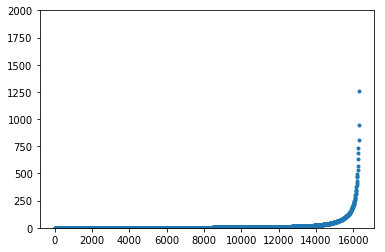

In [36]:
plt.plot(imprt_val['count'][::10],'o',markersize=3)
plt.ylim(0,2000)
plt.show()

In [38]:
# index a ceratin value
input_word = 'consist'
aspect_word = stemmer.stem(input_word)
location = imprt_val.index[imprt_val['word'] == aspect_word].tolist()[0]
frequency = vocal_f[aspect_word]
distance = len(imprt_val) - location
print('location: ',location)
print('frequency: ',frequency)
print('distance: ',distance)

location:  15527
frequency:  94
distance:  785


# Asepect Segementation

**Ref:** 

http://www.jamuura.com/blog/must-know-elements-storytelling/
https://nofilmschool.com/2016/02/6-elements-great-film
character, plot, conflict, resolution, scene, structure, dialogue, visuals, timing, performance, Sound
#### Combine with the most frequent important word, I have decided 5 aspects and selected seed keywords manually by reading reviews.
|No.|Aspects|Seed Keywords|
|---|----|-------------|
|1.|Character|character,antagonist, pace, development, villains，person, depth|
|2.|Scene|scene, visual, cgi, effect, action, animation|
|3.|Acting|acting, performance, cast, actor|
|4.|Story|story,storyline,boring, cheesy, dialogue,twist,plot, drama, predictable|
|5.|Fun|fun,funny, entertain,laugh,joke, comedy,humor|

In [62]:
aspects = ['character','scene','acting','story','fun']
seed1 = ['charact',
 'antagonist',
 'villain',
 'person',
 'depth',
 'pace',
 'develop']
seed2 = ['scene',
 'visual',
 'cgi',
 'effect',
 'action',
 'anim']
seed3 = ['act',
 'perform',
 'cast',
 'actor']
seed4 = ['stori',
 'storylin',
 'bore',
 'cheesi',
 'dialogu',
 'twist',
 'plot',
 'drama',
 'predict',
    'pace']
seed5 = ['fun',
 'funni',
 'entertain',
 'laugh',
 'joke',
 'comedi','humor','humour']
seeds = [seed1, seed2, seed3, seed4, seed5]        

In [63]:
# label each sentence with an aspect
def step1n2(keyword_list,sentence_list = flat_C):
    """
    Match aspect keywords in each sentence of X and record the matching hits for each aspect i

    param sentence_list: a list of sentence that will be compared with each aspect keywords
    param keyword_list: a list of lists where sublists contains keywords for different aspects

    return msa: "matched sentence & aspects". a list of lists (shape = len(sentence_list) * len(aspects)), where sublists are keyword match counts for sentences
    return l: a list of aspect label for each sentence (shape = len(sentence_list) * 1); 0 means no match; 1-5 indicates aspect label
    """
    msa = []
    l = []
    for sent in sentence_list: 
        sa = []
        for keywords in keyword_list:
            sa.append(len(set(sent) & set(keywords)))
        msa.append(sa)

        if sum(sa) != 0:     # calculate the label if five aspect matches are not all zeros
            winner = np.argwhere(sa == np.amax(sa))+1  #valid winner value: 1,2,3,4,5
            l.append(winner.flatten().tolist())
        else:
            l.append([0])
    return msa, l

In [64]:
msa,labels = step1n2(seeds,sentence_list = flat_C)
print(labels[:5])
msa[0],labels[0]

[[1], [0], [3], [1, 3, 4], [0]]


([3, 0, 0, 1, 0], [1])

In [65]:
aspect_df = copy.deepcopy(imprt_val)

In [ ]:
# m,n = get_C1(sentence_list = flat_C,aspects = aspects, labels = labels , aspect_df = aspect_df, imprt_val = imprt_val)

In [66]:
# COPIED CELL
# https://blog.csdn.net/shenxiaoming77/article/details/51473986
def get_C(sentence_list = flat_C,aspects = aspects, labels = labels , aspect_df = aspect_df, imprt_w = imprt_w,imprt_val = imprt_val):
    """
    C1 is the number of times w occurs in sentences belonging to aspect Ai
    C2 is the number of times w occurs in sentences NOT belonging to Ai
    C3 is the number of sentences of aspect Ai that do not contain w
    C4 is the number of sentences that neither belong to aspect Ai , nor contain word w,
    
    return matrix_list: a list contains five matrices; each matrix contains all 4 C values for an aspect
    return a_index_list: a list of setence indices; sentence belong to a certain aspect
    return na_index_list: a list of setence indices; sentence NOT belong to a certain aspect
    """ 
   
    a_index_list = []  # list of lists; sublist0 contains sentence index that belongs to a certain aspect
    na_index_list = []  # list of lists; sublist0 contains sentence index that NOT belongs to a certain aspect
    matrix_list = []  # a list stores all 5 a_matrix, each of the matrix contains C 1,2,3,4 values for an aspect
    num_words = len(imprt_w)
    
    for a in range(len(aspects)):
        print('Calculating C values for aspect {}...'.format(a+1))
        b_list = []
        for label in labels:
            b_list.append(a+1 in label) #b_list is a list contais True or False with a shape of len(all sentences)
        
        # get all sentences belong to aspect a
        a_index = list(compress(range(len(b_list)), b_list))
        na_index = [idx for idx in range(len(flat_C)) if not idx in a_index]
        sents_a = list(flat_C[i] for i in a_index) # get all sentences belongs to aspect a
        sents_na = list(flat_C[i] for i in na_index)
# ==============================================================================================================
        a_matrix = np.empty((num_words,4))

        for w in range(num_words):  # check if w1 is (not) in s1, s2, ..., sn; 
            word = imprt_w[w]
            # Calcuate C1, C3
            counter1 = 0    # counter1 cumsum value for C1
            for sa in sents_a:
                counter1 += int(word in sa) # cumsum when word appears in sent_a
            c1 = counter1
            c3 = len(sents_a) - counter1
            
            # Calculate C2, C4
            counter2 = 0    # counter2 cumsum value for C2
            for nsa in sents_na: 
                counter2 += int(word in nsa)  #cumsum when word appears in sent_na
            c2 = counter2
            c4 = len(sents_na) - counter2
            
            # fill numbers (C values) to a_matrix
            a_matrix[w,0] = c1
            a_matrix[w,1] = c2
            a_matrix[w,2] = c3
            a_matrix[w,3] = c4
            
        matrix_list.append(a_matrix)
        
        
        
        a_index_list.append(a_index)
        na_index_list.append(na_index)
#         break

    return matrix_list, a_index_list, na_index_list

In [146]:
matrix_list, a_index_list, na_index_list = get_C(sentence_list = flat_C,aspects = aspects, labels = labels , aspect_df = aspect_df, imprt_val = imprt_val)

Calculating C values for aspect 1...
Calculating C values for aspect 2...
Calculating C values for aspect 3...
Calculating C values for aspect 4...
Calculating C values for aspect 5...


In [148]:
#着急忙慌的保存下来所有的结果...生怕过两秒钟结果就飞了...
# for j in range(len(a_index_list)):
#     np.savetxt("a{}_index_list.txt".format(j),a_index_list[j],delimiter="\t")
#     np.savetxt("na{}_index_list.txt".format(j),na_index_list[j],delimiter = "\t")
#     np.savetxt("a{}_Cvalue_matrix.csv".foramt(j), matrix_list(j),delimiter = ",")

In [24]:
a0_Cvalue_matrix = pd.read_csv('a0_Cvalue_matrix.csv',sep='\t',header = None)
a1_Cvalue_matrix = pd.read_csv('a1_Cvalue_matrix.csv',sep='\t',header = None)
a2_Cvalue_matrix = pd.read_csv('a2_Cvalue_matrix.csv',sep='\t',header = None)
a3_Cvalue_matrix = pd.read_csv('a3_Cvalue_matrix.csv',sep='\t',header = None)
a4_Cvalue_matrix = pd.read_csv('a4_Cvalue_matrix.csv',sep='\t',header = None)

In [25]:
a0_Cvalue_matrix = np.array(a0_Cvalue_matrix)
a1_Cvalue_matrix = np.array(a1_Cvalue_matrix)
a2_Cvalue_matrix = np.array(a2_Cvalue_matrix)
a3_Cvalue_matrix = np.array(a3_Cvalue_matrix)
a4_Cvalue_matrix = np.array(a4_Cvalue_matrix)
a1_Cvalue_matrix.shape,a2_Cvalue_matrix.shape,a3_Cvalue_matrix.shape,a4_Cvalue_matrix.shape

((16312, 4), (16312, 4), (16312, 4), (16312, 4))

In [26]:
matrix_list = [a0_Cvalue_matrix,a1_Cvalue_matrix,a2_Cvalue_matrix,a3_Cvalue_matrix,a4_Cvalue_matrix]
c_matrix  = np.array(matrix_list)
c_matrix.shape

(5, 16312, 4)

In [67]:
def chi(c,c1,c2,c3,c4):
    """
    The χ2 statistic to compute the dependencies between a term w and aspect Ai is defined as follows:
    
    param c : C  is the total number of word occurrences
    param c1: C1 is the number of times w occurs in sentences belonging to aspect Ai
    param c2: C2 is the number of times w occurs in sentences NOT belonging to Ai
    param c3: C3 is the number of sentences of aspect Ai that do not contain w
    param c4: C4 is the number of sentences that neither belong to aspect Ai , nor contain word w,
    
    return xwa: chi-squared value (float)
    """
    xwa = (c* (c1*c4 - c2*c3)**2) / ((c1+c3) * (c2+c4) * (c1+c2) * (c3+c4))
    return xwa

In [68]:
## c_matrix indexing: c1a1w1 = c_matrix[A,W,C]
c_matrix  = np.array(matrix_list)
# c_matrix.shape = (5, 16312, 4)
# create a new matrix to store all chi values; number of rows = number of words, number of columns = number of aspects
chi_matrix = np.empty((c_matrix.shape[1], c_matrix.shape[0]))
for w in range(c_matrix.shape[1]):
    word = imprt_w[w]
    print('\nCalculating Chi2 for word: {}'.format(word))
    c = imprt_f[word]
    for a in range(c_matrix.shape[0]):
        c1=c_matrix[a,w,0]
        c2=c_matrix[a,w,1]
        c3=c_matrix[a,w,2]
        c4=c_matrix[a,w,3]
        
        print('C values: ',c,c1,c2,c3,c4)       
        xwa = chi(c,c1,c2,c3,c4)
        print('A{} Chi2: '.format(a),xwa)
        
        chi_matrix[w,a] = xwa
# there are 52651 sentences in total. Therefore, any c3,c4 greater than 52651 indicates a bug
# there are 487190 words in  total. therefore, any c1, c2 greater than 487190 indicates a bug


Calculating Chi2 for word: 🙄
C values:  1 0.0 1.0 6244.0 46406.0
A0 Chi2:  2.555530241727008e-06
C values:  1 0.0 1.0 5819.0 46831.0
A1 Chi2:  2.3599743164712987e-06
C values:  1 0.0 1.0 2795.0 49855.0
A2 Chi2:  1.0647950046751929e-06
C values:  1 0.0 1.0 5035.0 47615.0
A3 Chi2:  2.008390645263405e-06
C values:  1 0.0 1.0 3844.0 48806.0
A4 Chi2:  1.4959011277845324e-06

Calculating Chi2 for word: campli
C values:  1 0.0 1.0 6244.0 46406.0
A0 Chi2:  2.555530241727008e-06
C values:  1 0.0 1.0 5819.0 46831.0
A1 Chi2:  2.3599743164712987e-06
C values:  1 0.0 1.0 2795.0 49855.0
A2 Chi2:  1.0647950046751929e-06
C values:  1 1.0 0.0 5034.0 47616.0
A3 Chi2:  0.00017962015181478936
C values:  1 0.0 1.0 3844.0 48806.0
A4 Chi2:  1.4959011277845324e-06

Calculating Chi2 for word: synthes
C values:  1 0.0 1.0 6244.0 46406.0
A0 Chi2:  2.555530241727008e-06
C values:  1 1.0 0.0 5818.0 46832.0
A1 Chi2:  0.00015286074517328457
C values:  1 0.0 1.0 2795.0 49855.0
A2 Chi2:  1.0647950046751929e-06
C valu

A3 Chi2:  2.008390645263405e-06
C values:  1 0.0 1.0 3844.0 48806.0
A4 Chi2:  1.4959011277845324e-06

Calculating Chi2 for word: aros
C values:  1 0.0 1.0 6244.0 46406.0
A0 Chi2:  2.555530241727008e-06
C values:  1 0.0 1.0 5819.0 46831.0
A1 Chi2:  2.3599743164712987e-06
C values:  1 0.0 1.0 2795.0 49855.0
A2 Chi2:  1.0647950046751929e-06
C values:  1 0.0 1.0 5035.0 47615.0
A3 Chi2:  2.008390645263405e-06
C values:  1 0.0 1.0 3844.0 48806.0
A4 Chi2:  1.4959011277845324e-06

Calculating Chi2 for word: colourful
C values:  1 0.0 1.0 6244.0 46406.0
A0 Chi2:  2.555530241727008e-06
C values:  1 0.0 1.0 5819.0 46831.0
A1 Chi2:  2.3599743164712987e-06
C values:  1 0.0 1.0 2795.0 49855.0
A2 Chi2:  1.0647950046751929e-06
C values:  1 0.0 1.0 5035.0 47615.0
A3 Chi2:  2.008390645263405e-06
C values:  1 0.0 1.0 3844.0 48806.0
A4 Chi2:  1.4959011277845324e-06

Calculating Chi2 for word: aron
C values:  1 0.0 1.0 6244.0 46406.0
A0 Chi2:  2.555530241727008e-06
C values:  1 0.0 1.0 5819.0 46831.0
A1 Ch

C values:  1 0.0 1.0 2795.0 49855.0
A2 Chi2:  1.0647950046751929e-06
C values:  1 0.0 1.0 5035.0 47615.0
A3 Chi2:  2.008390645263405e-06
C values:  1 0.0 1.0 3844.0 48806.0
A4 Chi2:  1.4959011277845324e-06

Calculating Chi2 for word: contiuat
C values:  1 0.0 1.0 6244.0 46406.0
A0 Chi2:  2.555530241727008e-06
C values:  1 0.0 1.0 5819.0 46831.0
A1 Chi2:  2.3599743164712987e-06
C values:  1 0.0 1.0 2795.0 49855.0
A2 Chi2:  1.0647950046751929e-06
C values:  1 1.0 0.0 5034.0 47616.0
A3 Chi2:  0.00017962015181478936
C values:  1 0.0 1.0 3844.0 48806.0
A4 Chi2:  1.4959011277845324e-06

Calculating Chi2 for word: anchovi
C values:  1 0.0 1.0 6244.0 46406.0
A0 Chi2:  2.555530241727008e-06
C values:  1 0.0 1.0 5819.0 46831.0
A1 Chi2:  2.3599743164712987e-06
C values:  1 0.0 1.0 2795.0 49855.0
A2 Chi2:  1.0647950046751929e-06
C values:  1 0.0 1.0 5035.0 47615.0
A3 Chi2:  2.008390645263405e-06
C values:  1 0.0 1.0 3844.0 48806.0
A4 Chi2:  1.4959011277845324e-06

Calculating Chi2 for word: tazer


C values:  1 1.0 0.0 6243.0 46407.0
A0 Chi2:  0.0001411634371275627
C values:  1 1.0 0.0 5818.0 46832.0
A1 Chi2:  0.00015286074517328457
C values:  1 0.0 1.0 2795.0 49855.0
A2 Chi2:  1.0647950046751929e-06
C values:  1 0.0 1.0 5035.0 47615.0
A3 Chi2:  2.008390645263405e-06
C values:  1 1.0 0.0 3843.0 48807.0
A4 Chi2:  0.00024115727029358662

Calculating Chi2 for word: ammus
C values:  1 1.0 0.0 6243.0 46407.0
A0 Chi2:  0.0001411634371275627
C values:  1 0.0 1.0 5819.0 46831.0
A1 Chi2:  2.3599743164712987e-06
C values:  1 0.0 1.0 2795.0 49855.0
A2 Chi2:  1.0647950046751929e-06
C values:  1 1.0 0.0 5034.0 47616.0
A3 Chi2:  0.00017962015181478936
C values:  1 1.0 0.0 3843.0 48807.0
A4 Chi2:  0.00024115727029358662

Calculating Chi2 for word: coolli
C values:  1 0.0 1.0 6244.0 46406.0
A0 Chi2:  2.555530241727008e-06
C values:  1 0.0 1.0 5819.0 46831.0
A1 Chi2:  2.3599743164712987e-06
C values:  1 0.0 1.0 2795.0 49855.0
A2 Chi2:  1.0647950046751929e-06
C values:  1 0.0 1.0 5035.0 47615.0
A3

C values:  1 1.0 0.0 2794.0 49856.0
A2 Chi2:  0.00033879519627879793
C values:  1 0.0 1.0 5035.0 47615.0
A3 Chi2:  2.008390645263405e-06
C values:  1 0.0 1.0 3844.0 48806.0
A4 Chi2:  1.4959011277845324e-06

Calculating Chi2 for word: bladerunn
C values:  1 0.0 1.0 6244.0 46406.0
A0 Chi2:  2.555530241727008e-06
C values:  1 0.0 1.0 5819.0 46831.0
A1 Chi2:  2.3599743164712987e-06
C values:  1 0.0 1.0 2795.0 49855.0
A2 Chi2:  1.0647950046751929e-06
C values:  1 0.0 1.0 5035.0 47615.0
A3 Chi2:  2.008390645263405e-06
C values:  1 0.0 1.0 3844.0 48806.0
A4 Chi2:  1.4959011277845324e-06

Calculating Chi2 for word: apparel
C values:  1 0.0 1.0 6244.0 46406.0
A0 Chi2:  2.555530241727008e-06
C values:  1 0.0 1.0 5819.0 46831.0
A1 Chi2:  2.3599743164712987e-06
C values:  1 0.0 1.0 2795.0 49855.0
A2 Chi2:  1.0647950046751929e-06
C values:  1 0.0 1.0 5035.0 47615.0
A3 Chi2:  2.008390645263405e-06
C values:  1 0.0 1.0 3844.0 48806.0
A4 Chi2:  1.4959011277845324e-06

Calculating Chi2 for word: appall

C values:  1 0.0 1.0 5035.0 47615.0
A3 Chi2:  2.008390645263405e-06
C values:  1 0.0 1.0 3844.0 48806.0
A4 Chi2:  1.4959011277845324e-06

Calculating Chi2 for word: sorceri
C values:  1 0.0 1.0 6244.0 46406.0
A0 Chi2:  2.555530241727008e-06
C values:  1 0.0 1.0 5819.0 46831.0
A1 Chi2:  2.3599743164712987e-06
C values:  1 0.0 1.0 2795.0 49855.0
A2 Chi2:  1.0647950046751929e-06
C values:  1 0.0 1.0 5035.0 47615.0
A3 Chi2:  2.008390645263405e-06
C values:  1 0.0 1.0 3844.0 48806.0
A4 Chi2:  1.4959011277845324e-06

Calculating Chi2 for word: camero
C values:  1 0.0 1.0 6244.0 46406.0
A0 Chi2:  2.555530241727008e-06
C values:  1 0.0 1.0 5819.0 46831.0
A1 Chi2:  2.3599743164712987e-06
C values:  1 0.0 1.0 2795.0 49855.0
A2 Chi2:  1.0647950046751929e-06
C values:  1 0.0 1.0 5035.0 47615.0
A3 Chi2:  2.008390645263405e-06
C values:  1 0.0 1.0 3844.0 48806.0
A4 Chi2:  1.4959011277845324e-06

Calculating Chi2 for word: comi
C values:  1 0.0 1.0 6244.0 46406.0
A0 Chi2:  2.555530241727008e-06
C val

C values:  1 0.0 1.0 5035.0 47615.0
A3 Chi2:  2.008390645263405e-06
C values:  1 0.0 1.0 3844.0 48806.0
A4 Chi2:  1.4959011277845324e-06

Calculating Chi2 for word: compendium
C values:  1 0.0 1.0 6244.0 46406.0
A0 Chi2:  2.555530241727008e-06
C values:  1 1.0 0.0 5818.0 46832.0
A1 Chi2:  0.00015286074517328457
C values:  1 0.0 1.0 2795.0 49855.0
A2 Chi2:  1.0647950046751929e-06
C values:  1 0.0 1.0 5035.0 47615.0
A3 Chi2:  2.008390645263405e-06
C values:  1 0.0 1.0 3844.0 48806.0
A4 Chi2:  1.4959011277845324e-06

Calculating Chi2 for word: col
C values:  1 0.0 1.0 6244.0 46406.0
A0 Chi2:  2.555530241727008e-06
C values:  1 0.0 1.0 5819.0 46831.0
A1 Chi2:  2.3599743164712987e-06
C values:  1 0.0 1.0 2795.0 49855.0
A2 Chi2:  1.0647950046751929e-06
C values:  1 0.0 1.0 5035.0 47615.0
A3 Chi2:  2.008390645263405e-06
C values:  1 0.0 1.0 3844.0 48806.0
A4 Chi2:  1.4959011277845324e-06

Calculating Chi2 for word: asghard
C values:  1 0.0 1.0 6244.0 46406.0
A0 Chi2:  2.555530241727008e-06
C 

C values:  1 0.0 1.0 5035.0 47615.0
A3 Chi2:  2.008390645263405e-06
C values:  1 0.0 1.0 3844.0 48806.0
A4 Chi2:  1.4959011277845324e-06

Calculating Chi2 for word: blackboard
C values:  1 0.0 1.0 6244.0 46406.0
A0 Chi2:  2.555530241727008e-06
C values:  1 0.0 1.0 5819.0 46831.0
A1 Chi2:  2.3599743164712987e-06
C values:  1 0.0 1.0 2795.0 49855.0
A2 Chi2:  1.0647950046751929e-06
C values:  1 0.0 1.0 5035.0 47615.0
A3 Chi2:  2.008390645263405e-06
C values:  1 0.0 1.0 3844.0 48806.0
A4 Chi2:  1.4959011277845324e-06

Calculating Chi2 for word: apprecit
C values:  1 1.0 0.0 6243.0 46407.0
A0 Chi2:  0.0001411634371275627
C values:  1 0.0 1.0 5819.0 46831.0
A1 Chi2:  2.3599743164712987e-06
C values:  1 0.0 1.0 2795.0 49855.0
A2 Chi2:  1.0647950046751929e-06
C values:  1 0.0 1.0 5035.0 47615.0
A3 Chi2:  2.008390645263405e-06
C values:  1 0.0 1.0 3844.0 48806.0
A4 Chi2:  1.4959011277845324e-06

Calculating Chi2 for word: timetravel
C values:  1 0.0 1.0 6244.0 46406.0
A0 Chi2:  2.55553024172700

C values:  1 0.0 1.0 6244.0 46406.0
A0 Chi2:  2.555530241727008e-06
C values:  1 0.0 1.0 5819.0 46831.0
A1 Chi2:  2.3599743164712987e-06
C values:  1 0.0 1.0 2795.0 49855.0
A2 Chi2:  1.0647950046751929e-06
C values:  1 0.0 1.0 5035.0 47615.0
A3 Chi2:  2.008390645263405e-06
C values:  1 0.0 1.0 3844.0 48806.0
A4 Chi2:  1.4959011277845324e-06

Calculating Chi2 for word: chato
C values:  1 0.0 1.0 6244.0 46406.0
A0 Chi2:  2.555530241727008e-06
C values:  1 0.0 1.0 5819.0 46831.0
A1 Chi2:  2.3599743164712987e-06
C values:  1 0.0 1.0 2795.0 49855.0
A2 Chi2:  1.0647950046751929e-06
C values:  1 0.0 1.0 5035.0 47615.0
A3 Chi2:  2.008390645263405e-06
C values:  1 0.0 1.0 3844.0 48806.0
A4 Chi2:  1.4959011277845324e-06

Calculating Chi2 for word: bastardis
C values:  1 0.0 1.0 6244.0 46406.0
A0 Chi2:  2.555530241727008e-06
C values:  1 0.0 1.0 5819.0 46831.0
A1 Chi2:  2.3599743164712987e-06
C values:  1 0.0 1.0 2795.0 49855.0
A2 Chi2:  1.0647950046751929e-06
C values:  1 1.0 0.0 5034.0 47616.0


C values:  1 0.0 1.0 3844.0 48806.0
A4 Chi2:  1.4959011277845324e-06

Calculating Chi2 for word: standstil
C values:  1 0.0 1.0 6244.0 46406.0
A0 Chi2:  2.555530241727008e-06
C values:  1 0.0 1.0 5819.0 46831.0
A1 Chi2:  2.3599743164712987e-06
C values:  1 0.0 1.0 2795.0 49855.0
A2 Chi2:  1.0647950046751929e-06
C values:  1 1.0 0.0 5034.0 47616.0
A3 Chi2:  0.00017962015181478936
C values:  1 0.0 1.0 3844.0 48806.0
A4 Chi2:  1.4959011277845324e-06

Calculating Chi2 for word: cheshir
C values:  1 0.0 1.0 6244.0 46406.0
A0 Chi2:  2.555530241727008e-06
C values:  1 1.0 0.0 5818.0 46832.0
A1 Chi2:  0.00015286074517328457
C values:  1 0.0 1.0 2795.0 49855.0
A2 Chi2:  1.0647950046751929e-06
C values:  1 0.0 1.0 5035.0 47615.0
A3 Chi2:  2.008390645263405e-06
C values:  1 0.0 1.0 3844.0 48806.0
A4 Chi2:  1.4959011277845324e-06

Calculating Chi2 for word: bastil
C values:  1 0.0 1.0 6244.0 46406.0
A0 Chi2:  2.555530241727008e-06
C values:  1 0.0 1.0 5819.0 46831.0
A1 Chi2:  2.3599743164712987e-0

C values:  1 0.0 1.0 5035.0 47615.0
A3 Chi2:  2.008390645263405e-06
C values:  1 0.0 1.0 3844.0 48806.0
A4 Chi2:  1.4959011277845324e-06

Calculating Chi2 for word: chequ
C values:  1 0.0 1.0 6244.0 46406.0
A0 Chi2:  2.555530241727008e-06
C values:  1 0.0 1.0 5819.0 46831.0
A1 Chi2:  2.3599743164712987e-06
C values:  1 0.0 1.0 2795.0 49855.0
A2 Chi2:  1.0647950046751929e-06
C values:  1 0.0 1.0 5035.0 47615.0
A3 Chi2:  2.008390645263405e-06
C values:  1 0.0 1.0 3844.0 48806.0
A4 Chi2:  1.4959011277845324e-06

Calculating Chi2 for word: berardinelli
C values:  1 0.0 1.0 6244.0 46406.0
A0 Chi2:  2.555530241727008e-06
C values:  1 0.0 1.0 5819.0 46831.0
A1 Chi2:  2.3599743164712987e-06
C values:  1 0.0 1.0 2795.0 49855.0
A2 Chi2:  1.0647950046751929e-06
C values:  1 0.0 1.0 5035.0 47615.0
A3 Chi2:  2.008390645263405e-06
C values:  1 0.0 1.0 3844.0 48806.0
A4 Chi2:  1.4959011277845324e-06

Calculating Chi2 for word: chequer
C values:  1 0.0 1.0 6244.0 46406.0
A0 Chi2:  2.555530241727008e-0

C values:  1 0.0 1.0 3844.0 48806.0
A4 Chi2:  1.4959011277845324e-06

Calculating Chi2 for word: ssshhhh
C values:  1 0.0 1.0 6244.0 46406.0
A0 Chi2:  2.555530241727008e-06
C values:  1 1.0 0.0 5818.0 46832.0
A1 Chi2:  0.00015286074517328457
C values:  1 0.0 1.0 2795.0 49855.0
A2 Chi2:  1.0647950046751929e-06
C values:  1 0.0 1.0 5035.0 47615.0
A3 Chi2:  2.008390645263405e-06
C values:  1 0.0 1.0 3844.0 48806.0
A4 Chi2:  1.4959011277845324e-06

Calculating Chi2 for word: anomal
C values:  1 0.0 1.0 6244.0 46406.0
A0 Chi2:  2.555530241727008e-06
C values:  1 0.0 1.0 5819.0 46831.0
A1 Chi2:  2.3599743164712987e-06
C values:  1 0.0 1.0 2795.0 49855.0
A2 Chi2:  1.0647950046751929e-06
C values:  1 0.0 1.0 5035.0 47615.0
A3 Chi2:  2.008390645263405e-06
C values:  1 0.0 1.0 3844.0 48806.0
A4 Chi2:  1.4959011277845324e-06

Calculating Chi2 for word: woolf
C values:  1 1.0 0.0 6243.0 46407.0
A0 Chi2:  0.0001411634371275627
C values:  1 0.0 1.0 5819.0 46831.0
A1 Chi2:  2.3599743164712987e-06
C v

C values:  1 0.0 1.0 6244.0 46406.0
A0 Chi2:  2.555530241727008e-06
C values:  1 0.0 1.0 5819.0 46831.0
A1 Chi2:  2.3599743164712987e-06
C values:  1 0.0 1.0 2795.0 49855.0
A2 Chi2:  1.0647950046751929e-06
C values:  1 1.0 0.0 5034.0 47616.0
A3 Chi2:  0.00017962015181478936
C values:  1 0.0 1.0 3844.0 48806.0
A4 Chi2:  1.4959011277845324e-06

Calculating Chi2 for word: consign
C values:  1 0.0 1.0 6244.0 46406.0
A0 Chi2:  2.555530241727008e-06
C values:  1 0.0 1.0 5819.0 46831.0
A1 Chi2:  2.3599743164712987e-06
C values:  1 0.0 1.0 2795.0 49855.0
A2 Chi2:  1.0647950046751929e-06
C values:  1 0.0 1.0 5035.0 47615.0
A3 Chi2:  2.008390645263405e-06
C values:  1 0.0 1.0 3844.0 48806.0
A4 Chi2:  1.4959011277845324e-06

Calculating Chi2 for word: blantant
C values:  1 0.0 1.0 6244.0 46406.0
A0 Chi2:  2.555530241727008e-06
C values:  1 1.0 0.0 5818.0 46832.0
A1 Chi2:  0.00015286074517328457
C values:  1 0.0 1.0 2795.0 49855.0
A2 Chi2:  1.0647950046751929e-06
C values:  1 0.0 1.0 5035.0 47615.

C values:  1 0.0 1.0 6244.0 46406.0
A0 Chi2:  2.555530241727008e-06
C values:  1 1.0 0.0 5818.0 46832.0
A1 Chi2:  0.00015286074517328457
C values:  1 0.0 1.0 2795.0 49855.0
A2 Chi2:  1.0647950046751929e-06
C values:  1 0.0 1.0 5035.0 47615.0
A3 Chi2:  2.008390645263405e-06
C values:  1 0.0 1.0 3844.0 48806.0
A4 Chi2:  1.4959011277845324e-06

Calculating Chi2 for word: tearjerk
C values:  1 0.0 1.0 6244.0 46406.0
A0 Chi2:  2.555530241727008e-06
C values:  1 0.0 1.0 5819.0 46831.0
A1 Chi2:  2.3599743164712987e-06
C values:  1 0.0 1.0 2795.0 49855.0
A2 Chi2:  1.0647950046751929e-06
C values:  1 0.0 1.0 5035.0 47615.0
A3 Chi2:  2.008390645263405e-06
C values:  1 0.0 1.0 3844.0 48806.0
A4 Chi2:  1.4959011277845324e-06

Calculating Chi2 for word: bling
C values:  1 0.0 1.0 6244.0 46406.0
A0 Chi2:  2.555530241727008e-06
C values:  1 0.0 1.0 5819.0 46831.0
A1 Chi2:  2.3599743164712987e-06
C values:  1 0.0 1.0 2795.0 49855.0
A2 Chi2:  1.0647950046751929e-06
C values:  1 0.0 1.0 5035.0 47615.0
A

C values:  1 0.0 1.0 3844.0 48806.0
A4 Chi2:  1.4959011277845324e-06

Calculating Chi2 for word: zellweg
C values:  1 0.0 1.0 6244.0 46406.0
A0 Chi2:  2.555530241727008e-06
C values:  1 0.0 1.0 5819.0 46831.0
A1 Chi2:  2.3599743164712987e-06
C values:  1 0.0 1.0 2795.0 49855.0
A2 Chi2:  1.0647950046751929e-06
C values:  1 0.0 1.0 5035.0 47615.0
A3 Chi2:  2.008390645263405e-06
C values:  1 0.0 1.0 3844.0 48806.0
A4 Chi2:  1.4959011277845324e-06

Calculating Chi2 for word: buuut
C values:  1 0.0 1.0 6244.0 46406.0
A0 Chi2:  2.555530241727008e-06
C values:  1 0.0 1.0 5819.0 46831.0
A1 Chi2:  2.3599743164712987e-06
C values:  1 0.0 1.0 2795.0 49855.0
A2 Chi2:  1.0647950046751929e-06
C values:  1 0.0 1.0 5035.0 47615.0
A3 Chi2:  2.008390645263405e-06
C values:  1 0.0 1.0 3844.0 48806.0
A4 Chi2:  1.4959011277845324e-06

Calculating Chi2 for word: somewanda
C values:  1 0.0 1.0 6244.0 46406.0
A0 Chi2:  2.555530241727008e-06
C values:  1 1.0 0.0 5818.0 46832.0
A1 Chi2:  0.00015286074517328457


C values:  1 1.0 0.0 5818.0 46832.0
A1 Chi2:  0.00015286074517328457
C values:  1 0.0 1.0 2795.0 49855.0
A2 Chi2:  1.0647950046751929e-06
C values:  1 0.0 1.0 5035.0 47615.0
A3 Chi2:  2.008390645263405e-06
C values:  1 0.0 1.0 3844.0 48806.0
A4 Chi2:  1.4959011277845324e-06

Calculating Chi2 for word: aok
C values:  1 0.0 1.0 6244.0 46406.0
A0 Chi2:  2.555530241727008e-06
C values:  1 0.0 1.0 5819.0 46831.0
A1 Chi2:  2.3599743164712987e-06
C values:  1 0.0 1.0 2795.0 49855.0
A2 Chi2:  1.0647950046751929e-06
C values:  1 0.0 1.0 5035.0 47615.0
A3 Chi2:  2.008390645263405e-06
C values:  1 0.0 1.0 3844.0 48806.0
A4 Chi2:  1.4959011277845324e-06

Calculating Chi2 for word: ao
C values:  1 0.0 1.0 6244.0 46406.0
A0 Chi2:  2.555530241727008e-06
C values:  1 0.0 1.0 5819.0 46831.0
A1 Chi2:  2.3599743164712987e-06
C values:  1 0.0 1.0 2795.0 49855.0
A2 Chi2:  1.0647950046751929e-06
C values:  1 0.0 1.0 5035.0 47615.0
A3 Chi2:  2.008390645263405e-06
C values:  1 1.0 0.0 3843.0 48807.0
A4 Chi2: 

C values:  1 0.0 1.0 6244.0 46406.0
A0 Chi2:  2.555530241727008e-06
C values:  1 0.0 1.0 5819.0 46831.0
A1 Chi2:  2.3599743164712987e-06
C values:  1 0.0 1.0 2795.0 49855.0
A2 Chi2:  1.0647950046751929e-06
C values:  1 0.0 1.0 5035.0 47615.0
A3 Chi2:  2.008390645263405e-06
C values:  1 0.0 1.0 3844.0 48806.0
A4 Chi2:  1.4959011277845324e-06

Calculating Chi2 for word: punter
C values:  1 0.0 1.0 6244.0 46406.0
A0 Chi2:  2.555530241727008e-06
C values:  1 1.0 0.0 5818.0 46832.0
A1 Chi2:  0.00015286074517328457
C values:  1 0.0 1.0 2795.0 49855.0
A2 Chi2:  1.0647950046751929e-06
C values:  1 0.0 1.0 5035.0 47615.0
A3 Chi2:  2.008390645263405e-06
C values:  1 0.0 1.0 3844.0 48806.0
A4 Chi2:  1.4959011277845324e-06

Calculating Chi2 for word: princes
C values:  1 0.0 1.0 6244.0 46406.0
A0 Chi2:  2.555530241727008e-06
C values:  1 0.0 1.0 5819.0 46831.0
A1 Chi2:  2.3599743164712987e-06
C values:  1 0.0 1.0 2795.0 49855.0
A2 Chi2:  1.0647950046751929e-06
C values:  1 0.0 1.0 5035.0 47615.0
A

C values:  1 0.0 1.0 5819.0 46831.0
A1 Chi2:  2.3599743164712987e-06
C values:  1 0.0 1.0 2795.0 49855.0
A2 Chi2:  1.0647950046751929e-06
C values:  1 0.0 1.0 5035.0 47615.0
A3 Chi2:  2.008390645263405e-06
C values:  1 0.0 1.0 3844.0 48806.0
A4 Chi2:  1.4959011277845324e-06

Calculating Chi2 for word: joyous
C values:  1 1.0 0.0 6243.0 46407.0
A0 Chi2:  0.0001411634371275627
C values:  1 0.0 1.0 5819.0 46831.0
A1 Chi2:  2.3599743164712987e-06
C values:  1 0.0 1.0 2795.0 49855.0
A2 Chi2:  1.0647950046751929e-06
C values:  1 1.0 0.0 5034.0 47616.0
A3 Chi2:  0.00017962015181478936
C values:  1 1.0 0.0 3843.0 48807.0
A4 Chi2:  0.00024115727029358662

Calculating Chi2 for word: upright
C values:  1 0.0 1.0 6244.0 46406.0
A0 Chi2:  2.555530241727008e-06
C values:  1 1.0 0.0 5818.0 46832.0
A1 Chi2:  0.00015286074517328457
C values:  1 1.0 0.0 2794.0 49856.0
A2 Chi2:  0.00033879519627879793
C values:  1 0.0 1.0 5035.0 47615.0
A3 Chi2:  2.008390645263405e-06
C values:  1 0.0 1.0 3844.0 48806.0


C values:  1 0.0 1.0 5035.0 47615.0
A3 Chi2:  2.008390645263405e-06
C values:  1 0.0 1.0 3844.0 48806.0
A4 Chi2:  1.4959011277845324e-06

Calculating Chi2 for word: populi
C values:  1 0.0 1.0 6244.0 46406.0
A0 Chi2:  2.555530241727008e-06
C values:  1 0.0 1.0 5819.0 46831.0
A1 Chi2:  2.3599743164712987e-06
C values:  1 0.0 1.0 2795.0 49855.0
A2 Chi2:  1.0647950046751929e-06
C values:  1 1.0 0.0 5034.0 47616.0
A3 Chi2:  0.00017962015181478936
C values:  1 1.0 0.0 3843.0 48807.0
A4 Chi2:  0.00024115727029358662

Calculating Chi2 for word: malibu
C values:  1 0.0 1.0 6244.0 46406.0
A0 Chi2:  2.555530241727008e-06
C values:  1 0.0 1.0 5819.0 46831.0
A1 Chi2:  2.3599743164712987e-06
C values:  1 0.0 1.0 2795.0 49855.0
A2 Chi2:  1.0647950046751929e-06
C values:  1 0.0 1.0 5035.0 47615.0
A3 Chi2:  2.008390645263405e-06
C values:  1 0.0 1.0 3844.0 48806.0
A4 Chi2:  1.4959011277845324e-06

Calculating Chi2 for word: pornstar
C values:  1 0.0 1.0 6244.0 46406.0
A0 Chi2:  2.555530241727008e-06
C

C values:  1 0.0 1.0 6244.0 46406.0
A0 Chi2:  2.555530241727008e-06
C values:  1 0.0 1.0 5819.0 46831.0
A1 Chi2:  2.3599743164712987e-06
C values:  1 0.0 1.0 2795.0 49855.0
A2 Chi2:  1.0647950046751929e-06
C values:  1 0.0 1.0 5035.0 47615.0
A3 Chi2:  2.008390645263405e-06
C values:  1 0.0 1.0 3844.0 48806.0
A4 Chi2:  1.4959011277845324e-06

Calculating Chi2 for word: marisaa
C values:  1 0.0 1.0 6244.0 46406.0
A0 Chi2:  2.555530241727008e-06
C values:  1 0.0 1.0 5819.0 46831.0
A1 Chi2:  2.3599743164712987e-06
C values:  1 0.0 1.0 2795.0 49855.0
A2 Chi2:  1.0647950046751929e-06
C values:  1 0.0 1.0 5035.0 47615.0
A3 Chi2:  2.008390645263405e-06
C values:  1 0.0 1.0 3844.0 48806.0
A4 Chi2:  1.4959011277845324e-06

Calculating Chi2 for word: ponci
C values:  1 0.0 1.0 6244.0 46406.0
A0 Chi2:  2.555530241727008e-06
C values:  1 0.0 1.0 5819.0 46831.0
A1 Chi2:  2.3599743164712987e-06
C values:  1 0.0 1.0 2795.0 49855.0
A2 Chi2:  1.0647950046751929e-06
C values:  1 0.0 1.0 5035.0 47615.0
A3

C values:  1 0.0 1.0 3844.0 48806.0
A4 Chi2:  1.4959011277845324e-06

Calculating Chi2 for word: itexpect
C values:  1 0.0 1.0 6244.0 46406.0
A0 Chi2:  2.555530241727008e-06
C values:  1 0.0 1.0 5819.0 46831.0
A1 Chi2:  2.3599743164712987e-06
C values:  1 0.0 1.0 2795.0 49855.0
A2 Chi2:  1.0647950046751929e-06
C values:  1 0.0 1.0 5035.0 47615.0
A3 Chi2:  2.008390645263405e-06
C values:  1 1.0 0.0 3843.0 48807.0
A4 Chi2:  0.00024115727029358662

Calculating Chi2 for word: iti
C values:  1 0.0 1.0 6244.0 46406.0
A0 Chi2:  2.555530241727008e-06
C values:  1 0.0 1.0 5819.0 46831.0
A1 Chi2:  2.3599743164712987e-06
C values:  1 0.0 1.0 2795.0 49855.0
A2 Chi2:  1.0647950046751929e-06
C values:  1 0.0 1.0 5035.0 47615.0
A3 Chi2:  2.008390645263405e-06
C values:  1 0.0 1.0 3844.0 48806.0
A4 Chi2:  1.4959011277845324e-06

Calculating Chi2 for word: itsallconnect
C values:  1 0.0 1.0 6244.0 46406.0
A0 Chi2:  2.555530241727008e-06
C values:  1 0.0 1.0 5819.0 46831.0
A1 Chi2:  2.3599743164712987e-

A1 Chi2:  2.3599743164712987e-06
C values:  1 0.0 1.0 2795.0 49855.0
A2 Chi2:  1.0647950046751929e-06
C values:  1 0.0 1.0 5035.0 47615.0
A3 Chi2:  2.008390645263405e-06
C values:  1 0.0 1.0 3844.0 48806.0
A4 Chi2:  1.4959011277845324e-06

Calculating Chi2 for word: laa
C values:  1 0.0 1.0 6244.0 46406.0
A0 Chi2:  2.555530241727008e-06
C values:  1 0.0 1.0 5819.0 46831.0
A1 Chi2:  2.3599743164712987e-06
C values:  1 0.0 1.0 2795.0 49855.0
A2 Chi2:  1.0647950046751929e-06
C values:  1 0.0 1.0 5035.0 47615.0
A3 Chi2:  2.008390645263405e-06
C values:  1 0.0 1.0 3844.0 48806.0
A4 Chi2:  1.4959011277845324e-06

Calculating Chi2 for word: interlock
C values:  1 0.0 1.0 6244.0 46406.0
A0 Chi2:  2.555530241727008e-06
C values:  1 0.0 1.0 5819.0 46831.0
A1 Chi2:  2.3599743164712987e-06
C values:  1 0.0 1.0 2795.0 49855.0
A2 Chi2:  1.0647950046751929e-06
C values:  1 0.0 1.0 5035.0 47615.0
A3 Chi2:  2.008390645263405e-06
C values:  1 0.0 1.0 3844.0 48806.0
A4 Chi2:  1.4959011277845324e-06

Calc

C values:  1 0.0 1.0 6244.0 46406.0
A0 Chi2:  2.555530241727008e-06
C values:  1 0.0 1.0 5819.0 46831.0
A1 Chi2:  2.3599743164712987e-06
C values:  1 0.0 1.0 2795.0 49855.0
A2 Chi2:  1.0647950046751929e-06
C values:  1 0.0 1.0 5035.0 47615.0
A3 Chi2:  2.008390645263405e-06
C values:  1 0.0 1.0 3844.0 48806.0
A4 Chi2:  1.4959011277845324e-06

Calculating Chi2 for word: intang
C values:  1 0.0 1.0 6244.0 46406.0
A0 Chi2:  2.555530241727008e-06
C values:  1 1.0 0.0 5818.0 46832.0
A1 Chi2:  0.00015286074517328457
C values:  1 0.0 1.0 2795.0 49855.0
A2 Chi2:  1.0647950046751929e-06
C values:  1 0.0 1.0 5035.0 47615.0
A3 Chi2:  2.008390645263405e-06
C values:  1 0.0 1.0 3844.0 48806.0
A4 Chi2:  1.4959011277845324e-06

Calculating Chi2 for word: intefer
C values:  1 0.0 1.0 6244.0 46406.0
A0 Chi2:  2.555530241727008e-06
C values:  1 0.0 1.0 5819.0 46831.0
A1 Chi2:  2.3599743164712987e-06
C values:  1 0.0 1.0 2795.0 49855.0
A2 Chi2:  1.0647950046751929e-06
C values:  1 1.0 0.0 5034.0 47616.0
A

C values:  1 0.0 1.0 3844.0 48806.0
A4 Chi2:  1.4959011277845324e-06

Calculating Chi2 for word: lugubri
C values:  1 0.0 1.0 6244.0 46406.0
A0 Chi2:  2.555530241727008e-06
C values:  1 0.0 1.0 5819.0 46831.0
A1 Chi2:  2.3599743164712987e-06
C values:  1 1.0 0.0 2794.0 49856.0
A2 Chi2:  0.00033879519627879793
C values:  1 0.0 1.0 5035.0 47615.0
A3 Chi2:  2.008390645263405e-06
C values:  1 0.0 1.0 3844.0 48806.0
A4 Chi2:  1.4959011277845324e-06

Calculating Chi2 for word: unproblemat
C values:  1 1.0 0.0 6243.0 46407.0
A0 Chi2:  0.0001411634371275627
C values:  1 0.0 1.0 5819.0 46831.0
A1 Chi2:  2.3599743164712987e-06
C values:  1 0.0 1.0 2795.0 49855.0
A2 Chi2:  1.0647950046751929e-06
C values:  1 0.0 1.0 5035.0 47615.0
A3 Chi2:  2.008390645263405e-06
C values:  1 1.0 0.0 3843.0 48807.0
A4 Chi2:  0.00024115727029358662

Calculating Chi2 for word: unassum
C values:  1 0.0 1.0 6244.0 46406.0
A0 Chi2:  2.555530241727008e-06
C values:  1 0.0 1.0 5819.0 46831.0
A1 Chi2:  2.3599743164712987e

C values:  1 0.0 1.0 6244.0 46406.0
A0 Chi2:  2.555530241727008e-06
C values:  1 0.0 1.0 5819.0 46831.0
A1 Chi2:  2.3599743164712987e-06
C values:  1 0.0 1.0 2795.0 49855.0
A2 Chi2:  1.0647950046751929e-06
C values:  1 0.0 1.0 5035.0 47615.0
A3 Chi2:  2.008390645263405e-06
C values:  1 0.0 1.0 3844.0 48806.0
A4 Chi2:  1.4959011277845324e-06

Calculating Chi2 for word: leeri
C values:  1 1.0 0.0 6243.0 46407.0
A0 Chi2:  0.0001411634371275627
C values:  1 0.0 1.0 5819.0 46831.0
A1 Chi2:  2.3599743164712987e-06
C values:  1 0.0 1.0 2795.0 49855.0
A2 Chi2:  1.0647950046751929e-06
C values:  1 0.0 1.0 5035.0 47615.0
A3 Chi2:  2.008390645263405e-06
C values:  1 1.0 0.0 3843.0 48807.0
A4 Chi2:  0.00024115727029358662

Calculating Chi2 for word: leftov
C values:  1 0.0 1.0 6244.0 46406.0
A0 Chi2:  2.555530241727008e-06
C values:  1 1.0 0.0 5818.0 46832.0
A1 Chi2:  0.00015286074517328457
C values:  1 0.0 1.0 2795.0 49855.0
A2 Chi2:  1.0647950046751929e-06
C values:  1 0.0 1.0 5035.0 47615.0
A3 

C values:  1 1.0 0.0 6243.0 46407.0
A0 Chi2:  0.0001411634371275627
C values:  1 0.0 1.0 5819.0 46831.0
A1 Chi2:  2.3599743164712987e-06
C values:  1 0.0 1.0 2795.0 49855.0
A2 Chi2:  1.0647950046751929e-06
C values:  1 0.0 1.0 5035.0 47615.0
A3 Chi2:  2.008390645263405e-06
C values:  1 0.0 1.0 3844.0 48806.0
A4 Chi2:  1.4959011277845324e-06

Calculating Chi2 for word: arbit
C values:  1 0.0 1.0 6244.0 46406.0
A0 Chi2:  2.555530241727008e-06
C values:  1 0.0 1.0 5819.0 46831.0
A1 Chi2:  2.3599743164712987e-06
C values:  1 0.0 1.0 2795.0 49855.0
A2 Chi2:  1.0647950046751929e-06
C values:  1 0.0 1.0 5035.0 47615.0
A3 Chi2:  2.008390645263405e-06
C values:  1 0.0 1.0 3844.0 48806.0
A4 Chi2:  1.4959011277845324e-06

Calculating Chi2 for word: arbitrari
C values:  1 0.0 1.0 6244.0 46406.0
A0 Chi2:  2.555530241727008e-06
C values:  1 0.0 1.0 5819.0 46831.0
A1 Chi2:  2.3599743164712987e-06
C values:  1 0.0 1.0 2795.0 49855.0
A2 Chi2:  1.0647950046751929e-06
C values:  1 0.0 1.0 5035.0 47615.0


C values:  1 0.0 1.0 2795.0 49855.0
A2 Chi2:  1.0647950046751929e-06
C values:  1 0.0 1.0 5035.0 47615.0
A3 Chi2:  2.008390645263405e-06
C values:  1 0.0 1.0 3844.0 48806.0
A4 Chi2:  1.4959011277845324e-06

Calculating Chi2 for word: loan
C values:  1 1.0 0.0 6243.0 46407.0
A0 Chi2:  0.0001411634371275627
C values:  1 0.0 1.0 5819.0 46831.0
A1 Chi2:  2.3599743164712987e-06
C values:  1 0.0 1.0 2795.0 49855.0
A2 Chi2:  1.0647950046751929e-06
C values:  1 0.0 1.0 5035.0 47615.0
A3 Chi2:  2.008390645263405e-06
C values:  1 0.0 1.0 3844.0 48806.0
A4 Chi2:  1.4959011277845324e-06

Calculating Chi2 for word: loaner
C values:  1 0.0 1.0 6244.0 46406.0
A0 Chi2:  2.555530241727008e-06
C values:  1 1.0 0.0 5818.0 46832.0
A1 Chi2:  0.00015286074517328457
C values:  1 0.0 1.0 2795.0 49855.0
A2 Chi2:  1.0647950046751929e-06
C values:  1 0.0 1.0 5035.0 47615.0
A3 Chi2:  2.008390645263405e-06
C values:  1 0.0 1.0 3844.0 48806.0
A4 Chi2:  1.4959011277845324e-06

Calculating Chi2 for word: lobbi
C valu

C values:  1 0.0 1.0 6244.0 46406.0
A0 Chi2:  2.555530241727008e-06
C values:  1 0.0 1.0 5819.0 46831.0
A1 Chi2:  2.3599743164712987e-06
C values:  1 0.0 1.0 2795.0 49855.0
A2 Chi2:  1.0647950046751929e-06
C values:  1 0.0 1.0 5035.0 47615.0
A3 Chi2:  2.008390645263405e-06
C values:  1 0.0 1.0 3844.0 48806.0
A4 Chi2:  1.4959011277845324e-06

Calculating Chi2 for word: mb
C values:  1 1.0 0.0 6243.0 46407.0
A0 Chi2:  0.0001411634371275627
C values:  1 0.0 1.0 5819.0 46831.0
A1 Chi2:  2.3599743164712987e-06
C values:  1 0.0 1.0 2795.0 49855.0
A2 Chi2:  1.0647950046751929e-06
C values:  1 0.0 1.0 5035.0 47615.0
A3 Chi2:  2.008390645263405e-06
C values:  1 0.0 1.0 3844.0 48806.0
A4 Chi2:  1.4959011277845324e-06

Calculating Chi2 for word: mccuffin
C values:  1 0.0 1.0 6244.0 46406.0
A0 Chi2:  2.555530241727008e-06
C values:  1 0.0 1.0 5819.0 46831.0
A1 Chi2:  2.3599743164712987e-06
C values:  1 0.0 1.0 2795.0 49855.0
A2 Chi2:  1.0647950046751929e-06
C values:  1 1.0 0.0 5034.0 47616.0
A3 C

C values:  1 0.0 1.0 2795.0 49855.0
A2 Chi2:  1.0647950046751929e-06
C values:  1 0.0 1.0 5035.0 47615.0
A3 Chi2:  2.008390645263405e-06
C values:  1 0.0 1.0 3844.0 48806.0
A4 Chi2:  1.4959011277845324e-06

Calculating Chi2 for word: plotin
C values:  1 0.0 1.0 6244.0 46406.0
A0 Chi2:  2.555530241727008e-06
C values:  1 0.0 1.0 5819.0 46831.0
A1 Chi2:  2.3599743164712987e-06
C values:  1 0.0 1.0 2795.0 49855.0
A2 Chi2:  1.0647950046751929e-06
C values:  1 1.0 0.0 5034.0 47616.0
A3 Chi2:  0.00017962015181478936
C values:  1 0.0 1.0 3844.0 48806.0
A4 Chi2:  1.4959011277845324e-06

Calculating Chi2 for word: melvil
C values:  1 0.0 1.0 6244.0 46406.0
A0 Chi2:  2.555530241727008e-06
C values:  1 1.0 0.0 5818.0 46832.0
A1 Chi2:  0.00015286074517328457
C values:  1 0.0 1.0 2795.0 49855.0
A2 Chi2:  1.0647950046751929e-06
C values:  1 1.0 0.0 5034.0 47616.0
A3 Chi2:  0.00017962015181478936
C values:  1 1.0 0.0 3843.0 48807.0
A4 Chi2:  0.00024115727029358662

Calculating Chi2 for word: bedknob


A2 Chi2:  0.00033879519627879793
C values:  1 0.0 1.0 5035.0 47615.0
A3 Chi2:  2.008390645263405e-06
C values:  1 0.0 1.0 3844.0 48806.0
A4 Chi2:  1.4959011277845324e-06

Calculating Chi2 for word: lifelin
C values:  1 0.0 1.0 6244.0 46406.0
A0 Chi2:  2.555530241727008e-06
C values:  1 0.0 1.0 5819.0 46831.0
A1 Chi2:  2.3599743164712987e-06
C values:  1 0.0 1.0 2795.0 49855.0
A2 Chi2:  1.0647950046751929e-06
C values:  1 0.0 1.0 5035.0 47615.0
A3 Chi2:  2.008390645263405e-06
C values:  1 0.0 1.0 3844.0 48806.0
A4 Chi2:  1.4959011277845324e-06

Calculating Chi2 for word: preper
C values:  1 0.0 1.0 6244.0 46406.0
A0 Chi2:  2.555530241727008e-06
C values:  1 0.0 1.0 5819.0 46831.0
A1 Chi2:  2.3599743164712987e-06
C values:  1 0.0 1.0 2795.0 49855.0
A2 Chi2:  1.0647950046751929e-06
C values:  1 0.0 1.0 5035.0 47615.0
A3 Chi2:  2.008390645263405e-06
C values:  1 0.0 1.0 3844.0 48806.0
A4 Chi2:  1.4959011277845324e-06

Calculating Chi2 for word: podcast
C values:  1 0.0 1.0 6244.0 46406.0
A

C values:  1 0.0 1.0 6244.0 46406.0
A0 Chi2:  2.555530241727008e-06
C values:  1 0.0 1.0 5819.0 46831.0
A1 Chi2:  2.3599743164712987e-06
C values:  1 0.0 1.0 2795.0 49855.0
A2 Chi2:  1.0647950046751929e-06
C values:  1 0.0 1.0 5035.0 47615.0
A3 Chi2:  2.008390645263405e-06
C values:  1 0.0 1.0 3844.0 48806.0
A4 Chi2:  1.4959011277845324e-06

Calculating Chi2 for word: crocodil
C values:  1 0.0 1.0 6244.0 46406.0
A0 Chi2:  2.555530241727008e-06
C values:  1 0.0 1.0 5819.0 46831.0
A1 Chi2:  2.3599743164712987e-06
C values:  1 0.0 1.0 2795.0 49855.0
A2 Chi2:  1.0647950046751929e-06
C values:  1 0.0 1.0 5035.0 47615.0
A3 Chi2:  2.008390645263405e-06
C values:  1 0.0 1.0 3844.0 48806.0
A4 Chi2:  1.4959011277845324e-06

Calculating Chi2 for word: snd
C values:  1 0.0 1.0 6244.0 46406.0
A0 Chi2:  2.555530241727008e-06
C values:  1 1.0 0.0 5818.0 46832.0
A1 Chi2:  0.00015286074517328457
C values:  1 0.0 1.0 2795.0 49855.0
A2 Chi2:  1.0647950046751929e-06
C values:  1 0.0 1.0 5035.0 47615.0
A3 

C values:  1 0.0 1.0 5035.0 47615.0
A3 Chi2:  2.008390645263405e-06
C values:  1 0.0 1.0 3844.0 48806.0
A4 Chi2:  1.4959011277845324e-06

Calculating Chi2 for word: simmer
C values:  1 0.0 1.0 6244.0 46406.0
A0 Chi2:  2.555530241727008e-06
C values:  1 0.0 1.0 5819.0 46831.0
A1 Chi2:  2.3599743164712987e-06
C values:  1 0.0 1.0 2795.0 49855.0
A2 Chi2:  1.0647950046751929e-06
C values:  1 0.0 1.0 5035.0 47615.0
A3 Chi2:  2.008390645263405e-06
C values:  1 0.0 1.0 3844.0 48806.0
A4 Chi2:  1.4959011277845324e-06

Calculating Chi2 for word: descriptor
C values:  1 1.0 0.0 6243.0 46407.0
A0 Chi2:  0.0001411634371275627
C values:  1 0.0 1.0 5819.0 46831.0
A1 Chi2:  2.3599743164712987e-06
C values:  1 0.0 1.0 2795.0 49855.0
A2 Chi2:  1.0647950046751929e-06
C values:  1 1.0 0.0 5034.0 47616.0
A3 Chi2:  0.00017962015181478936
C values:  1 0.0 1.0 3844.0 48806.0
A4 Chi2:  1.4959011277845324e-06

Calculating Chi2 for word: thule
C values:  1 0.0 1.0 6244.0 46406.0
A0 Chi2:  2.555530241727008e-06


C values:  1 0.0 1.0 2795.0 49855.0
A2 Chi2:  1.0647950046751929e-06
C values:  1 0.0 1.0 5035.0 47615.0
A3 Chi2:  2.008390645263405e-06
C values:  1 0.0 1.0 3844.0 48806.0
A4 Chi2:  1.4959011277845324e-06

Calculating Chi2 for word: allstar
C values:  1 0.0 1.0 6244.0 46406.0
A0 Chi2:  2.555530241727008e-06
C values:  1 0.0 1.0 5819.0 46831.0
A1 Chi2:  2.3599743164712987e-06
C values:  1 1.0 0.0 2794.0 49856.0
A2 Chi2:  0.00033879519627879793
C values:  1 0.0 1.0 5035.0 47615.0
A3 Chi2:  2.008390645263405e-06
C values:  1 0.0 1.0 3844.0 48806.0
A4 Chi2:  1.4959011277845324e-06

Calculating Chi2 for word: boath
C values:  1 0.0 1.0 6244.0 46406.0
A0 Chi2:  2.555530241727008e-06
C values:  1 0.0 1.0 5819.0 46831.0
A1 Chi2:  2.3599743164712987e-06
C values:  1 0.0 1.0 2795.0 49855.0
A2 Chi2:  1.0647950046751929e-06
C values:  1 0.0 1.0 5035.0 47615.0
A3 Chi2:  2.008390645263405e-06
C values:  1 0.0 1.0 3844.0 48806.0
A4 Chi2:  1.4959011277845324e-06

Calculating Chi2 for word: bloodfest


C values:  1 0.0 1.0 5035.0 47615.0
A3 Chi2:  2.008390645263405e-06
C values:  1 0.0 1.0 3844.0 48806.0
A4 Chi2:  1.4959011277845324e-06

Calculating Chi2 for word: bloodsport
C values:  1 0.0 1.0 6244.0 46406.0
A0 Chi2:  2.555530241727008e-06
C values:  1 0.0 1.0 5819.0 46831.0
A1 Chi2:  2.3599743164712987e-06
C values:  1 0.0 1.0 2795.0 49855.0
A2 Chi2:  1.0647950046751929e-06
C values:  1 0.0 1.0 5035.0 47615.0
A3 Chi2:  2.008390645263405e-06
C values:  1 0.0 1.0 3844.0 48806.0
A4 Chi2:  1.4959011277845324e-06

Calculating Chi2 for word: zombieland
C values:  1 0.0 1.0 6244.0 46406.0
A0 Chi2:  2.555530241727008e-06
C values:  1 0.0 1.0 5819.0 46831.0
A1 Chi2:  2.3599743164712987e-06
C values:  1 0.0 1.0 2795.0 49855.0
A2 Chi2:  1.0647950046751929e-06
C values:  1 0.0 1.0 5035.0 47615.0
A3 Chi2:  2.008390645263405e-06
C values:  1 0.0 1.0 3844.0 48806.0
A4 Chi2:  1.4959011277845324e-06

Calculating Chi2 for word: blush
C values:  1 0.0 1.0 6244.0 46406.0
A0 Chi2:  2.555530241727008e-

C values:  1 0.0 1.0 5035.0 47615.0
A3 Chi2:  2.008390645263405e-06
C values:  1 0.0 1.0 3844.0 48806.0
A4 Chi2:  1.4959011277845324e-06

Calculating Chi2 for word: allig
C values:  1 0.0 1.0 6244.0 46406.0
A0 Chi2:  2.555530241727008e-06
C values:  1 0.0 1.0 5819.0 46831.0
A1 Chi2:  2.3599743164712987e-06
C values:  1 0.0 1.0 2795.0 49855.0
A2 Chi2:  1.0647950046751929e-06
C values:  1 0.0 1.0 5035.0 47615.0
A3 Chi2:  2.008390645263405e-06
C values:  1 0.0 1.0 3844.0 48806.0
A4 Chi2:  1.4959011277845324e-06

Calculating Chi2 for word: cristensen
C values:  1 0.0 1.0 6244.0 46406.0
A0 Chi2:  2.555530241727008e-06
C values:  1 0.0 1.0 5819.0 46831.0
A1 Chi2:  2.3599743164712987e-06
C values:  1 0.0 1.0 2795.0 49855.0
A2 Chi2:  1.0647950046751929e-06
C values:  1 0.0 1.0 5035.0 47615.0
A3 Chi2:  2.008390645263405e-06
C values:  1 0.0 1.0 3844.0 48806.0
A4 Chi2:  1.4959011277845324e-06

Calculating Chi2 for word: bn
C values:  1 0.0 1.0 6244.0 46406.0
A0 Chi2:  2.555530241727008e-06
C val

A2 Chi2:  1.0647950046751929e-06
C values:  1 0.0 1.0 5035.0 47615.0
A3 Chi2:  2.008390645263405e-06
C values:  1 0.0 1.0 3844.0 48806.0
A4 Chi2:  1.4959011277845324e-06

Calculating Chi2 for word: weve
C values:  1 1.0 0.0 6243.0 46407.0
A0 Chi2:  0.0001411634371275627
C values:  1 0.0 1.0 5819.0 46831.0
A1 Chi2:  2.3599743164712987e-06
C values:  1 0.0 1.0 2795.0 49855.0
A2 Chi2:  1.0647950046751929e-06
C values:  1 0.0 1.0 5035.0 47615.0
A3 Chi2:  2.008390645263405e-06
C values:  1 1.0 0.0 3843.0 48807.0
A4 Chi2:  0.00024115727029358662

Calculating Chi2 for word: 170m
C values:  1 0.0 1.0 6244.0 46406.0
A0 Chi2:  2.555530241727008e-06
C values:  1 0.0 1.0 5819.0 46831.0
A1 Chi2:  2.3599743164712987e-06
C values:  1 0.0 1.0 2795.0 49855.0
A2 Chi2:  1.0647950046751929e-06
C values:  1 0.0 1.0 5035.0 47615.0
A3 Chi2:  2.008390645263405e-06
C values:  1 0.0 1.0 3844.0 48806.0
A4 Chi2:  1.4959011277845324e-06

Calculating Chi2 for word: braddock
C values:  1 1.0 0.0 6243.0 46407.0
A0 Ch

C values:  1 0.0 1.0 3844.0 48806.0
A4 Chi2:  1.4959011277845324e-06

Calculating Chi2 for word: toke
C values:  1 0.0 1.0 6244.0 46406.0
A0 Chi2:  2.555530241727008e-06
C values:  1 1.0 0.0 5818.0 46832.0
A1 Chi2:  0.00015286074517328457
C values:  1 1.0 0.0 2794.0 49856.0
A2 Chi2:  0.00033879519627879793
C values:  1 0.0 1.0 5035.0 47615.0
A3 Chi2:  2.008390645263405e-06
C values:  1 0.0 1.0 3844.0 48806.0
A4 Chi2:  1.4959011277845324e-06

Calculating Chi2 for word: bovver
C values:  1 0.0 1.0 6244.0 46406.0
A0 Chi2:  2.555530241727008e-06
C values:  1 0.0 1.0 5819.0 46831.0
A1 Chi2:  2.3599743164712987e-06
C values:  1 0.0 1.0 2795.0 49855.0
A2 Chi2:  1.0647950046751929e-06
C values:  1 0.0 1.0 5035.0 47615.0
A3 Chi2:  2.008390645263405e-06
C values:  1 0.0 1.0 3844.0 48806.0
A4 Chi2:  1.4959011277845324e-06

Calculating Chi2 for word: stuart
C values:  1 0.0 1.0 6244.0 46406.0
A0 Chi2:  2.555530241727008e-06
C values:  1 0.0 1.0 5819.0 46831.0
A1 Chi2:  2.3599743164712987e-06
C val

Calculating Chi2 for word: thorazin
C values:  1 0.0 1.0 6244.0 46406.0
A0 Chi2:  2.555530241727008e-06
C values:  1 0.0 1.0 5819.0 46831.0
A1 Chi2:  2.3599743164712987e-06
C values:  1 0.0 1.0 2795.0 49855.0
A2 Chi2:  1.0647950046751929e-06
C values:  1 0.0 1.0 5035.0 47615.0
A3 Chi2:  2.008390645263405e-06
C values:  1 0.0 1.0 3844.0 48806.0
A4 Chi2:  1.4959011277845324e-06

Calculating Chi2 for word: 🌠🌠🌠🌠
C values:  1 0.0 1.0 6244.0 46406.0
A0 Chi2:  2.555530241727008e-06
C values:  1 0.0 1.0 5819.0 46831.0
A1 Chi2:  2.3599743164712987e-06
C values:  1 0.0 1.0 2795.0 49855.0
A2 Chi2:  1.0647950046751929e-06
C values:  1 0.0 1.0 5035.0 47615.0
A3 Chi2:  2.008390645263405e-06
C values:  1 0.0 1.0 3844.0 48806.0
A4 Chi2:  1.4959011277845324e-06

Calculating Chi2 for word: demetriu
C values:  1 0.0 1.0 6244.0 46406.0
A0 Chi2:  2.555530241727008e-06
C values:  1 0.0 1.0 5819.0 46831.0
A1 Chi2:  2.3599743164712987e-06
C values:  1 0.0 1.0 2795.0 49855.0
A2 Chi2:  1.0647950046751929e-06
C 

A0 Chi2:  2.555530241727008e-06
C values:  1 0.0 1.0 5819.0 46831.0
A1 Chi2:  2.3599743164712987e-06
C values:  1 0.0 1.0 2795.0 49855.0
A2 Chi2:  1.0647950046751929e-06
C values:  1 0.0 1.0 5035.0 47615.0
A3 Chi2:  2.008390645263405e-06
C values:  1 0.0 1.0 3844.0 48806.0
A4 Chi2:  1.4959011277845324e-06

Calculating Chi2 for word: ¨legend¨
C values:  1 0.0 1.0 6244.0 46406.0
A0 Chi2:  2.555530241727008e-06
C values:  1 1.0 0.0 5818.0 46832.0
A1 Chi2:  0.00015286074517328457
C values:  1 0.0 1.0 2795.0 49855.0
A2 Chi2:  1.0647950046751929e-06
C values:  1 0.0 1.0 5035.0 47615.0
A3 Chi2:  2.008390645263405e-06
C values:  1 0.0 1.0 3844.0 48806.0
A4 Chi2:  1.4959011277845324e-06

Calculating Chi2 for word: costs175m
C values:  1 0.0 1.0 6244.0 46406.0
A0 Chi2:  2.555530241727008e-06
C values:  1 0.0 1.0 5819.0 46831.0
A1 Chi2:  2.3599743164712987e-06
C values:  1 0.0 1.0 2795.0 49855.0
A2 Chi2:  1.0647950046751929e-06
C values:  1 0.0 1.0 5035.0 47615.0
A3 Chi2:  2.008390645263405e-06
C

C values:  1 0.0 1.0 3844.0 48806.0
A4 Chi2:  1.4959011277845324e-06

Calculating Chi2 for word: absolutist
C values:  1 0.0 1.0 6244.0 46406.0
A0 Chi2:  2.555530241727008e-06
C values:  1 0.0 1.0 5819.0 46831.0
A1 Chi2:  2.3599743164712987e-06
C values:  1 0.0 1.0 2795.0 49855.0
A2 Chi2:  1.0647950046751929e-06
C values:  1 0.0 1.0 5035.0 47615.0
A3 Chi2:  2.008390645263405e-06
C values:  1 0.0 1.0 3844.0 48806.0
A4 Chi2:  1.4959011277845324e-06

Calculating Chi2 for word: snippit
C values:  1 0.0 1.0 6244.0 46406.0
A0 Chi2:  2.555530241727008e-06
C values:  1 0.0 1.0 5819.0 46831.0
A1 Chi2:  2.3599743164712987e-06
C values:  1 0.0 1.0 2795.0 49855.0
A2 Chi2:  1.0647950046751929e-06
C values:  1 1.0 0.0 5034.0 47616.0
A3 Chi2:  0.00017962015181478936
C values:  1 0.0 1.0 3844.0 48806.0
A4 Chi2:  1.4959011277845324e-06

Calculating Chi2 for word: damm
C values:  1 0.0 1.0 6244.0 46406.0
A0 Chi2:  2.555530241727008e-06
C values:  1 0.0 1.0 5819.0 46831.0
A1 Chi2:  2.3599743164712987e-06

C values:  1 0.0 1.0 2795.0 49855.0
A2 Chi2:  1.0647950046751929e-06
C values:  1 0.0 1.0 5035.0 47615.0
A3 Chi2:  2.008390645263405e-06
C values:  1 0.0 1.0 3844.0 48806.0
A4 Chi2:  1.4959011277845324e-06

Calculating Chi2 for word: sternest
C values:  1 0.0 1.0 6244.0 46406.0
A0 Chi2:  2.555530241727008e-06
C values:  1 0.0 1.0 5819.0 46831.0
A1 Chi2:  2.3599743164712987e-06
C values:  1 0.0 1.0 2795.0 49855.0
A2 Chi2:  1.0647950046751929e-06
C values:  1 0.0 1.0 5035.0 47615.0
A3 Chi2:  2.008390645263405e-06
C values:  1 1.0 0.0 3843.0 48807.0
A4 Chi2:  0.00024115727029358662

Calculating Chi2 for word: buckl
C values:  1 0.0 1.0 6244.0 46406.0
A0 Chi2:  2.555530241727008e-06
C values:  1 0.0 1.0 5819.0 46831.0
A1 Chi2:  2.3599743164712987e-06
C values:  1 0.0 1.0 2795.0 49855.0
A2 Chi2:  1.0647950046751929e-06
C values:  1 0.0 1.0 5035.0 47615.0
A3 Chi2:  2.008390645263405e-06
C values:  1 0.0 1.0 3844.0 48806.0
A4 Chi2:  1.4959011277845324e-06

Calculating Chi2 for word: cushion
C

C values:  1 0.0 1.0 5035.0 47615.0
A3 Chi2:  2.008390645263405e-06
C values:  1 0.0 1.0 3844.0 48806.0
A4 Chi2:  1.4959011277845324e-06

Calculating Chi2 for word: cuban
C values:  1 0.0 1.0 6244.0 46406.0
A0 Chi2:  2.555530241727008e-06
C values:  1 0.0 1.0 5819.0 46831.0
A1 Chi2:  2.3599743164712987e-06
C values:  1 0.0 1.0 2795.0 49855.0
A2 Chi2:  1.0647950046751929e-06
C values:  1 0.0 1.0 5035.0 47615.0
A3 Chi2:  2.008390645263405e-06
C values:  1 0.0 1.0 3844.0 48806.0
A4 Chi2:  1.4959011277845324e-06

Calculating Chi2 for word: zeta
C values:  1 0.0 1.0 6244.0 46406.0
A0 Chi2:  2.555530241727008e-06
C values:  1 0.0 1.0 5819.0 46831.0
A1 Chi2:  2.3599743164712987e-06
C values:  1 0.0 1.0 2795.0 49855.0
A2 Chi2:  1.0647950046751929e-06
C values:  1 0.0 1.0 5035.0 47615.0
A3 Chi2:  2.008390645263405e-06
C values:  1 0.0 1.0 3844.0 48806.0
A4 Chi2:  1.4959011277845324e-06

Calculating Chi2 for word: ters
C values:  1 1.0 0.0 6243.0 46407.0
A0 Chi2:  0.0001411634371275627
C values:

C values:  1 0.0 1.0 2795.0 49855.0
A2 Chi2:  1.0647950046751929e-06
C values:  1 0.0 1.0 5035.0 47615.0
A3 Chi2:  2.008390645263405e-06
C values:  1 1.0 0.0 3843.0 48807.0
A4 Chi2:  0.00024115727029358662

Calculating Chi2 for word: aha
C values:  1 0.0 1.0 6244.0 46406.0
A0 Chi2:  2.555530241727008e-06
C values:  1 0.0 1.0 5819.0 46831.0
A1 Chi2:  2.3599743164712987e-06
C values:  1 0.0 1.0 2795.0 49855.0
A2 Chi2:  1.0647950046751929e-06
C values:  1 0.0 1.0 5035.0 47615.0
A3 Chi2:  2.008390645263405e-06
C values:  1 0.0 1.0 3844.0 48806.0
A4 Chi2:  1.4959011277845324e-06

Calculating Chi2 for word: bloodstain
C values:  1 0.0 1.0 6244.0 46406.0
A0 Chi2:  2.555530241727008e-06
C values:  1 1.0 0.0 5818.0 46832.0
A1 Chi2:  0.00015286074517328457
C values:  1 0.0 1.0 2795.0 49855.0
A2 Chi2:  1.0647950046751929e-06
C values:  1 0.0 1.0 5035.0 47615.0
A3 Chi2:  2.008390645263405e-06
C values:  1 0.0 1.0 3844.0 48806.0
A4 Chi2:  1.4959011277845324e-06

Calculating Chi2 for word: whohoho
C

A4 Chi2:  1.4959011277845324e-06

Calculating Chi2 for word: stich
C values:  1 1.0 0.0 6243.0 46407.0
A0 Chi2:  0.0001411634371275627
C values:  1 0.0 1.0 5819.0 46831.0
A1 Chi2:  2.3599743164712987e-06
C values:  1 0.0 1.0 2795.0 49855.0
A2 Chi2:  1.0647950046751929e-06
C values:  1 0.0 1.0 5035.0 47615.0
A3 Chi2:  2.008390645263405e-06
C values:  1 0.0 1.0 3844.0 48806.0
A4 Chi2:  1.4959011277845324e-06

Calculating Chi2 for word: blower
C values:  1 1.0 0.0 6243.0 46407.0
A0 Chi2:  0.0001411634371275627
C values:  1 0.0 1.0 5819.0 46831.0
A1 Chi2:  2.3599743164712987e-06
C values:  1 0.0 1.0 2795.0 49855.0
A2 Chi2:  1.0647950046751929e-06
C values:  1 0.0 1.0 5035.0 47615.0
A3 Chi2:  2.008390645263405e-06
C values:  1 0.0 1.0 3844.0 48806.0
A4 Chi2:  1.4959011277845324e-06

Calculating Chi2 for word: cowboy
C values:  1 0.0 1.0 6244.0 46406.0
A0 Chi2:  2.555530241727008e-06
C values:  1 0.0 1.0 5819.0 46831.0
A1 Chi2:  2.3599743164712987e-06
C values:  1 0.0 1.0 2795.0 49855.0
A2 C

C values:  1 0.0 1.0 5819.0 46831.0
A1 Chi2:  2.3599743164712987e-06
C values:  1 0.0 1.0 2795.0 49855.0
A2 Chi2:  1.0647950046751929e-06
C values:  1 0.0 1.0 5035.0 47615.0
A3 Chi2:  2.008390645263405e-06
C values:  1 0.0 1.0 3844.0 48806.0
A4 Chi2:  1.4959011277845324e-06

Calculating Chi2 for word: slimmest
C values:  1 0.0 1.0 6244.0 46406.0
A0 Chi2:  2.555530241727008e-06
C values:  1 0.0 1.0 5819.0 46831.0
A1 Chi2:  2.3599743164712987e-06
C values:  1 0.0 1.0 2795.0 49855.0
A2 Chi2:  1.0647950046751929e-06
C values:  1 0.0 1.0 5035.0 47615.0
A3 Chi2:  2.008390645263405e-06
C values:  1 0.0 1.0 3844.0 48806.0
A4 Chi2:  1.4959011277845324e-06

Calculating Chi2 for word: cyncism
C values:  1 0.0 1.0 6244.0 46406.0
A0 Chi2:  2.555530241727008e-06
C values:  1 0.0 1.0 5819.0 46831.0
A1 Chi2:  2.3599743164712987e-06
C values:  1 0.0 1.0 2795.0 49855.0
A2 Chi2:  1.0647950046751929e-06
C values:  1 0.0 1.0 5035.0 47615.0
A3 Chi2:  2.008390645263405e-06
C values:  1 0.0 1.0 3844.0 48806.0

C values:  1 1.0 0.0 6243.0 46407.0
A0 Chi2:  0.0001411634371275627
C values:  1 0.0 1.0 5819.0 46831.0
A1 Chi2:  2.3599743164712987e-06
C values:  1 0.0 1.0 2795.0 49855.0
A2 Chi2:  1.0647950046751929e-06
C values:  1 0.0 1.0 5035.0 47615.0
A3 Chi2:  2.008390645263405e-06
C values:  1 0.0 1.0 3844.0 48806.0
A4 Chi2:  1.4959011277845324e-06

Calculating Chi2 for word: aiight
C values:  1 0.0 1.0 6244.0 46406.0
A0 Chi2:  2.555530241727008e-06
C values:  1 0.0 1.0 5819.0 46831.0
A1 Chi2:  2.3599743164712987e-06
C values:  1 0.0 1.0 2795.0 49855.0
A2 Chi2:  1.0647950046751929e-06
C values:  1 0.0 1.0 5035.0 47615.0
A3 Chi2:  2.008390645263405e-06
C values:  1 0.0 1.0 3844.0 48806.0
A4 Chi2:  1.4959011277845324e-06

Calculating Chi2 for word: alkali
C values:  1 0.0 1.0 6244.0 46406.0
A0 Chi2:  2.555530241727008e-06
C values:  1 1.0 0.0 5818.0 46832.0
A1 Chi2:  0.00015286074517328457
C values:  1 0.0 1.0 2795.0 49855.0
A2 Chi2:  1.0647950046751929e-06
C values:  1 0.0 1.0 5035.0 47615.0
A3

C values:  1 0.0 1.0 2795.0 49855.0
A2 Chi2:  1.0647950046751929e-06
C values:  1 0.0 1.0 5035.0 47615.0
A3 Chi2:  2.008390645263405e-06
C values:  1 0.0 1.0 3844.0 48806.0
A4 Chi2:  1.4959011277845324e-06

Calculating Chi2 for word: yeaarrsss
C values:  1 0.0 1.0 6244.0 46406.0
A0 Chi2:  2.555530241727008e-06
C values:  1 0.0 1.0 5819.0 46831.0
A1 Chi2:  2.3599743164712987e-06
C values:  1 0.0 1.0 2795.0 49855.0
A2 Chi2:  1.0647950046751929e-06
C values:  1 0.0 1.0 5035.0 47615.0
A3 Chi2:  2.008390645263405e-06
C values:  1 0.0 1.0 3844.0 48806.0
A4 Chi2:  1.4959011277845324e-06

Calculating Chi2 for word: christmassi
C values:  1 0.0 1.0 6244.0 46406.0
A0 Chi2:  2.555530241727008e-06
C values:  1 0.0 1.0 5819.0 46831.0
A1 Chi2:  2.3599743164712987e-06
C values:  1 0.0 1.0 2795.0 49855.0
A2 Chi2:  1.0647950046751929e-06
C values:  1 0.0 1.0 5035.0 47615.0
A3 Chi2:  2.008390645263405e-06
C values:  1 0.0 1.0 3844.0 48806.0
A4 Chi2:  1.4959011277845324e-06

Calculating Chi2 for word: sw

C values:  1 0.0 1.0 5035.0 47615.0
A3 Chi2:  2.008390645263405e-06
C values:  1 0.0 1.0 3844.0 48806.0
A4 Chi2:  1.4959011277845324e-06

Calculating Chi2 for word: wolowitz
C values:  1 0.0 1.0 6244.0 46406.0
A0 Chi2:  2.555530241727008e-06
C values:  1 0.0 1.0 5819.0 46831.0
A1 Chi2:  2.3599743164712987e-06
C values:  1 0.0 1.0 2795.0 49855.0
A2 Chi2:  1.0647950046751929e-06
C values:  1 0.0 1.0 5035.0 47615.0
A3 Chi2:  2.008390645263405e-06
C values:  1 0.0 1.0 3844.0 48806.0
A4 Chi2:  1.4959011277845324e-06

Calculating Chi2 for word: yoink
C values:  1 0.0 1.0 6244.0 46406.0
A0 Chi2:  2.555530241727008e-06
C values:  1 1.0 0.0 5818.0 46832.0
A1 Chi2:  0.00015286074517328457
C values:  1 0.0 1.0 2795.0 49855.0
A2 Chi2:  1.0647950046751929e-06
C values:  1 0.0 1.0 5035.0 47615.0
A3 Chi2:  2.008390645263405e-06
C values:  1 0.0 1.0 3844.0 48806.0
A4 Chi2:  1.4959011277845324e-06

Calculating Chi2 for word: clichè
C values:  1 1.0 0.0 6243.0 46407.0
A0 Chi2:  0.0001411634371275627
C v

C values:  1 0.0 1.0 3844.0 48806.0
A4 Chi2:  1.4959011277845324e-06

Calculating Chi2 for word: baat
C values:  1 0.0 1.0 6244.0 46406.0
A0 Chi2:  2.555530241727008e-06
C values:  1 0.0 1.0 5819.0 46831.0
A1 Chi2:  2.3599743164712987e-06
C values:  1 0.0 1.0 2795.0 49855.0
A2 Chi2:  1.0647950046751929e-06
C values:  1 0.0 1.0 5035.0 47615.0
A3 Chi2:  2.008390645263405e-06
C values:  1 0.0 1.0 3844.0 48806.0
A4 Chi2:  1.4959011277845324e-06

Calculating Chi2 for word: cine
C values:  1 0.0 1.0 6244.0 46406.0
A0 Chi2:  2.555530241727008e-06
C values:  1 0.0 1.0 5819.0 46831.0
A1 Chi2:  2.3599743164712987e-06
C values:  1 0.0 1.0 2795.0 49855.0
A2 Chi2:  1.0647950046751929e-06
C values:  1 0.0 1.0 5035.0 47615.0
A3 Chi2:  2.008390645263405e-06
C values:  1 0.0 1.0 3844.0 48806.0
A4 Chi2:  1.4959011277845324e-06

Calculating Chi2 for word: awnser
C values:  1 0.0 1.0 6244.0 46406.0
A0 Chi2:  2.555530241727008e-06
C values:  1 0.0 1.0 5819.0 46831.0
A1 Chi2:  2.3599743164712987e-06
C value

A2 Chi2:  1.0647950046751929e-06
C values:  1 0.0 1.0 5035.0 47615.0
A3 Chi2:  2.008390645263405e-06
C values:  1 0.0 1.0 3844.0 48806.0
A4 Chi2:  1.4959011277845324e-06

Calculating Chi2 for word: bafta
C values:  1 0.0 1.0 6244.0 46406.0
A0 Chi2:  2.555530241727008e-06
C values:  1 0.0 1.0 5819.0 46831.0
A1 Chi2:  2.3599743164712987e-06
C values:  1 0.0 1.0 2795.0 49855.0
A2 Chi2:  1.0647950046751929e-06
C values:  1 0.0 1.0 5035.0 47615.0
A3 Chi2:  2.008390645263405e-06
C values:  1 0.0 1.0 3844.0 48806.0
A4 Chi2:  1.4959011277845324e-06

Calculating Chi2 for word: choregraphi
C values:  1 0.0 1.0 6244.0 46406.0
A0 Chi2:  2.555530241727008e-06
C values:  1 1.0 0.0 5818.0 46832.0
A1 Chi2:  0.00015286074517328457
C values:  1 0.0 1.0 2795.0 49855.0
A2 Chi2:  1.0647950046751929e-06
C values:  1 0.0 1.0 5035.0 47615.0
A3 Chi2:  2.008390645263405e-06
C values:  1 0.0 1.0 3844.0 48806.0
A4 Chi2:  1.4959011277845324e-06

Calculating Chi2 for word: starch
C values:  1 0.0 1.0 6244.0 46406.0

C values:  1 0.0 1.0 5035.0 47615.0
A3 Chi2:  2.008390645263405e-06
C values:  1 0.0 1.0 3844.0 48806.0
A4 Chi2:  1.4959011277845324e-06

Calculating Chi2 for word: beaver
C values:  1 0.0 1.0 6244.0 46406.0
A0 Chi2:  2.555530241727008e-06
C values:  1 0.0 1.0 5819.0 46831.0
A1 Chi2:  2.3599743164712987e-06
C values:  1 1.0 0.0 2794.0 49856.0
A2 Chi2:  0.00033879519627879793
C values:  1 0.0 1.0 5035.0 47615.0
A3 Chi2:  2.008390645263405e-06
C values:  1 0.0 1.0 3844.0 48806.0
A4 Chi2:  1.4959011277845324e-06

Calculating Chi2 for word: xoxo
C values:  1 0.0 1.0 6244.0 46406.0
A0 Chi2:  2.555530241727008e-06
C values:  1 0.0 1.0 5819.0 46831.0
A1 Chi2:  2.3599743164712987e-06
C values:  1 0.0 1.0 2795.0 49855.0
A2 Chi2:  1.0647950046751929e-06
C values:  1 0.0 1.0 5035.0 47615.0
A3 Chi2:  2.008390645263405e-06
C values:  1 0.0 1.0 3844.0 48806.0
A4 Chi2:  1.4959011277845324e-06

Calculating Chi2 for word: beaus
C values:  1 0.0 1.0 6244.0 46406.0
A0 Chi2:  2.555530241727008e-06
C value

C values:  1 0.0 1.0 2795.0 49855.0
A2 Chi2:  1.0647950046751929e-06
C values:  1 1.0 0.0 5034.0 47616.0
A3 Chi2:  0.00017962015181478936
C values:  1 1.0 0.0 3843.0 48807.0
A4 Chi2:  0.00024115727029358662

Calculating Chi2 for word: titel
C values:  1 0.0 1.0 6244.0 46406.0
A0 Chi2:  2.555530241727008e-06
C values:  1 0.0 1.0 5819.0 46831.0
A1 Chi2:  2.3599743164712987e-06
C values:  1 0.0 1.0 2795.0 49855.0
A2 Chi2:  1.0647950046751929e-06
C values:  1 0.0 1.0 5035.0 47615.0
A3 Chi2:  2.008390645263405e-06
C values:  1 0.0 1.0 3844.0 48806.0
A4 Chi2:  1.4959011277845324e-06

Calculating Chi2 for word: titanium
C values:  1 0.0 1.0 6244.0 46406.0
A0 Chi2:  2.555530241727008e-06
C values:  1 0.0 1.0 5819.0 46831.0
A1 Chi2:  2.3599743164712987e-06
C values:  1 0.0 1.0 2795.0 49855.0
A2 Chi2:  1.0647950046751929e-06
C values:  1 0.0 1.0 5035.0 47615.0
A3 Chi2:  2.008390645263405e-06
C values:  1 0.0 1.0 3844.0 48806.0
A4 Chi2:  1.4959011277845324e-06

Calculating Chi2 for word: beetleju

C values:  1 0.0 1.0 5035.0 47615.0
A3 Chi2:  2.008390645263405e-06
C values:  1 0.0 1.0 3844.0 48806.0
A4 Chi2:  1.4959011277845324e-06

Calculating Chi2 for word: cappi
C values:  1 0.0 1.0 6244.0 46406.0
A0 Chi2:  2.555530241727008e-06
C values:  1 0.0 1.0 5819.0 46831.0
A1 Chi2:  2.3599743164712987e-06
C values:  1 0.0 1.0 2795.0 49855.0
A2 Chi2:  1.0647950046751929e-06
C values:  1 0.0 1.0 5035.0 47615.0
A3 Chi2:  2.008390645263405e-06
C values:  1 0.0 1.0 3844.0 48806.0
A4 Chi2:  1.4959011277845324e-06

Calculating Chi2 for word: audianc
C values:  1 0.0 1.0 6244.0 46406.0
A0 Chi2:  2.555530241727008e-06
C values:  1 0.0 1.0 5819.0 46831.0
A1 Chi2:  2.3599743164712987e-06
C values:  1 0.0 1.0 2795.0 49855.0
A2 Chi2:  1.0647950046751929e-06
C values:  1 0.0 1.0 5035.0 47615.0
A3 Chi2:  2.008390645263405e-06
C values:  1 0.0 1.0 3844.0 48806.0
A4 Chi2:  1.4959011277845324e-06

Calculating Chi2 for word: avang
C values:  1 1.0 0.0 6243.0 46407.0
A0 Chi2:  0.0001411634371275627
C val

A0 Chi2:  2.555530241727008e-06
C values:  1 0.0 1.0 5819.0 46831.0
A1 Chi2:  2.3599743164712987e-06
C values:  1 1.0 0.0 2794.0 49856.0
A2 Chi2:  0.00033879519627879793
C values:  1 0.0 1.0 5035.0 47615.0
A3 Chi2:  2.008390645263405e-06
C values:  1 0.0 1.0 3844.0 48806.0
A4 Chi2:  1.4959011277845324e-06

Calculating Chi2 for word: speechifi
C values:  1 0.0 1.0 6244.0 46406.0
A0 Chi2:  2.555530241727008e-06
C values:  1 0.0 1.0 5819.0 46831.0
A1 Chi2:  2.3599743164712987e-06
C values:  1 0.0 1.0 2795.0 49855.0
A2 Chi2:  1.0647950046751929e-06
C values:  1 0.0 1.0 5035.0 47615.0
A3 Chi2:  2.008390645263405e-06
C values:  1 0.0 1.0 3844.0 48806.0
A4 Chi2:  1.4959011277845324e-06

Calculating Chi2 for word: swansong
C values:  1 0.0 1.0 6244.0 46406.0
A0 Chi2:  2.555530241727008e-06
C values:  1 0.0 1.0 5819.0 46831.0
A1 Chi2:  2.3599743164712987e-06
C values:  1 0.0 1.0 2795.0 49855.0
A2 Chi2:  1.0647950046751929e-06
C values:  1 0.0 1.0 5035.0 47615.0
A3 Chi2:  2.008390645263405e-06
C

C values:  1 0.0 1.0 5819.0 46831.0
A1 Chi2:  2.3599743164712987e-06
C values:  1 0.0 1.0 2795.0 49855.0
A2 Chi2:  1.0647950046751929e-06
C values:  1 0.0 1.0 5035.0 47615.0
A3 Chi2:  2.008390645263405e-06
C values:  1 0.0 1.0 3844.0 48806.0
A4 Chi2:  1.4959011277845324e-06

Calculating Chi2 for word: 616
C values:  1 0.0 1.0 6244.0 46406.0
A0 Chi2:  2.555530241727008e-06
C values:  1 0.0 1.0 5819.0 46831.0
A1 Chi2:  2.3599743164712987e-06
C values:  1 0.0 1.0 2795.0 49855.0
A2 Chi2:  1.0647950046751929e-06
C values:  1 1.0 0.0 5034.0 47616.0
A3 Chi2:  0.00017962015181478936
C values:  1 0.0 1.0 3844.0 48806.0
A4 Chi2:  1.4959011277845324e-06

Calculating Chi2 for word: 61
C values:  1 1.0 0.0 6243.0 46407.0
A0 Chi2:  0.0001411634371275627
C values:  1 1.0 0.0 5818.0 46832.0
A1 Chi2:  0.00015286074517328457
C values:  1 0.0 1.0 2795.0 49855.0
A2 Chi2:  1.0647950046751929e-06
C values:  1 0.0 1.0 5035.0 47615.0
A3 Chi2:  2.008390645263405e-06
C values:  1 0.0 1.0 3844.0 48806.0
A4 Chi2:

C values:  1 0.0 1.0 5819.0 46831.0
A1 Chi2:  2.3599743164712987e-06
C values:  1 0.0 1.0 2795.0 49855.0
A2 Chi2:  1.0647950046751929e-06
C values:  1 0.0 1.0 5035.0 47615.0
A3 Chi2:  2.008390645263405e-06
C values:  1 0.0 1.0 3844.0 48806.0
A4 Chi2:  1.4959011277845324e-06

Calculating Chi2 for word: bombshel
C values:  1 0.0 1.0 6244.0 46406.0
A0 Chi2:  2.555530241727008e-06
C values:  1 0.0 1.0 5819.0 46831.0
A1 Chi2:  2.3599743164712987e-06
C values:  1 0.0 1.0 2795.0 49855.0
A2 Chi2:  1.0647950046751929e-06
C values:  1 0.0 1.0 5035.0 47615.0
A3 Chi2:  2.008390645263405e-06
C values:  1 1.0 0.0 3843.0 48807.0
A4 Chi2:  0.00024115727029358662

Calculating Chi2 for word: abominaton
C values:  1 0.0 1.0 6244.0 46406.0
A0 Chi2:  2.555530241727008e-06
C values:  1 0.0 1.0 5819.0 46831.0
A1 Chi2:  2.3599743164712987e-06
C values:  1 0.0 1.0 2795.0 49855.0
A2 Chi2:  1.0647950046751929e-06
C values:  1 0.0 1.0 5035.0 47615.0
A3 Chi2:  2.008390645263405e-06
C values:  1 0.0 1.0 3844.0 4880

C values:  1 0.0 1.0 3844.0 48806.0
A4 Chi2:  1.4959011277845324e-06

Calculating Chi2 for word: bp2
C values:  1 0.0 1.0 6244.0 46406.0
A0 Chi2:  2.555530241727008e-06
C values:  1 0.0 1.0 5819.0 46831.0
A1 Chi2:  2.3599743164712987e-06
C values:  1 0.0 1.0 2795.0 49855.0
A2 Chi2:  1.0647950046751929e-06
C values:  1 0.0 1.0 5035.0 47615.0
A3 Chi2:  2.008390645263405e-06
C values:  1 0.0 1.0 3844.0 48806.0
A4 Chi2:  1.4959011277845324e-06

Calculating Chi2 for word: desolut
C values:  1 0.0 1.0 6244.0 46406.0
A0 Chi2:  2.555530241727008e-06
C values:  1 0.0 1.0 5819.0 46831.0
A1 Chi2:  2.3599743164712987e-06
C values:  1 0.0 1.0 2795.0 49855.0
A2 Chi2:  1.0647950046751929e-06
C values:  1 0.0 1.0 5035.0 47615.0
A3 Chi2:  2.008390645263405e-06
C values:  1 0.0 1.0 3844.0 48806.0
A4 Chi2:  1.4959011277845324e-06

Calculating Chi2 for word: stroboscop
C values:  1 0.0 1.0 6244.0 46406.0
A0 Chi2:  2.555530241727008e-06
C values:  1 1.0 0.0 5818.0 46832.0
A1 Chi2:  0.00015286074517328457
C

C values:  1 1.0 0.0 5034.0 47616.0
A3 Chi2:  0.00017962015181478936
C values:  1 0.0 1.0 3844.0 48806.0
A4 Chi2:  1.4959011277845324e-06

Calculating Chi2 for word: x1
C values:  1 0.0 1.0 6244.0 46406.0
A0 Chi2:  2.555530241727008e-06
C values:  1 0.0 1.0 5819.0 46831.0
A1 Chi2:  2.3599743164712987e-06
C values:  1 0.0 1.0 2795.0 49855.0
A2 Chi2:  1.0647950046751929e-06
C values:  1 0.0 1.0 5035.0 47615.0
A3 Chi2:  2.008390645263405e-06
C values:  1 0.0 1.0 3844.0 48806.0
A4 Chi2:  1.4959011277845324e-06

Calculating Chi2 for word: 250m
C values:  1 0.0 1.0 6244.0 46406.0
A0 Chi2:  2.555530241727008e-06
C values:  1 0.0 1.0 5819.0 46831.0
A1 Chi2:  2.3599743164712987e-06
C values:  1 0.0 1.0 2795.0 49855.0
A2 Chi2:  1.0647950046751929e-06
C values:  1 0.0 1.0 5035.0 47615.0
A3 Chi2:  2.008390645263405e-06
C values:  1 0.0 1.0 3844.0 48806.0
A4 Chi2:  1.4959011277845324e-06

Calculating Chi2 for word: brighten
C values:  1 0.0 1.0 6244.0 46406.0
A0 Chi2:  2.555530241727008e-06
C value

C values:  1 1.0 0.0 6243.0 46407.0
A0 Chi2:  0.0001411634371275627
C values:  1 0.0 1.0 5819.0 46831.0
A1 Chi2:  2.3599743164712987e-06
C values:  1 0.0 1.0 2795.0 49855.0
A2 Chi2:  1.0647950046751929e-06
C values:  1 0.0 1.0 5035.0 47615.0
A3 Chi2:  2.008390645263405e-06
C values:  1 0.0 1.0 3844.0 48806.0
A4 Chi2:  1.4959011277845324e-06

Calculating Chi2 for word: 4the
C values:  1 0.0 1.0 6244.0 46406.0
A0 Chi2:  2.555530241727008e-06
C values:  1 0.0 1.0 5819.0 46831.0
A1 Chi2:  2.3599743164712987e-06
C values:  1 0.0 1.0 2795.0 49855.0
A2 Chi2:  1.0647950046751929e-06
C values:  1 0.0 1.0 5035.0 47615.0
A3 Chi2:  2.008390645263405e-06
C values:  1 0.0 1.0 3844.0 48806.0
A4 Chi2:  1.4959011277845324e-06

Calculating Chi2 for word: 510
C values:  1 0.0 1.0 6244.0 46406.0
A0 Chi2:  2.555530241727008e-06
C values:  1 0.0 1.0 5819.0 46831.0
A1 Chi2:  2.3599743164712987e-06
C values:  1 0.0 1.0 2795.0 49855.0
A2 Chi2:  1.0647950046751929e-06
C values:  1 0.0 1.0 5035.0 47615.0
A3 Chi2

C values:  1 0.0 1.0 5819.0 46831.0
A1 Chi2:  2.3599743164712987e-06
C values:  1 0.0 1.0 2795.0 49855.0
A2 Chi2:  1.0647950046751929e-06
C values:  1 0.0 1.0 5035.0 47615.0
A3 Chi2:  2.008390645263405e-06
C values:  1 0.0 1.0 3844.0 48806.0
A4 Chi2:  1.4959011277845324e-06

Calculating Chi2 for word: britannia
C values:  1 0.0 1.0 6244.0 46406.0
A0 Chi2:  2.555530241727008e-06
C values:  1 0.0 1.0 5819.0 46831.0
A1 Chi2:  2.3599743164712987e-06
C values:  1 0.0 1.0 2795.0 49855.0
A2 Chi2:  1.0647950046751929e-06
C values:  1 0.0 1.0 5035.0 47615.0
A3 Chi2:  2.008390645263405e-06
C values:  1 0.0 1.0 3844.0 48806.0
A4 Chi2:  1.4959011277845324e-06

Calculating Chi2 for word: 48
C values:  1 0.0 1.0 6244.0 46406.0
A0 Chi2:  2.555530241727008e-06
C values:  1 0.0 1.0 5819.0 46831.0
A1 Chi2:  2.3599743164712987e-06
C values:  1 0.0 1.0 2795.0 49855.0
A2 Chi2:  1.0647950046751929e-06
C values:  1 0.0 1.0 5035.0 47615.0
A3 Chi2:  2.008390645263405e-06
C values:  1 0.0 1.0 3844.0 48806.0
A4 

C values:  1 0.0 1.0 6244.0 46406.0
A0 Chi2:  2.555530241727008e-06
C values:  1 0.0 1.0 5819.0 46831.0
A1 Chi2:  2.3599743164712987e-06
C values:  1 0.0 1.0 2795.0 49855.0
A2 Chi2:  1.0647950046751929e-06
C values:  1 0.0 1.0 5035.0 47615.0
A3 Chi2:  2.008390645263405e-06
C values:  1 0.0 1.0 3844.0 48806.0
A4 Chi2:  1.4959011277845324e-06

Calculating Chi2 for word: 30th
C values:  1 0.0 1.0 6244.0 46406.0
A0 Chi2:  2.555530241727008e-06
C values:  1 0.0 1.0 5819.0 46831.0
A1 Chi2:  2.3599743164712987e-06
C values:  1 0.0 1.0 2795.0 49855.0
A2 Chi2:  1.0647950046751929e-06
C values:  1 0.0 1.0 5035.0 47615.0
A3 Chi2:  2.008390645263405e-06
C values:  1 0.0 1.0 3844.0 48806.0
A4 Chi2:  1.4959011277845324e-06

Calculating Chi2 for word: deferenti
C values:  1 0.0 1.0 6244.0 46406.0
A0 Chi2:  2.555530241727008e-06
C values:  1 0.0 1.0 5819.0 46831.0
A1 Chi2:  2.3599743164712987e-06
C values:  1 0.0 1.0 2795.0 49855.0
A2 Chi2:  1.0647950046751929e-06
C values:  1 0.0 1.0 5035.0 47615.0
A

C values:  1 0.0 1.0 5035.0 47615.0
A3 Chi2:  2.008390645263405e-06
C values:  1 0.0 1.0 3844.0 48806.0
A4 Chi2:  1.4959011277845324e-06

Calculating Chi2 for word: unutter
C values:  1 0.0 1.0 6244.0 46406.0
A0 Chi2:  2.555530241727008e-06
C values:  1 0.0 1.0 5819.0 46831.0
A1 Chi2:  2.3599743164712987e-06
C values:  1 0.0 1.0 2795.0 49855.0
A2 Chi2:  1.0647950046751929e-06
C values:  1 0.0 1.0 5035.0 47615.0
A3 Chi2:  2.008390645263405e-06
C values:  1 0.0 1.0 3844.0 48806.0
A4 Chi2:  1.4959011277845324e-06

Calculating Chi2 for word: unlabel
C values:  1 0.0 1.0 6244.0 46406.0
A0 Chi2:  2.555530241727008e-06
C values:  1 0.0 1.0 5819.0 46831.0
A1 Chi2:  2.3599743164712987e-06
C values:  1 0.0 1.0 2795.0 49855.0
A2 Chi2:  1.0647950046751929e-06
C values:  1 0.0 1.0 5035.0 47615.0
A3 Chi2:  2.008390645263405e-06
C values:  1 0.0 1.0 3844.0 48806.0
A4 Chi2:  1.4959011277845324e-06

Calculating Chi2 for word: lander
C values:  1 0.0 1.0 6244.0 46406.0
A0 Chi2:  2.555530241727008e-06
C 

C values:  1 0.0 1.0 2795.0 49855.0
A2 Chi2:  1.0647950046751929e-06
C values:  1 0.0 1.0 5035.0 47615.0
A3 Chi2:  2.008390645263405e-06
C values:  1 0.0 1.0 3844.0 48806.0
A4 Chi2:  1.4959011277845324e-06

Calculating Chi2 for word: wax
C values:  1 0.0 1.0 6244.0 46406.0
A0 Chi2:  2.555530241727008e-06
C values:  1 1.0 0.0 5818.0 46832.0
A1 Chi2:  0.00015286074517328457
C values:  1 0.0 1.0 2795.0 49855.0
A2 Chi2:  1.0647950046751929e-06
C values:  1 0.0 1.0 5035.0 47615.0
A3 Chi2:  2.008390645263405e-06
C values:  1 0.0 1.0 3844.0 48806.0
A4 Chi2:  1.4959011277845324e-06

Calculating Chi2 for word: effemin
C values:  1 1.0 0.0 6243.0 46407.0
A0 Chi2:  0.0001411634371275627
C values:  1 0.0 1.0 5819.0 46831.0
A1 Chi2:  2.3599743164712987e-06
C values:  1 0.0 1.0 2795.0 49855.0
A2 Chi2:  1.0647950046751929e-06
C values:  1 0.0 1.0 5035.0 47615.0
A3 Chi2:  2.008390645263405e-06
C values:  1 0.0 1.0 3844.0 48806.0
A4 Chi2:  1.4959011277845324e-06

Calculating Chi2 for word: sendoff
C va

C values:  1 0.0 1.0 2795.0 49855.0
A2 Chi2:  1.0647950046751929e-06
C values:  1 0.0 1.0 5035.0 47615.0
A3 Chi2:  2.008390645263405e-06
C values:  1 0.0 1.0 3844.0 48806.0
A4 Chi2:  1.4959011277845324e-06

Calculating Chi2 for word: erot
C values:  1 0.0 1.0 6244.0 46406.0
A0 Chi2:  2.555530241727008e-06
C values:  1 0.0 1.0 5819.0 46831.0
A1 Chi2:  2.3599743164712987e-06
C values:  1 0.0 1.0 2795.0 49855.0
A2 Chi2:  1.0647950046751929e-06
C values:  1 0.0 1.0 5035.0 47615.0
A3 Chi2:  2.008390645263405e-06
C values:  1 0.0 1.0 3844.0 48806.0
A4 Chi2:  1.4959011277845324e-06

Calculating Chi2 for word: errant
C values:  1 0.0 1.0 6244.0 46406.0
A0 Chi2:  2.555530241727008e-06
C values:  1 0.0 1.0 5819.0 46831.0
A1 Chi2:  2.3599743164712987e-06
C values:  1 0.0 1.0 2795.0 49855.0
A2 Chi2:  1.0647950046751929e-06
C values:  1 0.0 1.0 5035.0 47615.0
A3 Chi2:  2.008390645263405e-06
C values:  1 0.0 1.0 3844.0 48806.0
A4 Chi2:  1.4959011277845324e-06

Calculating Chi2 for word: scor
C value

C values:  1 0.0 1.0 6244.0 46406.0
A0 Chi2:  2.555530241727008e-06
C values:  1 0.0 1.0 5819.0 46831.0
A1 Chi2:  2.3599743164712987e-06
C values:  1 0.0 1.0 2795.0 49855.0
A2 Chi2:  1.0647950046751929e-06
C values:  1 0.0 1.0 5035.0 47615.0
A3 Chi2:  2.008390645263405e-06
C values:  1 0.0 1.0 3844.0 48806.0
A4 Chi2:  1.4959011277845324e-06

Calculating Chi2 for word: eay
C values:  1 0.0 1.0 6244.0 46406.0
A0 Chi2:  2.555530241727008e-06
C values:  1 0.0 1.0 5819.0 46831.0
A1 Chi2:  2.3599743164712987e-06
C values:  1 1.0 0.0 2794.0 49856.0
A2 Chi2:  0.00033879519627879793
C values:  1 1.0 0.0 5034.0 47616.0
A3 Chi2:  0.00017962015181478936
C values:  1 0.0 1.0 3844.0 48806.0
A4 Chi2:  1.4959011277845324e-06

Calculating Chi2 for word: sequal
C values:  1 0.0 1.0 6244.0 46406.0
A0 Chi2:  2.555530241727008e-06
C values:  1 0.0 1.0 5819.0 46831.0
A1 Chi2:  2.3599743164712987e-06
C values:  1 0.0 1.0 2795.0 49855.0
A2 Chi2:  1.0647950046751929e-06
C values:  1 0.0 1.0 5035.0 47615.0
A3 C

A2 Chi2:  1.0647950046751929e-06
C values:  1 0.0 1.0 5035.0 47615.0
A3 Chi2:  2.008390645263405e-06
C values:  1 0.0 1.0 3844.0 48806.0
A4 Chi2:  1.4959011277845324e-06

Calculating Chi2 for word: tusk
C values:  1 0.0 1.0 6244.0 46406.0
A0 Chi2:  2.555530241727008e-06
C values:  1 0.0 1.0 5819.0 46831.0
A1 Chi2:  2.3599743164712987e-06
C values:  1 0.0 1.0 2795.0 49855.0
A2 Chi2:  1.0647950046751929e-06
C values:  1 0.0 1.0 5035.0 47615.0
A3 Chi2:  2.008390645263405e-06
C values:  1 0.0 1.0 3844.0 48806.0
A4 Chi2:  1.4959011277845324e-06

Calculating Chi2 for word: horni
C values:  1 1.0 0.0 6243.0 46407.0
A0 Chi2:  0.0001411634371275627
C values:  1 1.0 0.0 5818.0 46832.0
A1 Chi2:  0.00015286074517328457
C values:  1 0.0 1.0 2795.0 49855.0
A2 Chi2:  1.0647950046751929e-06
C values:  1 0.0 1.0 5035.0 47615.0
A3 Chi2:  2.008390645263405e-06
C values:  1 0.0 1.0 3844.0 48806.0
A4 Chi2:  1.4959011277845324e-06

Calculating Chi2 for word: hornless
C values:  1 0.0 1.0 6244.0 46406.0
A0 C

C values:  1 0.0 1.0 6244.0 46406.0
A0 Chi2:  2.555530241727008e-06
C values:  1 0.0 1.0 5819.0 46831.0
A1 Chi2:  2.3599743164712987e-06
C values:  1 0.0 1.0 2795.0 49855.0
A2 Chi2:  1.0647950046751929e-06
C values:  1 0.0 1.0 5035.0 47615.0
A3 Chi2:  2.008390645263405e-06
C values:  1 0.0 1.0 3844.0 48806.0
A4 Chi2:  1.4959011277845324e-06

Calculating Chi2 for word: reid
C values:  1 0.0 1.0 6244.0 46406.0
A0 Chi2:  2.555530241727008e-06
C values:  1 0.0 1.0 5819.0 46831.0
A1 Chi2:  2.3599743164712987e-06
C values:  1 0.0 1.0 2795.0 49855.0
A2 Chi2:  1.0647950046751929e-06
C values:  1 0.0 1.0 5035.0 47615.0
A3 Chi2:  2.008390645263405e-06
C values:  1 0.0 1.0 3844.0 48806.0
A4 Chi2:  1.4959011277845324e-06

Calculating Chi2 for word: reissu
C values:  1 0.0 1.0 6244.0 46406.0
A0 Chi2:  2.555530241727008e-06
C values:  1 0.0 1.0 5819.0 46831.0
A1 Chi2:  2.3599743164712987e-06
C values:  1 0.0 1.0 2795.0 49855.0
A2 Chi2:  1.0647950046751929e-06
C values:  1 0.0 1.0 5035.0 47615.0
A3 C

A3 Chi2:  0.00017962015181478936
C values:  1 1.0 0.0 3843.0 48807.0
A4 Chi2:  0.00024115727029358662

Calculating Chi2 for word: redhead😍
C values:  1 0.0 1.0 6244.0 46406.0
A0 Chi2:  2.555530241727008e-06
C values:  1 0.0 1.0 5819.0 46831.0
A1 Chi2:  2.3599743164712987e-06
C values:  1 0.0 1.0 2795.0 49855.0
A2 Chi2:  1.0647950046751929e-06
C values:  1 0.0 1.0 5035.0 47615.0
A3 Chi2:  2.008390645263405e-06
C values:  1 0.0 1.0 3844.0 48806.0
A4 Chi2:  1.4959011277845324e-06

Calculating Chi2 for word: holocaust
C values:  1 0.0 1.0 6244.0 46406.0
A0 Chi2:  2.555530241727008e-06
C values:  1 0.0 1.0 5819.0 46831.0
A1 Chi2:  2.3599743164712987e-06
C values:  1 0.0 1.0 2795.0 49855.0
A2 Chi2:  1.0647950046751929e-06
C values:  1 0.0 1.0 5035.0 47615.0
A3 Chi2:  2.008390645263405e-06
C values:  1 0.0 1.0 3844.0 48806.0
A4 Chi2:  1.4959011277845324e-06

Calculating Chi2 for word: redux
C values:  1 0.0 1.0 6244.0 46406.0
A0 Chi2:  2.555530241727008e-06
C values:  1 0.0 1.0 5819.0 46831.0

C values:  1 0.0 1.0 5819.0 46831.0
A1 Chi2:  2.3599743164712987e-06
C values:  1 0.0 1.0 2795.0 49855.0
A2 Chi2:  1.0647950046751929e-06
C values:  1 0.0 1.0 5035.0 47615.0
A3 Chi2:  2.008390645263405e-06
C values:  1 0.0 1.0 3844.0 48806.0
A4 Chi2:  1.4959011277845324e-06

Calculating Chi2 for word: hodor
C values:  1 0.0 1.0 6244.0 46406.0
A0 Chi2:  2.555530241727008e-06
C values:  1 0.0 1.0 5819.0 46831.0
A1 Chi2:  2.3599743164712987e-06
C values:  1 0.0 1.0 2795.0 49855.0
A2 Chi2:  1.0647950046751929e-06
C values:  1 0.0 1.0 5035.0 47615.0
A3 Chi2:  2.008390645263405e-06
C values:  1 0.0 1.0 3844.0 48806.0
A4 Chi2:  1.4959011277845324e-06

Calculating Chi2 for word: reevalu
C values:  1 0.0 1.0 6244.0 46406.0
A0 Chi2:  2.555530241727008e-06
C values:  1 1.0 0.0 5818.0 46832.0
A1 Chi2:  0.00015286074517328457
C values:  1 0.0 1.0 2795.0 49855.0
A2 Chi2:  1.0647950046751929e-06
C values:  1 0.0 1.0 5035.0 47615.0
A3 Chi2:  2.008390645263405e-06
C values:  1 0.0 1.0 3844.0 48806.0
A4

C values:  1 0.0 1.0 6244.0 46406.0
A0 Chi2:  2.555530241727008e-06
C values:  1 1.0 0.0 5818.0 46832.0
A1 Chi2:  0.00015286074517328457
C values:  1 0.0 1.0 2795.0 49855.0
A2 Chi2:  1.0647950046751929e-06
C values:  1 0.0 1.0 5035.0 47615.0
A3 Chi2:  2.008390645263405e-06
C values:  1 0.0 1.0 3844.0 48806.0
A4 Chi2:  1.4959011277845324e-06

Calculating Chi2 for word: flashforward
C values:  1 0.0 1.0 6244.0 46406.0
A0 Chi2:  2.555530241727008e-06
C values:  1 0.0 1.0 5819.0 46831.0
A1 Chi2:  2.3599743164712987e-06
C values:  1 0.0 1.0 2795.0 49855.0
A2 Chi2:  1.0647950046751929e-06
C values:  1 1.0 0.0 5034.0 47616.0
A3 Chi2:  0.00017962015181478936
C values:  1 0.0 1.0 3844.0 48806.0
A4 Chi2:  1.4959011277845324e-06

Calculating Chi2 for word: vortex
C values:  1 0.0 1.0 6244.0 46406.0
A0 Chi2:  2.555530241727008e-06
C values:  1 0.0 1.0 5819.0 46831.0
A1 Chi2:  2.3599743164712987e-06
C values:  1 0.0 1.0 2795.0 49855.0
A2 Chi2:  1.0647950046751929e-06
C values:  1 0.0 1.0 5035.0 476

C values:  1 0.0 1.0 2795.0 49855.0
A2 Chi2:  1.0647950046751929e-06
C values:  1 1.0 0.0 5034.0 47616.0
A3 Chi2:  0.00017962015181478936
C values:  1 0.0 1.0 3844.0 48806.0
A4 Chi2:  1.4959011277845324e-06

Calculating Chi2 for word: shaking😝
C values:  1 0.0 1.0 6244.0 46406.0
A0 Chi2:  2.555530241727008e-06
C values:  1 0.0 1.0 5819.0 46831.0
A1 Chi2:  2.3599743164712987e-06
C values:  1 0.0 1.0 2795.0 49855.0
A2 Chi2:  1.0647950046751929e-06
C values:  1 0.0 1.0 5035.0 47615.0
A3 Chi2:  2.008390645263405e-06
C values:  1 0.0 1.0 3844.0 48806.0
A4 Chi2:  1.4959011277845324e-06

Calculating Chi2 for word: drumbeat
C values:  1 0.0 1.0 6244.0 46406.0
A0 Chi2:  2.555530241727008e-06
C values:  1 0.0 1.0 5819.0 46831.0
A1 Chi2:  2.3599743164712987e-06
C values:  1 0.0 1.0 2795.0 49855.0
A2 Chi2:  1.0647950046751929e-06
C values:  1 0.0 1.0 5035.0 47615.0
A3 Chi2:  2.008390645263405e-06
C values:  1 0.0 1.0 3844.0 48806.0
A4 Chi2:  1.4959011277845324e-06

Calculating Chi2 for word: shake

C values:  1 0.0 1.0 3844.0 48806.0
A4 Chi2:  1.4959011277845324e-06

Calculating Chi2 for word: samaritan
C values:  1 0.0 1.0 6244.0 46406.0
A0 Chi2:  2.555530241727008e-06
C values:  1 0.0 1.0 5819.0 46831.0
A1 Chi2:  2.3599743164712987e-06
C values:  1 0.0 1.0 2795.0 49855.0
A2 Chi2:  1.0647950046751929e-06
C values:  1 0.0 1.0 5035.0 47615.0
A3 Chi2:  2.008390645263405e-06
C values:  1 0.0 1.0 3844.0 48806.0
A4 Chi2:  1.4959011277845324e-06

Calculating Chi2 for word: saiyan
C values:  1 0.0 1.0 6244.0 46406.0
A0 Chi2:  2.555530241727008e-06
C values:  1 0.0 1.0 5819.0 46831.0
A1 Chi2:  2.3599743164712987e-06
C values:  1 0.0 1.0 2795.0 49855.0
A2 Chi2:  1.0647950046751929e-06
C values:  1 0.0 1.0 5035.0 47615.0
A3 Chi2:  2.008390645263405e-06
C values:  1 0.0 1.0 3844.0 48806.0
A4 Chi2:  1.4959011277845324e-06

Calculating Chi2 for word: vt
C values:  1 0.0 1.0 6244.0 46406.0
A0 Chi2:  2.555530241727008e-06
C values:  1 0.0 1.0 5819.0 46831.0
A1 Chi2:  2.3599743164712987e-06
C va

C values:  1 0.0 1.0 5819.0 46831.0
A1 Chi2:  2.3599743164712987e-06
C values:  1 1.0 0.0 2794.0 49856.0
A2 Chi2:  0.00033879519627879793
C values:  1 0.0 1.0 5035.0 47615.0
A3 Chi2:  2.008390645263405e-06
C values:  1 0.0 1.0 3844.0 48806.0
A4 Chi2:  1.4959011277845324e-06

Calculating Chi2 for word: flic
C values:  1 0.0 1.0 6244.0 46406.0
A0 Chi2:  2.555530241727008e-06
C values:  1 0.0 1.0 5819.0 46831.0
A1 Chi2:  2.3599743164712987e-06
C values:  1 0.0 1.0 2795.0 49855.0
A2 Chi2:  1.0647950046751929e-06
C values:  1 0.0 1.0 5035.0 47615.0
A3 Chi2:  2.008390645263405e-06
C values:  1 0.0 1.0 3844.0 48806.0
A4 Chi2:  1.4959011277845324e-06

Calculating Chi2 for word: ryding
C values:  1 0.0 1.0 6244.0 46406.0
A0 Chi2:  2.555530241727008e-06
C values:  1 0.0 1.0 5819.0 46831.0
A1 Chi2:  2.3599743164712987e-06
C values:  1 0.0 1.0 2795.0 49855.0
A2 Chi2:  1.0647950046751929e-06
C values:  1 0.0 1.0 5035.0 47615.0
A3 Chi2:  2.008390645263405e-06
C values:  1 0.0 1.0 3844.0 48806.0
A4 C

A3 Chi2:  2.008390645263405e-06
C values:  1 0.0 1.0 3844.0 48806.0
A4 Chi2:  1.4959011277845324e-06

Calculating Chi2 for word: diversif
C values:  1 0.0 1.0 6244.0 46406.0
A0 Chi2:  2.555530241727008e-06
C values:  1 0.0 1.0 5819.0 46831.0
A1 Chi2:  2.3599743164712987e-06
C values:  1 1.0 0.0 2794.0 49856.0
A2 Chi2:  0.00033879519627879793
C values:  1 1.0 0.0 5034.0 47616.0
A3 Chi2:  0.00017962015181478936
C values:  1 0.0 1.0 3844.0 48806.0
A4 Chi2:  1.4959011277845324e-06

Calculating Chi2 for word: shockwav
C values:  1 0.0 1.0 6244.0 46406.0
A0 Chi2:  2.555530241727008e-06
C values:  1 0.0 1.0 5819.0 46831.0
A1 Chi2:  2.3599743164712987e-06
C values:  1 0.0 1.0 2795.0 49855.0
A2 Chi2:  1.0647950046751929e-06
C values:  1 1.0 0.0 5034.0 47616.0
A3 Chi2:  0.00017962015181478936
C values:  1 0.0 1.0 3844.0 48806.0
A4 Chi2:  1.4959011277845324e-06

Calculating Chi2 for word: transfix
C values:  1 1.0 0.0 6243.0 46407.0
A0 Chi2:  0.0001411634371275627
C values:  1 0.0 1.0 5819.0 4683

C values:  1 0.0 1.0 6244.0 46406.0
A0 Chi2:  2.555530241727008e-06
C values:  1 1.0 0.0 5818.0 46832.0
A1 Chi2:  0.00015286074517328457
C values:  1 0.0 1.0 2795.0 49855.0
A2 Chi2:  1.0647950046751929e-06
C values:  1 0.0 1.0 5035.0 47615.0
A3 Chi2:  2.008390645263405e-06
C values:  1 0.0 1.0 3844.0 48806.0
A4 Chi2:  1.4959011277845324e-06

Calculating Chi2 for word: duncan
C values:  1 0.0 1.0 6244.0 46406.0
A0 Chi2:  2.555530241727008e-06
C values:  1 0.0 1.0 5819.0 46831.0
A1 Chi2:  2.3599743164712987e-06
C values:  1 0.0 1.0 2795.0 49855.0
A2 Chi2:  1.0647950046751929e-06
C values:  1 0.0 1.0 5035.0 47615.0
A3 Chi2:  2.008390645263405e-06
C values:  1 0.0 1.0 3844.0 48806.0
A4 Chi2:  1.4959011277845324e-06

Calculating Chi2 for word: dunkirk
C values:  1 0.0 1.0 6244.0 46406.0
A0 Chi2:  2.555530241727008e-06
C values:  1 0.0 1.0 5819.0 46831.0
A1 Chi2:  2.3599743164712987e-06
C values:  1 0.0 1.0 2795.0 49855.0
A2 Chi2:  1.0647950046751929e-06
C values:  1 0.0 1.0 5035.0 47615.0
A

C values:  1 0.0 1.0 5035.0 47615.0
A3 Chi2:  2.008390645263405e-06
C values:  1 0.0 1.0 3844.0 48806.0
A4 Chi2:  1.4959011277845324e-06

Calculating Chi2 for word: dramact
C values:  1 0.0 1.0 6244.0 46406.0
A0 Chi2:  2.555530241727008e-06
C values:  1 0.0 1.0 5819.0 46831.0
A1 Chi2:  2.3599743164712987e-06
C values:  1 0.0 1.0 2795.0 49855.0
A2 Chi2:  1.0647950046751929e-06
C values:  1 0.0 1.0 5035.0 47615.0
A3 Chi2:  2.008390645263405e-06
C values:  1 0.0 1.0 3844.0 48806.0
A4 Chi2:  1.4959011277845324e-06

Calculating Chi2 for word: sharpest
C values:  1 0.0 1.0 6244.0 46406.0
A0 Chi2:  2.555530241727008e-06
C values:  1 0.0 1.0 5819.0 46831.0
A1 Chi2:  2.3599743164712987e-06
C values:  1 0.0 1.0 2795.0 49855.0
A2 Chi2:  1.0647950046751929e-06
C values:  1 1.0 0.0 5034.0 47616.0
A3 Chi2:  0.00017962015181478936
C values:  1 0.0 1.0 3844.0 48806.0
A4 Chi2:  1.4959011277845324e-06

Calculating Chi2 for word: dramaticali
C values:  1 0.0 1.0 6244.0 46406.0
A0 Chi2:  2.555530241727008

C values:  1 0.0 1.0 3844.0 48806.0
A4 Chi2:  1.4959011277845324e-06

Calculating Chi2 for word: disinform
C values:  1 0.0 1.0 6244.0 46406.0
A0 Chi2:  2.555530241727008e-06
C values:  1 0.0 1.0 5819.0 46831.0
A1 Chi2:  2.3599743164712987e-06
C values:  1 0.0 1.0 2795.0 49855.0
A2 Chi2:  1.0647950046751929e-06
C values:  1 0.0 1.0 5035.0 47615.0
A3 Chi2:  2.008390645263405e-06
C values:  1 0.0 1.0 3844.0 48806.0
A4 Chi2:  1.4959011277845324e-06

Calculating Chi2 for word: shudder
C values:  1 0.0 1.0 6244.0 46406.0
A0 Chi2:  2.555530241727008e-06
C values:  1 0.0 1.0 5819.0 46831.0
A1 Chi2:  2.3599743164712987e-06
C values:  1 0.0 1.0 2795.0 49855.0
A2 Chi2:  1.0647950046751929e-06
C values:  1 0.0 1.0 5035.0 47615.0
A3 Chi2:  2.008390645263405e-06
C values:  1 0.0 1.0 3844.0 48806.0
A4 Chi2:  1.4959011277845324e-06

Calculating Chi2 for word: shun
C values:  1 0.0 1.0 6244.0 46406.0
A0 Chi2:  2.555530241727008e-06
C values:  1 0.0 1.0 5819.0 46831.0
A1 Chi2:  2.3599743164712987e-06
C

C values:  1 0.0 1.0 3844.0 48806.0
A4 Chi2:  1.4959011277845324e-06

Calculating Chi2 for word: gala
C values:  1 0.0 1.0 6244.0 46406.0
A0 Chi2:  2.555530241727008e-06
C values:  1 0.0 1.0 5819.0 46831.0
A1 Chi2:  2.3599743164712987e-06
C values:  1 0.0 1.0 2795.0 49855.0
A2 Chi2:  1.0647950046751929e-06
C values:  1 0.0 1.0 5035.0 47615.0
A3 Chi2:  2.008390645263405e-06
C values:  1 0.0 1.0 3844.0 48806.0
A4 Chi2:  1.4959011277845324e-06

Calculating Chi2 for word: rodent
C values:  1 0.0 1.0 6244.0 46406.0
A0 Chi2:  2.555530241727008e-06
C values:  1 1.0 0.0 5818.0 46832.0
A1 Chi2:  0.00015286074517328457
C values:  1 0.0 1.0 2795.0 49855.0
A2 Chi2:  1.0647950046751929e-06
C values:  1 0.0 1.0 5035.0 47615.0
A3 Chi2:  2.008390645263405e-06
C values:  1 0.0 1.0 3844.0 48806.0
A4 Chi2:  1.4959011277845324e-06

Calculating Chi2 for word: gorranson
C values:  1 0.0 1.0 6244.0 46406.0
A0 Chi2:  2.555530241727008e-06
C values:  1 0.0 1.0 5819.0 46831.0
A1 Chi2:  2.3599743164712987e-06
C 

C values:  1 1.0 0.0 6243.0 46407.0
A0 Chi2:  0.0001411634371275627
C values:  1 1.0 0.0 5818.0 46832.0
A1 Chi2:  0.00015286074517328457
C values:  1 0.0 1.0 2795.0 49855.0
A2 Chi2:  1.0647950046751929e-06
C values:  1 0.0 1.0 5035.0 47615.0
A3 Chi2:  2.008390645263405e-06
C values:  1 0.0 1.0 3844.0 48806.0
A4 Chi2:  1.4959011277845324e-06

Calculating Chi2 for word: gosford
C values:  1 0.0 1.0 6244.0 46406.0
A0 Chi2:  2.555530241727008e-06
C values:  1 0.0 1.0 5819.0 46831.0
A1 Chi2:  2.3599743164712987e-06
C values:  1 0.0 1.0 2795.0 49855.0
A2 Chi2:  1.0647950046751929e-06
C values:  1 0.0 1.0 5035.0 47615.0
A3 Chi2:  2.008390645263405e-06
C values:  1 0.0 1.0 3844.0 48806.0
A4 Chi2:  1.4959011277845324e-06

Calculating Chi2 for word: troublesom
C values:  1 0.0 1.0 6244.0 46406.0
A0 Chi2:  2.555530241727008e-06
C values:  1 0.0 1.0 5819.0 46831.0
A1 Chi2:  2.3599743164712987e-06
C values:  1 0.0 1.0 2795.0 49855.0
A2 Chi2:  1.0647950046751929e-06
C values:  1 0.0 1.0 5035.0 47615

C values:  1 0.0 1.0 3844.0 48806.0
A4 Chi2:  1.4959011277845324e-06

Calculating Chi2 for word: fugazi
C values:  1 0.0 1.0 6244.0 46406.0
A0 Chi2:  2.555530241727008e-06
C values:  1 0.0 1.0 5819.0 46831.0
A1 Chi2:  2.3599743164712987e-06
C values:  1 1.0 0.0 2794.0 49856.0
A2 Chi2:  0.00033879519627879793
C values:  1 1.0 0.0 5034.0 47616.0
A3 Chi2:  0.00017962015181478936
C values:  1 0.0 1.0 3844.0 48806.0
A4 Chi2:  1.4959011277845324e-06

Calculating Chi2 for word: fuhrer
C values:  1 0.0 1.0 6244.0 46406.0
A0 Chi2:  2.555530241727008e-06
C values:  1 0.0 1.0 5819.0 46831.0
A1 Chi2:  2.3599743164712987e-06
C values:  1 0.0 1.0 2795.0 49855.0
A2 Chi2:  1.0647950046751929e-06
C values:  1 0.0 1.0 5035.0 47615.0
A3 Chi2:  2.008390645263405e-06
C values:  1 0.0 1.0 3844.0 48806.0
A4 Chi2:  1.4959011277845324e-06

Calculating Chi2 for word: ful
C values:  1 0.0 1.0 6244.0 46406.0
A0 Chi2:  2.555530241727008e-06
C values:  1 0.0 1.0 5819.0 46831.0
A1 Chi2:  2.3599743164712987e-06
C val

C values:  1 0.0 1.0 5819.0 46831.0
A1 Chi2:  2.3599743164712987e-06
C values:  1 0.0 1.0 2795.0 49855.0
A2 Chi2:  1.0647950046751929e-06
C values:  1 0.0 1.0 5035.0 47615.0
A3 Chi2:  2.008390645263405e-06
C values:  1 0.0 1.0 3844.0 48806.0
A4 Chi2:  1.4959011277845324e-06

Calculating Chi2 for word: fron
C values:  1 0.0 1.0 6244.0 46406.0
A0 Chi2:  2.555530241727008e-06
C values:  1 0.0 1.0 5819.0 46831.0
A1 Chi2:  2.3599743164712987e-06
C values:  1 0.0 1.0 2795.0 49855.0
A2 Chi2:  1.0647950046751929e-06
C values:  1 0.0 1.0 5035.0 47615.0
A3 Chi2:  2.008390645263405e-06
C values:  1 0.0 1.0 3844.0 48806.0
A4 Chi2:  1.4959011277845324e-06

Calculating Chi2 for word: vivifi
C values:  1 0.0 1.0 6244.0 46406.0
A0 Chi2:  2.555530241727008e-06
C values:  1 1.0 0.0 5818.0 46832.0
A1 Chi2:  0.00015286074517328457
C values:  1 0.0 1.0 2795.0 49855.0
A2 Chi2:  1.0647950046751929e-06
C values:  1 0.0 1.0 5035.0 47615.0
A3 Chi2:  2.008390645263405e-06
C values:  1 0.0 1.0 3844.0 48806.0
A4 C

Calculating Chi2 for word: gra
C values:  1 0.0 1.0 6244.0 46406.0
A0 Chi2:  2.555530241727008e-06
C values:  1 0.0 1.0 5819.0 46831.0
A1 Chi2:  2.3599743164712987e-06
C values:  1 0.0 1.0 2795.0 49855.0
A2 Chi2:  1.0647950046751929e-06
C values:  1 0.0 1.0 5035.0 47615.0
A3 Chi2:  2.008390645263405e-06
C values:  1 0.0 1.0 3844.0 48806.0
A4 Chi2:  1.4959011277845324e-06

Calculating Chi2 for word: gracious
C values:  1 0.0 1.0 6244.0 46406.0
A0 Chi2:  2.555530241727008e-06
C values:  1 0.0 1.0 5819.0 46831.0
A1 Chi2:  2.3599743164712987e-06
C values:  1 0.0 1.0 2795.0 49855.0
A2 Chi2:  1.0647950046751929e-06
C values:  1 0.0 1.0 5035.0 47615.0
A3 Chi2:  2.008390645263405e-06
C values:  1 0.0 1.0 3844.0 48806.0
A4 Chi2:  1.4959011277845324e-06

Calculating Chi2 for word: vikand
C values:  1 0.0 1.0 6244.0 46406.0
A0 Chi2:  2.555530241727008e-06
C values:  1 1.0 0.0 5818.0 46832.0
A1 Chi2:  0.00015286074517328457
C values:  1 0.0 1.0 2795.0 49855.0
A2 Chi2:  1.0647950046751929e-06
C val

C values:  1 1.0 0.0 5034.0 47616.0
A3 Chi2:  0.00017962015181478936
C values:  1 0.0 1.0 3844.0 48806.0
A4 Chi2:  1.4959011277845324e-06

Calculating Chi2 for word: groceri
C values:  1 0.0 1.0 6244.0 46406.0
A0 Chi2:  2.555530241727008e-06
C values:  1 0.0 1.0 5819.0 46831.0
A1 Chi2:  2.3599743164712987e-06
C values:  1 0.0 1.0 2795.0 49855.0
A2 Chi2:  1.0647950046751929e-06
C values:  1 0.0 1.0 5035.0 47615.0
A3 Chi2:  2.008390645263405e-06
C values:  1 0.0 1.0 3844.0 48806.0
A4 Chi2:  1.4959011277845324e-06

Calculating Chi2 for word: griffin
C values:  1 0.0 1.0 6244.0 46406.0
A0 Chi2:  2.555530241727008e-06
C values:  1 0.0 1.0 5819.0 46831.0
A1 Chi2:  2.3599743164712987e-06
C values:  1 0.0 1.0 2795.0 49855.0
A2 Chi2:  1.0647950046751929e-06
C values:  1 0.0 1.0 5035.0 47615.0
A3 Chi2:  2.008390645263405e-06
C values:  1 0.0 1.0 3844.0 48806.0
A4 Chi2:  1.4959011277845324e-06

Calculating Chi2 for word: griffen
C values:  1 1.0 0.0 6243.0 46407.0
A0 Chi2:  0.0001411634371275627


C values:  1 0.0 1.0 2795.0 49855.0
A2 Chi2:  1.0647950046751929e-06
C values:  1 0.0 1.0 5035.0 47615.0
A3 Chi2:  2.008390645263405e-06
C values:  1 0.0 1.0 3844.0 48806.0
A4 Chi2:  1.4959011277845324e-06

Calculating Chi2 for word: hatin
C values:  1 0.0 1.0 6244.0 46406.0
A0 Chi2:  2.555530241727008e-06
C values:  1 0.0 1.0 5819.0 46831.0
A1 Chi2:  2.3599743164712987e-06
C values:  1 0.0 1.0 2795.0 49855.0
A2 Chi2:  1.0647950046751929e-06
C values:  1 0.0 1.0 5035.0 47615.0
A3 Chi2:  2.008390645263405e-06
C values:  1 0.0 1.0 3844.0 48806.0
A4 Chi2:  1.4959011277845324e-06

Calculating Chi2 for word: reminici
C values:  1 0.0 1.0 6244.0 46406.0
A0 Chi2:  2.555530241727008e-06
C values:  1 0.0 1.0 5819.0 46831.0
A1 Chi2:  2.3599743164712987e-06
C values:  1 0.0 1.0 2795.0 49855.0
A2 Chi2:  1.0647950046751929e-06
C values:  1 0.0 1.0 5035.0 47615.0
A3 Chi2:  2.008390645263405e-06
C values:  1 0.0 1.0 3844.0 48806.0
A4 Chi2:  1.4959011277845324e-06

Calculating Chi2 for word: hatter
C 

A3 Chi2:  0.00017962015181478936
C values:  1 0.0 1.0 3844.0 48806.0
A4 Chi2:  1.4959011277845324e-06

Calculating Chi2 for word: remorseless
C values:  1 0.0 1.0 6244.0 46406.0
A0 Chi2:  2.555530241727008e-06
C values:  1 0.0 1.0 5819.0 46831.0
A1 Chi2:  2.3599743164712987e-06
C values:  1 0.0 1.0 2795.0 49855.0
A2 Chi2:  1.0647950046751929e-06
C values:  1 0.0 1.0 5035.0 47615.0
A3 Chi2:  2.008390645263405e-06
C values:  1 0.0 1.0 3844.0 48806.0
A4 Chi2:  1.4959011277845324e-06

Calculating Chi2 for word: harsher
C values:  1 0.0 1.0 6244.0 46406.0
A0 Chi2:  2.555530241727008e-06
C values:  1 0.0 1.0 5819.0 46831.0
A1 Chi2:  2.3599743164712987e-06
C values:  1 0.0 1.0 2795.0 49855.0
A2 Chi2:  1.0647950046751929e-06
C values:  1 0.0 1.0 5035.0 47615.0
A3 Chi2:  2.008390645263405e-06
C values:  1 0.0 1.0 3844.0 48806.0
A4 Chi2:  1.4959011277845324e-06

Calculating Chi2 for word: harshest
C values:  1 0.0 1.0 6244.0 46406.0
A0 Chi2:  2.555530241727008e-06
C values:  1 0.0 1.0 5819.0 468

C values:  1 0.0 1.0 3844.0 48806.0
A4 Chi2:  1.4959011277845324e-06

Calculating Chi2 for word: ragbag
C values:  1 0.0 1.0 6244.0 46406.0
A0 Chi2:  2.555530241727008e-06
C values:  1 0.0 1.0 5819.0 46831.0
A1 Chi2:  2.3599743164712987e-06
C values:  1 0.0 1.0 2795.0 49855.0
A2 Chi2:  1.0647950046751929e-06
C values:  1 0.0 1.0 5035.0 47615.0
A3 Chi2:  2.008390645263405e-06
C values:  1 0.0 1.0 3844.0 48806.0
A4 Chi2:  1.4959011277845324e-06

Calculating Chi2 for word: ragarok
C values:  1 0.0 1.0 6244.0 46406.0
A0 Chi2:  2.555530241727008e-06
C values:  1 1.0 0.0 5818.0 46832.0
A1 Chi2:  0.00015286074517328457
C values:  1 0.0 1.0 2795.0 49855.0
A2 Chi2:  1.0647950046751929e-06
C values:  1 0.0 1.0 5035.0 47615.0
A3 Chi2:  2.008390645263405e-06
C values:  1 0.0 1.0 3844.0 48806.0
A4 Chi2:  1.4959011277845324e-06

Calculating Chi2 for word: inocul
C values:  1 0.0 1.0 6244.0 46406.0
A0 Chi2:  2.555530241727008e-06
C values:  1 0.0 1.0 5819.0 46831.0
A1 Chi2:  2.3599743164712987e-06
C 

C values:  1 0.0 1.0 2795.0 49855.0
A2 Chi2:  1.0647950046751929e-06
C values:  1 0.0 1.0 5035.0 47615.0
A3 Chi2:  2.008390645263405e-06
C values:  1 0.0 1.0 3844.0 48806.0
A4 Chi2:  1.4959011277845324e-06

Calculating Chi2 for word: ty
C values:  1 0.0 1.0 6244.0 46406.0
A0 Chi2:  2.555530241727008e-06
C values:  1 0.0 1.0 5819.0 46831.0
A1 Chi2:  2.3599743164712987e-06
C values:  1 0.0 1.0 2795.0 49855.0
A2 Chi2:  1.0647950046751929e-06
C values:  1 0.0 1.0 5035.0 47615.0
A3 Chi2:  2.008390645263405e-06
C values:  1 0.0 1.0 3844.0 48806.0
A4 Chi2:  1.4959011277845324e-06

Calculating Chi2 for word: inhal
C values:  1 0.0 1.0 6244.0 46406.0
A0 Chi2:  2.555530241727008e-06
C values:  1 0.0 1.0 5819.0 46831.0
A1 Chi2:  2.3599743164712987e-06
C values:  1 0.0 1.0 2795.0 49855.0
A2 Chi2:  1.0647950046751929e-06
C values:  1 0.0 1.0 5035.0 47615.0
A3 Chi2:  2.008390645263405e-06
C values:  1 1.0 0.0 3843.0 48807.0
A4 Chi2:  0.00024115727029358662

Calculating Chi2 for word: inhibitor
C val

C values:  1 0.0 1.0 5035.0 47615.0
A3 Chi2:  2.008390645263405e-06
C values:  1 0.0 1.0 3844.0 48806.0
A4 Chi2:  1.4959011277845324e-06

Calculating Chi2 for word: hispan
C values:  1 0.0 1.0 6244.0 46406.0
A0 Chi2:  2.555530241727008e-06
C values:  1 0.0 1.0 5819.0 46831.0
A1 Chi2:  2.3599743164712987e-06
C values:  1 0.0 1.0 2795.0 49855.0
A2 Chi2:  1.0647950046751929e-06
C values:  1 0.0 1.0 5035.0 47615.0
A3 Chi2:  2.008390645263405e-06
C values:  1 0.0 1.0 3844.0 48806.0
A4 Chi2:  1.4959011277845324e-06

Calculating Chi2 for word: hispano
C values:  1 0.0 1.0 6244.0 46406.0
A0 Chi2:  2.555530241727008e-06
C values:  1 0.0 1.0 5819.0 46831.0
A1 Chi2:  2.3599743164712987e-06
C values:  1 0.0 1.0 2795.0 49855.0
A2 Chi2:  1.0647950046751929e-06
C values:  1 0.0 1.0 5035.0 47615.0
A3 Chi2:  2.008390645263405e-06
C values:  1 0.0 1.0 3844.0 48806.0
A4 Chi2:  1.4959011277845324e-06

Calculating Chi2 for word: hissabl
C values:  1 1.0 0.0 6243.0 46407.0
A0 Chi2:  0.0001411634371275627
C 

C values:  1 0.0 1.0 5819.0 46831.0
A1 Chi2:  2.3599743164712987e-06
C values:  1 0.0 1.0 2795.0 49855.0
A2 Chi2:  1.0647950046751929e-06
C values:  1 0.0 1.0 5035.0 47615.0
A3 Chi2:  2.008390645263405e-06
C values:  1 0.0 1.0 3844.0 48806.0
A4 Chi2:  1.4959011277845324e-06

Calculating Chi2 for word: twizard
C values:  1 0.0 1.0 6244.0 46406.0
A0 Chi2:  2.555530241727008e-06
C values:  1 0.0 1.0 5819.0 46831.0
A1 Chi2:  2.3599743164712987e-06
C values:  1 0.0 1.0 2795.0 49855.0
A2 Chi2:  1.0647950046751929e-06
C values:  1 0.0 1.0 5035.0 47615.0
A3 Chi2:  2.008390645263405e-06
C values:  1 0.0 1.0 3844.0 48806.0
A4 Chi2:  1.4959011277845324e-06

Calculating Chi2 for word: india
C values:  1 0.0 1.0 6244.0 46406.0
A0 Chi2:  2.555530241727008e-06
C values:  1 0.0 1.0 5819.0 46831.0
A1 Chi2:  2.3599743164712987e-06
C values:  1 0.0 1.0 2795.0 49855.0
A2 Chi2:  1.0647950046751929e-06
C values:  1 0.0 1.0 5035.0 47615.0
A3 Chi2:  2.008390645263405e-06
C values:  1 0.0 1.0 3844.0 48806.0
A4

A3 Chi2:  2.008390645263405e-06
C values:  1 0.0 1.0 3844.0 48806.0
A4 Chi2:  1.4959011277845324e-06

Calculating Chi2 for word: givin
C values:  1 1.0 0.0 6243.0 46407.0
A0 Chi2:  0.0001411634371275627
C values:  1 0.0 1.0 5819.0 46831.0
A1 Chi2:  2.3599743164712987e-06
C values:  1 0.0 1.0 2795.0 49855.0
A2 Chi2:  1.0647950046751929e-06
C values:  1 0.0 1.0 5035.0 47615.0
A3 Chi2:  2.008390645263405e-06
C values:  1 0.0 1.0 3844.0 48806.0
A4 Chi2:  1.4959011277845324e-06

Calculating Chi2 for word: gl
C values:  1 0.0 1.0 6244.0 46406.0
A0 Chi2:  2.555530241727008e-06
C values:  1 0.0 1.0 5819.0 46831.0
A1 Chi2:  2.3599743164712987e-06
C values:  1 0.0 1.0 2795.0 49855.0
A2 Chi2:  1.0647950046751929e-06
C values:  1 0.0 1.0 5035.0 47615.0
A3 Chi2:  2.008390645263405e-06
C values:  1 0.0 1.0 3844.0 48806.0
A4 Chi2:  1.4959011277845324e-06

Calculating Chi2 for word: glacial
C values:  1 1.0 0.0 6243.0 46407.0
A0 Chi2:  0.0001411634371275627
C values:  1 0.0 1.0 5819.0 46831.0
A1 Chi2:

C values:  1 0.0 1.0 5035.0 47615.0
A3 Chi2:  2.008390645263405e-06
C values:  1 0.0 1.0 3844.0 48806.0
A4 Chi2:  1.4959011277845324e-06

Calculating Chi2 for word: goldi
C values:  1 0.0 1.0 6244.0 46406.0
A0 Chi2:  2.555530241727008e-06
C values:  1 0.0 1.0 5819.0 46831.0
A1 Chi2:  2.3599743164712987e-06
C values:  1 0.0 1.0 2795.0 49855.0
A2 Chi2:  1.0647950046751929e-06
C values:  1 0.0 1.0 5035.0 47615.0
A3 Chi2:  2.008390645263405e-06
C values:  1 0.0 1.0 3844.0 48806.0
A4 Chi2:  1.4959011277845324e-06

Calculating Chi2 for word: goldilock
C values:  1 0.0 1.0 6244.0 46406.0
A0 Chi2:  2.555530241727008e-06
C values:  1 0.0 1.0 5819.0 46831.0
A1 Chi2:  2.3599743164712987e-06
C values:  1 0.0 1.0 2795.0 49855.0
A2 Chi2:  1.0647950046751929e-06
C values:  1 0.0 1.0 5035.0 47615.0
A3 Chi2:  2.008390645263405e-06
C values:  1 0.0 1.0 3844.0 48806.0
A4 Chi2:  1.4959011277845324e-06

Calculating Chi2 for word: goldren
C values:  1 1.0 0.0 6243.0 46407.0
A0 Chi2:  0.0001411634371275627
C

A2 Chi2:  1.0647950046751929e-06
C values:  1 0.0 1.0 5035.0 47615.0
A3 Chi2:  2.008390645263405e-06
C values:  1 0.0 1.0 3844.0 48806.0
A4 Chi2:  1.4959011277845324e-06

Calculating Chi2 for word: ravish
C values:  1 0.0 1.0 6244.0 46406.0
A0 Chi2:  2.555530241727008e-06
C values:  1 0.0 1.0 5819.0 46831.0
A1 Chi2:  2.3599743164712987e-06
C values:  1 0.0 1.0 2795.0 49855.0
A2 Chi2:  1.0647950046751929e-06
C values:  1 0.0 1.0 5035.0 47615.0
A3 Chi2:  2.008390645263405e-06
C values:  1 0.0 1.0 3844.0 48806.0
A4 Chi2:  1.4959011277845324e-06

Calculating Chi2 for word: ravin
C values:  1 0.0 1.0 6244.0 46406.0
A0 Chi2:  2.555530241727008e-06
C values:  1 0.0 1.0 5819.0 46831.0
A1 Chi2:  2.3599743164712987e-06
C values:  1 0.0 1.0 2795.0 49855.0
A2 Chi2:  1.0647950046751929e-06
C values:  1 0.0 1.0 5035.0 47615.0
A3 Chi2:  2.008390645263405e-06
C values:  1 0.0 1.0 3844.0 48806.0
A4 Chi2:  1.4959011277845324e-06

Calculating Chi2 for word: reagan
C values:  1 0.0 1.0 6244.0 46406.0
A0 C

Calculating Chi2 for word: othello
C values:  1 1.0 0.0 6243.0 46407.0
A0 Chi2:  0.0001411634371275627
C values:  1 0.0 1.0 5819.0 46831.0
A1 Chi2:  2.3599743164712987e-06
C values:  1 0.0 1.0 2795.0 49855.0
A2 Chi2:  1.0647950046751929e-06
C values:  1 0.0 1.0 5035.0 47615.0
A3 Chi2:  2.008390645263405e-06
C values:  1 0.0 1.0 3844.0 48806.0
A4 Chi2:  1.4959011277845324e-06

Calculating Chi2 for word: otheris
C values:  1 0.0 1.0 6244.0 46406.0
A0 Chi2:  2.555530241727008e-06
C values:  1 0.0 1.0 5819.0 46831.0
A1 Chi2:  2.3599743164712987e-06
C values:  1 0.0 1.0 2795.0 49855.0
A2 Chi2:  1.0647950046751929e-06
C values:  1 0.0 1.0 5035.0 47615.0
A3 Chi2:  2.008390645263405e-06
C values:  1 0.0 1.0 3844.0 48806.0
A4 Chi2:  1.4959011277845324e-06

Calculating Chi2 for word: onn
C values:  1 0.0 1.0 6244.0 46406.0
A0 Chi2:  2.555530241727008e-06
C values:  1 0.0 1.0 5819.0 46831.0
A1 Chi2:  2.3599743164712987e-06
C values:  1 0.0 1.0 2795.0 49855.0
A2 Chi2:  1.0647950046751929e-06
C val

C values:  1 0.0 1.0 5819.0 46831.0
A1 Chi2:  2.3599743164712987e-06
C values:  1 0.0 1.0 2795.0 49855.0
A2 Chi2:  1.0647950046751929e-06
C values:  1 0.0 1.0 5035.0 47615.0
A3 Chi2:  2.008390645263405e-06
C values:  1 0.0 1.0 3844.0 48806.0
A4 Chi2:  1.4959011277845324e-06

Calculating Chi2 for word: outli
C values:  1 0.0 1.0 6244.0 46406.0
A0 Chi2:  2.555530241727008e-06
C values:  1 0.0 1.0 5819.0 46831.0
A1 Chi2:  2.3599743164712987e-06
C values:  1 0.0 1.0 2795.0 49855.0
A2 Chi2:  1.0647950046751929e-06
C values:  1 0.0 1.0 5035.0 47615.0
A3 Chi2:  2.008390645263405e-06
C values:  1 0.0 1.0 3844.0 48806.0
A4 Chi2:  1.4959011277845324e-06

Calculating Chi2 for word: overst
C values:  1 1.0 0.0 6243.0 46407.0
A0 Chi2:  0.0001411634371275627
C values:  1 0.0 1.0 5819.0 46831.0
A1 Chi2:  2.3599743164712987e-06
C values:  1 0.0 1.0 2795.0 49855.0
A2 Chi2:  1.0647950046751929e-06
C values:  1 0.0 1.0 5035.0 47615.0
A3 Chi2:  2.008390645263405e-06
C values:  1 0.0 1.0 3844.0 48806.0
A4 

C values:  1 0.0 1.0 6244.0 46406.0
A0 Chi2:  2.555530241727008e-06
C values:  1 0.0 1.0 5819.0 46831.0
A1 Chi2:  2.3599743164712987e-06
C values:  1 0.0 1.0 2795.0 49855.0
A2 Chi2:  1.0647950046751929e-06
C values:  1 0.0 1.0 5035.0 47615.0
A3 Chi2:  2.008390645263405e-06
C values:  1 0.0 1.0 3844.0 48806.0
A4 Chi2:  1.4959011277845324e-06

Calculating Chi2 for word: pastel
C values:  1 0.0 1.0 6244.0 46406.0
A0 Chi2:  2.555530241727008e-06
C values:  1 0.0 1.0 5819.0 46831.0
A1 Chi2:  2.3599743164712987e-06
C values:  1 0.0 1.0 2795.0 49855.0
A2 Chi2:  1.0647950046751929e-06
C values:  1 0.0 1.0 5035.0 47615.0
A3 Chi2:  2.008390645263405e-06
C values:  1 0.0 1.0 3844.0 48806.0
A4 Chi2:  1.4959011277845324e-06

Calculating Chi2 for word: nomak
C values:  1 0.0 1.0 6244.0 46406.0
A0 Chi2:  2.555530241727008e-06
C values:  1 0.0 1.0 5819.0 46831.0
A1 Chi2:  2.3599743164712987e-06
C values:  1 1.0 0.0 2794.0 49856.0
A2 Chi2:  0.00033879519627879793
C values:  1 0.0 1.0 5035.0 47615.0
A3 

C values:  1 1.0 0.0 3843.0 48807.0
A4 Chi2:  0.00024115727029358662

Calculating Chi2 for word: orso
C values:  1 0.0 1.0 6244.0 46406.0
A0 Chi2:  2.555530241727008e-06
C values:  1 1.0 0.0 5818.0 46832.0
A1 Chi2:  0.00015286074517328457
C values:  1 0.0 1.0 2795.0 49855.0
A2 Chi2:  1.0647950046751929e-06
C values:  1 0.0 1.0 5035.0 47615.0
A3 Chi2:  2.008390645263405e-06
C values:  1 0.0 1.0 3844.0 48806.0
A4 Chi2:  1.4959011277845324e-06

Calculating Chi2 for word: orthodox
C values:  1 0.0 1.0 6244.0 46406.0
A0 Chi2:  2.555530241727008e-06
C values:  1 1.0 0.0 5818.0 46832.0
A1 Chi2:  0.00015286074517328457
C values:  1 1.0 0.0 2794.0 49856.0
A2 Chi2:  0.00033879519627879793
C values:  1 0.0 1.0 5035.0 47615.0
A3 Chi2:  2.008390645263405e-06
C values:  1 0.0 1.0 3844.0 48806.0
A4 Chi2:  1.4959011277845324e-06

Calculating Chi2 for word: ortiz
C values:  1 0.0 1.0 6244.0 46406.0
A0 Chi2:  2.555530241727008e-06
C values:  1 0.0 1.0 5819.0 46831.0
A1 Chi2:  2.3599743164712987e-06
C va

C values:  1 0.0 1.0 2795.0 49855.0
A2 Chi2:  1.0647950046751929e-06
C values:  1 0.0 1.0 5035.0 47615.0
A3 Chi2:  2.008390645263405e-06
C values:  1 1.0 0.0 3843.0 48807.0
A4 Chi2:  0.00024115727029358662

Calculating Chi2 for word: morannon
C values:  1 0.0 1.0 6244.0 46406.0
A0 Chi2:  2.555530241727008e-06
C values:  1 0.0 1.0 5819.0 46831.0
A1 Chi2:  2.3599743164712987e-06
C values:  1 0.0 1.0 2795.0 49855.0
A2 Chi2:  1.0647950046751929e-06
C values:  1 0.0 1.0 5035.0 47615.0
A3 Chi2:  2.008390645263405e-06
C values:  1 0.0 1.0 3844.0 48806.0
A4 Chi2:  1.4959011277845324e-06

Calculating Chi2 for word: photorealist
C values:  1 0.0 1.0 6244.0 46406.0
A0 Chi2:  2.555530241727008e-06
C values:  1 1.0 0.0 5818.0 46832.0
A1 Chi2:  0.00015286074517328457
C values:  1 0.0 1.0 2795.0 49855.0
A2 Chi2:  1.0647950046751929e-06
C values:  1 0.0 1.0 5035.0 47615.0
A3 Chi2:  2.008390645263405e-06
C values:  1 0.0 1.0 3844.0 48806.0
A4 Chi2:  1.4959011277845324e-06

Calculating Chi2 for word: mo

C values:  1 0.0 1.0 3844.0 48806.0
A4 Chi2:  1.4959011277845324e-06

Calculating Chi2 for word: morrocan
C values:  1 0.0 1.0 6244.0 46406.0
A0 Chi2:  2.555530241727008e-06
C values:  1 1.0 0.0 5818.0 46832.0
A1 Chi2:  0.00015286074517328457
C values:  1 1.0 0.0 2794.0 49856.0
A2 Chi2:  0.00033879519627879793
C values:  1 0.0 1.0 5035.0 47615.0
A3 Chi2:  2.008390645263405e-06
C values:  1 0.0 1.0 3844.0 48806.0
A4 Chi2:  1.4959011277845324e-06

Calculating Chi2 for word: pi
C values:  1 0.0 1.0 6244.0 46406.0
A0 Chi2:  2.555530241727008e-06
C values:  1 0.0 1.0 5819.0 46831.0
A1 Chi2:  2.3599743164712987e-06
C values:  1 0.0 1.0 2795.0 49855.0
A2 Chi2:  1.0647950046751929e-06
C values:  1 0.0 1.0 5035.0 47615.0
A3 Chi2:  2.008390645263405e-06
C values:  1 0.0 1.0 3844.0 48806.0
A4 Chi2:  1.4959011277845324e-06

Calculating Chi2 for word: moll
C values:  1 0.0 1.0 6244.0 46406.0
A0 Chi2:  2.555530241727008e-06
C values:  1 0.0 1.0 5819.0 46831.0
A1 Chi2:  2.3599743164712987e-06
C value

C values:  1 0.0 1.0 6244.0 46406.0
A0 Chi2:  2.555530241727008e-06
C values:  1 1.0 0.0 5818.0 46832.0
A1 Chi2:  0.00015286074517328457
C values:  1 0.0 1.0 2795.0 49855.0
A2 Chi2:  1.0647950046751929e-06
C values:  1 0.0 1.0 5035.0 47615.0
A3 Chi2:  2.008390645263405e-06
C values:  1 0.0 1.0 3844.0 48806.0
A4 Chi2:  1.4959011277845324e-06

Calculating Chi2 for word: ofc
C values:  1 0.0 1.0 6244.0 46406.0
A0 Chi2:  2.555530241727008e-06
C values:  1 1.0 0.0 5818.0 46832.0
A1 Chi2:  0.00015286074517328457
C values:  1 0.0 1.0 2795.0 49855.0
A2 Chi2:  1.0647950046751929e-06
C values:  1 0.0 1.0 5035.0 47615.0
A3 Chi2:  2.008390645263405e-06
C values:  1 0.0 1.0 3844.0 48806.0
A4 Chi2:  1.4959011277845324e-06

Calculating Chi2 for word: nundoubtedli
C values:  1 1.0 0.0 6243.0 46407.0
A0 Chi2:  0.0001411634371275627
C values:  1 1.0 0.0 5818.0 46832.0
A1 Chi2:  0.00015286074517328457
C values:  1 0.0 1.0 2795.0 49855.0
A2 Chi2:  1.0647950046751929e-06
C values:  1 0.0 1.0 5035.0 47615.0

A4 Chi2:  1.4959011277845324e-06

Calculating Chi2 for word: onelin
C values:  1 0.0 1.0 6244.0 46406.0
A0 Chi2:  2.555530241727008e-06
C values:  1 0.0 1.0 5819.0 46831.0
A1 Chi2:  2.3599743164712987e-06
C values:  1 0.0 1.0 2795.0 49855.0
A2 Chi2:  1.0647950046751929e-06
C values:  1 1.0 0.0 5034.0 47616.0
A3 Chi2:  0.00017962015181478936
C values:  1 0.0 1.0 3844.0 48806.0
A4 Chi2:  1.4959011277845324e-06

Calculating Chi2 for word: onesi
C values:  1 0.0 1.0 6244.0 46406.0
A0 Chi2:  2.555530241727008e-06
C values:  1 0.0 1.0 5819.0 46831.0
A1 Chi2:  2.3599743164712987e-06
C values:  1 1.0 0.0 2794.0 49856.0
A2 Chi2:  0.00033879519627879793
C values:  1 1.0 0.0 5034.0 47616.0
A3 Chi2:  0.00017962015181478936
C values:  1 0.0 1.0 3844.0 48806.0
A4 Chi2:  1.4959011277845324e-06

Calculating Chi2 for word: ongoing
C values:  1 0.0 1.0 6244.0 46406.0
A0 Chi2:  2.555530241727008e-06
C values:  1 0.0 1.0 5819.0 46831.0
A1 Chi2:  2.3599743164712987e-06
C values:  1 0.0 1.0 2795.0 49855.0
A

C values:  1 0.0 1.0 5819.0 46831.0
A1 Chi2:  2.3599743164712987e-06
C values:  1 0.0 1.0 2795.0 49855.0
A2 Chi2:  1.0647950046751929e-06
C values:  1 0.0 1.0 5035.0 47615.0
A3 Chi2:  2.008390645263405e-06
C values:  1 0.0 1.0 3844.0 48806.0
A4 Chi2:  1.4959011277845324e-06

Calculating Chi2 for word: psyloch
C values:  1 0.0 1.0 6244.0 46406.0
A0 Chi2:  2.555530241727008e-06
C values:  1 0.0 1.0 5819.0 46831.0
A1 Chi2:  2.3599743164712987e-06
C values:  1 0.0 1.0 2795.0 49855.0
A2 Chi2:  1.0647950046751929e-06
C values:  1 0.0 1.0 5035.0 47615.0
A3 Chi2:  2.008390645263405e-06
C values:  1 0.0 1.0 3844.0 48806.0
A4 Chi2:  1.4959011277845324e-06

Calculating Chi2 for word: juri
C values:  1 0.0 1.0 6244.0 46406.0
A0 Chi2:  2.555530241727008e-06
C values:  1 0.0 1.0 5819.0 46831.0
A1 Chi2:  2.3599743164712987e-06
C values:  1 0.0 1.0 2795.0 49855.0
A2 Chi2:  1.0647950046751929e-06
C values:  1 0.0 1.0 5035.0 47615.0
A3 Chi2:  2.008390645263405e-06
C values:  1 0.0 1.0 3844.0 48806.0
A4 

C values:  1 0.0 1.0 2795.0 49855.0
A2 Chi2:  1.0647950046751929e-06
C values:  1 0.0 1.0 5035.0 47615.0
A3 Chi2:  2.008390645263405e-06
C values:  1 0.0 1.0 3844.0 48806.0
A4 Chi2:  1.4959011277845324e-06

Calculating Chi2 for word: kicker
C values:  1 0.0 1.0 6244.0 46406.0
A0 Chi2:  2.555530241727008e-06
C values:  1 0.0 1.0 5819.0 46831.0
A1 Chi2:  2.3599743164712987e-06
C values:  1 0.0 1.0 2795.0 49855.0
A2 Chi2:  1.0647950046751929e-06
C values:  1 0.0 1.0 5035.0 47615.0
A3 Chi2:  2.008390645263405e-06
C values:  1 0.0 1.0 3844.0 48806.0
A4 Chi2:  1.4959011277845324e-06

Calculating Chi2 for word: kickin
C values:  1 0.0 1.0 6244.0 46406.0
A0 Chi2:  2.555530241727008e-06
C values:  1 1.0 0.0 5818.0 46832.0
A1 Chi2:  0.00015286074517328457
C values:  1 0.0 1.0 2795.0 49855.0
A2 Chi2:  1.0647950046751929e-06
C values:  1 0.0 1.0 5035.0 47615.0
A3 Chi2:  2.008390645263405e-06
C values:  1 0.0 1.0 3844.0 48806.0
A4 Chi2:  1.4959011277845324e-06

Calculating Chi2 for word: prototyp
C

C values:  1 0.0 1.0 2795.0 49855.0
A2 Chi2:  1.0647950046751929e-06
C values:  1 0.0 1.0 5035.0 47615.0
A3 Chi2:  2.008390645263405e-06
C values:  1 0.0 1.0 3844.0 48806.0
A4 Chi2:  1.4959011277845324e-06

Calculating Chi2 for word: lax
C values:  1 1.0 0.0 6243.0 46407.0
A0 Chi2:  0.0001411634371275627
C values:  1 0.0 1.0 5819.0 46831.0
A1 Chi2:  2.3599743164712987e-06
C values:  1 0.0 1.0 2795.0 49855.0
A2 Chi2:  1.0647950046751929e-06
C values:  1 1.0 0.0 5034.0 47616.0
A3 Chi2:  0.00017962015181478936
C values:  1 0.0 1.0 3844.0 48806.0
A4 Chi2:  1.4959011277845324e-06

Calculating Chi2 for word: prism
C values:  1 0.0 1.0 6244.0 46406.0
A0 Chi2:  2.555530241727008e-06
C values:  1 0.0 1.0 5819.0 46831.0
A1 Chi2:  2.3599743164712987e-06
C values:  1 0.0 1.0 2795.0 49855.0
A2 Chi2:  1.0647950046751929e-06
C values:  1 0.0 1.0 5035.0 47615.0
A3 Chi2:  2.008390645263405e-06
C values:  1 1.0 0.0 3843.0 48807.0
A4 Chi2:  0.00024115727029358662

Calculating Chi2 for word: laybrinth
C v

C values:  1 0.0 1.0 2795.0 49855.0
A2 Chi2:  1.0647950046751929e-06
C values:  1 1.0 0.0 5034.0 47616.0
A3 Chi2:  0.00017962015181478936
C values:  1 0.0 1.0 3844.0 48806.0
A4 Chi2:  1.4959011277845324e-06

Calculating Chi2 for word: priorit
C values:  1 0.0 1.0 6244.0 46406.0
A0 Chi2:  2.555530241727008e-06
C values:  1 0.0 1.0 5819.0 46831.0
A1 Chi2:  2.3599743164712987e-06
C values:  1 0.0 1.0 2795.0 49855.0
A2 Chi2:  1.0647950046751929e-06
C values:  1 0.0 1.0 5035.0 47615.0
A3 Chi2:  2.008390645263405e-06
C values:  1 0.0 1.0 3844.0 48806.0
A4 Chi2:  1.4959011277845324e-06

Calculating Chi2 for word: unsustain
C values:  1 0.0 1.0 6244.0 46406.0
A0 Chi2:  2.555530241727008e-06
C values:  1 0.0 1.0 5819.0 46831.0
A1 Chi2:  2.3599743164712987e-06
C values:  1 0.0 1.0 2795.0 49855.0
A2 Chi2:  1.0647950046751929e-06
C values:  1 0.0 1.0 5035.0 47615.0
A3 Chi2:  2.008390645263405e-06
C values:  1 0.0 1.0 3844.0 48806.0
A4 Chi2:  1.4959011277845324e-06

Calculating Chi2 for word: leagu

C values:  1 1.0 0.0 5034.0 47616.0
A3 Chi2:  0.00017962015181478936
C values:  1 0.0 1.0 3844.0 48806.0
A4 Chi2:  1.4959011277845324e-06

Calculating Chi2 for word: undercut
C values:  1 0.0 1.0 6244.0 46406.0
A0 Chi2:  2.555530241727008e-06
C values:  1 1.0 0.0 5818.0 46832.0
A1 Chi2:  0.00015286074517328457
C values:  1 0.0 1.0 2795.0 49855.0
A2 Chi2:  1.0647950046751929e-06
C values:  1 0.0 1.0 5035.0 47615.0
A3 Chi2:  2.008390645263405e-06
C values:  1 0.0 1.0 3844.0 48806.0
A4 Chi2:  1.4959011277845324e-06

Calculating Chi2 for word: nuff
C values:  1 0.0 1.0 6244.0 46406.0
A0 Chi2:  2.555530241727008e-06
C values:  1 0.0 1.0 5819.0 46831.0
A1 Chi2:  2.3599743164712987e-06
C values:  1 0.0 1.0 2795.0 49855.0
A2 Chi2:  1.0647950046751929e-06
C values:  1 0.0 1.0 5035.0 47615.0
A3 Chi2:  2.008390645263405e-06
C values:  1 0.0 1.0 3844.0 48806.0
A4 Chi2:  1.4959011277845324e-06

Calculating Chi2 for word: nugget
C values:  1 0.0 1.0 6244.0 46406.0
A0 Chi2:  2.555530241727008e-06
C v

C values:  1 0.0 1.0 5035.0 47615.0
A3 Chi2:  2.008390645263405e-06
C values:  1 0.0 1.0 3844.0 48806.0
A4 Chi2:  1.4959011277845324e-06

Calculating Chi2 for word: nlame
C values:  1 0.0 1.0 6244.0 46406.0
A0 Chi2:  2.555530241727008e-06
C values:  1 0.0 1.0 5819.0 46831.0
A1 Chi2:  2.3599743164712987e-06
C values:  1 0.0 1.0 2795.0 49855.0
A2 Chi2:  1.0647950046751929e-06
C values:  1 0.0 1.0 5035.0 47615.0
A3 Chi2:  2.008390645263405e-06
C values:  1 0.0 1.0 3844.0 48806.0
A4 Chi2:  1.4959011277845324e-06

Calculating Chi2 for word: nlastli
C values:  1 0.0 1.0 6244.0 46406.0
A0 Chi2:  2.555530241727008e-06
C values:  1 0.0 1.0 5819.0 46831.0
A1 Chi2:  2.3599743164712987e-06
C values:  1 0.0 1.0 2795.0 49855.0
A2 Chi2:  1.0647950046751929e-06
C values:  1 0.0 1.0 5035.0 47615.0
A3 Chi2:  2.008390645263405e-06
C values:  1 0.0 1.0 3844.0 48806.0
A4 Chi2:  1.4959011277845324e-06

Calculating Chi2 for word: nless
C values:  1 0.0 1.0 6244.0 46406.0
A0 Chi2:  2.555530241727008e-06
C val

C values:  1 0.0 1.0 5819.0 46831.0
A1 Chi2:  2.3599743164712987e-06
C values:  1 0.0 1.0 2795.0 49855.0
A2 Chi2:  1.0647950046751929e-06
C values:  1 1.0 0.0 5034.0 47616.0
A3 Chi2:  0.00017962015181478936
C values:  1 1.0 0.0 3843.0 48807.0
A4 Chi2:  0.00024115727029358662

Calculating Chi2 for word: kingoin
C values:  1 1.0 0.0 6243.0 46407.0
A0 Chi2:  0.0001411634371275627
C values:  1 0.0 1.0 5819.0 46831.0
A1 Chi2:  2.3599743164712987e-06
C values:  1 0.0 1.0 2795.0 49855.0
A2 Chi2:  1.0647950046751929e-06
C values:  1 0.0 1.0 5035.0 47615.0
A3 Chi2:  2.008390645263405e-06
C values:  1 0.0 1.0 3844.0 48806.0
A4 Chi2:  1.4959011277845324e-06

Calculating Chi2 for word: kingship
C values:  1 0.0 1.0 6244.0 46406.0
A0 Chi2:  2.555530241727008e-06
C values:  1 1.0 0.0 5818.0 46832.0
A1 Chi2:  0.00015286074517328457
C values:  1 1.0 0.0 2794.0 49856.0
A2 Chi2:  0.00033879519627879793
C values:  1 0.0 1.0 5035.0 47615.0
A3 Chi2:  2.008390645263405e-06
C values:  1 0.0 1.0 3844.0 48806.

C values:  1 0.0 1.0 5819.0 46831.0
A1 Chi2:  2.3599743164712987e-06
C values:  1 1.0 0.0 2794.0 49856.0
A2 Chi2:  0.00033879519627879793
C values:  1 0.0 1.0 5035.0 47615.0
A3 Chi2:  2.008390645263405e-06
C values:  1 0.0 1.0 3844.0 48806.0
A4 Chi2:  1.4959011277845324e-06

Calculating Chi2 for word: npatrick
C values:  1 0.0 1.0 6244.0 46406.0
A0 Chi2:  2.555530241727008e-06
C values:  1 1.0 0.0 5818.0 46832.0
A1 Chi2:  0.00015286074517328457
C values:  1 0.0 1.0 2795.0 49855.0
A2 Chi2:  1.0647950046751929e-06
C values:  1 1.0 0.0 5034.0 47616.0
A3 Chi2:  0.00017962015181478936
C values:  1 0.0 1.0 3844.0 48806.0
A4 Chi2:  1.4959011277845324e-06

Calculating Chi2 for word: npaul
C values:  1 0.0 1.0 6244.0 46406.0
A0 Chi2:  2.555530241727008e-06
C values:  1 1.0 0.0 5818.0 46832.0
A1 Chi2:  0.00015286074517328457
C values:  1 0.0 1.0 2795.0 49855.0
A2 Chi2:  1.0647950046751929e-06
C values:  1 1.0 0.0 5034.0 47616.0
A3 Chi2:  0.00017962015181478936
C values:  1 1.0 0.0 3843.0 48807.0

C values:  1 1.0 0.0 6243.0 46407.0
A0 Chi2:  0.0001411634371275627
C values:  1 0.0 1.0 5819.0 46831.0
A1 Chi2:  2.3599743164712987e-06
C values:  1 0.0 1.0 2795.0 49855.0
A2 Chi2:  1.0647950046751929e-06
C values:  1 0.0 1.0 5035.0 47615.0
A3 Chi2:  2.008390645263405e-06
C values:  1 0.0 1.0 3844.0 48806.0
A4 Chi2:  1.4959011277845324e-06

Calculating Chi2 for word: ess
C values:  1 0.0 1.0 6244.0 46406.0
A0 Chi2:  2.555530241727008e-06
C values:  1 1.0 0.0 5818.0 46832.0
A1 Chi2:  0.00015286074517328457
C values:  1 0.0 1.0 2795.0 49855.0
A2 Chi2:  1.0647950046751929e-06
C values:  1 0.0 1.0 5035.0 47615.0
A3 Chi2:  2.008390645263405e-06
C values:  1 1.0 0.0 3843.0 48807.0
A4 Chi2:  0.00024115727029358662

Calculating Chi2 for word: scintil
C values:  1 0.0 1.0 6244.0 46406.0
A0 Chi2:  2.555530241727008e-06
C values:  1 0.0 1.0 5819.0 46831.0
A1 Chi2:  2.3599743164712987e-06
C values:  1 0.0 1.0 2795.0 49855.0
A2 Chi2:  1.0647950046751929e-06
C values:  1 0.0 1.0 5035.0 47615.0
A3 C

C values:  1 0.0 1.0 6244.0 46406.0
A0 Chi2:  2.555530241727008e-06
C values:  1 0.0 1.0 5819.0 46831.0
A1 Chi2:  2.3599743164712987e-06
C values:  1 0.0 1.0 2795.0 49855.0
A2 Chi2:  1.0647950046751929e-06
C values:  1 0.0 1.0 5035.0 47615.0
A3 Chi2:  2.008390645263405e-06
C values:  1 0.0 1.0 3844.0 48806.0
A4 Chi2:  1.4959011277845324e-06

Calculating Chi2 for word: fake´
C values:  1 0.0 1.0 6244.0 46406.0
A0 Chi2:  2.555530241727008e-06
C values:  1 0.0 1.0 5819.0 46831.0
A1 Chi2:  2.3599743164712987e-06
C values:  1 0.0 1.0 2795.0 49855.0
A2 Chi2:  1.0647950046751929e-06
C values:  1 0.0 1.0 5035.0 47615.0
A3 Chi2:  2.008390645263405e-06
C values:  1 0.0 1.0 3844.0 48806.0
A4 Chi2:  1.4959011277845324e-06

Calculating Chi2 for word: waitress
C values:  1 0.0 1.0 6244.0 46406.0
A0 Chi2:  2.555530241727008e-06
C values:  1 0.0 1.0 5819.0 46831.0
A1 Chi2:  2.3599743164712987e-06
C values:  1 0.0 1.0 2795.0 49855.0
A2 Chi2:  1.0647950046751929e-06
C values:  1 0.0 1.0 5035.0 47615.0
A

C values:  1 0.0 1.0 5035.0 47615.0
A3 Chi2:  2.008390645263405e-06
C values:  1 0.0 1.0 3844.0 48806.0
A4 Chi2:  1.4959011277845324e-06

Calculating Chi2 for word: sandbox
C values:  1 0.0 1.0 6244.0 46406.0
A0 Chi2:  2.555530241727008e-06
C values:  1 0.0 1.0 5819.0 46831.0
A1 Chi2:  2.3599743164712987e-06
C values:  1 0.0 1.0 2795.0 49855.0
A2 Chi2:  1.0647950046751929e-06
C values:  1 0.0 1.0 5035.0 47615.0
A3 Chi2:  2.008390645263405e-06
C values:  1 0.0 1.0 3844.0 48806.0
A4 Chi2:  1.4959011277845324e-06

Calculating Chi2 for word: sanctuari
C values:  1 0.0 1.0 6244.0 46406.0
A0 Chi2:  2.555530241727008e-06
C values:  1 0.0 1.0 5819.0 46831.0
A1 Chi2:  2.3599743164712987e-06
C values:  1 0.0 1.0 2795.0 49855.0
A2 Chi2:  1.0647950046751929e-06
C values:  1 0.0 1.0 5035.0 47615.0
A3 Chi2:  2.008390645263405e-06
C values:  1 0.0 1.0 3844.0 48806.0
A4 Chi2:  1.4959011277845324e-06

Calculating Chi2 for word: sanctiti
C values:  1 0.0 1.0 6244.0 46406.0
A0 Chi2:  2.555530241727008e-0

C values:  1 0.0 1.0 5035.0 47615.0
A3 Chi2:  2.008390645263405e-06
C values:  1 1.0 0.0 3843.0 48807.0
A4 Chi2:  0.00024115727029358662

Calculating Chi2 for word: freya
C values:  1 0.0 1.0 6244.0 46406.0
A0 Chi2:  2.555530241727008e-06
C values:  1 0.0 1.0 5819.0 46831.0
A1 Chi2:  2.3599743164712987e-06
C values:  1 0.0 1.0 2795.0 49855.0
A2 Chi2:  1.0647950046751929e-06
C values:  1 0.0 1.0 5035.0 47615.0
A3 Chi2:  2.008390645263405e-06
C values:  1 0.0 1.0 3844.0 48806.0
A4 Chi2:  1.4959011277845324e-06

Calculating Chi2 for word: freyr
C values:  1 0.0 1.0 6244.0 46406.0
A0 Chi2:  2.555530241727008e-06
C values:  1 0.0 1.0 5819.0 46831.0
A1 Chi2:  2.3599743164712987e-06
C values:  1 0.0 1.0 2795.0 49855.0
A2 Chi2:  1.0647950046751929e-06
C values:  1 0.0 1.0 5035.0 47615.0
A3 Chi2:  2.008390645263405e-06
C values:  1 0.0 1.0 3844.0 48806.0
A4 Chi2:  1.4959011277845324e-06

Calculating Chi2 for word: floyd
C values:  1 0.0 1.0 6244.0 46406.0
A0 Chi2:  2.555530241727008e-06
C value

A3 Chi2:  2.008390645263405e-06
C values:  1 0.0 1.0 3844.0 48806.0
A4 Chi2:  1.4959011277845324e-06

Calculating Chi2 for word: roxann
C values:  1 0.0 1.0 6244.0 46406.0
A0 Chi2:  2.555530241727008e-06
C values:  1 0.0 1.0 5819.0 46831.0
A1 Chi2:  2.3599743164712987e-06
C values:  1 0.0 1.0 2795.0 49855.0
A2 Chi2:  1.0647950046751929e-06
C values:  1 0.0 1.0 5035.0 47615.0
A3 Chi2:  2.008390645263405e-06
C values:  1 0.0 1.0 3844.0 48806.0
A4 Chi2:  1.4959011277845324e-06

Calculating Chi2 for word: vod
C values:  1 0.0 1.0 6244.0 46406.0
A0 Chi2:  2.555530241727008e-06
C values:  1 0.0 1.0 5819.0 46831.0
A1 Chi2:  2.3599743164712987e-06
C values:  1 0.0 1.0 2795.0 49855.0
A2 Chi2:  1.0647950046751929e-06
C values:  1 0.0 1.0 5035.0 47615.0
A3 Chi2:  2.008390645263405e-06
C values:  1 0.0 1.0 3844.0 48806.0
A4 Chi2:  1.4959011277845324e-06

Calculating Chi2 for word: voilenc
C values:  1 0.0 1.0 6244.0 46406.0
A0 Chi2:  2.555530241727008e-06
C values:  1 1.0 0.0 5818.0 46832.0
A1 Chi

C values:  1 0.0 1.0 5819.0 46831.0
A1 Chi2:  2.3599743164712987e-06
C values:  1 0.0 1.0 2795.0 49855.0
A2 Chi2:  1.0647950046751929e-06
C values:  1 0.0 1.0 5035.0 47615.0
A3 Chi2:  2.008390645263405e-06
C values:  1 1.0 0.0 3843.0 48807.0
A4 Chi2:  0.00024115727029358662

Calculating Chi2 for word: exclam
C values:  1 0.0 1.0 6244.0 46406.0
A0 Chi2:  2.555530241727008e-06
C values:  1 0.0 1.0 5819.0 46831.0
A1 Chi2:  2.3599743164712987e-06
C values:  1 0.0 1.0 2795.0 49855.0
A2 Chi2:  1.0647950046751929e-06
C values:  1 0.0 1.0 5035.0 47615.0
A3 Chi2:  2.008390645263405e-06
C values:  1 0.0 1.0 3844.0 48806.0
A4 Chi2:  1.4959011277845324e-06

Calculating Chi2 for word: exposur
C values:  1 0.0 1.0 6244.0 46406.0
A0 Chi2:  2.555530241727008e-06
C values:  1 0.0 1.0 5819.0 46831.0
A1 Chi2:  2.3599743164712987e-06
C values:  1 0.0 1.0 2795.0 49855.0
A2 Chi2:  1.0647950046751929e-06
C values:  1 0.0 1.0 5035.0 47615.0
A3 Chi2:  2.008390645263405e-06
C values:  1 0.0 1.0 3844.0 48806.0
A

C values:  1 0.0 1.0 3844.0 48806.0
A4 Chi2:  1.4959011277845324e-06

Calculating Chi2 for word: voilà
C values:  1 1.0 0.0 6243.0 46407.0
A0 Chi2:  0.0001411634371275627
C values:  1 0.0 1.0 5819.0 46831.0
A1 Chi2:  2.3599743164712987e-06
C values:  1 0.0 1.0 2795.0 49855.0
A2 Chi2:  1.0647950046751929e-06
C values:  1 1.0 0.0 5034.0 47616.0
A3 Chi2:  0.00017962015181478936
C values:  1 0.0 1.0 3844.0 48806.0
A4 Chi2:  1.4959011277845324e-06

Calculating Chi2 for word: rufflo
C values:  1 1.0 0.0 6243.0 46407.0
A0 Chi2:  0.0001411634371275627
C values:  1 0.0 1.0 5819.0 46831.0
A1 Chi2:  2.3599743164712987e-06
C values:  1 0.0 1.0 2795.0 49855.0
A2 Chi2:  1.0647950046751929e-06
C values:  1 0.0 1.0 5035.0 47615.0
A3 Chi2:  2.008390645263405e-06
C values:  1 0.0 1.0 3844.0 48806.0
A4 Chi2:  1.4959011277845324e-06

Calculating Chi2 for word: footlos
C values:  1 1.0 0.0 6243.0 46407.0
A0 Chi2:  0.0001411634371275627
C values:  1 0.0 1.0 5819.0 46831.0
A1 Chi2:  2.3599743164712987e-06
C 

C values:  1 0.0 1.0 3844.0 48806.0
A4 Chi2:  1.4959011277845324e-06

Calculating Chi2 for word: uncommon
C values:  1 0.0 1.0 6244.0 46406.0
A0 Chi2:  2.555530241727008e-06
C values:  1 0.0 1.0 5819.0 46831.0
A1 Chi2:  2.3599743164712987e-06
C values:  1 0.0 1.0 2795.0 49855.0
A2 Chi2:  1.0647950046751929e-06
C values:  1 0.0 1.0 5035.0 47615.0
A3 Chi2:  2.008390645263405e-06
C values:  1 0.0 1.0 3844.0 48806.0
A4 Chi2:  1.4959011277845324e-06

Calculating Chi2 for word: modem
C values:  1 0.0 1.0 6244.0 46406.0
A0 Chi2:  2.555530241727008e-06
C values:  1 0.0 1.0 5819.0 46831.0
A1 Chi2:  2.3599743164712987e-06
C values:  1 0.0 1.0 2795.0 49855.0
A2 Chi2:  1.0647950046751929e-06
C values:  1 0.0 1.0 5035.0 47615.0
A3 Chi2:  2.008390645263405e-06
C values:  1 0.0 1.0 3844.0 48806.0
A4 Chi2:  1.4959011277845324e-06

Calculating Chi2 for word: piecem
C values:  1 0.0 1.0 6244.0 46406.0
A0 Chi2:  2.555530241727008e-06
C values:  1 0.0 1.0 5819.0 46831.0
A1 Chi2:  2.3599743164712987e-06
C 

C values:  1 0.0 1.0 3844.0 48806.0
A4 Chi2:  1.4959011277845324e-06

Calculating Chi2 for word: misogynist
C values:  1 1.0 0.0 6243.0 46407.0
A0 Chi2:  0.0001411634371275627
C values:  1 0.0 1.0 5819.0 46831.0
A1 Chi2:  2.3599743164712987e-06
C values:  1 0.0 1.0 2795.0 49855.0
A2 Chi2:  1.0647950046751929e-06
C values:  1 0.0 1.0 5035.0 47615.0
A3 Chi2:  2.008390645263405e-06
C values:  1 0.0 1.0 3844.0 48806.0
A4 Chi2:  1.4959011277845324e-06

Calculating Chi2 for word: mispeak
C values:  1 0.0 1.0 6244.0 46406.0
A0 Chi2:  2.555530241727008e-06
C values:  1 0.0 1.0 5819.0 46831.0
A1 Chi2:  2.3599743164712987e-06
C values:  1 0.0 1.0 2795.0 49855.0
A2 Chi2:  1.0647950046751929e-06
C values:  1 0.0 1.0 5035.0 47615.0
A3 Chi2:  2.008390645263405e-06
C values:  1 0.0 1.0 3844.0 48806.0
A4 Chi2:  1.4959011277845324e-06

Calculating Chi2 for word: misquot
C values:  1 0.0 1.0 6244.0 46406.0
A0 Chi2:  2.555530241727008e-06
C values:  1 0.0 1.0 5819.0 46831.0
A1 Chi2:  2.3599743164712987e-

C values:  1 0.0 1.0 3844.0 48806.0
A4 Chi2:  1.4959011277845324e-06

Calculating Chi2 for word: mundo
C values:  1 0.0 1.0 6244.0 46406.0
A0 Chi2:  2.555530241727008e-06
C values:  1 0.0 1.0 5819.0 46831.0
A1 Chi2:  2.3599743164712987e-06
C values:  1 0.0 1.0 2795.0 49855.0
A2 Chi2:  1.0647950046751929e-06
C values:  1 0.0 1.0 5035.0 47615.0
A3 Chi2:  2.008390645263405e-06
C values:  1 0.0 1.0 3844.0 48806.0
A4 Chi2:  1.4959011277845324e-06

Calculating Chi2 for word: pfffff
C values:  1 0.0 1.0 6244.0 46406.0
A0 Chi2:  2.555530241727008e-06
C values:  1 0.0 1.0 5819.0 46831.0
A1 Chi2:  2.3599743164712987e-06
C values:  1 0.0 1.0 2795.0 49855.0
A2 Chi2:  1.0647950046751929e-06
C values:  1 0.0 1.0 5035.0 47615.0
A3 Chi2:  2.008390645263405e-06
C values:  1 0.0 1.0 3844.0 48806.0
A4 Chi2:  1.4959011277845324e-06

Calculating Chi2 for word: moviemak
C values:  1 0.0 1.0 6244.0 46406.0
A0 Chi2:  2.555530241727008e-06
C values:  1 1.0 0.0 5818.0 46832.0
A1 Chi2:  0.00015286074517328457
C 


Calculating Chi2 for word: minimis
C values:  1 0.0 1.0 6244.0 46406.0
A0 Chi2:  2.555530241727008e-06
C values:  1 0.0 1.0 5819.0 46831.0
A1 Chi2:  2.3599743164712987e-06
C values:  1 0.0 1.0 2795.0 49855.0
A2 Chi2:  1.0647950046751929e-06
C values:  1 0.0 1.0 5035.0 47615.0
A3 Chi2:  2.008390645263405e-06
C values:  1 0.0 1.0 3844.0 48806.0
A4 Chi2:  1.4959011277845324e-06

Calculating Chi2 for word: pissi
C values:  1 0.0 1.0 6244.0 46406.0
A0 Chi2:  2.555530241727008e-06
C values:  1 0.0 1.0 5819.0 46831.0
A1 Chi2:  2.3599743164712987e-06
C values:  1 0.0 1.0 2795.0 49855.0
A2 Chi2:  1.0647950046751929e-06
C values:  1 0.0 1.0 5035.0 47615.0
A3 Chi2:  2.008390645263405e-06
C values:  1 0.0 1.0 3844.0 48806.0
A4 Chi2:  1.4959011277845324e-06

Calculating Chi2 for word: pisa
C values:  1 0.0 1.0 6244.0 46406.0
A0 Chi2:  2.555530241727008e-06
C values:  1 0.0 1.0 5819.0 46831.0
A1 Chi2:  2.3599743164712987e-06
C values:  1 0.0 1.0 2795.0 49855.0
A2 Chi2:  1.0647950046751929e-06
C val

C values:  1 0.0 1.0 3844.0 48806.0
A4 Chi2:  1.4959011277845324e-06

Calculating Chi2 for word: nambiar
C values:  1 0.0 1.0 6244.0 46406.0
A0 Chi2:  2.555530241727008e-06
C values:  1 0.0 1.0 5819.0 46831.0
A1 Chi2:  2.3599743164712987e-06
C values:  1 0.0 1.0 2795.0 49855.0
A2 Chi2:  1.0647950046751929e-06
C values:  1 0.0 1.0 5035.0 47615.0
A3 Chi2:  2.008390645263405e-06
C values:  1 0.0 1.0 3844.0 48806.0
A4 Chi2:  1.4959011277845324e-06

Calculating Chi2 for word: nameless
C values:  1 0.0 1.0 6244.0 46406.0
A0 Chi2:  2.555530241727008e-06
C values:  1 0.0 1.0 5819.0 46831.0
A1 Chi2:  2.3599743164712987e-06
C values:  1 0.0 1.0 2795.0 49855.0
A2 Chi2:  1.0647950046751929e-06
C values:  1 0.0 1.0 5035.0 47615.0
A3 Chi2:  2.008390645263405e-06
C values:  1 0.0 1.0 3844.0 48806.0
A4 Chi2:  1.4959011277845324e-06

Calculating Chi2 for word: namerican
C values:  1 0.0 1.0 6244.0 46406.0
A0 Chi2:  2.555530241727008e-06
C values:  1 0.0 1.0 5819.0 46831.0
A1 Chi2:  2.3599743164712987e-

C values:  1 0.0 1.0 6244.0 46406.0
A0 Chi2:  2.555530241727008e-06
C values:  1 0.0 1.0 5819.0 46831.0
A1 Chi2:  2.3599743164712987e-06
C values:  1 1.0 0.0 2794.0 49856.0
A2 Chi2:  0.00033879519627879793
C values:  1 0.0 1.0 5035.0 47615.0
A3 Chi2:  2.008390645263405e-06
C values:  1 0.0 1.0 3844.0 48806.0
A4 Chi2:  1.4959011277845324e-06

Calculating Chi2 for word: ncinemajesti
C values:  1 0.0 1.0 6244.0 46406.0
A0 Chi2:  2.555530241727008e-06
C values:  1 0.0 1.0 5819.0 46831.0
A1 Chi2:  2.3599743164712987e-06
C values:  1 0.0 1.0 2795.0 49855.0
A2 Chi2:  1.0647950046751929e-06
C values:  1 0.0 1.0 5035.0 47615.0
A3 Chi2:  2.008390645263405e-06
C values:  1 1.0 0.0 3843.0 48807.0
A4 Chi2:  0.00024115727029358662

Calculating Chi2 for word: ncliché
C values:  1 1.0 0.0 6243.0 46407.0
A0 Chi2:  0.0001411634371275627
C values:  1 0.0 1.0 5819.0 46831.0
A1 Chi2:  2.3599743164712987e-06
C values:  1 0.0 1.0 2795.0 49855.0
A2 Chi2:  1.0647950046751929e-06
C values:  1 0.0 1.0 5035.0 476

C values:  1 0.0 1.0 6244.0 46406.0
A0 Chi2:  2.555530241727008e-06
C values:  1 0.0 1.0 5819.0 46831.0
A1 Chi2:  2.3599743164712987e-06
C values:  1 0.0 1.0 2795.0 49855.0
A2 Chi2:  1.0647950046751929e-06
C values:  1 0.0 1.0 5035.0 47615.0
A3 Chi2:  2.008390645263405e-06
C values:  1 0.0 1.0 3844.0 48806.0
A4 Chi2:  1.4959011277845324e-06

Calculating Chi2 for word: perci
C values:  1 0.0 1.0 6244.0 46406.0
A0 Chi2:  2.555530241727008e-06
C values:  1 1.0 0.0 5818.0 46832.0
A1 Chi2:  0.00015286074517328457
C values:  1 0.0 1.0 2795.0 49855.0
A2 Chi2:  1.0647950046751929e-06
C values:  1 1.0 0.0 5034.0 47616.0
A3 Chi2:  0.00017962015181478936
C values:  1 0.0 1.0 3844.0 48806.0
A4 Chi2:  1.4959011277845324e-06

Calculating Chi2 for word: perch
C values:  1 1.0 0.0 6243.0 46407.0
A0 Chi2:  0.0001411634371275627
C values:  1 0.0 1.0 5819.0 46831.0
A1 Chi2:  2.3599743164712987e-06
C values:  1 0.0 1.0 2795.0 49855.0
A2 Chi2:  1.0647950046751929e-06
C values:  1 0.0 1.0 5035.0 47615.0
A3 

C values:  1 0.0 1.0 6244.0 46406.0
A0 Chi2:  2.555530241727008e-06
C values:  1 0.0 1.0 5819.0 46831.0
A1 Chi2:  2.3599743164712987e-06
C values:  1 1.0 0.0 2794.0 49856.0
A2 Chi2:  0.00033879519627879793
C values:  1 0.0 1.0 5035.0 47615.0
A3 Chi2:  2.008390645263405e-06
C values:  1 0.0 1.0 3844.0 48806.0
A4 Chi2:  1.4959011277845324e-06

Calculating Chi2 for word: pedest
C values:  1 0.0 1.0 6244.0 46406.0
A0 Chi2:  2.555530241727008e-06
C values:  1 0.0 1.0 5819.0 46831.0
A1 Chi2:  2.3599743164712987e-06
C values:  1 0.0 1.0 2795.0 49855.0
A2 Chi2:  1.0647950046751929e-06
C values:  1 0.0 1.0 5035.0 47615.0
A3 Chi2:  2.008390645263405e-06
C values:  1 0.0 1.0 3844.0 48806.0
A4 Chi2:  1.4959011277845324e-06

Calculating Chi2 for word: rougher
C values:  2 1.0 1.0 6243.0 46406.0
A0 Chi2:  0.0001057342709641798
C values:  2 0.0 2.0 5819.0 46830.0
A1 Chi2:  9.440076564585377e-06
C values:  2 0.0 2.0 2795.0 49854.0
A2 Chi2:  4.259260916344007e-06
C values:  2 1.0 1.0 5034.0 47615.0
A3 

A0 Chi2:  1.0222315122940757e-05
C values:  2 1.0 1.0 5818.0 46831.0
A1 Chi2:  0.00011723624154562566
C values:  2 0.0 2.0 2795.0 49854.0
A2 Chi2:  4.259260916344007e-06
C values:  2 0.0 2.0 5035.0 47614.0
A3 Chi2:  8.033715168236303e-06
C values:  2 0.0 2.0 3844.0 48805.0
A4 Chi2:  5.9837181620054045e-06

Calculating Chi2 for word: whereabout
C values:  2 1.0 1.0 6243.0 46406.0
A0 Chi2:  0.0001057342709641798
C values:  2 0.0 2.0 5819.0 46830.0
A1 Chi2:  9.440076564585377e-06
C values:  2 0.0 2.0 2795.0 49854.0
A2 Chi2:  4.259260916344007e-06
C values:  2 0.0 2.0 5035.0 47614.0
A3 Chi2:  8.033715168236303e-06
C values:  2 0.0 2.0 3844.0 48805.0
A4 Chi2:  5.9837181620054045e-06

Calculating Chi2 for word: galactica
C values:  2 0.0 2.0 6244.0 46405.0
A0 Chi2:  1.0222315122940757e-05
C values:  2 0.0 2.0 5819.0 46830.0
A1 Chi2:  9.440076564585377e-06
C values:  2 0.0 2.0 2795.0 49854.0
A2 Chi2:  4.259260916344007e-06
C values:  2 0.0 2.0 5035.0 47614.0
A3 Chi2:  8.033715168236303e-06
C 

C values:  2 0.0 2.0 3844.0 48805.0
A4 Chi2:  5.9837181620054045e-06

Calculating Chi2 for word: edgier
C values:  2 0.0 2.0 6244.0 46405.0
A0 Chi2:  1.0222315122940757e-05
C values:  2 0.0 2.0 5819.0 46830.0
A1 Chi2:  9.440076564585377e-06
C values:  2 0.0 2.0 2795.0 49854.0
A2 Chi2:  4.259260916344007e-06
C values:  2 0.0 2.0 5035.0 47614.0
A3 Chi2:  8.033715168236303e-06
C values:  2 0.0 2.0 3844.0 48805.0
A4 Chi2:  5.9837181620054045e-06

Calculating Chi2 for word: glam
C values:  2 0.0 2.0 6244.0 46405.0
A0 Chi2:  1.0222315122940757e-05
C values:  2 0.0 2.0 5819.0 46830.0
A1 Chi2:  9.440076564585377e-06
C values:  2 0.0 2.0 2795.0 49854.0
A2 Chi2:  4.259260916344007e-06
C values:  2 0.0 2.0 5035.0 47614.0
A3 Chi2:  8.033715168236303e-06
C values:  2 0.0 2.0 3844.0 48805.0
A4 Chi2:  5.9837181620054045e-06

Calculating Chi2 for word: duet
C values:  2 0.0 2.0 6244.0 46405.0
A0 Chi2:  1.0222315122940757e-05
C values:  2 1.0 1.0 5818.0 46831.0
A1 Chi2:  0.00011723624154562566
C values

C values:  2 1.0 1.0 6243.0 46406.0
A0 Chi2:  0.0001057342709641798
C values:  2 0.0 2.0 5819.0 46830.0
A1 Chi2:  9.440076564585377e-06
C values:  2 0.0 2.0 2795.0 49854.0
A2 Chi2:  4.259260916344007e-06
C values:  2 0.0 2.0 5035.0 47614.0
A3 Chi2:  8.033715168236303e-06
C values:  2 1.0 1.0 3843.0 48806.0
A4 Chi2:  0.00020467035414414693

Calculating Chi2 for word: gown
C values:  2 0.0 2.0 6244.0 46405.0
A0 Chi2:  1.0222315122940757e-05
C values:  2 2.0 0.0 5817.0 46832.0
A1 Chi2:  0.0006114545942656789
C values:  2 0.0 2.0 2795.0 49854.0
A2 Chi2:  4.259260916344007e-06
C values:  2 0.0 2.0 5035.0 47614.0
A3 Chi2:  8.033715168236303e-06
C values:  2 0.0 2.0 3844.0 48805.0
A4 Chi2:  5.9837181620054045e-06

Calculating Chi2 for word: definatli
C values:  2 0.0 2.0 6244.0 46405.0
A0 Chi2:  1.0222315122940757e-05
C values:  2 0.0 2.0 5819.0 46830.0
A1 Chi2:  9.440076564585377e-06
C values:  2 0.0 2.0 2795.0 49854.0
A2 Chi2:  4.259260916344007e-06
C values:  2 1.0 1.0 5034.0 47615.0
A3 Ch

C values:  2 0.0 2.0 6244.0 46405.0
A0 Chi2:  1.0222315122940757e-05
C values:  2 1.0 1.0 5818.0 46831.0
A1 Chi2:  0.00011723624154562566
C values:  2 0.0 2.0 2795.0 49854.0
A2 Chi2:  4.259260916344007e-06
C values:  2 0.0 2.0 5035.0 47614.0
A3 Chi2:  8.033715168236303e-06
C values:  2 0.0 2.0 3844.0 48805.0
A4 Chi2:  5.9837181620054045e-06

Calculating Chi2 for word: shanghai
C values:  2 0.0 2.0 6244.0 46405.0
A0 Chi2:  1.0222315122940757e-05
C values:  2 0.0 2.0 5819.0 46830.0
A1 Chi2:  9.440076564585377e-06
C values:  2 0.0 2.0 2795.0 49854.0
A2 Chi2:  4.259260916344007e-06
C values:  2 1.0 1.0 5034.0 47615.0
A3 Chi2:  0.00014364456609853516
C values:  2 0.0 2.0 3844.0 48805.0
A4 Chi2:  5.9837181620054045e-06

Calculating Chi2 for word: cillian
C values:  2 2.0 0.0 6242.0 46407.0
A0 Chi2:  0.00056466447338154
C values:  2 0.0 2.0 5819.0 46830.0
A1 Chi2:  9.440076564585377e-06
C values:  2 0.0 2.0 2795.0 49854.0
A2 Chi2:  4.259260916344007e-06
C values:  2 0.0 2.0 5035.0 47614.0
A3 

C values:  2 0.0 2.0 2795.0 49854.0
A2 Chi2:  4.259260916344007e-06
C values:  2 0.0 2.0 5035.0 47614.0
A3 Chi2:  8.033715168236303e-06
C values:  2 0.0 2.0 3844.0 48805.0
A4 Chi2:  5.9837181620054045e-06

Calculating Chi2 for word: graffiti
C values:  2 0.0 2.0 6244.0 46405.0
A0 Chi2:  1.0222315122940757e-05
C values:  2 0.0 2.0 5819.0 46830.0
A1 Chi2:  9.440076564585377e-06
C values:  2 0.0 2.0 2795.0 49854.0
A2 Chi2:  4.259260916344007e-06
C values:  2 0.0 2.0 5035.0 47614.0
A3 Chi2:  8.033715168236303e-06
C values:  2 0.0 2.0 3844.0 48805.0
A4 Chi2:  5.9837181620054045e-06

Calculating Chi2 for word: forens
C values:  2 1.0 1.0 6243.0 46406.0
A0 Chi2:  0.0001057342709641798
C values:  2 0.0 2.0 5819.0 46830.0
A1 Chi2:  9.440076564585377e-06
C values:  2 0.0 2.0 2795.0 49854.0
A2 Chi2:  4.259260916344007e-06
C values:  2 0.0 2.0 5035.0 47614.0
A3 Chi2:  8.033715168236303e-06
C values:  2 0.0 2.0 3844.0 48805.0
A4 Chi2:  5.9837181620054045e-06

Calculating Chi2 for word: forese
C val

A3 Chi2:  8.033715168236303e-06
C values:  2 0.0 2.0 3844.0 48805.0
A4 Chi2:  5.9837181620054045e-06

Calculating Chi2 for word: wham
C values:  2 0.0 2.0 6244.0 46405.0
A0 Chi2:  1.0222315122940757e-05
C values:  2 1.0 1.0 5818.0 46831.0
A1 Chi2:  0.00011723624154562566
C values:  2 0.0 2.0 2795.0 49854.0
A2 Chi2:  4.259260916344007e-06
C values:  2 0.0 2.0 5035.0 47614.0
A3 Chi2:  8.033715168236303e-06
C values:  2 0.0 2.0 3844.0 48805.0
A4 Chi2:  5.9837181620054045e-06

Calculating Chi2 for word: helium
C values:  2 0.0 2.0 6244.0 46405.0
A0 Chi2:  1.0222315122940757e-05
C values:  2 0.0 2.0 5819.0 46830.0
A1 Chi2:  9.440076564585377e-06
C values:  2 0.0 2.0 2795.0 49854.0
A2 Chi2:  4.259260916344007e-06
C values:  2 1.0 1.0 5034.0 47615.0
A3 Chi2:  0.00014364456609853516
C values:  2 0.0 2.0 3844.0 48805.0
A4 Chi2:  5.9837181620054045e-06

Calculating Chi2 for word: causal
C values:  2 1.0 1.0 6243.0 46406.0
A0 Chi2:  0.0001057342709641798
C values:  2 1.0 1.0 5818.0 46831.0
A1 Chi

C values:  2 0.0 2.0 2795.0 49854.0
A2 Chi2:  4.259260916344007e-06
C values:  2 0.0 2.0 5035.0 47614.0
A3 Chi2:  8.033715168236303e-06
C values:  2 1.0 1.0 3843.0 48806.0
A4 Chi2:  0.00020467035414414693

Calculating Chi2 for word: delver
C values:  2 0.0 2.0 6244.0 46405.0
A0 Chi2:  1.0222315122940757e-05
C values:  2 1.0 1.0 5818.0 46831.0
A1 Chi2:  0.00011723624154562566
C values:  2 1.0 1.0 2794.0 49855.0
A2 Chi2:  0.0003018790203246949
C values:  2 0.0 2.0 5035.0 47614.0
A3 Chi2:  8.033715168236303e-06
C values:  2 1.0 1.0 3843.0 48806.0
A4 Chi2:  0.00020467035414414693

Calculating Chi2 for word: flap
C values:  2 1.0 1.0 6243.0 46406.0
A0 Chi2:  0.0001057342709641798
C values:  2 0.0 2.0 5819.0 46830.0
A1 Chi2:  9.440076564585377e-06
C values:  2 0.0 2.0 2795.0 49854.0
A2 Chi2:  4.259260916344007e-06
C values:  2 1.0 1.0 5034.0 47615.0
A3 Chi2:  0.00014364456609853516
C values:  2 0.0 2.0 3844.0 48805.0
A4 Chi2:  5.9837181620054045e-06

Calculating Chi2 for word: safest
C value

A0 Chi2:  1.0222315122940757e-05
C values:  2 0.0 2.0 5819.0 46830.0
A1 Chi2:  9.440076564585377e-06
C values:  2 0.0 2.0 2795.0 49854.0
A2 Chi2:  4.259260916344007e-06
C values:  2 1.0 1.0 5034.0 47615.0
A3 Chi2:  0.00014364456609853516
C values:  2 0.0 2.0 3844.0 48805.0
A4 Chi2:  5.9837181620054045e-06

Calculating Chi2 for word: contributor
C values:  2 1.0 1.0 6243.0 46406.0
A0 Chi2:  0.0001057342709641798
C values:  2 0.0 2.0 5819.0 46830.0
A1 Chi2:  9.440076564585377e-06
C values:  2 0.0 2.0 2795.0 49854.0
A2 Chi2:  4.259260916344007e-06
C values:  2 0.0 2.0 5035.0 47614.0
A3 Chi2:  8.033715168236303e-06
C values:  2 0.0 2.0 3844.0 48805.0
A4 Chi2:  5.9837181620054045e-06

Calculating Chi2 for word: treati
C values:  2 0.0 2.0 6244.0 46405.0
A0 Chi2:  1.0222315122940757e-05
C values:  2 0.0 2.0 5819.0 46830.0
A1 Chi2:  9.440076564585377e-06
C values:  2 0.0 2.0 2795.0 49854.0
A2 Chi2:  4.259260916344007e-06
C values:  2 0.0 2.0 5035.0 47614.0
A3 Chi2:  8.033715168236303e-06
C va

C values:  2 0.0 2.0 6244.0 46405.0
A0 Chi2:  1.0222315122940757e-05
C values:  2 1.0 1.0 5818.0 46831.0
A1 Chi2:  0.00011723624154562566
C values:  2 0.0 2.0 2795.0 49854.0
A2 Chi2:  4.259260916344007e-06
C values:  2 0.0 2.0 5035.0 47614.0
A3 Chi2:  8.033715168236303e-06
C values:  2 0.0 2.0 3844.0 48805.0
A4 Chi2:  5.9837181620054045e-06

Calculating Chi2 for word: slather
C values:  2 0.0 2.0 6244.0 46405.0
A0 Chi2:  1.0222315122940757e-05
C values:  2 0.0 2.0 5819.0 46830.0
A1 Chi2:  9.440076564585377e-06
C values:  2 0.0 2.0 2795.0 49854.0
A2 Chi2:  4.259260916344007e-06
C values:  2 0.0 2.0 5035.0 47614.0
A3 Chi2:  8.033715168236303e-06
C values:  2 0.0 2.0 3844.0 48805.0
A4 Chi2:  5.9837181620054045e-06

Calculating Chi2 for word: headfirst
C values:  2 0.0 2.0 6244.0 46405.0
A0 Chi2:  1.0222315122940757e-05
C values:  2 0.0 2.0 5819.0 46830.0
A1 Chi2:  9.440076564585377e-06
C values:  2 0.0 2.0 2795.0 49854.0
A2 Chi2:  4.259260916344007e-06
C values:  2 0.0 2.0 5035.0 47614.0


C values:  2 0.0 2.0 3844.0 48805.0
A4 Chi2:  5.9837181620054045e-06

Calculating Chi2 for word: helluva
C values:  2 1.0 1.0 6243.0 46406.0
A0 Chi2:  0.0001057342709641798
C values:  2 1.0 1.0 5818.0 46831.0
A1 Chi2:  0.00011723624154562566
C values:  2 0.0 2.0 2795.0 49854.0
A2 Chi2:  4.259260916344007e-06
C values:  2 0.0 2.0 5035.0 47614.0
A3 Chi2:  8.033715168236303e-06
C values:  2 0.0 2.0 3844.0 48805.0
A4 Chi2:  5.9837181620054045e-06

Calculating Chi2 for word: django
C values:  2 0.0 2.0 6244.0 46405.0
A0 Chi2:  1.0222315122940757e-05
C values:  2 0.0 2.0 5819.0 46830.0
A1 Chi2:  9.440076564585377e-06
C values:  2 0.0 2.0 2795.0 49854.0
A2 Chi2:  4.259260916344007e-06
C values:  2 0.0 2.0 5035.0 47614.0
A3 Chi2:  8.033715168236303e-06
C values:  2 0.0 2.0 3844.0 48805.0
A4 Chi2:  5.9837181620054045e-06

Calculating Chi2 for word: hellishli
C values:  2 1.0 1.0 6243.0 46406.0
A0 Chi2:  0.0001057342709641798
C values:  2 0.0 2.0 5819.0 46830.0
A1 Chi2:  9.440076564585377e-06
C 

C values:  2 0.0 2.0 5819.0 46830.0
A1 Chi2:  9.440076564585377e-06
C values:  2 1.0 1.0 2794.0 49855.0
A2 Chi2:  0.0003018790203246949
C values:  2 1.0 1.0 5034.0 47615.0
A3 Chi2:  0.00014364456609853516
C values:  2 1.0 1.0 3843.0 48806.0
A4 Chi2:  0.00020467035414414693

Calculating Chi2 for word: diagram
C values:  2 0.0 2.0 6244.0 46405.0
A0 Chi2:  1.0222315122940757e-05
C values:  2 0.0 2.0 5819.0 46830.0
A1 Chi2:  9.440076564585377e-06
C values:  2 0.0 2.0 2795.0 49854.0
A2 Chi2:  4.259260916344007e-06
C values:  2 0.0 2.0 5035.0 47614.0
A3 Chi2:  8.033715168236303e-06
C values:  2 0.0 2.0 3844.0 48805.0
A4 Chi2:  5.9837181620054045e-06

Calculating Chi2 for word: fanboi
C values:  2 0.0 2.0 6244.0 46405.0
A0 Chi2:  1.0222315122940757e-05
C values:  2 0.0 2.0 5819.0 46830.0
A1 Chi2:  9.440076564585377e-06
C values:  2 0.0 2.0 2795.0 49854.0
A2 Chi2:  4.259260916344007e-06
C values:  2 0.0 2.0 5035.0 47614.0
A3 Chi2:  8.033715168236303e-06
C values:  2 0.0 2.0 3844.0 48805.0
A4 C

C values:  2 0.0 2.0 3844.0 48805.0
A4 Chi2:  5.9837181620054045e-06

Calculating Chi2 for word: indistinct
C values:  2 0.0 2.0 6244.0 46405.0
A0 Chi2:  1.0222315122940757e-05
C values:  2 0.0 2.0 5819.0 46830.0
A1 Chi2:  9.440076564585377e-06
C values:  2 0.0 2.0 2795.0 49854.0
A2 Chi2:  4.259260916344007e-06
C values:  2 0.0 2.0 5035.0 47614.0
A3 Chi2:  8.033715168236303e-06
C values:  2 0.0 2.0 3844.0 48805.0
A4 Chi2:  5.9837181620054045e-06

Calculating Chi2 for word: strait
C values:  2 0.0 2.0 6244.0 46405.0
A0 Chi2:  1.0222315122940757e-05
C values:  2 0.0 2.0 5819.0 46830.0
A1 Chi2:  9.440076564585377e-06
C values:  2 0.0 2.0 2795.0 49854.0
A2 Chi2:  4.259260916344007e-06
C values:  2 0.0 2.0 5035.0 47614.0
A3 Chi2:  8.033715168236303e-06
C values:  2 0.0 2.0 3844.0 48805.0
A4 Chi2:  5.9837181620054045e-06

Calculating Chi2 for word: illumin
C values:  2 0.0 2.0 6244.0 46405.0
A0 Chi2:  1.0222315122940757e-05
C values:  2 0.0 2.0 5819.0 46830.0
A1 Chi2:  9.440076564585377e-06


C values:  2 0.0 2.0 5035.0 47614.0
A3 Chi2:  8.033715168236303e-06
C values:  2 0.0 2.0 3844.0 48805.0
A4 Chi2:  5.9837181620054045e-06

Calculating Chi2 for word: sluggish
C values:  2 0.0 2.0 6244.0 46405.0
A0 Chi2:  1.0222315122940757e-05
C values:  2 0.0 2.0 5819.0 46830.0
A1 Chi2:  9.440076564585377e-06
C values:  2 0.0 2.0 2795.0 49854.0
A2 Chi2:  4.259260916344007e-06
C values:  2 1.0 1.0 5034.0 47615.0
A3 Chi2:  0.00014364456609853516
C values:  2 0.0 2.0 3844.0 48805.0
A4 Chi2:  5.9837181620054045e-06

Calculating Chi2 for word: esper
C values:  2 0.0 2.0 6244.0 46405.0
A0 Chi2:  1.0222315122940757e-05
C values:  2 0.0 2.0 5819.0 46830.0
A1 Chi2:  9.440076564585377e-06
C values:  2 0.0 2.0 2795.0 49854.0
A2 Chi2:  4.259260916344007e-06
C values:  2 0.0 2.0 5035.0 47614.0
A3 Chi2:  8.033715168236303e-06
C values:  2 0.0 2.0 3844.0 48805.0
A4 Chi2:  5.9837181620054045e-06

Calculating Chi2 for word: coward
C values:  2 0.0 2.0 6244.0 46405.0
A0 Chi2:  1.0222315122940757e-05
C v

C values:  2 0.0 2.0 6244.0 46405.0
A0 Chi2:  1.0222315122940757e-05
C values:  2 0.0 2.0 5819.0 46830.0
A1 Chi2:  9.440076564585377e-06
C values:  2 0.0 2.0 2795.0 49854.0
A2 Chi2:  4.259260916344007e-06
C values:  2 0.0 2.0 5035.0 47614.0
A3 Chi2:  8.033715168236303e-06
C values:  2 1.0 1.0 3843.0 48806.0
A4 Chi2:  0.00020467035414414693

Calculating Chi2 for word: coulda
C values:  2 0.0 2.0 6244.0 46405.0
A0 Chi2:  1.0222315122940757e-05
C values:  2 1.0 1.0 5818.0 46831.0
A1 Chi2:  0.00011723624154562566
C values:  2 0.0 2.0 2795.0 49854.0
A2 Chi2:  4.259260916344007e-06
C values:  2 0.0 2.0 5035.0 47614.0
A3 Chi2:  8.033715168236303e-06
C values:  2 0.0 2.0 3844.0 48805.0
A4 Chi2:  5.9837181620054045e-06

Calculating Chi2 for word: erstwhil
C values:  2 0.0 2.0 6244.0 46405.0
A0 Chi2:  1.0222315122940757e-05
C values:  2 0.0 2.0 5819.0 46830.0
A1 Chi2:  9.440076564585377e-06
C values:  2 0.0 2.0 2795.0 49854.0
A2 Chi2:  4.259260916344007e-06
C values:  2 0.0 2.0 5035.0 47614.0
A3

A0 Chi2:  1.0222315122940757e-05
C values:  2 0.0 2.0 5819.0 46830.0
A1 Chi2:  9.440076564585377e-06
C values:  2 0.0 2.0 2795.0 49854.0
A2 Chi2:  4.259260916344007e-06
C values:  2 0.0 2.0 5035.0 47614.0
A3 Chi2:  8.033715168236303e-06
C values:  2 1.0 1.0 3843.0 48806.0
A4 Chi2:  0.00020467035414414693

Calculating Chi2 for word: stanley
C values:  2 0.0 2.0 6244.0 46405.0
A0 Chi2:  1.0222315122940757e-05
C values:  2 0.0 2.0 5819.0 46830.0
A1 Chi2:  9.440076564585377e-06
C values:  2 1.0 1.0 2794.0 49855.0
A2 Chi2:  0.0003018790203246949
C values:  2 0.0 2.0 5035.0 47614.0
A3 Chi2:  8.033715168236303e-06
C values:  2 0.0 2.0 3844.0 48805.0
A4 Chi2:  5.9837181620054045e-06

Calculating Chi2 for word: scous
C values:  2 0.0 2.0 6244.0 46405.0
A0 Chi2:  1.0222315122940757e-05
C values:  2 0.0 2.0 5819.0 46830.0
A1 Chi2:  9.440076564585377e-06
C values:  2 0.0 2.0 2795.0 49854.0
A2 Chi2:  4.259260916344007e-06
C values:  2 0.0 2.0 5035.0 47614.0
A3 Chi2:  8.033715168236303e-06
C values:

C values:  2 1.0 1.0 2794.0 49855.0
A2 Chi2:  0.0003018790203246949
C values:  2 0.0 2.0 5035.0 47614.0
A3 Chi2:  8.033715168236303e-06
C values:  2 0.0 2.0 3844.0 48805.0
A4 Chi2:  5.9837181620054045e-06

Calculating Chi2 for word: idk
C values:  2 1.0 1.0 6243.0 46406.0
A0 Chi2:  0.0001057342709641798
C values:  2 0.0 2.0 5819.0 46830.0
A1 Chi2:  9.440076564585377e-06
C values:  2 0.0 2.0 2795.0 49854.0
A2 Chi2:  4.259260916344007e-06
C values:  2 0.0 2.0 5035.0 47614.0
A3 Chi2:  8.033715168236303e-06
C values:  2 0.0 2.0 3844.0 48805.0
A4 Chi2:  5.9837181620054045e-06

Calculating Chi2 for word: inexcus
C values:  2 1.0 1.0 6243.0 46406.0
A0 Chi2:  0.0001057342709641798
C values:  2 0.0 2.0 5819.0 46830.0
A1 Chi2:  9.440076564585377e-06
C values:  2 0.0 2.0 2795.0 49854.0
A2 Chi2:  4.259260916344007e-06
C values:  2 1.0 1.0 5034.0 47615.0
A3 Chi2:  0.00014364456609853516
C values:  2 0.0 2.0 3844.0 48805.0
A4 Chi2:  5.9837181620054045e-06

Calculating Chi2 for word: realisticli
C va

C values:  2 0.0 2.0 5035.0 47614.0
A3 Chi2:  8.033715168236303e-06
C values:  2 0.0 2.0 3844.0 48805.0
A4 Chi2:  5.9837181620054045e-06

Calculating Chi2 for word: cival
C values:  2 0.0 2.0 6244.0 46405.0
A0 Chi2:  1.0222315122940757e-05
C values:  2 0.0 2.0 5819.0 46830.0
A1 Chi2:  9.440076564585377e-06
C values:  2 0.0 2.0 2795.0 49854.0
A2 Chi2:  4.259260916344007e-06
C values:  2 1.0 1.0 5034.0 47615.0
A3 Chi2:  0.00014364456609853516
C values:  2 0.0 2.0 3844.0 48805.0
A4 Chi2:  5.9837181620054045e-06

Calculating Chi2 for word: civic
C values:  2 0.0 2.0 6244.0 46405.0
A0 Chi2:  1.0222315122940757e-05
C values:  2 0.0 2.0 5819.0 46830.0
A1 Chi2:  9.440076564585377e-06
C values:  2 0.0 2.0 2795.0 49854.0
A2 Chi2:  4.259260916344007e-06
C values:  2 0.0 2.0 5035.0 47614.0
A3 Chi2:  8.033715168236303e-06
C values:  2 0.0 2.0 3844.0 48805.0
A4 Chi2:  5.9837181620054045e-06

Calculating Chi2 for word: traction
C values:  2 0.0 2.0 6244.0 46405.0
A0 Chi2:  1.0222315122940757e-05
C va

C values:  2 1.0 1.0 2794.0 49855.0
A2 Chi2:  0.0003018790203246949
C values:  2 0.0 2.0 5035.0 47614.0
A3 Chi2:  8.033715168236303e-06
C values:  2 0.0 2.0 3844.0 48805.0
A4 Chi2:  5.9837181620054045e-06

Calculating Chi2 for word: shroud
C values:  2 0.0 2.0 6244.0 46405.0
A0 Chi2:  1.0222315122940757e-05
C values:  2 0.0 2.0 5819.0 46830.0
A1 Chi2:  9.440076564585377e-06
C values:  2 0.0 2.0 2795.0 49854.0
A2 Chi2:  4.259260916344007e-06
C values:  2 0.0 2.0 5035.0 47614.0
A3 Chi2:  8.033715168236303e-06
C values:  2 0.0 2.0 3844.0 48805.0
A4 Chi2:  5.9837181620054045e-06

Calculating Chi2 for word: raveg
C values:  2 0.0 2.0 6244.0 46405.0
A0 Chi2:  1.0222315122940757e-05
C values:  2 0.0 2.0 5819.0 46830.0
A1 Chi2:  9.440076564585377e-06
C values:  2 0.0 2.0 2795.0 49854.0
A2 Chi2:  4.259260916344007e-06
C values:  2 0.0 2.0 5035.0 47614.0
A3 Chi2:  8.033715168236303e-06
C values:  2 0.0 2.0 3844.0 48805.0
A4 Chi2:  5.9837181620054045e-06

Calculating Chi2 for word: smartphon
C va

C values:  2 0.0 1.0 5819.0 46831.0
A1 Chi2:  4.7199486329425975e-06
C values:  2 0.0 1.0 2795.0 49855.0
A2 Chi2:  2.1295900093503857e-06
C values:  2 0.0 1.0 5035.0 47615.0
A3 Chi2:  4.01678129052681e-06
C values:  2 0.0 1.0 3844.0 48806.0
A4 Chi2:  2.991802255569065e-06

Calculating Chi2 for word: recklessli
C values:  2 0.0 2.0 6244.0 46405.0
A0 Chi2:  1.0222315122940757e-05
C values:  2 1.0 1.0 5818.0 46831.0
A1 Chi2:  0.00011723624154562566
C values:  2 0.0 2.0 2795.0 49854.0
A2 Chi2:  4.259260916344007e-06
C values:  2 0.0 2.0 5035.0 47614.0
A3 Chi2:  8.033715168236303e-06
C values:  2 0.0 2.0 3844.0 48805.0
A4 Chi2:  5.9837181620054045e-06

Calculating Chi2 for word: slump
C values:  2 0.0 1.0 6244.0 46406.0
A0 Chi2:  5.111060483454016e-06
C values:  2 0.0 1.0 5819.0 46831.0
A1 Chi2:  4.7199486329425975e-06
C values:  2 0.0 1.0 2795.0 49855.0
A2 Chi2:  2.1295900093503857e-06
C values:  2 0.0 1.0 5035.0 47615.0
A3 Chi2:  4.01678129052681e-06
C values:  2 0.0 1.0 3844.0 48806.0
A4

C values:  2 0.0 2.0 2795.0 49854.0
A2 Chi2:  4.259260916344007e-06
C values:  2 1.0 1.0 5034.0 47615.0
A3 Chi2:  0.00014364456609853516
C values:  2 0.0 2.0 3844.0 48805.0
A4 Chi2:  5.9837181620054045e-06

Calculating Chi2 for word: petul
C values:  2 0.0 2.0 6244.0 46405.0
A0 Chi2:  1.0222315122940757e-05
C values:  2 0.0 2.0 5819.0 46830.0
A1 Chi2:  9.440076564585377e-06
C values:  2 0.0 2.0 2795.0 49854.0
A2 Chi2:  4.259260916344007e-06
C values:  2 0.0 2.0 5035.0 47614.0
A3 Chi2:  8.033715168236303e-06
C values:  2 0.0 2.0 3844.0 48805.0
A4 Chi2:  5.9837181620054045e-06

Calculating Chi2 for word: pew
C values:  2 0.0 1.0 6244.0 46406.0
A0 Chi2:  5.111060483454016e-06
C values:  2 0.0 1.0 5819.0 46831.0
A1 Chi2:  4.7199486329425975e-06
C values:  2 0.0 1.0 2795.0 49855.0
A2 Chi2:  2.1295900093503857e-06
C values:  2 0.0 1.0 5035.0 47615.0
A3 Chi2:  4.01678129052681e-06
C values:  2 0.0 1.0 3844.0 48806.0
A4 Chi2:  2.991802255569065e-06

Calculating Chi2 for word: pf
C values:  2 1

C values:  2 1.0 1.0 5034.0 47615.0
A3 Chi2:  0.00014364456609853516
C values:  2 0.0 2.0 3844.0 48805.0
A4 Chi2:  5.9837181620054045e-06

Calculating Chi2 for word: ncould
C values:  2 0.0 2.0 6244.0 46405.0
A0 Chi2:  1.0222315122940757e-05
C values:  2 0.0 2.0 5819.0 46830.0
A1 Chi2:  9.440076564585377e-06
C values:  2 0.0 2.0 2795.0 49854.0
A2 Chi2:  4.259260916344007e-06
C values:  2 0.0 2.0 5035.0 47614.0
A3 Chi2:  8.033715168236303e-06
C values:  2 0.0 2.0 3844.0 48805.0
A4 Chi2:  5.9837181620054045e-06

Calculating Chi2 for word: ncomedi
C values:  2 0.0 2.0 6244.0 46405.0
A0 Chi2:  1.0222315122940757e-05
C values:  2 0.0 2.0 5819.0 46830.0
A1 Chi2:  9.440076564585377e-06
C values:  2 2.0 0.0 2793.0 49856.0
A2 Chi2:  0.0013552065250301971
C values:  2 0.0 2.0 5035.0 47614.0
A3 Chi2:  8.033715168236303e-06
C values:  2 0.0 2.0 3844.0 48805.0
A4 Chi2:  5.9837181620054045e-06

Calculating Chi2 for word: nanim
C values:  2 0.0 2.0 6244.0 46405.0
A0 Chi2:  1.0222315122940757e-05
C va


Calculating Chi2 for word: £8
C values:  2 0.0 2.0 6244.0 46405.0
A0 Chi2:  1.0222315122940757e-05
C values:  2 0.0 2.0 5819.0 46830.0
A1 Chi2:  9.440076564585377e-06
C values:  2 0.0 2.0 2795.0 49854.0
A2 Chi2:  4.259260916344007e-06
C values:  2 0.0 2.0 5035.0 47614.0
A3 Chi2:  8.033715168236303e-06
C values:  2 0.0 2.0 3844.0 48805.0
A4 Chi2:  5.9837181620054045e-06

Calculating Chi2 for word: accomplic
C values:  2 0.0 2.0 6244.0 46405.0
A0 Chi2:  1.0222315122940757e-05
C values:  2 0.0 2.0 5819.0 46830.0
A1 Chi2:  9.440076564585377e-06
C values:  2 0.0 2.0 2795.0 49854.0
A2 Chi2:  4.259260916344007e-06
C values:  2 0.0 2.0 5035.0 47614.0
A3 Chi2:  8.033715168236303e-06
C values:  2 0.0 2.0 3844.0 48805.0
A4 Chi2:  5.9837181620054045e-06

Calculating Chi2 for word: nkill
C values:  2 1.0 1.0 6243.0 46406.0
A0 Chi2:  0.0001057342709641798
C values:  2 0.0 2.0 5819.0 46830.0
A1 Chi2:  9.440076564585377e-06
C values:  2 0.0 2.0 2795.0 49854.0
A2 Chi2:  4.259260916344007e-06
C values:

A0 Chi2:  5.111060483454016e-06
C values:  2 1.0 0.0 5818.0 46832.0
A1 Chi2:  0.00030572149034656913
C values:  2 0.0 1.0 2795.0 49855.0
A2 Chi2:  2.1295900093503857e-06
C values:  2 1.0 0.0 5034.0 47616.0
A3 Chi2:  0.0003592403036295787
C values:  2 0.0 1.0 3844.0 48806.0
A4 Chi2:  2.991802255569065e-06

Calculating Chi2 for word: 72
C values:  2 0.0 2.0 6244.0 46405.0
A0 Chi2:  1.0222315122940757e-05
C values:  2 0.0 2.0 5819.0 46830.0
A1 Chi2:  9.440076564585377e-06
C values:  2 0.0 2.0 2795.0 49854.0
A2 Chi2:  4.259260916344007e-06
C values:  2 0.0 2.0 5035.0 47614.0
A3 Chi2:  8.033715168236303e-06
C values:  2 0.0 2.0 3844.0 48805.0
A4 Chi2:  5.9837181620054045e-06

Calculating Chi2 for word: 76
C values:  2 0.0 2.0 6244.0 46405.0
A0 Chi2:  1.0222315122940757e-05
C values:  2 0.0 2.0 5819.0 46830.0
A1 Chi2:  9.440076564585377e-06
C values:  2 0.0 2.0 2795.0 49854.0
A2 Chi2:  4.259260916344007e-06
C values:  2 0.0 2.0 5035.0 47614.0
A3 Chi2:  8.033715168236303e-06
C values:  2 0.0 

C values:  2 2.0 0.0 2793.0 49856.0
A2 Chi2:  0.0013552065250301971
C values:  2 0.0 2.0 5035.0 47614.0
A3 Chi2:  8.033715168236303e-06
C values:  2 0.0 2.0 3844.0 48805.0
A4 Chi2:  5.9837181620054045e-06

Calculating Chi2 for word: nbad
C values:  2 1.0 0.0 6243.0 46407.0
A0 Chi2:  0.0002823268742551254
C values:  2 0.0 1.0 5819.0 46831.0
A1 Chi2:  4.7199486329425975e-06
C values:  2 1.0 0.0 2794.0 49856.0
A2 Chi2:  0.0006775903925575959
C values:  2 1.0 0.0 5034.0 47616.0
A3 Chi2:  0.0003592403036295787
C values:  2 0.0 1.0 3844.0 48806.0
A4 Chi2:  2.991802255569065e-06

Calculating Chi2 for word: 1900
C values:  2 1.0 1.0 6243.0 46406.0
A0 Chi2:  0.0001057342709641798
C values:  2 0.0 2.0 5819.0 46830.0
A1 Chi2:  9.440076564585377e-06
C values:  2 0.0 2.0 2795.0 49854.0
A2 Chi2:  4.259260916344007e-06
C values:  2 0.0 2.0 5035.0 47614.0
A3 Chi2:  8.033715168236303e-06
C values:  2 0.0 2.0 3844.0 48805.0
A4 Chi2:  5.9837181620054045e-06

Calculating Chi2 for word: acceler
C values:  

C values:  2 0.0 2.0 5035.0 47614.0
A3 Chi2:  8.033715168236303e-06
C values:  2 0.0 2.0 3844.0 48805.0
A4 Chi2:  5.9837181620054045e-06

Calculating Chi2 for word: boringli
C values:  2 0.0 2.0 6244.0 46405.0
A0 Chi2:  1.0222315122940757e-05
C values:  2 0.0 2.0 5819.0 46830.0
A1 Chi2:  9.440076564585377e-06
C values:  2 0.0 2.0 2795.0 49854.0
A2 Chi2:  4.259260916344007e-06
C values:  2 2.0 0.0 5033.0 47616.0
A3 Chi2:  0.000718494253873666
C values:  2 0.0 2.0 3844.0 48805.0
A4 Chi2:  5.9837181620054045e-06

Calculating Chi2 for word: kentucki
C values:  2 0.0 2.0 6244.0 46405.0
A0 Chi2:  1.0222315122940757e-05
C values:  2 0.0 2.0 5819.0 46830.0
A1 Chi2:  9.440076564585377e-06
C values:  2 0.0 2.0 2795.0 49854.0
A2 Chi2:  4.259260916344007e-06
C values:  2 0.0 2.0 5035.0 47614.0
A3 Chi2:  8.033715168236303e-06
C values:  2 0.0 2.0 3844.0 48805.0
A4 Chi2:  5.9837181620054045e-06

Calculating Chi2 for word: x85in
C values:  2 0.0 2.0 6244.0 46405.0
A0 Chi2:  1.0222315122940757e-05
C v

A0 Chi2:  1.0222315122940757e-05
C values:  2 0.0 2.0 5819.0 46830.0
A1 Chi2:  9.440076564585377e-06
C values:  2 0.0 2.0 2795.0 49854.0
A2 Chi2:  4.259260916344007e-06
C values:  2 0.0 2.0 5035.0 47614.0
A3 Chi2:  8.033715168236303e-06
C values:  2 0.0 2.0 3844.0 48805.0
A4 Chi2:  5.9837181620054045e-06

Calculating Chi2 for word: blob
C values:  2 0.0 2.0 6244.0 46405.0
A0 Chi2:  1.0222315122940757e-05
C values:  2 1.0 1.0 5818.0 46831.0
A1 Chi2:  0.00011723624154562566
C values:  2 1.0 1.0 2794.0 49855.0
A2 Chi2:  0.0003018790203246949
C values:  2 0.0 2.0 5035.0 47614.0
A3 Chi2:  8.033715168236303e-06
C values:  2 0.0 2.0 3844.0 48805.0
A4 Chi2:  5.9837181620054045e-06

Calculating Chi2 for word: lamest
C values:  2 0.0 2.0 6244.0 46405.0
A0 Chi2:  1.0222315122940757e-05
C values:  2 0.0 2.0 5819.0 46830.0
A1 Chi2:  9.440076564585377e-06
C values:  2 0.0 2.0 2795.0 49854.0
A2 Chi2:  4.259260916344007e-06
C values:  2 1.0 1.0 5034.0 47615.0
A3 Chi2:  0.00014364456609853516
C values:

C values:  2 0.0 2.0 2795.0 49854.0
A2 Chi2:  4.259260916344007e-06
C values:  2 0.0 2.0 5035.0 47614.0
A3 Chi2:  8.033715168236303e-06
C values:  2 0.0 2.0 3844.0 48805.0
A4 Chi2:  5.9837181620054045e-06

Calculating Chi2 for word: kickoff
C values:  2 0.0 2.0 6244.0 46405.0
A0 Chi2:  1.0222315122940757e-05
C values:  2 0.0 2.0 5819.0 46830.0
A1 Chi2:  9.440076564585377e-06
C values:  2 1.0 1.0 2794.0 49855.0
A2 Chi2:  0.0003018790203246949
C values:  2 0.0 2.0 5035.0 47614.0
A3 Chi2:  8.033715168236303e-06
C values:  2 0.0 2.0 3844.0 48805.0
A4 Chi2:  5.9837181620054045e-06

Calculating Chi2 for word: lamborghini
C values:  2 0.0 2.0 6244.0 46405.0
A0 Chi2:  1.0222315122940757e-05
C values:  2 1.0 1.0 5818.0 46831.0
A1 Chi2:  0.00011723624154562566
C values:  2 0.0 2.0 2795.0 49854.0
A2 Chi2:  4.259260916344007e-06
C values:  2 0.0 2.0 5035.0 47614.0
A3 Chi2:  8.033715168236303e-06
C values:  2 0.0 2.0 3844.0 48805.0
A4 Chi2:  5.9837181620054045e-06

Calculating Chi2 for word: blindl

C values:  2 0.0 2.0 6244.0 46405.0
A0 Chi2:  1.0222315122940757e-05
C values:  2 0.0 2.0 5819.0 46830.0
A1 Chi2:  9.440076564585377e-06
C values:  2 0.0 2.0 2795.0 49854.0
A2 Chi2:  4.259260916344007e-06
C values:  2 0.0 2.0 5035.0 47614.0
A3 Chi2:  8.033715168236303e-06
C values:  2 0.0 2.0 3844.0 48805.0
A4 Chi2:  5.9837181620054045e-06

Calculating Chi2 for word: pendragon
C values:  2 0.0 2.0 6244.0 46405.0
A0 Chi2:  1.0222315122940757e-05
C values:  2 0.0 2.0 5819.0 46830.0
A1 Chi2:  9.440076564585377e-06
C values:  2 0.0 2.0 2795.0 49854.0
A2 Chi2:  4.259260916344007e-06
C values:  2 0.0 2.0 5035.0 47614.0
A3 Chi2:  8.033715168236303e-06
C values:  2 0.0 2.0 3844.0 48805.0
A4 Chi2:  5.9837181620054045e-06

Calculating Chi2 for word: nenough
C values:  2 1.0 1.0 6243.0 46406.0
A0 Chi2:  0.0001057342709641798
C values:  2 0.0 2.0 5819.0 46830.0
A1 Chi2:  9.440076564585377e-06
C values:  2 1.0 1.0 2794.0 49855.0
A2 Chi2:  0.0003018790203246949
C values:  2 1.0 1.0 5034.0 47615.0
A3

C values:  2 1.0 1.0 3843.0 48806.0
A4 Chi2:  0.00020467035414414693

Calculating Chi2 for word: ireland
C values:  2 0.0 2.0 6244.0 46405.0
A0 Chi2:  1.0222315122940757e-05
C values:  2 0.0 2.0 5819.0 46830.0
A1 Chi2:  9.440076564585377e-06
C values:  2 0.0 2.0 2795.0 49854.0
A2 Chi2:  4.259260916344007e-06
C values:  2 0.0 2.0 5035.0 47614.0
A3 Chi2:  8.033715168236303e-06
C values:  2 0.0 2.0 3844.0 48805.0
A4 Chi2:  5.9837181620054045e-06

Calculating Chi2 for word: beta
C values:  2 1.0 1.0 6243.0 46406.0
A0 Chi2:  0.0001057342709641798
C values:  2 1.0 1.0 5818.0 46831.0
A1 Chi2:  0.00011723624154562566
C values:  2 0.0 2.0 2795.0 49854.0
A2 Chi2:  4.259260916344007e-06
C values:  2 1.0 1.0 5034.0 47615.0
A3 Chi2:  0.00014364456609853516
C values:  2 0.0 2.0 3844.0 48805.0
A4 Chi2:  5.9837181620054045e-06

Calculating Chi2 for word: unwieldi
C values:  2 1.0 1.0 6243.0 46406.0
A0 Chi2:  0.0001057342709641798
C values:  2 0.0 2.0 5819.0 46830.0
A1 Chi2:  9.440076564585377e-06
C va

C values:  2 0.0 2.0 2795.0 49854.0
A2 Chi2:  4.259260916344007e-06
C values:  2 0.0 2.0 5035.0 47614.0
A3 Chi2:  8.033715168236303e-06
C values:  2 0.0 2.0 3844.0 48805.0
A4 Chi2:  5.9837181620054045e-06

Calculating Chi2 for word: amphibian
C values:  2 0.0 2.0 6244.0 46405.0
A0 Chi2:  1.0222315122940757e-05
C values:  2 0.0 2.0 5819.0 46830.0
A1 Chi2:  9.440076564585377e-06
C values:  2 0.0 2.0 2795.0 49854.0
A2 Chi2:  4.259260916344007e-06
C values:  2 0.0 2.0 5035.0 47614.0
A3 Chi2:  8.033715168236303e-06
C values:  2 0.0 2.0 3844.0 48805.0
A4 Chi2:  5.9837181620054045e-06

Calculating Chi2 for word: moslem
C values:  2 0.0 2.0 6244.0 46405.0
A0 Chi2:  1.0222315122940757e-05
C values:  2 0.0 2.0 5819.0 46830.0
A1 Chi2:  9.440076564585377e-06
C values:  2 0.0 2.0 2795.0 49854.0
A2 Chi2:  4.259260916344007e-06
C values:  2 0.0 2.0 5035.0 47614.0
A3 Chi2:  8.033715168236303e-06
C values:  2 0.0 2.0 3844.0 48805.0
A4 Chi2:  5.9837181620054045e-06

Calculating Chi2 for word: amusingli


C values:  2 1.0 1.0 5034.0 47615.0
A3 Chi2:  0.00014364456609853516
C values:  2 0.0 2.0 3844.0 48805.0
A4 Chi2:  5.9837181620054045e-06

Calculating Chi2 for word: poorer
C values:  2 0.0 2.0 6244.0 46405.0
A0 Chi2:  1.0222315122940757e-05
C values:  2 0.0 2.0 5819.0 46830.0
A1 Chi2:  9.440076564585377e-06
C values:  2 0.0 2.0 2795.0 49854.0
A2 Chi2:  4.259260916344007e-06
C values:  2 0.0 2.0 5035.0 47614.0
A3 Chi2:  8.033715168236303e-06
C values:  2 0.0 2.0 3844.0 48805.0
A4 Chi2:  5.9837181620054045e-06

Calculating Chi2 for word: yondo
C values:  2 0.0 2.0 6244.0 46405.0
A0 Chi2:  1.0222315122940757e-05
C values:  2 2.0 0.0 5817.0 46832.0
A1 Chi2:  0.0006114545942656789
C values:  2 0.0 2.0 2795.0 49854.0
A2 Chi2:  4.259260916344007e-06
C values:  2 0.0 2.0 5035.0 47614.0
A3 Chi2:  8.033715168236303e-06
C values:  2 0.0 2.0 3844.0 48805.0
A4 Chi2:  5.9837181620054045e-06

Calculating Chi2 for word: supervis
C values:  2 1.0 1.0 6243.0 46406.0
A0 Chi2:  0.0001057342709641798
C va

C values:  2 0.0 2.0 3844.0 48805.0
A4 Chi2:  5.9837181620054045e-06

Calculating Chi2 for word: darwin
C values:  2 0.0 2.0 6244.0 46405.0
A0 Chi2:  1.0222315122940757e-05
C values:  2 0.0 2.0 5819.0 46830.0
A1 Chi2:  9.440076564585377e-06
C values:  2 0.0 2.0 2795.0 49854.0
A2 Chi2:  4.259260916344007e-06
C values:  2 0.0 2.0 5035.0 47614.0
A3 Chi2:  8.033715168236303e-06
C values:  2 0.0 2.0 3844.0 48805.0
A4 Chi2:  5.9837181620054045e-06

Calculating Chi2 for word: haden
C values:  2 0.0 2.0 6244.0 46405.0
A0 Chi2:  1.0222315122940757e-05
C values:  2 0.0 2.0 5819.0 46830.0
A1 Chi2:  9.440076564585377e-06
C values:  2 0.0 2.0 2795.0 49854.0
A2 Chi2:  4.259260916344007e-06
C values:  2 0.0 2.0 5035.0 47614.0
A3 Chi2:  8.033715168236303e-06
C values:  2 0.0 2.0 3844.0 48805.0
A4 Chi2:  5.9837181620054045e-06

Calculating Chi2 for word: hacker
C values:  2 0.0 2.0 6244.0 46405.0
A0 Chi2:  1.0222315122940757e-05
C values:  2 0.0 2.0 5819.0 46830.0
A1 Chi2:  9.440076564585377e-06
C valu

C values:  2 0.0 2.0 2795.0 49854.0
A2 Chi2:  4.259260916344007e-06
C values:  2 1.0 1.0 5034.0 47615.0
A3 Chi2:  0.00014364456609853516
C values:  2 1.0 1.0 3843.0 48806.0
A4 Chi2:  0.00020467035414414693

Calculating Chi2 for word: systemat
C values:  2 0.0 2.0 6244.0 46405.0
A0 Chi2:  1.0222315122940757e-05
C values:  2 1.0 1.0 5818.0 46831.0
A1 Chi2:  0.00011723624154562566
C values:  2 0.0 2.0 2795.0 49854.0
A2 Chi2:  4.259260916344007e-06
C values:  2 0.0 2.0 5035.0 47614.0
A3 Chi2:  8.033715168236303e-06
C values:  2 0.0 2.0 3844.0 48805.0
A4 Chi2:  5.9837181620054045e-06

Calculating Chi2 for word: timm
C values:  2 0.0 2.0 6244.0 46405.0
A0 Chi2:  1.0222315122940757e-05
C values:  2 1.0 1.0 5818.0 46831.0
A1 Chi2:  0.00011723624154562566
C values:  2 0.0 2.0 2795.0 49854.0
A2 Chi2:  4.259260916344007e-06
C values:  2 0.0 2.0 5035.0 47614.0
A3 Chi2:  8.033715168236303e-06
C values:  2 0.0 2.0 3844.0 48805.0
A4 Chi2:  5.9837181620054045e-06

Calculating Chi2 for word: megatron
C

C values:  2 0.0 2.0 6244.0 46405.0
A0 Chi2:  1.0222315122940757e-05
C values:  2 0.0 2.0 5819.0 46830.0
A1 Chi2:  9.440076564585377e-06
C values:  2 0.0 2.0 2795.0 49854.0
A2 Chi2:  4.259260916344007e-06
C values:  2 0.0 2.0 5035.0 47614.0
A3 Chi2:  8.033715168236303e-06
C values:  2 0.0 2.0 3844.0 48805.0
A4 Chi2:  5.9837181620054045e-06

Calculating Chi2 for word: uncheck
C values:  2 0.0 2.0 6244.0 46405.0
A0 Chi2:  1.0222315122940757e-05
C values:  2 1.0 1.0 5818.0 46831.0
A1 Chi2:  0.00011723624154562566
C values:  2 0.0 2.0 2795.0 49854.0
A2 Chi2:  4.259260916344007e-06
C values:  2 0.0 2.0 5035.0 47614.0
A3 Chi2:  8.033715168236303e-06
C values:  2 0.0 2.0 3844.0 48805.0
A4 Chi2:  5.9837181620054045e-06

Calculating Chi2 for word: migrain
C values:  2 0.0 2.0 6244.0 46405.0
A0 Chi2:  1.0222315122940757e-05
C values:  2 0.0 2.0 5819.0 46830.0
A1 Chi2:  9.440076564585377e-06
C values:  2 0.0 2.0 2795.0 49854.0
A2 Chi2:  4.259260916344007e-06
C values:  2 0.0 2.0 5035.0 47614.0
A3

C values:  2 0.0 2.0 3844.0 48805.0
A4 Chi2:  5.9837181620054045e-06

Calculating Chi2 for word: louis
C values:  2 0.0 2.0 6244.0 46405.0
A0 Chi2:  1.0222315122940757e-05
C values:  2 0.0 2.0 5819.0 46830.0
A1 Chi2:  9.440076564585377e-06
C values:  2 0.0 2.0 2795.0 49854.0
A2 Chi2:  4.259260916344007e-06
C values:  2 0.0 2.0 5035.0 47614.0
A3 Chi2:  8.033715168236303e-06
C values:  2 0.0 2.0 3844.0 48805.0
A4 Chi2:  5.9837181620054045e-06

Calculating Chi2 for word: bada
C values:  2 1.0 1.0 6243.0 46406.0
A0 Chi2:  0.0001057342709641798
C values:  2 0.0 2.0 5819.0 46830.0
A1 Chi2:  9.440076564585377e-06
C values:  2 0.0 2.0 2795.0 49854.0
A2 Chi2:  4.259260916344007e-06
C values:  2 0.0 2.0 5035.0 47614.0
A3 Chi2:  8.033715168236303e-06
C values:  2 0.0 2.0 3844.0 48805.0
A4 Chi2:  5.9837181620054045e-06

Calculating Chi2 for word: badi
C values:  2 1.0 1.0 6243.0 46406.0
A0 Chi2:  0.0001057342709641798
C values:  2 0.0 2.0 5819.0 46830.0
A1 Chi2:  9.440076564585377e-06
C values:  2

A3 Chi2:  8.033715168236303e-06
C values:  2 0.0 2.0 3844.0 48805.0
A4 Chi2:  5.9837181620054045e-06

Calculating Chi2 for word: 88
C values:  2 0.0 2.0 6244.0 46405.0
A0 Chi2:  1.0222315122940757e-05
C values:  2 0.0 2.0 5819.0 46830.0
A1 Chi2:  9.440076564585377e-06
C values:  2 0.0 2.0 2795.0 49854.0
A2 Chi2:  4.259260916344007e-06
C values:  2 0.0 2.0 5035.0 47614.0
A3 Chi2:  8.033715168236303e-06
C values:  2 0.0 2.0 3844.0 48805.0
A4 Chi2:  5.9837181620054045e-06

Calculating Chi2 for word: nryan
C values:  2 0.0 2.0 6244.0 46405.0
A0 Chi2:  1.0222315122940757e-05
C values:  2 0.0 2.0 5819.0 46830.0
A1 Chi2:  9.440076564585377e-06
C values:  2 0.0 2.0 2795.0 49854.0
A2 Chi2:  4.259260916344007e-06
C values:  2 0.0 2.0 5035.0 47614.0
A3 Chi2:  8.033715168236303e-06
C values:  2 0.0 2.0 3844.0 48805.0
A4 Chi2:  5.9837181620054045e-06

Calculating Chi2 for word: theroux
C values:  2 0.0 2.0 6244.0 46405.0
A0 Chi2:  1.0222315122940757e-05
C values:  2 0.0 2.0 5819.0 46830.0
A1 Chi2: 

A0 Chi2:  1.0222315122940757e-05
C values:  2 0.0 2.0 5819.0 46830.0
A1 Chi2:  9.440076564585377e-06
C values:  2 0.0 2.0 2795.0 49854.0
A2 Chi2:  4.259260916344007e-06
C values:  2 1.0 1.0 5034.0 47615.0
A3 Chi2:  0.00014364456609853516
C values:  2 0.0 2.0 3844.0 48805.0
A4 Chi2:  5.9837181620054045e-06

Calculating Chi2 for word: laud
C values:  2 0.0 2.0 6244.0 46405.0
A0 Chi2:  1.0222315122940757e-05
C values:  2 1.0 1.0 5818.0 46831.0
A1 Chi2:  0.00011723624154562566
C values:  2 0.0 2.0 2795.0 49854.0
A2 Chi2:  4.259260916344007e-06
C values:  2 0.0 2.0 5035.0 47614.0
A3 Chi2:  8.033715168236303e-06
C values:  2 1.0 1.0 3843.0 48806.0
A4 Chi2:  0.00020467035414414693

Calculating Chi2 for word: latino
C values:  2 0.0 2.0 6244.0 46405.0
A0 Chi2:  1.0222315122940757e-05
C values:  2 0.0 2.0 5819.0 46830.0
A1 Chi2:  9.440076564585377e-06
C values:  2 0.0 2.0 2795.0 49854.0
A2 Chi2:  4.259260916344007e-06
C values:  2 1.0 1.0 5034.0 47615.0
A3 Chi2:  0.00014364456609853516
C values

A0 Chi2:  1.0222315122940757e-05
C values:  2 0.0 2.0 5819.0 46830.0
A1 Chi2:  9.440076564585377e-06
C values:  2 0.0 2.0 2795.0 49854.0
A2 Chi2:  4.259260916344007e-06
C values:  2 0.0 2.0 5035.0 47614.0
A3 Chi2:  8.033715168236303e-06
C values:  2 0.0 2.0 3844.0 48805.0
A4 Chi2:  5.9837181620054045e-06

Calculating Chi2 for word: unpolish
C values:  2 1.0 1.0 6243.0 46406.0
A0 Chi2:  0.0001057342709641798
C values:  2 1.0 1.0 5818.0 46831.0
A1 Chi2:  0.00011723624154562566
C values:  2 0.0 2.0 2795.0 49854.0
A2 Chi2:  4.259260916344007e-06
C values:  2 0.0 2.0 5035.0 47614.0
A3 Chi2:  8.033715168236303e-06
C values:  2 0.0 2.0 3844.0 48805.0
A4 Chi2:  5.9837181620054045e-06

Calculating Chi2 for word: unpopular
C values:  2 0.0 2.0 6244.0 46405.0
A0 Chi2:  1.0222315122940757e-05
C values:  2 0.0 2.0 5819.0 46830.0
A1 Chi2:  9.440076564585377e-06
C values:  2 0.0 2.0 2795.0 49854.0
A2 Chi2:  4.259260916344007e-06
C values:  2 0.0 2.0 5035.0 47614.0
A3 Chi2:  8.033715168236303e-06
C va

A4 Chi2:  5.9837181620054045e-06

Calculating Chi2 for word: yeoh
C values:  2 0.0 2.0 6244.0 46405.0
A0 Chi2:  1.0222315122940757e-05
C values:  2 0.0 2.0 5819.0 46830.0
A1 Chi2:  9.440076564585377e-06
C values:  2 0.0 2.0 2795.0 49854.0
A2 Chi2:  4.259260916344007e-06
C values:  2 0.0 2.0 5035.0 47614.0
A3 Chi2:  8.033715168236303e-06
C values:  2 0.0 2.0 3844.0 48805.0
A4 Chi2:  5.9837181620054045e-06

Calculating Chi2 for word: mal
C values:  2 1.0 1.0 6243.0 46406.0
A0 Chi2:  0.0001057342709641798
C values:  2 0.0 2.0 5819.0 46830.0
A1 Chi2:  9.440076564585377e-06
C values:  2 0.0 2.0 2795.0 49854.0
A2 Chi2:  4.259260916344007e-06
C values:  2 0.0 2.0 5035.0 47614.0
A3 Chi2:  8.033715168236303e-06
C values:  2 0.0 2.0 3844.0 48805.0
A4 Chi2:  5.9837181620054045e-06

Calculating Chi2 for word: puberti
C values:  3 0.0 3.0 6244.0 46404.0
A0 Chi2:  2.3000645894285494e-05
C values:  3 1.0 2.0 5818.0 46830.0
A1 Chi2:  8.63305125441097e-05
C values:  3 0.0 3.0 2795.0 49853.0
A2 Chi2:  9

C values:  3 1.0 2.0 6243.0 46405.0
A0 Chi2:  7.541501355557445e-05
C values:  3 1.0 2.0 5818.0 46830.0
A1 Chi2:  8.63305125441097e-05
C values:  3 0.0 3.0 2795.0 49853.0
A2 Chi2:  9.583519088385887e-06
C values:  3 0.0 3.0 5035.0 47613.0
A3 Chi2:  1.807620246273485e-05
C values:  3 0.0 3.0 3844.0 48804.0
A4 Chi2:  1.3463621588677646e-05

Calculating Chi2 for word: kaleidoscop
C values:  3 1.0 2.0 6243.0 46405.0
A0 Chi2:  7.541501355557445e-05
C values:  3 1.0 2.0 5818.0 46830.0
A1 Chi2:  8.63305125441097e-05
C values:  3 0.0 3.0 2795.0 49853.0
A2 Chi2:  9.583519088385887e-06
C values:  3 0.0 3.0 5035.0 47613.0
A3 Chi2:  1.807620246273485e-05
C values:  3 0.0 3.0 3844.0 48804.0
A4 Chi2:  1.3463621588677646e-05

Calculating Chi2 for word: humankind
C values:  3 0.0 3.0 6244.0 46404.0
A0 Chi2:  2.3000645894285494e-05
C values:  3 0.0 3.0 5819.0 46829.0
A1 Chi2:  2.1240575707717765e-05
C values:  3 0.0 3.0 2795.0 49853.0
A2 Chi2:  9.583519088385887e-06
C values:  3 1.0 2.0 5034.0 47614.0


C values:  3 0.0 3.0 5035.0 47613.0
A3 Chi2:  1.807620246273485e-05
C values:  3 1.0 2.0 3843.0 48805.0
A4 Chi2:  0.00017117396783294253

Calculating Chi2 for word: vanquish
C values:  3 0.0 3.0 6244.0 46404.0
A0 Chi2:  2.3000645894285494e-05
C values:  3 0.0 3.0 5819.0 46829.0
A1 Chi2:  2.1240575707717765e-05
C values:  3 0.0 3.0 2795.0 49853.0
A2 Chi2:  9.583519088385887e-06
C values:  3 0.0 3.0 5035.0 47613.0
A3 Chi2:  1.807620246273485e-05
C values:  3 0.0 3.0 3844.0 48804.0
A4 Chi2:  1.3463621588677646e-05

Calculating Chi2 for word: imbu
C values:  3 2.0 1.0 6242.0 46406.0
A0 Chi2:  0.0004912545305859981
C values:  3 0.0 3.0 5819.0 46829.0
A1 Chi2:  2.1240575707717765e-05
C values:  3 0.0 3.0 2795.0 49853.0
A2 Chi2:  9.583519088385887e-06
C values:  3 1.0 2.0 5034.0 47614.0
A3 Chi2:  0.000111684547617025
C values:  3 0.0 3.0 3844.0 48804.0
A4 Chi2:  1.3463621588677646e-05

Calculating Chi2 for word: imbal
C values:  3 2.0 1.0 6242.0 46406.0
A0 Chi2:  0.0004912545305859981
C value

A4 Chi2:  1.3463621588677646e-05

Calculating Chi2 for word: iraq
C values:  3 0.0 3.0 6244.0 46404.0
A0 Chi2:  2.3000645894285494e-05
C values:  3 0.0 3.0 5819.0 46829.0
A1 Chi2:  2.1240575707717765e-05
C values:  3 0.0 3.0 2795.0 49853.0
A2 Chi2:  9.583519088385887e-06
C values:  3 0.0 3.0 5035.0 47613.0
A3 Chi2:  1.807620246273485e-05
C values:  3 0.0 3.0 3844.0 48804.0
A4 Chi2:  1.3463621588677646e-05

Calculating Chi2 for word: infight
C values:  3 1.0 2.0 6243.0 46405.0
A0 Chi2:  7.541501355557445e-05
C values:  3 0.0 3.0 5819.0 46829.0
A1 Chi2:  2.1240575707717765e-05
C values:  3 0.0 3.0 2795.0 49853.0
A2 Chi2:  9.583519088385887e-06
C values:  3 0.0 3.0 5035.0 47613.0
A3 Chi2:  1.807620246273485e-05
C values:  3 0.0 3.0 3844.0 48804.0
A4 Chi2:  1.3463621588677646e-05

Calculating Chi2 for word: irk
C values:  3 0.0 3.0 6244.0 46404.0
A0 Chi2:  2.3000645894285494e-05
C values:  3 0.0 3.0 5819.0 46829.0
A1 Chi2:  2.1240575707717765e-05
C values:  3 1.0 2.0 2794.0 49854.0
A2 Chi2

C values:  3 0.0 3.0 5819.0 46829.0
A1 Chi2:  2.1240575707717765e-05
C values:  3 0.0 3.0 2795.0 49853.0
A2 Chi2:  9.583519088385887e-06
C values:  3 0.0 3.0 5035.0 47613.0
A3 Chi2:  1.807620246273485e-05
C values:  3 0.0 3.0 3844.0 48804.0
A4 Chi2:  1.3463621588677646e-05

Calculating Chi2 for word: rainbow
C values:  3 0.0 3.0 6244.0 46404.0
A0 Chi2:  2.3000645894285494e-05
C values:  3 0.0 3.0 5819.0 46829.0
A1 Chi2:  2.1240575707717765e-05
C values:  3 0.0 3.0 2795.0 49853.0
A2 Chi2:  9.583519088385887e-06
C values:  3 1.0 2.0 5034.0 47614.0
A3 Chi2:  0.000111684547617025
C values:  3 0.0 3.0 3844.0 48804.0
A4 Chi2:  1.3463621588677646e-05

Calculating Chi2 for word: intellect
C values:  3 1.0 2.0 6243.0 46405.0
A0 Chi2:  7.541501355557445e-05
C values:  3 0.0 3.0 5819.0 46829.0
A1 Chi2:  2.1240575707717765e-05
C values:  3 0.0 3.0 2795.0 49853.0
A2 Chi2:  9.583519088385887e-06
C values:  3 1.0 2.0 5034.0 47614.0
A3 Chi2:  0.000111684547617025
C values:  3 1.0 2.0 3843.0 48805.0
A4

A0 Chi2:  2.3000645894285494e-05
C values:  3 0.0 3.0 5819.0 46829.0
A1 Chi2:  2.1240575707717765e-05
C values:  3 0.0 3.0 2795.0 49853.0
A2 Chi2:  9.583519088385887e-06
C values:  3 0.0 3.0 5035.0 47613.0
A3 Chi2:  1.807620246273485e-05
C values:  3 0.0 3.0 3844.0 48804.0
A4 Chi2:  1.3463621588677646e-05

Calculating Chi2 for word: infrequ
C values:  3 0.0 3.0 6244.0 46404.0
A0 Chi2:  2.3000645894285494e-05
C values:  3 0.0 3.0 5819.0 46829.0
A1 Chi2:  2.1240575707717765e-05
C values:  3 0.0 3.0 2795.0 49853.0
A2 Chi2:  9.583519088385887e-06
C values:  3 0.0 3.0 5035.0 47613.0
A3 Chi2:  1.807620246273485e-05
C values:  3 1.0 2.0 3843.0 48805.0
A4 Chi2:  0.00017117396783294253

Calculating Chi2 for word: tyrann
C values:  3 0.0 3.0 6244.0 46404.0
A0 Chi2:  2.3000645894285494e-05
C values:  3 1.0 2.0 5818.0 46830.0
A1 Chi2:  8.63305125441097e-05
C values:  3 0.0 3.0 2795.0 49853.0
A2 Chi2:  9.583519088385887e-06
C values:  3 0.0 3.0 5035.0 47613.0
A3 Chi2:  1.807620246273485e-05
C value

C values:  3 0.0 3.0 6244.0 46404.0
A0 Chi2:  2.3000645894285494e-05
C values:  3 0.0 3.0 5819.0 46829.0
A1 Chi2:  2.1240575707717765e-05
C values:  3 0.0 3.0 2795.0 49853.0
A2 Chi2:  9.583519088385887e-06
C values:  3 0.0 3.0 5035.0 47613.0
A3 Chi2:  1.807620246273485e-05
C values:  3 0.0 3.0 3844.0 48804.0
A4 Chi2:  1.3463621588677646e-05

Calculating Chi2 for word: atlanta
C values:  3 0.0 3.0 6244.0 46404.0
A0 Chi2:  2.3000645894285494e-05
C values:  3 1.0 2.0 5818.0 46830.0
A1 Chi2:  8.63305125441097e-05
C values:  3 1.0 2.0 2794.0 49854.0
A2 Chi2:  0.00026709111290197743
C values:  3 0.0 3.0 5035.0 47613.0
A3 Chi2:  1.807620246273485e-05
C values:  3 0.0 3.0 3844.0 48804.0
A4 Chi2:  1.3463621588677646e-05

Calculating Chi2 for word: trader
C values:  3 0.0 3.0 6244.0 46404.0
A0 Chi2:  2.3000645894285494e-05
C values:  3 1.0 2.0 5818.0 46830.0
A1 Chi2:  8.63305125441097e-05
C values:  3 0.0 3.0 2795.0 49853.0
A2 Chi2:  9.583519088385887e-06
C values:  3 0.0 3.0 5035.0 47613.0
A3 C

C values:  3 0.0 3.0 3844.0 48804.0
A4 Chi2:  1.3463621588677646e-05

Calculating Chi2 for word: griev
C values:  3 1.0 2.0 6243.0 46405.0
A0 Chi2:  7.541501355557445e-05
C values:  3 0.0 3.0 5819.0 46829.0
A1 Chi2:  2.1240575707717765e-05
C values:  3 0.0 3.0 2795.0 49853.0
A2 Chi2:  9.583519088385887e-06
C values:  3 0.0 3.0 5035.0 47613.0
A3 Chi2:  1.807620246273485e-05
C values:  3 0.0 3.0 3844.0 48804.0
A4 Chi2:  1.3463621588677646e-05

Calculating Chi2 for word: sizabl
C values:  3 0.0 3.0 6244.0 46404.0
A0 Chi2:  2.3000645894285494e-05
C values:  3 1.0 2.0 5818.0 46830.0
A1 Chi2:  8.63305125441097e-05
C values:  3 0.0 3.0 2795.0 49853.0
A2 Chi2:  9.583519088385887e-06
C values:  3 0.0 3.0 5035.0 47613.0
A3 Chi2:  1.807620246273485e-05
C values:  3 0.0 3.0 3844.0 48804.0
A4 Chi2:  1.3463621588677646e-05

Calculating Chi2 for word: deja
C values:  3 0.0 2.0 6244.0 46405.0
A0 Chi2:  1.5333472684411134e-05
C values:  3 0.0 2.0 5819.0 46830.0
A1 Chi2:  1.4160114846878064e-05
C values


Calculating Chi2 for word: macki
C values:  3 1.0 2.0 6243.0 46405.0
A0 Chi2:  7.541501355557445e-05
C values:  3 0.0 3.0 5819.0 46829.0
A1 Chi2:  2.1240575707717765e-05
C values:  3 1.0 2.0 2794.0 49854.0
A2 Chi2:  0.00026709111290197743
C values:  3 0.0 3.0 5035.0 47613.0
A3 Chi2:  1.807620246273485e-05
C values:  3 0.0 3.0 3844.0 48804.0
A4 Chi2:  1.3463621588677646e-05

Calculating Chi2 for word: nwa
C values:  3 2.0 1.0 6242.0 46406.0
A0 Chi2:  0.0004912545305859981
C values:  3 0.0 3.0 5819.0 46829.0
A1 Chi2:  2.1240575707717765e-05
C values:  3 0.0 3.0 2795.0 49853.0
A2 Chi2:  9.583519088385887e-06
C values:  3 0.0 3.0 5035.0 47613.0
A3 Chi2:  1.807620246273485e-05
C values:  3 0.0 3.0 3844.0 48804.0
A4 Chi2:  1.3463621588677646e-05

Calculating Chi2 for word: gorr
C values:  3 1.0 1.0 6243.0 46406.0
A0 Chi2:  0.0001586014064462697
C values:  3 0.0 2.0 5819.0 46830.0
A1 Chi2:  1.4160114846878064e-05
C values:  3 0.0 2.0 2795.0 49854.0
A2 Chi2:  6.388891374516011e-06
C values:  

C values:  3 0.0 3.0 3844.0 48804.0
A4 Chi2:  1.3463621588677646e-05

Calculating Chi2 for word: grandson
C values:  3 0.0 3.0 6244.0 46404.0
A0 Chi2:  2.3000645894285494e-05
C values:  3 0.0 3.0 5819.0 46829.0
A1 Chi2:  2.1240575707717765e-05
C values:  3 0.0 3.0 2795.0 49853.0
A2 Chi2:  9.583519088385887e-06
C values:  3 0.0 3.0 5035.0 47613.0
A3 Chi2:  1.807620246273485e-05
C values:  3 0.0 3.0 3844.0 48804.0
A4 Chi2:  1.3463621588677646e-05

Calculating Chi2 for word: tuck
C values:  3 1.0 2.0 6243.0 46405.0
A0 Chi2:  7.541501355557445e-05
C values:  3 0.0 3.0 5819.0 46829.0
A1 Chi2:  2.1240575707717765e-05
C values:  3 0.0 3.0 2795.0 49853.0
A2 Chi2:  9.583519088385887e-06
C values:  3 1.0 2.0 5034.0 47614.0
A3 Chi2:  0.000111684547617025
C values:  3 0.0 3.0 3844.0 48804.0
A4 Chi2:  1.3463621588677646e-05

Calculating Chi2 for word: luci
C values:  3 0.0 3.0 6244.0 46404.0
A0 Chi2:  2.3000645894285494e-05
C values:  3 1.0 2.0 5818.0 46830.0
A1 Chi2:  8.63305125441097e-05
C values

C values:  3 0.0 3.0 3844.0 48804.0
A4 Chi2:  1.3463621588677646e-05

Calculating Chi2 for word: gee
C values:  3 0.0 3.0 6244.0 46404.0
A0 Chi2:  2.3000645894285494e-05
C values:  3 0.0 3.0 5819.0 46829.0
A1 Chi2:  2.1240575707717765e-05
C values:  3 0.0 3.0 2795.0 49853.0
A2 Chi2:  9.583519088385887e-06
C values:  3 0.0 3.0 5035.0 47613.0
A3 Chi2:  1.807620246273485e-05
C values:  3 0.0 3.0 3844.0 48804.0
A4 Chi2:  1.3463621588677646e-05

Calculating Chi2 for word: pole
C values:  3 0.0 3.0 6244.0 46404.0
A0 Chi2:  2.3000645894285494e-05
C values:  3 0.0 3.0 5819.0 46829.0
A1 Chi2:  2.1240575707717765e-05
C values:  3 0.0 3.0 2795.0 49853.0
A2 Chi2:  9.583519088385887e-06
C values:  3 0.0 3.0 5035.0 47613.0
A3 Chi2:  1.807620246273485e-05
C values:  3 1.0 2.0 3843.0 48805.0
A4 Chi2:  0.00017117396783294253

Calculating Chi2 for word: deck
C values:  3 0.0 3.0 6244.0 46404.0
A0 Chi2:  2.3000645894285494e-05
C values:  3 0.0 3.0 5819.0 46829.0
A1 Chi2:  2.1240575707717765e-05
C values:

A0 Chi2:  7.541501355557445e-05
C values:  3 1.0 2.0 5818.0 46830.0
A1 Chi2:  8.63305125441097e-05
C values:  3 0.0 3.0 2795.0 49853.0
A2 Chi2:  9.583519088385887e-06
C values:  3 0.0 3.0 5035.0 47613.0
A3 Chi2:  1.807620246273485e-05
C values:  3 1.0 2.0 3843.0 48805.0
A4 Chi2:  0.00017117396783294253

Calculating Chi2 for word: temperament
C values:  3 0.0 2.0 6244.0 46405.0
A0 Chi2:  1.5333472684411134e-05
C values:  3 0.0 2.0 5819.0 46830.0
A1 Chi2:  1.4160114846878064e-05
C values:  3 0.0 2.0 2795.0 49854.0
A2 Chi2:  6.388891374516011e-06
C values:  3 0.0 2.0 5035.0 47614.0
A3 Chi2:  1.2050572752354455e-05
C values:  3 0.0 2.0 3844.0 48805.0
A4 Chi2:  8.975577243008108e-06

Calculating Chi2 for word: abbi
C values:  3 0.0 3.0 6244.0 46404.0
A0 Chi2:  2.3000645894285494e-05
C values:  3 1.0 2.0 5818.0 46830.0
A1 Chi2:  8.63305125441097e-05
C values:  3 0.0 3.0 2795.0 49853.0
A2 Chi2:  9.583519088385887e-06
C values:  3 0.0 3.0 5035.0 47613.0
A3 Chi2:  1.807620246273485e-05
C values

C values:  3 0.0 3.0 5035.0 47613.0
A3 Chi2:  1.807620246273485e-05
C values:  3 1.0 2.0 3843.0 48805.0
A4 Chi2:  0.00017117396783294253

Calculating Chi2 for word: philadelphia
C values:  3 0.0 3.0 6244.0 46404.0
A0 Chi2:  2.3000645894285494e-05
C values:  3 1.0 2.0 5818.0 46830.0
A1 Chi2:  8.63305125441097e-05
C values:  3 0.0 3.0 2795.0 49853.0
A2 Chi2:  9.583519088385887e-06
C values:  3 0.0 3.0 5035.0 47613.0
A3 Chi2:  1.807620246273485e-05
C values:  3 1.0 2.0 3843.0 48805.0
A4 Chi2:  0.00017117396783294253

Calculating Chi2 for word: fever
C values:  3 0.0 3.0 6244.0 46404.0
A0 Chi2:  2.3000645894285494e-05
C values:  3 2.0 1.0 5817.0 46831.0
A1 Chi2:  0.0005378499768510853
C values:  3 1.0 2.0 2794.0 49854.0
A2 Chi2:  0.00026709111290197743
C values:  3 1.0 2.0 5034.0 47614.0
A3 Chi2:  0.000111684547617025
C values:  3 1.0 2.0 3843.0 48805.0
A4 Chi2:  0.00017117396783294253

Calculating Chi2 for word: fictiti
C values:  3 1.0 2.0 6243.0 46405.0
A0 Chi2:  7.541501355557445e-05
C

C values:  3 0.0 3.0 5035.0 47613.0
A3 Chi2:  1.807620246273485e-05
C values:  3 1.0 2.0 3843.0 48805.0
A4 Chi2:  0.00017117396783294253

Calculating Chi2 for word: sansa
C values:  3 0.0 3.0 6244.0 46404.0
A0 Chi2:  2.3000645894285494e-05
C values:  3 1.0 2.0 5818.0 46830.0
A1 Chi2:  8.63305125441097e-05
C values:  3 0.0 3.0 2795.0 49853.0
A2 Chi2:  9.583519088385887e-06
C values:  3 0.0 3.0 5035.0 47613.0
A3 Chi2:  1.807620246273485e-05
C values:  3 0.0 3.0 3844.0 48804.0
A4 Chi2:  1.3463621588677646e-05

Calculating Chi2 for word: mutat
C values:  3 1.0 2.0 6243.0 46405.0
A0 Chi2:  7.541501355557445e-05
C values:  3 0.0 3.0 5819.0 46829.0
A1 Chi2:  2.1240575707717765e-05
C values:  3 0.0 3.0 2795.0 49853.0
A2 Chi2:  9.583519088385887e-06
C values:  3 0.0 3.0 5035.0 47613.0
A3 Chi2:  1.807620246273485e-05
C values:  3 0.0 3.0 3844.0 48804.0
A4 Chi2:  1.3463621588677646e-05

Calculating Chi2 for word: fc
C values:  3 0.0 3.0 6244.0 46404.0
A0 Chi2:  2.3000645894285494e-05
C values:  3

C values:  3 0.0 3.0 2795.0 49853.0
A2 Chi2:  9.583519088385887e-06
C values:  3 1.0 2.0 5034.0 47614.0
A3 Chi2:  0.000111684547617025
C values:  3 0.0 3.0 3844.0 48804.0
A4 Chi2:  1.3463621588677646e-05

Calculating Chi2 for word: curv
C values:  3 0.0 3.0 6244.0 46404.0
A0 Chi2:  2.3000645894285494e-05
C values:  3 0.0 3.0 5819.0 46829.0
A1 Chi2:  2.1240575707717765e-05
C values:  3 0.0 3.0 2795.0 49853.0
A2 Chi2:  9.583519088385887e-06
C values:  3 0.0 3.0 5035.0 47613.0
A3 Chi2:  1.807620246273485e-05
C values:  3 0.0 3.0 3844.0 48804.0
A4 Chi2:  1.3463621588677646e-05

Calculating Chi2 for word: taller
C values:  3 0.0 3.0 6244.0 46404.0
A0 Chi2:  2.3000645894285494e-05
C values:  3 0.0 3.0 5819.0 46829.0
A1 Chi2:  2.1240575707717765e-05
C values:  3 0.0 3.0 2795.0 49853.0
A2 Chi2:  9.583519088385887e-06
C values:  3 0.0 3.0 5035.0 47613.0
A3 Chi2:  1.807620246273485e-05
C values:  3 0.0 3.0 3844.0 48804.0
A4 Chi2:  1.3463621588677646e-05

Calculating Chi2 for word: ruben
C values

C values:  3 1.0 2.0 6243.0 46405.0
A0 Chi2:  7.541501355557445e-05
C values:  3 0.0 3.0 5819.0 46829.0
A1 Chi2:  2.1240575707717765e-05
C values:  3 0.0 3.0 2795.0 49853.0
A2 Chi2:  9.583519088385887e-06
C values:  3 0.0 3.0 5035.0 47613.0
A3 Chi2:  1.807620246273485e-05
C values:  3 1.0 2.0 3843.0 48805.0
A4 Chi2:  0.00017117396783294253

Calculating Chi2 for word: crux
C values:  3 2.0 1.0 6242.0 46406.0
A0 Chi2:  0.0004912545305859981
C values:  3 0.0 3.0 5819.0 46829.0
A1 Chi2:  2.1240575707717765e-05
C values:  3 0.0 3.0 2795.0 49853.0
A2 Chi2:  9.583519088385887e-06
C values:  3 3.0 0.0 5032.0 47616.0
A3 Chi2:  0.001616642777264814
C values:  3 0.0 3.0 3844.0 48804.0
A4 Chi2:  1.3463621588677646e-05

Calculating Chi2 for word: soprano
C values:  3 0.0 3.0 6244.0 46404.0
A0 Chi2:  2.3000645894285494e-05
C values:  3 0.0 3.0 5819.0 46829.0
A1 Chi2:  2.1240575707717765e-05
C values:  3 0.0 3.0 2795.0 49853.0
A2 Chi2:  9.583519088385887e-06
C values:  3 1.0 2.0 5034.0 47614.0
A3 Chi

C values:  3 0.0 3.0 2795.0 49853.0
A2 Chi2:  9.583519088385887e-06
C values:  3 0.0 3.0 5035.0 47613.0
A3 Chi2:  1.807620246273485e-05
C values:  3 0.0 3.0 3844.0 48804.0
A4 Chi2:  1.3463621588677646e-05

Calculating Chi2 for word: regener
C values:  3 0.0 3.0 6244.0 46404.0
A0 Chi2:  2.3000645894285494e-05
C values:  3 0.0 3.0 5819.0 46829.0
A1 Chi2:  2.1240575707717765e-05
C values:  3 0.0 3.0 2795.0 49853.0
A2 Chi2:  9.583519088385887e-06
C values:  3 0.0 3.0 5035.0 47613.0
A3 Chi2:  1.807620246273485e-05
C values:  3 0.0 3.0 3844.0 48804.0
A4 Chi2:  1.3463621588677646e-05

Calculating Chi2 for word: shortest
C values:  3 1.0 2.0 6243.0 46405.0
A0 Chi2:  7.541501355557445e-05
C values:  3 1.0 2.0 5818.0 46830.0
A1 Chi2:  8.63305125441097e-05
C values:  3 0.0 3.0 2795.0 49853.0
A2 Chi2:  9.583519088385887e-06
C values:  3 0.0 3.0 5035.0 47613.0
A3 Chi2:  1.807620246273485e-05
C values:  3 0.0 3.0 3844.0 48804.0
A4 Chi2:  1.3463621588677646e-05

Calculating Chi2 for word: korean
C va

C values:  3 1.0 2.0 5034.0 47614.0
A3 Chi2:  0.000111684547617025
C values:  3 0.0 3.0 3844.0 48804.0
A4 Chi2:  1.3463621588677646e-05

Calculating Chi2 for word: despatch
C values:  3 0.0 3.0 6244.0 46404.0
A0 Chi2:  2.3000645894285494e-05
C values:  3 1.0 2.0 5818.0 46830.0
A1 Chi2:  8.63305125441097e-05
C values:  3 0.0 3.0 2795.0 49853.0
A2 Chi2:  9.583519088385887e-06
C values:  3 0.0 3.0 5035.0 47613.0
A3 Chi2:  1.807620246273485e-05
C values:  3 0.0 3.0 3844.0 48804.0
A4 Chi2:  1.3463621588677646e-05

Calculating Chi2 for word: verbal
C values:  3 1.0 2.0 6243.0 46405.0
A0 Chi2:  7.541501355557445e-05
C values:  3 1.0 2.0 5818.0 46830.0
A1 Chi2:  8.63305125441097e-05
C values:  3 0.0 3.0 2795.0 49853.0
A2 Chi2:  9.583519088385887e-06
C values:  3 0.0 3.0 5035.0 47613.0
A3 Chi2:  1.807620246273485e-05
C values:  3 0.0 3.0 3844.0 48804.0
A4 Chi2:  1.3463621588677646e-05

Calculating Chi2 for word: ditto
C values:  3 0.0 3.0 6244.0 46404.0
A0 Chi2:  2.3000645894285494e-05
C values

C values:  3 0.0 3.0 5035.0 47613.0
A3 Chi2:  1.807620246273485e-05
C values:  3 0.0 3.0 3844.0 48804.0
A4 Chi2:  1.3463621588677646e-05

Calculating Chi2 for word: homeless
C values:  3 0.0 3.0 6244.0 46404.0
A0 Chi2:  2.3000645894285494e-05
C values:  3 1.0 2.0 5818.0 46830.0
A1 Chi2:  8.63305125441097e-05
C values:  3 0.0 3.0 2795.0 49853.0
A2 Chi2:  9.583519088385887e-06
C values:  3 0.0 3.0 5035.0 47613.0
A3 Chi2:  1.807620246273485e-05
C values:  3 0.0 3.0 3844.0 48804.0
A4 Chi2:  1.3463621588677646e-05

Calculating Chi2 for word: redo
C values:  3 0.0 3.0 6244.0 46404.0
A0 Chi2:  2.3000645894285494e-05
C values:  3 0.0 3.0 5819.0 46829.0
A1 Chi2:  2.1240575707717765e-05
C values:  3 0.0 3.0 2795.0 49853.0
A2 Chi2:  9.583519088385887e-06
C values:  3 0.0 3.0 5035.0 47613.0
A3 Chi2:  1.807620246273485e-05
C values:  3 0.0 3.0 3844.0 48804.0
A4 Chi2:  1.3463621588677646e-05

Calculating Chi2 for word: shovel
C values:  3 1.0 2.0 6243.0 46405.0
A0 Chi2:  7.541501355557445e-05
C valu

C values:  3 2.0 1.0 2793.0 49855.0
A2 Chi2:  0.0012803208059814428
C values:  3 0.0 3.0 5035.0 47613.0
A3 Chi2:  1.807620246273485e-05
C values:  3 0.0 3.0 3844.0 48804.0
A4 Chi2:  1.3463621588677646e-05

Calculating Chi2 for word: unexplor
C values:  3 1.0 2.0 6243.0 46405.0
A0 Chi2:  7.541501355557445e-05
C values:  3 0.0 3.0 5819.0 46829.0
A1 Chi2:  2.1240575707717765e-05
C values:  3 0.0 3.0 2795.0 49853.0
A2 Chi2:  9.583519088385887e-06
C values:  3 0.0 3.0 5035.0 47613.0
A3 Chi2:  1.807620246273485e-05
C values:  3 1.0 2.0 3843.0 48805.0
A4 Chi2:  0.00017117396783294253

Calculating Chi2 for word: conceit
C values:  3 1.0 2.0 6243.0 46405.0
A0 Chi2:  7.541501355557445e-05
C values:  3 1.0 2.0 5818.0 46830.0
A1 Chi2:  8.63305125441097e-05
C values:  3 0.0 3.0 2795.0 49853.0
A2 Chi2:  9.583519088385887e-06
C values:  3 0.0 3.0 5035.0 47613.0
A3 Chi2:  1.807620246273485e-05
C values:  3 0.0 3.0 3844.0 48804.0
A4 Chi2:  1.3463621588677646e-05

Calculating Chi2 for word: schlocki
C v

C values:  3 0.0 3.0 5035.0 47613.0
A3 Chi2:  1.807620246273485e-05
C values:  3 0.0 3.0 3844.0 48804.0
A4 Chi2:  1.3463621588677646e-05

Calculating Chi2 for word: foam
C values:  3 0.0 3.0 6244.0 46404.0
A0 Chi2:  2.3000645894285494e-05
C values:  3 1.0 2.0 5818.0 46830.0
A1 Chi2:  8.63305125441097e-05
C values:  3 0.0 3.0 2795.0 49853.0
A2 Chi2:  9.583519088385887e-06
C values:  3 0.0 3.0 5035.0 47613.0
A3 Chi2:  1.807620246273485e-05
C values:  3 0.0 3.0 3844.0 48804.0
A4 Chi2:  1.3463621588677646e-05

Calculating Chi2 for word: 98
C values:  3 0.0 3.0 6244.0 46404.0
A0 Chi2:  2.3000645894285494e-05
C values:  3 0.0 3.0 5819.0 46829.0
A1 Chi2:  2.1240575707717765e-05
C values:  3 0.0 3.0 2795.0 49853.0
A2 Chi2:  9.583519088385887e-06
C values:  3 0.0 3.0 5035.0 47613.0
A3 Chi2:  1.807620246273485e-05
C values:  3 0.0 3.0 3844.0 48804.0
A4 Chi2:  1.3463621588677646e-05

Calculating Chi2 for word: encycloped
C values:  3 1.0 2.0 6243.0 46405.0
A0 Chi2:  7.541501355557445e-05
C values

A2 Chi2:  0.0012803208059814428
C values:  3 0.0 3.0 5035.0 47613.0
A3 Chi2:  1.807620246273485e-05
C values:  3 0.0 3.0 3844.0 48804.0
A4 Chi2:  1.3463621588677646e-05

Calculating Chi2 for word: tow
C values:  3 1.0 2.0 6243.0 46405.0
A0 Chi2:  7.541501355557445e-05
C values:  3 1.0 2.0 5818.0 46830.0
A1 Chi2:  8.63305125441097e-05
C values:  3 0.0 3.0 2795.0 49853.0
A2 Chi2:  9.583519088385887e-06
C values:  3 0.0 3.0 5035.0 47613.0
A3 Chi2:  1.807620246273485e-05
C values:  3 0.0 3.0 3844.0 48804.0
A4 Chi2:  1.3463621588677646e-05

Calculating Chi2 for word: anonym
C values:  3 0.0 3.0 6244.0 46404.0
A0 Chi2:  2.3000645894285494e-05
C values:  3 0.0 3.0 5819.0 46829.0
A1 Chi2:  2.1240575707717765e-05
C values:  3 0.0 3.0 2795.0 49853.0
A2 Chi2:  9.583519088385887e-06
C values:  3 0.0 3.0 5035.0 47613.0
A3 Chi2:  1.807620246273485e-05
C values:  3 0.0 3.0 3844.0 48804.0
A4 Chi2:  1.3463621588677646e-05

Calculating Chi2 for word: fixat
C values:  3 0.0 3.0 6244.0 46404.0
A0 Chi2:  2

C values:  4 0.0 4.0 2795.0 49852.0
A2 Chi2:  1.7037690883400433e-05
C values:  4 0.0 4.0 5035.0 47612.0
A3 Chi2:  3.213608143996605e-05
C values:  4 1.0 3.0 3843.0 48804.0
A4 Chi2:  0.000140668281770244

Calculating Chi2 for word: biscuit
C values:  4 1.0 3.0 6243.0 46404.0
A0 Chi2:  5.0205956081230046e-05
C values:  4 0.0 4.0 5819.0 46828.0
A1 Chi2:  3.776174072967922e-05
C values:  4 1.0 3.0 2794.0 49853.0
A2 Chi2:  0.00023443159528641807
C values:  4 0.0 4.0 5035.0 47612.0
A3 Chi2:  3.213608143996605e-05
C values:  4 0.0 4.0 3844.0 48803.0
A4 Chi2:  2.393578190676943e-05

Calculating Chi2 for word: kendrick
C values:  4 1.0 3.0 6243.0 46404.0
A0 Chi2:  5.0205956081230046e-05
C values:  4 2.0 2.0 5817.0 46830.0
A1 Chi2:  0.00046896278087151373
C values:  4 1.0 3.0 2794.0 49853.0
A2 Chi2:  0.00023443159528641807
C values:  4 0.0 4.0 5035.0 47612.0
A3 Chi2:  3.213608143996605e-05
C values:  4 1.0 3.0 3843.0 48804.0
A4 Chi2:  0.000140668281770244

Calculating Chi2 for word: hopeless
C 

A2 Chi2:  1.7037690883400433e-05
C values:  4 0.0 4.0 5035.0 47612.0
A3 Chi2:  3.213608143996605e-05
C values:  4 0.0 4.0 3844.0 48803.0
A4 Chi2:  2.393578190676943e-05

Calculating Chi2 for word: idealist
C values:  4 2.0 2.0 6242.0 46405.0
A0 Chi2:  0.00042295315075830363
C values:  4 0.0 4.0 5819.0 46828.0
A1 Chi2:  3.776174072967922e-05
C values:  4 0.0 4.0 2795.0 49852.0
A2 Chi2:  1.7037690883400433e-05
C values:  4 0.0 4.0 5035.0 47612.0
A3 Chi2:  3.213608143996605e-05
C values:  4 0.0 4.0 3844.0 48803.0
A4 Chi2:  2.393578190676943e-05

Calculating Chi2 for word: brightest
C values:  4 0.0 4.0 6244.0 46403.0
A0 Chi2:  4.089081382853404e-05
C values:  4 0.0 4.0 5819.0 46828.0
A1 Chi2:  3.776174072967922e-05
C values:  4 0.0 4.0 2795.0 49852.0
A2 Chi2:  1.7037690883400433e-05
C values:  4 0.0 4.0 5035.0 47612.0
A3 Chi2:  3.213608143996605e-05
C values:  4 0.0 4.0 3844.0 48803.0
A4 Chi2:  2.393578190676943e-05

Calculating Chi2 for word: stern
C values:  4 1.0 3.0 6243.0 46404.0
A0 

C values:  4 0.0 4.0 5035.0 47612.0
A3 Chi2:  3.213608143996605e-05
C values:  4 1.0 3.0 3843.0 48804.0
A4 Chi2:  0.000140668281770244

Calculating Chi2 for word: capitalist
C values:  4 1.0 3.0 6243.0 46404.0
A0 Chi2:  5.0205956081230046e-05
C values:  4 0.0 4.0 5819.0 46828.0
A1 Chi2:  3.776174072967922e-05
C values:  4 0.0 4.0 2795.0 49852.0
A2 Chi2:  1.7037690883400433e-05
C values:  4 1.0 3.0 5034.0 47613.0
A3 Chi2:  8.374032519054693e-05
C values:  4 0.0 4.0 3844.0 48803.0
A4 Chi2:  2.393578190676943e-05

Calculating Chi2 for word: steer
C values:  4 1.0 3.0 6243.0 46404.0
A0 Chi2:  5.0205956081230046e-05
C values:  4 2.0 2.0 5817.0 46830.0
A1 Chi2:  0.00046896278087151373
C values:  4 1.0 3.0 2794.0 49853.0
A2 Chi2:  0.00023443159528641807
C values:  4 1.0 3.0 5034.0 47613.0
A3 Chi2:  8.374032519054693e-05
C values:  4 0.0 4.0 3844.0 48803.0
A4 Chi2:  2.393578190676943e-05

Calculating Chi2 for word: stefan
C values:  4 0.0 4.0 6244.0 46403.0
A0 Chi2:  4.089081382853404e-05
C va

A2 Chi2:  1.7037690883400433e-05
C values:  4 0.0 4.0 5035.0 47612.0
A3 Chi2:  3.213608143996605e-05
C values:  4 0.0 4.0 3844.0 48803.0
A4 Chi2:  2.393578190676943e-05

Calculating Chi2 for word: rot
C values:  4 0.0 4.0 6244.0 46403.0
A0 Chi2:  4.089081382853404e-05
C values:  4 1.0 3.0 5818.0 46829.0
A1 Chi2:  6.0143827060105165e-05
C values:  4 0.0 4.0 2795.0 49852.0
A2 Chi2:  1.7037690883400433e-05
C values:  4 1.0 3.0 5034.0 47613.0
A3 Chi2:  8.374032519054693e-05
C values:  4 0.0 4.0 3844.0 48803.0
A4 Chi2:  2.393578190676943e-05

Calculating Chi2 for word: geeki
C values:  4 0.0 4.0 6244.0 46403.0
A0 Chi2:  4.089081382853404e-05
C values:  4 0.0 4.0 5819.0 46828.0
A1 Chi2:  3.776174072967922e-05
C values:  4 0.0 4.0 2795.0 49852.0
A2 Chi2:  1.7037690883400433e-05
C values:  4 0.0 4.0 5035.0 47612.0
A3 Chi2:  3.213608143996605e-05
C values:  4 1.0 3.0 3843.0 48804.0
A4 Chi2:  0.000140668281770244

Calculating Chi2 for word: sydney
C values:  4 0.0 4.0 6244.0 46403.0
A0 Chi2:  4.

A3 Chi2:  3.213608143996605e-05
C values:  4 0.0 4.0 3844.0 48803.0
A4 Chi2:  2.393578190676943e-05

Calculating Chi2 for word: fran
C values:  4 0.0 4.0 6244.0 46403.0
A0 Chi2:  4.089081382853404e-05
C values:  4 1.0 3.0 5818.0 46829.0
A1 Chi2:  6.0143827060105165e-05
C values:  4 0.0 4.0 2795.0 49852.0
A2 Chi2:  1.7037690883400433e-05
C values:  4 0.0 4.0 5035.0 47612.0
A3 Chi2:  3.213608143996605e-05
C values:  4 0.0 4.0 3844.0 48803.0
A4 Chi2:  2.393578190676943e-05

Calculating Chi2 for word: timeless
C values:  4 0.0 4.0 6244.0 46403.0
A0 Chi2:  4.089081382853404e-05
C values:  4 0.0 4.0 5819.0 46828.0
A1 Chi2:  3.776174072967922e-05
C values:  4 0.0 4.0 2795.0 49852.0
A2 Chi2:  1.7037690883400433e-05
C values:  4 0.0 4.0 5035.0 47612.0
A3 Chi2:  3.213608143996605e-05
C values:  4 0.0 4.0 3844.0 48803.0
A4 Chi2:  2.393578190676943e-05

Calculating Chi2 for word: tourist
C values:  4 1.0 3.0 6243.0 46404.0
A0 Chi2:  5.0205956081230046e-05
C values:  4 0.0 4.0 5819.0 46828.0
A1 Chi

A1 Chi2:  3.776174072967922e-05
C values:  4 0.0 4.0 2795.0 49852.0
A2 Chi2:  1.7037690883400433e-05
C values:  4 0.0 4.0 5035.0 47612.0
A3 Chi2:  3.213608143996605e-05
C values:  4 0.0 4.0 3844.0 48803.0
A4 Chi2:  2.393578190676943e-05

Calculating Chi2 for word: physicist
C values:  4 0.0 4.0 6244.0 46403.0
A0 Chi2:  4.089081382853404e-05
C values:  4 1.0 3.0 5818.0 46829.0
A1 Chi2:  6.0143827060105165e-05
C values:  4 0.0 4.0 2795.0 49852.0
A2 Chi2:  1.7037690883400433e-05
C values:  4 1.0 3.0 5034.0 47613.0
A3 Chi2:  8.374032519054693e-05
C values:  4 0.0 4.0 3844.0 48803.0
A4 Chi2:  2.393578190676943e-05

Calculating Chi2 for word: monti
C values:  4 0.0 4.0 6244.0 46403.0
A0 Chi2:  4.089081382853404e-05
C values:  4 1.0 3.0 5818.0 46829.0
A1 Chi2:  6.0143827060105165e-05
C values:  4 0.0 4.0 2795.0 49852.0
A2 Chi2:  1.7037690883400433e-05
C values:  4 1.0 3.0 5034.0 47613.0
A3 Chi2:  8.374032519054693e-05
C values:  4 2.0 2.0 3842.0 48805.0
A4 Chi2:  0.0008187125173578887

Calcul

A2 Chi2:  1.7037690883400433e-05
C values:  4 1.0 3.0 5034.0 47613.0
A3 Chi2:  8.374032519054693e-05
C values:  4 0.0 4.0 3844.0 48803.0
A4 Chi2:  2.393578190676943e-05

Calculating Chi2 for word: warfar
C values:  4 0.0 4.0 6244.0 46403.0
A0 Chi2:  4.089081382853404e-05
C values:  4 1.0 3.0 5818.0 46829.0
A1 Chi2:  6.0143827060105165e-05
C values:  4 0.0 4.0 2795.0 49852.0
A2 Chi2:  1.7037690883400433e-05
C values:  4 0.0 4.0 5035.0 47612.0
A3 Chi2:  3.213608143996605e-05
C values:  4 0.0 4.0 3844.0 48803.0
A4 Chi2:  2.393578190676943e-05

Calculating Chi2 for word: scandinavian
C values:  4 0.0 4.0 6244.0 46403.0
A0 Chi2:  4.089081382853404e-05
C values:  4 0.0 4.0 5819.0 46828.0
A1 Chi2:  3.776174072967922e-05
C values:  4 0.0 4.0 2795.0 49852.0
A2 Chi2:  1.7037690883400433e-05
C values:  4 1.0 3.0 5034.0 47613.0
A3 Chi2:  8.374032519054693e-05
C values:  4 0.0 4.0 3844.0 48803.0
A4 Chi2:  2.393578190676943e-05

Calculating Chi2 for word: crate
C values:  4 0.0 3.0 6244.0 46404.0
A0

C values:  4 1.0 3.0 2794.0 49853.0
A2 Chi2:  0.00023443159528641807
C values:  4 2.0 2.0 5033.0 47614.0
A3 Chi2:  0.0005746000919727071
C values:  4 1.0 3.0 3843.0 48804.0
A4 Chi2:  0.000140668281770244

Calculating Chi2 for word: dangl
C values:  4 1.0 2.0 6243.0 46405.0
A0 Chi2:  0.0001005533514074326
C values:  4 1.0 2.0 5818.0 46830.0
A1 Chi2:  0.00011510735005881293
C values:  4 0.0 3.0 2795.0 49853.0
A2 Chi2:  1.2778025451181183e-05
C values:  4 0.0 3.0 5035.0 47613.0
A3 Chi2:  2.410160328364647e-05
C values:  4 0.0 3.0 3844.0 48804.0
A4 Chi2:  1.7951495451570193e-05

Calculating Chi2 for word: obi
C values:  4 1.0 3.0 6243.0 46404.0
A0 Chi2:  5.0205956081230046e-05
C values:  4 1.0 3.0 5818.0 46829.0
A1 Chi2:  6.0143827060105165e-05
C values:  4 0.0 4.0 2795.0 49852.0
A2 Chi2:  1.7037690883400433e-05
C values:  4 0.0 4.0 5035.0 47612.0
A3 Chi2:  3.213608143996605e-05
C values:  4 0.0 4.0 3844.0 48803.0
A4 Chi2:  2.393578190676943e-05

Calculating Chi2 for word: ooh
C values:  4

C values:  4 1.0 3.0 2794.0 49853.0
A2 Chi2:  0.00023443159528641807
C values:  4 0.0 4.0 5035.0 47612.0
A3 Chi2:  3.213608143996605e-05
C values:  4 0.0 4.0 3844.0 48803.0
A4 Chi2:  2.393578190676943e-05

Calculating Chi2 for word: democraci
C values:  4 0.0 4.0 6244.0 46403.0
A0 Chi2:  4.089081382853404e-05
C values:  4 0.0 4.0 5819.0 46828.0
A1 Chi2:  3.776174072967922e-05
C values:  4 0.0 4.0 2795.0 49852.0
A2 Chi2:  1.7037690883400433e-05
C values:  4 0.0 4.0 5035.0 47612.0
A3 Chi2:  3.213608143996605e-05
C values:  4 0.0 4.0 3844.0 48803.0
A4 Chi2:  2.393578190676943e-05

Calculating Chi2 for word: 04
C values:  4 1.0 3.0 6243.0 46404.0
A0 Chi2:  5.0205956081230046e-05
C values:  4 1.0 3.0 5818.0 46829.0
A1 Chi2:  6.0143827060105165e-05
C values:  4 0.0 4.0 2795.0 49852.0
A2 Chi2:  1.7037690883400433e-05
C values:  4 0.0 4.0 5035.0 47612.0
A3 Chi2:  3.213608143996605e-05
C values:  4 0.0 4.0 3844.0 48803.0
A4 Chi2:  2.393578190676943e-05

Calculating Chi2 for word: dusti
C values

A0 Chi2:  4.089081382853404e-05
C values:  4 0.0 4.0 5819.0 46828.0
A1 Chi2:  3.776174072967922e-05
C values:  4 0.0 4.0 2795.0 49852.0
A2 Chi2:  1.7037690883400433e-05
C values:  4 1.0 3.0 5034.0 47613.0
A3 Chi2:  8.374032519054693e-05
C values:  4 0.0 4.0 3844.0 48803.0
A4 Chi2:  2.393578190676943e-05

Calculating Chi2 for word: seagal
C values:  4 0.0 4.0 6244.0 46403.0
A0 Chi2:  4.089081382853404e-05
C values:  4 1.0 3.0 5818.0 46829.0
A1 Chi2:  6.0143827060105165e-05
C values:  4 0.0 4.0 2795.0 49852.0
A2 Chi2:  1.7037690883400433e-05
C values:  4 1.0 3.0 5034.0 47613.0
A3 Chi2:  8.374032519054693e-05
C values:  4 0.0 4.0 3844.0 48803.0
A4 Chi2:  2.393578190676943e-05

Calculating Chi2 for word: shootout
C values:  4 0.0 4.0 6244.0 46403.0
A0 Chi2:  4.089081382853404e-05
C values:  4 2.0 2.0 5817.0 46830.0
A1 Chi2:  0.00046896278087151373
C values:  4 0.0 4.0 2795.0 49852.0
A2 Chi2:  1.7037690883400433e-05
C values:  4 0.0 4.0 5035.0 47612.0
A3 Chi2:  3.213608143996605e-05
C value

C values:  4 1.0 3.0 5818.0 46829.0
A1 Chi2:  6.0143827060105165e-05
C values:  4 0.0 4.0 2795.0 49852.0
A2 Chi2:  1.7037690883400433e-05
C values:  4 0.0 4.0 5035.0 47612.0
A3 Chi2:  3.213608143996605e-05
C values:  4 0.0 4.0 3844.0 48803.0
A4 Chi2:  2.393578190676943e-05

Calculating Chi2 for word: backup
C values:  4 1.0 3.0 6243.0 46404.0
A0 Chi2:  5.0205956081230046e-05
C values:  4 1.0 3.0 5818.0 46829.0
A1 Chi2:  6.0143827060105165e-05
C values:  4 0.0 4.0 2795.0 49852.0
A2 Chi2:  1.7037690883400433e-05
C values:  4 0.0 4.0 5035.0 47612.0
A3 Chi2:  3.213608143996605e-05
C values:  4 0.0 4.0 3844.0 48803.0
A4 Chi2:  2.393578190676943e-05

Calculating Chi2 for word: backfir
C values:  4 0.0 4.0 6244.0 46403.0
A0 Chi2:  4.089081382853404e-05
C values:  4 0.0 4.0 5819.0 46828.0
A1 Chi2:  3.776174072967922e-05
C values:  4 0.0 4.0 2795.0 49852.0
A2 Chi2:  1.7037690883400433e-05
C values:  4 0.0 4.0 5035.0 47612.0
A3 Chi2:  3.213608143996605e-05
C values:  4 0.0 4.0 3844.0 48803.0
A4 

C values:  4 0.0 4.0 5819.0 46828.0
A1 Chi2:  3.776174072967922e-05
C values:  4 0.0 4.0 2795.0 49852.0
A2 Chi2:  1.7037690883400433e-05
C values:  4 1.0 3.0 5034.0 47613.0
A3 Chi2:  8.374032519054693e-05
C values:  4 0.0 4.0 3844.0 48803.0
A4 Chi2:  2.393578190676943e-05

Calculating Chi2 for word: manilow
C values:  4 0.0 4.0 6244.0 46403.0
A0 Chi2:  4.089081382853404e-05
C values:  4 2.0 2.0 5817.0 46830.0
A1 Chi2:  0.00046896278087151373
C values:  4 0.0 4.0 2795.0 49852.0
A2 Chi2:  1.7037690883400433e-05
C values:  4 1.0 3.0 5034.0 47613.0
A3 Chi2:  8.374032519054693e-05
C values:  4 1.0 3.0 3843.0 48804.0
A4 Chi2:  0.000140668281770244

Calculating Chi2 for word: uptight
C values:  4 1.0 3.0 6243.0 46404.0
A0 Chi2:  5.0205956081230046e-05
C values:  4 1.0 3.0 5818.0 46829.0
A1 Chi2:  6.0143827060105165e-05
C values:  4 0.0 4.0 2795.0 49852.0
A2 Chi2:  1.7037690883400433e-05
C values:  4 0.0 4.0 5035.0 47612.0
A3 Chi2:  3.213608143996605e-05
C values:  4 0.0 4.0 3844.0 48803.0
A4 

A4 Chi2:  0.000140668281770244

Calculating Chi2 for word: barden
C values:  4 1.0 3.0 6243.0 46404.0
A0 Chi2:  5.0205956081230046e-05
C values:  4 1.0 3.0 5818.0 46829.0
A1 Chi2:  6.0143827060105165e-05
C values:  4 1.0 3.0 2794.0 49853.0
A2 Chi2:  0.00023443159528641807
C values:  4 0.0 4.0 5035.0 47612.0
A3 Chi2:  3.213608143996605e-05
C values:  4 0.0 4.0 3844.0 48803.0
A4 Chi2:  2.393578190676943e-05

Calculating Chi2 for word: guidanc
C values:  4 0.0 4.0 6244.0 46403.0
A0 Chi2:  4.089081382853404e-05
C values:  4 0.0 4.0 5819.0 46828.0
A1 Chi2:  3.776174072967922e-05
C values:  4 0.0 4.0 2795.0 49852.0
A2 Chi2:  1.7037690883400433e-05
C values:  4 0.0 4.0 5035.0 47612.0
A3 Chi2:  3.213608143996605e-05
C values:  4 0.0 4.0 3844.0 48803.0
A4 Chi2:  2.393578190676943e-05

Calculating Chi2 for word: literatur
C values:  4 0.0 4.0 6244.0 46403.0
A0 Chi2:  4.089081382853404e-05
C values:  4 1.0 3.0 5818.0 46829.0
A1 Chi2:  6.0143827060105165e-05
C values:  4 0.0 4.0 2795.0 49852.0
A2 

A1 Chi2:  3.776174072967922e-05
C values:  4 0.0 4.0 2795.0 49852.0
A2 Chi2:  1.7037690883400433e-05
C values:  4 0.0 4.0 5035.0 47612.0
A3 Chi2:  3.213608143996605e-05
C values:  4 0.0 4.0 3844.0 48803.0
A4 Chi2:  2.393578190676943e-05

Calculating Chi2 for word: turkey
C values:  4 0.0 4.0 6244.0 46403.0
A0 Chi2:  4.089081382853404e-05
C values:  4 0.0 4.0 5819.0 46828.0
A1 Chi2:  3.776174072967922e-05
C values:  4 0.0 4.0 2795.0 49852.0
A2 Chi2:  1.7037690883400433e-05
C values:  4 0.0 4.0 5035.0 47612.0
A3 Chi2:  3.213608143996605e-05
C values:  4 0.0 4.0 3844.0 48803.0
A4 Chi2:  2.393578190676943e-05

Calculating Chi2 for word: headi
C values:  4 1.0 3.0 6243.0 46404.0
A0 Chi2:  5.0205956081230046e-05
C values:  4 0.0 4.0 5819.0 46828.0
A1 Chi2:  3.776174072967922e-05
C values:  4 0.0 4.0 2795.0 49852.0
A2 Chi2:  1.7037690883400433e-05
C values:  4 1.0 3.0 5034.0 47613.0
A3 Chi2:  8.374032519054693e-05
C values:  4 0.0 4.0 3844.0 48803.0
A4 Chi2:  2.393578190676943e-05

Calculatin

C values:  5 1.0 4.0 5818.0 46828.0
A1 Chi2:  3.867645400541074e-05
C values:  5 2.0 3.0 2793.0 49853.0
A2 Chi2:  0.001136930088692022
C values:  5 0.0 5.0 5035.0 47611.0
A3 Chi2:  5.021358102852937e-05
C values:  5 2.0 3.0 3842.0 48804.0
A4 Chi2:  0.0007502289608560963

Calculating Chi2 for word: agoni
C values:  5 1.0 4.0 6243.0 46403.0
A0 Chi2:  3.010738974275362e-05
C values:  5 1.0 4.0 5818.0 46828.0
A1 Chi2:  3.867645400541074e-05
C values:  5 0.0 5.0 2795.0 49851.0
A2 Chi2:  2.6621897673208273e-05
C values:  5 1.0 4.0 5034.0 47612.0
A3 Chi2:  5.981212765677453e-05
C values:  5 0.0 5.0 3844.0 48802.0
A4 Chi2:  3.74003696282033e-05

Calculating Chi2 for word: drivel
C values:  5 0.0 5.0 6244.0 46402.0
A0 Chi2:  6.389311022058986e-05
C values:  5 1.0 4.0 5818.0 46828.0
A1 Chi2:  3.867645400541074e-05
C values:  5 0.0 5.0 2795.0 49851.0
A2 Chi2:  2.6621897673208273e-05
C values:  5 1.0 4.0 5034.0 47612.0
A3 Chi2:  5.981212765677453e-05
C values:  5 1.0 4.0 3843.0 48803.0
A4 Chi2:  0

C values:  5 1.0 4.0 2794.0 49852.0
A2 Chi2:  0.00020390058876300373
C values:  5 0.0 5.0 5035.0 47611.0
A3 Chi2:  5.021358102852937e-05
C values:  5 0.0 5.0 3844.0 48802.0
A4 Chi2:  3.74003696282033e-05

Calculating Chi2 for word: lightfuri
C values:  5 0.0 5.0 6244.0 46402.0
A0 Chi2:  6.389311022058986e-05
C values:  5 1.0 4.0 5818.0 46828.0
A1 Chi2:  3.867645400541074e-05
C values:  5 0.0 5.0 2795.0 49851.0
A2 Chi2:  2.6621897673208273e-05
C values:  5 2.0 3.0 5033.0 47613.0
A3 Chi2:  0.0005086745408853987
C values:  5 1.0 4.0 3843.0 48803.0
A4 Chi2:  0.00011315346637926957

Calculating Chi2 for word: bin
C values:  5 0.0 5.0 6244.0 46402.0
A0 Chi2:  6.389311022058986e-05
C values:  5 1.0 4.0 5818.0 46828.0
A1 Chi2:  3.867645400541074e-05
C values:  5 0.0 5.0 2795.0 49851.0
A2 Chi2:  2.6621897673208273e-05
C values:  5 2.0 3.0 5033.0 47613.0
A3 Chi2:  0.0005086745408853987
C values:  5 1.0 4.0 3843.0 48803.0
A4 Chi2:  0.00011315346637926957

Calculating Chi2 for word: ebert
C values

A1 Chi2:  0.0004047932751463293
C values:  5 0.0 5.0 2795.0 49851.0
A2 Chi2:  2.6621897673208273e-05
C values:  5 0.0 5.0 5035.0 47611.0
A3 Chi2:  5.021358102852937e-05
C values:  5 0.0 5.0 3844.0 48802.0
A4 Chi2:  3.74003696282033e-05

Calculating Chi2 for word: deservedli
C values:  5 1.0 4.0 6243.0 46403.0
A0 Chi2:  3.010738974275362e-05
C values:  5 0.0 5.0 5819.0 46827.0
A1 Chi2:  5.9003840634717676e-05
C values:  5 2.0 3.0 2793.0 49853.0
A2 Chi2:  0.001136930088692022
C values:  5 1.0 4.0 5034.0 47612.0
A3 Chi2:  5.981212765677453e-05
C values:  5 0.0 5.0 3844.0 48802.0
A4 Chi2:  3.74003696282033e-05

Calculating Chi2 for word: ick
C values:  5 1.0 4.0 6243.0 46403.0
A0 Chi2:  3.010738974275362e-05
C values:  5 0.0 5.0 5819.0 46827.0
A1 Chi2:  5.9003840634717676e-05
C values:  5 0.0 5.0 2795.0 49851.0
A2 Chi2:  2.6621897673208273e-05
C values:  5 0.0 5.0 5035.0 47611.0
A3 Chi2:  5.021358102852937e-05
C values:  5 0.0 5.0 3844.0 48802.0
A4 Chi2:  3.74003696282033e-05

Calculating 

A3 Chi2:  5.981212765677453e-05
C values:  5 0.0 5.0 3844.0 48802.0
A4 Chi2:  3.74003696282033e-05

Calculating Chi2 for word: holiday
C values:  5 0.0 5.0 6244.0 46402.0
A0 Chi2:  6.389311022058986e-05
C values:  5 0.0 5.0 5819.0 46827.0
A1 Chi2:  5.9003840634717676e-05
C values:  5 0.0 5.0 2795.0 49851.0
A2 Chi2:  2.6621897673208273e-05
C values:  5 0.0 5.0 5035.0 47611.0
A3 Chi2:  5.021358102852937e-05
C values:  5 0.0 5.0 3844.0 48802.0
A4 Chi2:  3.74003696282033e-05

Calculating Chi2 for word: advisor
C values:  5 0.0 5.0 6244.0 46402.0
A0 Chi2:  6.389311022058986e-05
C values:  5 0.0 5.0 5819.0 46827.0
A1 Chi2:  5.9003840634717676e-05
C values:  5 0.0 5.0 2795.0 49851.0
A2 Chi2:  2.6621897673208273e-05
C values:  5 1.0 4.0 5034.0 47612.0
A3 Chi2:  5.981212765677453e-05
C values:  5 0.0 5.0 3844.0 48802.0
A4 Chi2:  3.74003696282033e-05

Calculating Chi2 for word: defiantli
C values:  5 0.0 5.0 6244.0 46402.0
A0 Chi2:  6.389311022058986e-05
C values:  5 1.0 4.0 5818.0 46828.0
A1 Ch

C values:  5 2.0 3.0 5817.0 46829.0
A1 Chi2:  0.0004047932751463293
C values:  5 0.0 5.0 2795.0 49851.0
A2 Chi2:  2.6621897673208273e-05
C values:  5 2.0 3.0 5033.0 47613.0
A3 Chi2:  0.0005086745408853987
C values:  5 1.0 4.0 3843.0 48803.0
A4 Chi2:  0.00011315346637926957

Calculating Chi2 for word: hike
C values:  5 0.0 5.0 6244.0 46402.0
A0 Chi2:  6.389311022058986e-05
C values:  5 1.0 4.0 5818.0 46828.0
A1 Chi2:  3.867645400541074e-05
C values:  5 0.0 5.0 2795.0 49851.0
A2 Chi2:  2.6621897673208273e-05
C values:  5 1.0 4.0 5034.0 47612.0
A3 Chi2:  5.981212765677453e-05
C values:  5 0.0 5.0 3844.0 48802.0
A4 Chi2:  3.74003696282033e-05

Calculating Chi2 for word: odenkirk
C values:  5 2.0 2.0 6242.0 46405.0
A0 Chi2:  0.0005286914384478795
C values:  5 0.0 4.0 5819.0 46828.0
A1 Chi2:  4.720217591209903e-05
C values:  5 0.0 4.0 2795.0 49852.0
A2 Chi2:  2.129711360425054e-05
C values:  5 0.0 4.0 5035.0 47612.0
A3 Chi2:  4.017010179995756e-05
C values:  5 2.0 2.0 3842.0 48805.0
A4 Chi2:

C values:  5 0.0 5.0 5819.0 46827.0
A1 Chi2:  5.9003840634717676e-05
C values:  5 0.0 5.0 2795.0 49851.0
A2 Chi2:  2.6621897673208273e-05
C values:  5 0.0 5.0 5035.0 47611.0
A3 Chi2:  5.021358102852937e-05
C values:  5 1.0 4.0 3843.0 48803.0
A4 Chi2:  0.00011315346637926957

Calculating Chi2 for word: powerhous
C values:  5 2.0 3.0 6242.0 46404.0
A0 Chi2:  0.000359760625006782
C values:  5 0.0 5.0 5819.0 46827.0
A1 Chi2:  5.9003840634717676e-05
C values:  5 2.0 3.0 2793.0 49853.0
A2 Chi2:  0.001136930088692022
C values:  5 0.0 5.0 5035.0 47611.0
A3 Chi2:  5.021358102852937e-05
C values:  5 1.0 4.0 3843.0 48803.0
A4 Chi2:  0.00011315346637926957

Calculating Chi2 for word: serum
C values:  5 2.0 3.0 6242.0 46404.0
A0 Chi2:  0.000359760625006782
C values:  5 1.0 4.0 5818.0 46828.0
A1 Chi2:  3.867645400541074e-05
C values:  5 1.0 4.0 2794.0 49852.0
A2 Chi2:  0.00020390058876300373
C values:  5 1.0 4.0 5034.0 47612.0
A3 Chi2:  5.981212765677453e-05
C values:  5 2.0 3.0 3842.0 48804.0
A4 Ch

A2 Chi2:  0.00020390058876300373
C values:  5 0.0 5.0 5035.0 47611.0
A3 Chi2:  5.021358102852937e-05
C values:  5 0.0 5.0 3844.0 48802.0
A4 Chi2:  3.74003696282033e-05

Calculating Chi2 for word: tomb
C values:  5 0.0 5.0 6244.0 46402.0
A0 Chi2:  6.389311022058986e-05
C values:  5 1.0 4.0 5818.0 46828.0
A1 Chi2:  3.867645400541074e-05
C values:  5 1.0 4.0 2794.0 49852.0
A2 Chi2:  0.00020390058876300373
C values:  5 1.0 4.0 5034.0 47612.0
A3 Chi2:  5.981212765677453e-05
C values:  5 0.0 5.0 3844.0 48802.0
A4 Chi2:  3.74003696282033e-05

Calculating Chi2 for word: pandora
C values:  5 1.0 4.0 6243.0 46403.0
A0 Chi2:  3.010738974275362e-05
C values:  5 1.0 4.0 5818.0 46828.0
A1 Chi2:  3.867645400541074e-05
C values:  5 0.0 5.0 2795.0 49851.0
A2 Chi2:  2.6621897673208273e-05
C values:  5 2.0 3.0 5033.0 47613.0
A3 Chi2:  0.0005086745408853987
C values:  5 0.0 5.0 3844.0 48802.0
A4 Chi2:  3.74003696282033e-05

Calculating Chi2 for word: slant
C values:  5 2.0 3.0 6242.0 46404.0
A0 Chi2:  0.0

C values:  5 0.0 5.0 6244.0 46402.0
A0 Chi2:  6.389311022058986e-05
C values:  5 0.0 5.0 5819.0 46827.0
A1 Chi2:  5.9003840634717676e-05
C values:  5 0.0 5.0 2795.0 49851.0
A2 Chi2:  2.6621897673208273e-05
C values:  5 0.0 5.0 5035.0 47611.0
A3 Chi2:  5.021358102852937e-05
C values:  5 0.0 5.0 3844.0 48802.0
A4 Chi2:  3.74003696282033e-05

Calculating Chi2 for word: goliath
C values:  5 0.0 5.0 6244.0 46402.0
A0 Chi2:  6.389311022058986e-05
C values:  5 1.0 4.0 5818.0 46828.0
A1 Chi2:  3.867645400541074e-05
C values:  5 0.0 5.0 2795.0 49851.0
A2 Chi2:  2.6621897673208273e-05
C values:  5 1.0 4.0 5034.0 47612.0
A3 Chi2:  5.981212765677453e-05
C values:  5 0.0 5.0 3844.0 48802.0
A4 Chi2:  3.74003696282033e-05

Calculating Chi2 for word: incongru
C values:  5 0.0 5.0 6244.0 46402.0
A0 Chi2:  6.389311022058986e-05
C values:  5 1.0 4.0 5818.0 46828.0
A1 Chi2:  3.867645400541074e-05
C values:  5 0.0 5.0 2795.0 49851.0
A2 Chi2:  2.6621897673208273e-05
C values:  5 0.0 5.0 5035.0 47611.0
A3 Ch

C values:  5 0.0 5.0 3844.0 48802.0
A4 Chi2:  3.74003696282033e-05

Calculating Chi2 for word: karan
C values:  5 1.0 4.0 6243.0 46403.0
A0 Chi2:  3.010738974275362e-05
C values:  5 0.0 5.0 5819.0 46827.0
A1 Chi2:  5.9003840634717676e-05
C values:  5 1.0 4.0 2794.0 49852.0
A2 Chi2:  0.00020390058876300373
C values:  5 0.0 5.0 5035.0 47611.0
A3 Chi2:  5.021358102852937e-05
C values:  5 0.0 5.0 3844.0 48802.0
A4 Chi2:  3.74003696282033e-05

Calculating Chi2 for word: commando
C values:  5 0.0 5.0 6244.0 46402.0
A0 Chi2:  6.389311022058986e-05
C values:  5 0.0 5.0 5819.0 46827.0
A1 Chi2:  5.9003840634717676e-05
C values:  5 0.0 5.0 2795.0 49851.0
A2 Chi2:  2.6621897673208273e-05
C values:  5 1.0 4.0 5034.0 47612.0
A3 Chi2:  5.981212765677453e-05
C values:  5 1.0 4.0 3843.0 48803.0
A4 Chi2:  0.00011315346637926957

Calculating Chi2 for word: ncompar
C values:  5 1.0 4.0 6243.0 46403.0
A0 Chi2:  3.010738974275362e-05
C values:  5 0.0 5.0 5819.0 46827.0
A1 Chi2:  5.9003840634717676e-05
C val

C values:  5 0.0 4.0 2795.0 49852.0
A2 Chi2:  2.129711360425054e-05
C values:  5 0.0 4.0 5035.0 47612.0
A3 Chi2:  4.017010179995756e-05
C values:  5 0.0 4.0 3844.0 48803.0
A4 Chi2:  2.9919727383461788e-05

Calculating Chi2 for word: charliz
C values:  5 0.0 5.0 6244.0 46402.0
A0 Chi2:  6.389311022058986e-05
C values:  5 0.0 5.0 5819.0 46827.0
A1 Chi2:  5.9003840634717676e-05
C values:  5 4.0 1.0 2791.0 49855.0
A2 Chi2:  0.0052702415150677265
C values:  5 0.0 5.0 5035.0 47611.0
A3 Chi2:  5.021358102852937e-05
C values:  5 0.0 5.0 3844.0 48802.0
A4 Chi2:  3.74003696282033e-05

Calculating Chi2 for word: charmingli
C values:  5 1.0 4.0 6243.0 46403.0
A0 Chi2:  3.010738974275362e-05
C values:  5 0.0 5.0 5819.0 46827.0
A1 Chi2:  5.9003840634717676e-05
C values:  5 1.0 4.0 2794.0 49852.0
A2 Chi2:  0.00020390058876300373
C values:  5 0.0 5.0 5035.0 47611.0
A3 Chi2:  5.021358102852937e-05
C values:  5 2.0 3.0 3842.0 48804.0
A4 Chi2:  0.0007502289608560963

Calculating Chi2 for word: juba
C val

C values:  6 1.0 5.0 5034.0 47611.0
A3 Chi2:  3.990018387076866e-05
C values:  6 1.0 5.0 3843.0 48802.0
A4 Chi2:  8.862969209618629e-05

Calculating Chi2 for word: archer
C values:  6 0.0 6.0 6244.0 46401.0
A0 Chi2:  9.200782638748924e-05
C values:  6 2.0 4.0 5817.0 46828.0
A1 Chi2:  0.00034534172851532244
C values:  6 0.0 6.0 2795.0 49850.0
A2 Chi2:  3.833626083885195e-05
C values:  6 0.0 6.0 5035.0 47610.0
A3 Chi2:  7.230893017441843e-05
C values:  6 0.0 6.0 3844.0 48801.0
A4 Chi2:  5.38575552778574e-05

Calculating Chi2 for word: nanticlimax
C values:  6 1.0 2.0 6243.0 46405.0
A0 Chi2:  0.0001508300271111489
C values:  6 0.0 3.0 5819.0 46829.0
A1 Chi2:  4.248115141543553e-05
C values:  6 0.0 3.0 2795.0 49853.0
A2 Chi2:  1.9167038176771773e-05
C values:  6 0.0 3.0 5035.0 47613.0
A3 Chi2:  3.61524049254697e-05
C values:  6 0.0 3.0 3844.0 48804.0
A4 Chi2:  2.6927243177355292e-05

Calculating Chi2 for word: narnia
C values:  6 0.0 6.0 6244.0 46401.0
A0 Chi2:  9.200782638748924e-05
C val

C values:  6 0.0 6.0 2795.0 49850.0
A2 Chi2:  3.833626083885195e-05
C values:  6 2.0 4.0 5033.0 47612.0
A3 Chi2:  0.0004467636480532725
C values:  6 1.0 5.0 3843.0 48802.0
A4 Chi2:  8.862969209618629e-05

Calculating Chi2 for word: anguish
C values:  6 1.0 5.0 6243.0 46402.0
A0 Chi2:  1.5119605763877858e-05
C values:  6 0.0 6.0 5819.0 46826.0
A1 Chi2:  8.496714444752018e-05
C values:  6 1.0 5.0 2794.0 49851.0
A2 Chi2:  0.00017549821462593666
C values:  6 0.0 6.0 5035.0 47610.0
A3 Chi2:  7.230893017441843e-05
C values:  6 0.0 6.0 3844.0 48801.0
A4 Chi2:  5.38575552778574e-05

Calculating Chi2 for word: angsti
C values:  6 2.0 4.0 6242.0 46403.0
A0 Chi2:  0.00030167724446187737
C values:  6 1.0 5.0 5818.0 46827.0
A1 Chi2:  2.192866231225717e-05
C values:  6 0.0 6.0 2795.0 49850.0
A2 Chi2:  3.833626083885195e-05
C values:  6 2.0 4.0 5033.0 47612.0
A3 Chi2:  0.0004467636480532725
C values:  6 0.0 6.0 3844.0 48801.0
A4 Chi2:  5.38575552778574e-05

Calculating Chi2 for word: pearbottom
C val

C values:  6 0.0 6.0 5819.0 46826.0
A1 Chi2:  8.496714444752018e-05
C values:  6 0.0 6.0 2795.0 49850.0
A2 Chi2:  3.833626083885195e-05
C values:  6 1.0 5.0 5034.0 47611.0
A3 Chi2:  3.990018387076866e-05
C values:  6 0.0 6.0 3844.0 48801.0
A4 Chi2:  5.38575552778574e-05

Calculating Chi2 for word: acrobat
C values:  6 0.0 6.0 6244.0 46401.0
A0 Chi2:  9.200782638748924e-05
C values:  6 4.0 2.0 5815.0 46830.0
A1 Chi2:  0.0021515225059364376
C values:  6 1.0 5.0 2794.0 49851.0
A2 Chi2:  0.00017549821462593666
C values:  6 0.0 6.0 5035.0 47610.0
A3 Chi2:  7.230893017441843e-05
C values:  6 0.0 6.0 3844.0 48801.0
A4 Chi2:  5.38575552778574e-05

Calculating Chi2 for word: overcrowd
C values:  6 1.0 5.0 6243.0 46402.0
A0 Chi2:  1.5119605763877858e-05
C values:  6 1.0 5.0 5818.0 46827.0
A1 Chi2:  2.192866231225717e-05
C values:  6 0.0 6.0 2795.0 49850.0
A2 Chi2:  3.833626083885195e-05
C values:  6 0.0 6.0 5035.0 47610.0
A3 Chi2:  7.230893017441843e-05
C values:  6 1.0 5.0 3843.0 48802.0
A4 Chi

C values:  6 1.0 5.0 6243.0 46402.0
A0 Chi2:  1.5119605763877858e-05
C values:  6 2.0 4.0 5817.0 46828.0
A1 Chi2:  0.00034534172851532244
C values:  6 0.0 6.0 2795.0 49850.0
A2 Chi2:  3.833626083885195e-05
C values:  6 3.0 3.0 5032.0 47613.0
A3 Chi2:  0.0012928993227219298
C values:  6 0.0 6.0 3844.0 48801.0
A4 Chi2:  5.38575552778574e-05

Calculating Chi2 for word: nat
C values:  6 1.0 5.0 6243.0 46402.0
A0 Chi2:  1.5119605763877858e-05
C values:  6 3.0 3.0 5816.0 46829.0
A1 Chi2:  0.001055206343056716
C values:  6 0.0 6.0 2795.0 49850.0
A2 Chi2:  3.833626083885195e-05
C values:  6 2.0 4.0 5033.0 47612.0
A3 Chi2:  0.0004467636480532725
C values:  6 1.0 5.0 3843.0 48802.0
A4 Chi2:  8.862969209618629e-05

Calculating Chi2 for word: endow
C values:  6 1.0 5.0 6243.0 46402.0
A0 Chi2:  1.5119605763877858e-05
C values:  6 2.0 4.0 5817.0 46828.0
A1 Chi2:  0.00034534172851532244
C values:  6 0.0 6.0 2795.0 49850.0
A2 Chi2:  3.833626083885195e-05
C values:  6 0.0 6.0 5035.0 47610.0
A3 Chi2:  7

C values:  6 0.0 6.0 2795.0 49850.0
A2 Chi2:  3.833626083885195e-05
C values:  6 0.0 6.0 5035.0 47610.0
A3 Chi2:  7.230893017441843e-05
C values:  6 0.0 6.0 3844.0 48801.0
A4 Chi2:  5.38575552778574e-05

Calculating Chi2 for word: hawk
C values:  6 1.0 5.0 6243.0 46402.0
A0 Chi2:  1.5119605763877858e-05
C values:  6 1.0 5.0 5818.0 46827.0
A1 Chi2:  2.192866231225717e-05
C values:  6 0.0 6.0 2795.0 49850.0
A2 Chi2:  3.833626083885195e-05
C values:  6 0.0 6.0 5035.0 47610.0
A3 Chi2:  7.230893017441843e-05
C values:  6 0.0 6.0 3844.0 48801.0
A4 Chi2:  5.38575552778574e-05

Calculating Chi2 for word: sketch
C values:  6 4.0 2.0 6240.0 46405.0
A0 Chi2:  0.001965130099822709
C values:  6 1.0 5.0 5818.0 46827.0
A1 Chi2:  2.192866231225717e-05
C values:  6 0.0 6.0 2795.0 49850.0
A2 Chi2:  3.833626083885195e-05
C values:  6 1.0 5.0 5034.0 47611.0
A3 Chi2:  3.990018387076866e-05
C values:  6 0.0 6.0 3844.0 48801.0
A4 Chi2:  5.38575552778574e-05

Calculating Chi2 for word: boyen
C values:  6 0.0 

C values:  6 1.0 5.0 5034.0 47611.0
A3 Chi2:  3.990018387076866e-05
C values:  6 0.0 6.0 3844.0 48801.0
A4 Chi2:  5.38575552778574e-05

Calculating Chi2 for word: stud
C values:  6 1.0 5.0 6243.0 46402.0
A0 Chi2:  1.5119605763877858e-05
C values:  6 2.0 4.0 5817.0 46828.0
A1 Chi2:  0.00034534172851532244
C values:  6 5.0 1.0 2790.0 49855.0
A2 Chi2:  0.00828179767421339
C values:  6 1.0 5.0 5034.0 47611.0
A3 Chi2:  3.990018387076866e-05
C values:  6 0.0 6.0 3844.0 48801.0
A4 Chi2:  5.38575552778574e-05

Calculating Chi2 for word: restrain
C values:  6 0.0 6.0 6244.0 46401.0
A0 Chi2:  9.200782638748924e-05
C values:  6 1.0 5.0 5818.0 46827.0
A1 Chi2:  2.192866231225717e-05
C values:  6 2.0 4.0 2793.0 49852.0
A2 Chi2:  0.0010684253328569328
C values:  6 0.0 6.0 5035.0 47610.0
A3 Chi2:  7.230893017441843e-05
C values:  6 0.0 6.0 3844.0 48801.0
A4 Chi2:  5.38575552778574e-05

Calculating Chi2 for word: trot
C values:  6 1.0 5.0 6243.0 46402.0
A0 Chi2:  1.5119605763877858e-05
C values:  6 0.

C values:  6 1.0 5.0 6243.0 46402.0
A0 Chi2:  1.5119605763877858e-05
C values:  6 0.0 6.0 5819.0 46826.0
A1 Chi2:  8.496714444752018e-05
C values:  6 0.0 6.0 2795.0 49850.0
A2 Chi2:  3.833626083885195e-05
C values:  6 1.0 5.0 5034.0 47611.0
A3 Chi2:  3.990018387076866e-05
C values:  6 0.0 6.0 3844.0 48801.0
A4 Chi2:  5.38575552778574e-05

Calculating Chi2 for word: webb
C values:  6 0.0 6.0 6244.0 46401.0
A0 Chi2:  9.200782638748924e-05
C values:  6 2.0 4.0 5817.0 46828.0
A1 Chi2:  0.00034534172851532244
C values:  6 0.0 6.0 2795.0 49850.0
A2 Chi2:  3.833626083885195e-05
C values:  6 2.0 4.0 5033.0 47612.0
A3 Chi2:  0.0004467636480532725
C values:  6 0.0 6.0 3844.0 48801.0
A4 Chi2:  5.38575552778574e-05

Calculating Chi2 for word: st
C values:  6 0.0 6.0 6244.0 46401.0
A0 Chi2:  9.200782638748924e-05
C values:  6 0.0 6.0 5819.0 46826.0
A1 Chi2:  8.496714444752018e-05
C values:  6 0.0 6.0 2795.0 49850.0
A2 Chi2:  3.833626083885195e-05
C values:  6 0.0 6.0 5035.0 47610.0
A3 Chi2:  7.2308

A4 Chi2:  5.38575552778574e-05

Calculating Chi2 for word: shuya
C values:  6 1.0 5.0 6243.0 46402.0
A0 Chi2:  1.5119605763877858e-05
C values:  6 0.0 6.0 5819.0 46826.0
A1 Chi2:  8.496714444752018e-05
C values:  6 2.0 4.0 2793.0 49852.0
A2 Chi2:  0.0010684253328569328
C values:  6 0.0 6.0 5035.0 47610.0
A3 Chi2:  7.230893017441843e-05
C values:  6 0.0 6.0 3844.0 48801.0
A4 Chi2:  5.38575552778574e-05

Calculating Chi2 for word: propheci
C values:  6 2.0 4.0 6242.0 46403.0
A0 Chi2:  0.00030167724446187737
C values:  6 0.0 6.0 5819.0 46826.0
A1 Chi2:  8.496714444752018e-05
C values:  6 1.0 5.0 2794.0 49851.0
A2 Chi2:  0.00017549821462593666
C values:  6 2.0 4.0 5033.0 47612.0
A3 Chi2:  0.0004467636480532725
C values:  6 1.0 5.0 3843.0 48802.0
A4 Chi2:  8.862969209618629e-05

Calculating Chi2 for word: slice
C values:  6 0.0 6.0 6244.0 46401.0
A0 Chi2:  9.200782638748924e-05
C values:  6 0.0 6.0 5819.0 46826.0
A1 Chi2:  8.496714444752018e-05
C values:  6 0.0 6.0 2795.0 49850.0
A2 Chi2:  

C values:  6 3.0 3.0 5816.0 46829.0
A1 Chi2:  0.001055206343056716
C values:  6 1.0 5.0 2794.0 49851.0
A2 Chi2:  0.00017549821462593666
C values:  6 0.0 6.0 5035.0 47610.0
A3 Chi2:  7.230893017441843e-05
C values:  6 1.0 5.0 3843.0 48802.0
A4 Chi2:  8.862969209618629e-05

Calculating Chi2 for word: injustic
C values:  6 1.0 4.0 6243.0 46403.0
A0 Chi2:  3.612886769130434e-05
C values:  6 2.0 3.0 5817.0 46829.0
A1 Chi2:  0.00048575193017559516
C values:  6 0.0 5.0 2795.0 49851.0
A2 Chi2:  3.1946277207849925e-05
C values:  6 1.0 4.0 5034.0 47612.0
A3 Chi2:  7.177455318812944e-05
C values:  6 0.0 5.0 3844.0 48802.0
A4 Chi2:  4.488044355384396e-05

Calculating Chi2 for word: implor
C values:  6 0.0 6.0 6244.0 46401.0
A0 Chi2:  9.200782638748924e-05
C values:  6 1.0 5.0 5818.0 46827.0
A1 Chi2:  2.192866231225717e-05
C values:  6 0.0 6.0 2795.0 49850.0
A2 Chi2:  3.833626083885195e-05
C values:  6 0.0 6.0 5035.0 47610.0
A3 Chi2:  7.230893017441843e-05
C values:  6 0.0 6.0 3844.0 48801.0
A4 Chi

C values:  7 3.0 4.0 5816.0 46828.0
A1 Chi2:  0.0009577749879294185
C values:  7 0.0 7.0 2795.0 49849.0
A2 Chi2:  5.218090177059677e-05
C values:  7 0.0 7.0 5035.0 47609.0
A3 Chi2:  9.842235784102264e-05
C values:  7 0.0 7.0 3844.0 48800.0
A4 Chi2:  7.330750939356671e-05

Calculating Chi2 for word: meridiu
C values:  7 0.0 7.0 6244.0 46400.0
A0 Chi2:  0.00012523525366840328
C values:  7 0.0 7.0 5819.0 46825.0
A1 Chi2:  0.0001156519212132148
C values:  7 0.0 7.0 2795.0 49849.0
A2 Chi2:  5.218090177059677e-05
C values:  7 2.0 5.0 5033.0 47611.0
A3 Chi2:  0.0003888676422578564
C values:  7 0.0 7.0 3844.0 48800.0
A4 Chi2:  7.330750939356671e-05

Calculating Chi2 for word: cabin
C values:  7 1.0 6.0 6243.0 46401.0
A0 Chi2:  5.2428953904632345e-06
C values:  7 1.0 6.0 5818.0 46826.0
A1 Chi2:  9.900720933309233e-06
C values:  7 0.0 7.0 2795.0 49849.0
A2 Chi2:  5.218090177059677e-05
C values:  7 1.0 6.0 5034.0 47610.0
A3 Chi2:  2.4004722704979055e-05
C values:  7 0.0 7.0 3844.0 48800.0
A4 Chi2

C values:  7 0.0 7.0 2795.0 49849.0
A2 Chi2:  5.218090177059677e-05
C values:  7 0.0 7.0 5035.0 47609.0
A3 Chi2:  9.842235784102264e-05
C values:  7 2.0 5.0 3842.0 48802.0
A4 Chi2:  0.0006222304722907783

Calculating Chi2 for word: woven
C values:  7 1.0 6.0 6243.0 46401.0
A0 Chi2:  5.2428953904632345e-06
C values:  7 1.0 6.0 5818.0 46826.0
A1 Chi2:  9.900720933309233e-06
C values:  7 0.0 7.0 2795.0 49849.0
A2 Chi2:  5.218090177059677e-05
C values:  7 3.0 4.0 5032.0 47612.0
A3 Chi2:  0.0011930111164996549
C values:  7 2.0 5.0 3842.0 48802.0
A4 Chi2:  0.0006222304722907783

Calculating Chi2 for word: gel
C values:  7 2.0 5.0 6242.0 46402.0
A0 Chi2:  0.0002487033002761545
C values:  7 0.0 7.0 5819.0 46825.0
A1 Chi2:  0.0001156519212132148
C values:  7 1.0 6.0 2794.0 49850.0
A2 Chi2:  0.00014922459417863521
C values:  7 3.0 4.0 5032.0 47612.0
A3 Chi2:  0.0011930111164996549
C values:  7 1.0 6.0 3843.0 48801.0
A4 Chi2:  6.709712937011129e-05

Calculating Chi2 for word: tl
C values:  7 2.0 

C values:  7 0.0 7.0 6244.0 46400.0
A0 Chi2:  0.00012523525366840328
C values:  7 0.0 7.0 5819.0 46825.0
A1 Chi2:  0.0001156519212132148
C values:  7 0.0 7.0 2795.0 49849.0
A2 Chi2:  5.218090177059677e-05
C values:  7 0.0 7.0 5035.0 47609.0
A3 Chi2:  9.842235784102264e-05
C values:  7 0.0 7.0 3844.0 48800.0
A4 Chi2:  7.330750939356671e-05

Calculating Chi2 for word: jlaw
C values:  7 3.0 4.0 6241.0 46403.0
A0 Chi2:  0.000855616468325477
C values:  7 0.0 7.0 5819.0 46825.0
A1 Chi2:  0.0001156519212132148
C values:  7 2.0 5.0 2793.0 49851.0
A2 Chi2:  0.0010020478071806583
C values:  7 0.0 7.0 5035.0 47609.0
A3 Chi2:  9.842235784102264e-05
C values:  7 1.0 6.0 3843.0 48801.0
A4 Chi2:  6.709712937011129e-05

Calculating Chi2 for word: jewel
C values:  7 1.0 5.0 6243.0 46402.0
A0 Chi2:  1.7639540057857502e-05
C values:  7 1.0 5.0 5818.0 46827.0
A1 Chi2:  2.558343936430003e-05
C values:  7 1.0 5.0 2794.0 49851.0
A2 Chi2:  0.00020474791706359276
C values:  7 2.0 4.0 5033.0 47612.0
A3 Chi2:  0

C values:  7 0.0 7.0 5035.0 47609.0
A3 Chi2:  9.842235784102264e-05
C values:  7 0.0 7.0 3844.0 48800.0
A4 Chi2:  7.330750939356671e-05

Calculating Chi2 for word: arnold
C values:  7 1.0 6.0 6243.0 46401.0
A0 Chi2:  5.2428953904632345e-06
C values:  7 3.0 4.0 5816.0 46828.0
A1 Chi2:  0.0009577749879294185
C values:  7 0.0 7.0 2795.0 49849.0
A2 Chi2:  5.218090177059677e-05
C values:  7 2.0 5.0 5033.0 47611.0
A3 Chi2:  0.0003888676422578564
C values:  7 1.0 6.0 3843.0 48801.0
A4 Chi2:  6.709712937011129e-05

Calculating Chi2 for word: vacuum
C values:  7 0.0 7.0 6244.0 46400.0
A0 Chi2:  0.00012523525366840328
C values:  7 0.0 7.0 5819.0 46825.0
A1 Chi2:  0.0001156519212132148
C values:  7 0.0 7.0 2795.0 49849.0
A2 Chi2:  5.218090177059677e-05
C values:  7 1.0 6.0 5034.0 47610.0
A3 Chi2:  2.4004722704979055e-05
C values:  7 0.0 7.0 3844.0 48800.0
A4 Chi2:  7.330750939356671e-05

Calculating Chi2 for word: def
C values:  7 0.0 7.0 6244.0 46400.0
A0 Chi2:  0.00012523525366840328
C values: 

C values:  7 0.0 6.0 5819.0 46826.0
A1 Chi2:  9.912833518877354e-05
C values:  7 0.0 6.0 2795.0 49850.0
A2 Chi2:  4.472563764532727e-05
C values:  7 1.0 5.0 5034.0 47611.0
A3 Chi2:  4.655021451589678e-05
C values:  7 0.0 6.0 3844.0 48801.0
A4 Chi2:  6.283381449083364e-05

Calculating Chi2 for word: sophia
C values:  7 2.0 5.0 6242.0 46402.0
A0 Chi2:  0.0002487033002761545
C values:  7 1.0 6.0 5818.0 46826.0
A1 Chi2:  9.900720933309233e-06
C values:  7 1.0 6.0 2794.0 49850.0
A2 Chi2:  0.00014922459417863521
C values:  7 0.0 7.0 5035.0 47609.0
A3 Chi2:  9.842235784102264e-05
C values:  7 1.0 6.0 3843.0 48801.0
A4 Chi2:  6.709712937011129e-05

Calculating Chi2 for word: inher
C values:  7 1.0 6.0 6243.0 46401.0
A0 Chi2:  5.2428953904632345e-06
C values:  7 1.0 6.0 5818.0 46826.0
A1 Chi2:  9.900720933309233e-06
C values:  7 0.0 7.0 2795.0 49849.0
A2 Chi2:  5.218090177059677e-05
C values:  7 2.0 5.0 5033.0 47611.0
A3 Chi2:  0.0003888676422578564
C values:  7 1.0 6.0 3843.0 48801.0
A4 Chi2: 

C values:  7 0.0 7.0 3844.0 48800.0
A4 Chi2:  7.330750939356671e-05

Calculating Chi2 for word: smartli
C values:  7 2.0 5.0 6242.0 46402.0
A0 Chi2:  0.0002487033002761545
C values:  7 2.0 5.0 5817.0 46827.0
A1 Chi2:  0.0002906084098387105
C values:  7 0.0 7.0 2795.0 49849.0
A2 Chi2:  5.218090177059677e-05
C values:  7 2.0 5.0 5033.0 47611.0
A3 Chi2:  0.0003888676422578564
C values:  7 1.0 6.0 3843.0 48801.0
A4 Chi2:  6.709712937011129e-05

Calculating Chi2 for word: cycl
C values:  7 1.0 6.0 6243.0 46401.0
A0 Chi2:  5.2428953904632345e-06
C values:  7 0.0 7.0 5819.0 46825.0
A1 Chi2:  0.0001156519212132148
C values:  7 0.0 7.0 2795.0 49849.0
A2 Chi2:  5.218090177059677e-05
C values:  7 1.0 6.0 5034.0 47610.0
A3 Chi2:  2.4004722704979055e-05
C values:  7 0.0 7.0 3844.0 48800.0
A4 Chi2:  7.330750939356671e-05

Calculating Chi2 for word: occurr
C values:  7 2.0 5.0 6242.0 46402.0
A0 Chi2:  0.0002487033002761545
C values:  7 1.0 6.0 5818.0 46826.0
A1 Chi2:  9.900720933309233e-06
C values: 

C values:  7 0.0 7.0 5819.0 46825.0
A1 Chi2:  0.0001156519212132148
C values:  7 0.0 7.0 2795.0 49849.0
A2 Chi2:  5.218090177059677e-05
C values:  7 0.0 7.0 5035.0 47609.0
A3 Chi2:  9.842235784102264e-05
C values:  7 0.0 7.0 3844.0 48800.0
A4 Chi2:  7.330750939356671e-05

Calculating Chi2 for word: hord
C values:  7 1.0 6.0 6243.0 46401.0
A0 Chi2:  5.2428953904632345e-06
C values:  7 3.0 4.0 5816.0 46828.0
A1 Chi2:  0.0009577749879294185
C values:  7 0.0 7.0 2795.0 49849.0
A2 Chi2:  5.218090177059677e-05
C values:  7 1.0 6.0 5034.0 47610.0
A3 Chi2:  2.4004722704979055e-05
C values:  7 0.0 7.0 3844.0 48800.0
A4 Chi2:  7.330750939356671e-05

Calculating Chi2 for word: fetch
C values:  7 0.0 7.0 6244.0 46400.0
A0 Chi2:  0.00012523525366840328
C values:  7 0.0 7.0 5819.0 46825.0
A1 Chi2:  0.0001156519212132148
C values:  7 0.0 7.0 2795.0 49849.0
A2 Chi2:  5.218090177059677e-05
C values:  7 3.0 4.0 5032.0 47612.0
A3 Chi2:  0.0011930111164996549
C values:  7 1.0 6.0 3843.0 48801.0
A4 Chi2:  

C values:  8 1.0 7.0 5818.0 46825.0
A1 Chi2:  2.5928988416676772e-06
C values:  8 0.0 8.0 2795.0 49848.0
A2 Chi2:  6.815594186793174e-05
C values:  8 0.0 8.0 5035.0 47608.0
A3 Chi2:  0.00012855409300912884
C values:  8 0.0 8.0 3844.0 48799.0
A4 Chi2:  9.575040252612429e-05

Calculating Chi2 for word: keener
C values:  8 4.0 2.0 6240.0 46405.0
A0 Chi2:  0.002620173466430279
C values:  8 0.0 6.0 5819.0 46826.0
A1 Chi2:  0.0001132895259300269
C values:  8 0.0 6.0 2795.0 49850.0
A2 Chi2:  5.1115014451802596e-05
C values:  8 0.0 6.0 5035.0 47610.0
A3 Chi2:  9.641190689922456e-05
C values:  8 2.0 4.0 3842.0 48803.0
A4 Chi2:  0.0009129798520625583

Calculating Chi2 for word: tripe
C values:  8 0.0 8.0 6244.0 46399.0
A0 Chi2:  0.00016357568342464005
C values:  8 2.0 6.0 5817.0 46826.0
A1 Chi2:  0.00024059358799713974
C values:  8 0.0 8.0 2795.0 49848.0
A2 Chi2:  6.815594186793174e-05
C values:  8 1.0 7.0 5034.0 47609.0
A3 Chi2:  1.212597304924596e-05
C values:  8 1.0 7.0 3843.0 48800.0
A4 Chi2

A3 Chi2:  0.00033498675229806234
C values:  8 1.0 7.0 3843.0 48800.0
A4 Chi2:  4.855594866311309e-05

Calculating Chi2 for word: unimagin
C values:  8 1.0 7.0 6243.0 46400.0
A0 Chi2:  4.775498905001076e-07
C values:  8 2.0 6.0 5817.0 46826.0
A1 Chi2:  0.00024059358799713974
C values:  8 1.0 7.0 2794.0 49849.0
A2 Chi2:  0.00012507984873373493
C values:  8 1.0 7.0 5034.0 47609.0
A3 Chi2:  1.212597304924596e-05
C values:  8 0.0 8.0 3844.0 48799.0
A4 Chi2:  9.575040252612429e-05

Calculating Chi2 for word: smit
C values:  8 0.0 8.0 6244.0 46399.0
A0 Chi2:  0.00016357568342464005
C values:  8 3.0 5.0 5816.0 46827.0
A1 Chi2:  0.0008650605074637888
C values:  8 2.0 6.0 2793.0 49850.0
A2 Chi2:  0.000937797632889011
C values:  8 0.0 8.0 5035.0 47608.0
A3 Chi2:  0.00012855409300912884
C values:  8 1.0 7.0 3843.0 48800.0
A4 Chi2:  4.855594866311309e-05

Calculating Chi2 for word: imperfect
C values:  8 0.0 8.0 6244.0 46399.0
A0 Chi2:  0.00016357568342464005
C values:  8 2.0 6.0 5817.0 46826.0
A1 

C values:  8 2.0 6.0 2793.0 49850.0
A2 Chi2:  0.000937797632889011
C values:  8 1.0 7.0 5034.0 47609.0
A3 Chi2:  1.212597304924596e-05
C values:  8 0.0 8.0 3844.0 48799.0
A4 Chi2:  9.575040252612429e-05

Calculating Chi2 for word: ought
C values:  8 2.0 6.0 6242.0 46401.0
A0 Chi2:  0.00020083908362430092
C values:  8 1.0 7.0 5818.0 46825.0
A1 Chi2:  2.5928988416676772e-06
C values:  8 0.0 8.0 2795.0 49848.0
A2 Chi2:  6.815594186793174e-05
C values:  8 0.0 8.0 5035.0 47608.0
A3 Chi2:  0.00012855409300912884
C values:  8 0.0 8.0 3844.0 48799.0
A4 Chi2:  9.575040252612429e-05

Calculating Chi2 for word: haircut
C values:  8 1.0 7.0 6243.0 46400.0
A0 Chi2:  4.775498905001076e-07
C values:  8 1.0 7.0 5818.0 46825.0
A1 Chi2:  2.5928988416676772e-06
C values:  8 0.0 8.0 2795.0 49848.0
A2 Chi2:  6.815594186793174e-05
C values:  8 1.0 7.0 5034.0 47609.0
A3 Chi2:  1.212597304924596e-05
C values:  8 1.0 7.0 3843.0 48800.0
A4 Chi2:  4.855594866311309e-05

Calculating Chi2 for word: marriag
C value

C values:  8 1.0 7.0 6243.0 46400.0
A0 Chi2:  4.775498905001076e-07
C values:  8 1.0 7.0 5818.0 46825.0
A1 Chi2:  2.5928988416676772e-06
C values:  8 0.0 8.0 2795.0 49848.0
A2 Chi2:  6.815594186793174e-05
C values:  8 0.0 8.0 5035.0 47608.0
A3 Chi2:  0.00012855409300912884
C values:  8 0.0 8.0 3844.0 48799.0
A4 Chi2:  9.575040252612429e-05

Calculating Chi2 for word: whini
C values:  8 2.0 6.0 6242.0 46401.0
A0 Chi2:  0.00020083908362430092
C values:  8 1.0 7.0 5818.0 46825.0
A1 Chi2:  2.5928988416676772e-06
C values:  8 2.0 6.0 2793.0 49850.0
A2 Chi2:  0.000937797632889011
C values:  8 1.0 7.0 5034.0 47609.0
A3 Chi2:  1.212597304924596e-05
C values:  8 1.0 7.0 3843.0 48800.0
A4 Chi2:  4.855594866311309e-05

Calculating Chi2 for word: danai
C values:  8 2.0 6.0 6242.0 46401.0
A0 Chi2:  0.00020083908362430092
C values:  8 3.0 5.0 5816.0 46827.0
A1 Chi2:  0.0008650605074637888
C values:  8 2.0 6.0 2793.0 49850.0
A2 Chi2:  0.000937797632889011
C values:  8 0.0 8.0 5035.0 47608.0
A3 Chi2: 

C values:  8 0.0 8.0 3844.0 48799.0
A4 Chi2:  9.575040252612429e-05

Calculating Chi2 for word: brute
C values:  8 2.0 6.0 6242.0 46401.0
A0 Chi2:  0.00020083908362430092
C values:  8 0.0 8.0 5819.0 46824.0
A1 Chi2:  0.00015105843999737263
C values:  8 0.0 8.0 2795.0 49848.0
A2 Chi2:  6.815594186793174e-05
C values:  8 0.0 8.0 5035.0 47608.0
A3 Chi2:  0.00012855409300912884
C values:  8 0.0 8.0 3844.0 48799.0
A4 Chi2:  9.575040252612429e-05

Calculating Chi2 for word: dae
C values:  8 1.0 7.0 6243.0 46400.0
A0 Chi2:  4.775498905001076e-07
C values:  8 0.0 8.0 5819.0 46824.0
A1 Chi2:  0.00015105843999737263
C values:  8 2.0 6.0 2793.0 49850.0
A2 Chi2:  0.000937797632889011
C values:  8 1.0 7.0 5034.0 47609.0
A3 Chi2:  1.212597304924596e-05
C values:  8 0.0 8.0 3844.0 48799.0
A4 Chi2:  9.575040252612429e-05

Calculating Chi2 for word: preserv
C values:  8 2.0 6.0 6242.0 46401.0
A0 Chi2:  0.00020083908362430092
C values:  8 0.0 8.0 5819.0 46824.0
A1 Chi2:  0.00015105843999737263
C values:

C values:  9 0.0 9.0 5819.0 46823.0
A1 Chi2:  0.00019118696988600973
C values:  9 0.0 9.0 2795.0 49847.0
A2 Chi2:  8.626150253957033e-05
C values:  9 1.0 8.0 5034.0 47608.0
A3 Chi2:  4.264163810801818e-06
C values:  9 1.0 8.0 3843.0 48799.0
A4 Chi2:  3.30063204502127e-05

Calculating Chi2 for word: al
C values:  9 3.0 6.0 6241.0 46401.0
A0 Chi2:  0.0006788124824867017
C values:  9 4.0 5.0 5815.0 46827.0
A1 Chi2:  0.001745302380761184
C values:  9 0.0 9.0 2795.0 49847.0
A2 Chi2:  8.626150253957033e-05
C values:  9 1.0 8.0 5034.0 47608.0
A3 Chi2:  4.264163810801818e-06
C values:  9 2.0 7.0 3842.0 48800.0
A4 Chi2:  0.0005061912854440233

Calculating Chi2 for word: tentacl
C values:  9 0.0 9.0 6244.0 46398.0
A0 Chi2:  0.00020702940703964677
C values:  9 2.0 7.0 5817.0 46825.0
A1 Chi2:  0.0001952975318916874
C values:  9 0.0 9.0 2795.0 49847.0
A2 Chi2:  8.626150253957033e-05
C values:  9 3.0 6.0 5032.0 47610.0
A3 Chi2:  0.0010052754942150792
C values:  9 0.0 9.0 3844.0 48798.0
A4 Chi2:  0.0

Calculating Chi2 for word: insecur
C values:  9 1.0 8.0 6243.0 46399.0
A0 Chi2:  8.238605541108194e-07
C values:  9 0.0 9.0 5819.0 46823.0
A1 Chi2:  0.00019118696988600973
C values:  9 1.0 8.0 2794.0 49848.0
A2 Chi2:  0.00010306409961308921
C values:  9 0.0 9.0 5035.0 47607.0
A3 Chi2:  0.000162704364676923
C values:  9 1.0 8.0 3843.0 48799.0
A4 Chi2:  3.30063204502127e-05

Calculating Chi2 for word: phantom
C values:  9 1.0 8.0 6243.0 46399.0
A0 Chi2:  8.238605541108194e-07
C values:  9 3.0 6.0 5816.0 46826.0
A1 Chi2:  0.0007770631704684584
C values:  9 0.0 9.0 2795.0 49847.0
A2 Chi2:  8.626150253957033e-05
C values:  9 1.0 8.0 5034.0 47608.0
A3 Chi2:  4.264163810801818e-06
C values:  9 1.0 8.0 3843.0 48799.0
A4 Chi2:  3.30063204502127e-05

Calculating Chi2 for word: vanessa
C values:  9 0.0 9.0 6244.0 46398.0
A0 Chi2:  0.00020702940703964677
C values:  9 0.0 9.0 5819.0 46823.0
A1 Chi2:  0.00019118696988600973
C values:  9 0.0 9.0 2795.0 49847.0
A2 Chi2:  8.626150253957033e-05
C values

C values:  9 4.0 5.0 5031.0 47611.0
A3 Chi2:  0.0021647270254854774
C values:  9 1.0 8.0 3843.0 48799.0
A4 Chi2:  3.30063204502127e-05

Calculating Chi2 for word: deviat
C values:  9 1.0 7.0 6243.0 46400.0
A0 Chi2:  5.372436268126212e-07
C values:  9 0.0 8.0 5819.0 46824.0
A1 Chi2:  0.00016994074499704421
C values:  9 0.0 8.0 2795.0 49848.0
A2 Chi2:  7.66754346014232e-05
C values:  9 1.0 7.0 5034.0 47609.0
A3 Chi2:  1.3641719680401706e-05
C values:  9 0.0 8.0 3844.0 48799.0
A4 Chi2:  0.00010771920284188981

Calculating Chi2 for word: victor
C values:  9 1.0 8.0 6243.0 46399.0
A0 Chi2:  8.238605541108194e-07
C values:  9 0.0 9.0 5819.0 46823.0
A1 Chi2:  0.00019118696988600973
C values:  9 0.0 9.0 2795.0 49847.0
A2 Chi2:  8.626150253957033e-05
C values:  9 0.0 9.0 5035.0 47607.0
A3 Chi2:  0.000162704364676923
C values:  9 2.0 7.0 3842.0 48800.0
A4 Chi2:  0.0005061912854440233

Calculating Chi2 for word: fatal
C values:  9 1.0 8.0 6243.0 46399.0
A0 Chi2:  8.238605541108194e-07
C values:  

C values:  9 0.0 9.0 5819.0 46823.0
A1 Chi2:  0.00019118696988600973
C values:  9 1.0 8.0 2794.0 49848.0
A2 Chi2:  0.00010306409961308921
C values:  9 2.0 7.0 5033.0 47609.0
A3 Chi2:  0.0002851212069901872
C values:  9 1.0 8.0 3843.0 48799.0
A4 Chi2:  3.30063204502127e-05

Calculating Chi2 for word: tommi
C values:  9 3.0 6.0 6241.0 46401.0
A0 Chi2:  0.0006788124824867017
C values:  9 1.0 8.0 5818.0 46824.0
A1 Chi2:  5.465030871159835e-09
C values:  9 2.0 7.0 2793.0 49849.0
A2 Chi2:  0.0008756749312170158
C values:  9 1.0 8.0 5034.0 47608.0
A3 Chi2:  4.264163810801818e-06
C values:  9 1.0 8.0 3843.0 48799.0
A4 Chi2:  3.30063204502127e-05

Calculating Chi2 for word: strain
C values:  9 3.0 6.0 6241.0 46401.0
A0 Chi2:  0.0006788124824867017
C values:  9 0.0 9.0 5819.0 46823.0
A1 Chi2:  0.00019118696988600973
C values:  9 1.0 8.0 2794.0 49848.0
A2 Chi2:  0.00010306409961308921
C values:  9 0.0 9.0 5035.0 47607.0
A3 Chi2:  0.000162704364676923
C values:  9 0.0 9.0 3844.0 48798.0
A4 Chi2:  

C values:  10 0.0 10.0 2795.0 49846.0
A2 Chi2:  0.00010649770520345151
C values:  10 0.0 10.0 5035.0 47606.0
A3 Chi2:  0.0002008734018599918
C values:  10 1.0 9.0 3843.0 48798.0
A4 Chi2:  2.044841521938494e-05

Calculating Chi2 for word: troop
C values:  10 1.0 9.0 6243.0 46398.0
A0 Chi2:  6.2821186935518e-06
C values:  10 1.0 9.0 5818.0 46823.0
A1 Chi2:  2.1386885148981857e-06
C values:  10 1.0 9.0 2794.0 49847.0
A2 Chi2:  8.317746814777024e-05
C values:  10 1.0 9.0 5034.0 47607.0
A3 Chi2:  4.195239142729057e-07
C values:  10 0.0 10.0 3844.0 48797.0
A4 Chi2:  0.00014961568810975407

Calculating Chi2 for word: eagerli
C values:  10 0.0 10.0 6244.0 46397.0
A0 Chi2:  0.00025559671591901176
C values:  10 1.0 9.0 5818.0 46823.0
A1 Chi2:  2.1386885148981857e-06
C values:  10 0.0 10.0 2795.0 49846.0
A2 Chi2:  0.00010649770520345151
C values:  10 1.0 9.0 5034.0 47607.0
A3 Chi2:  4.195239142729057e-07
C values:  10 0.0 10.0 3844.0 48797.0
A4 Chi2:  0.00014961568810975407

Calculating Chi2 for 

C values:  10 2.0 8.0 6242.0 46399.0
A0 Chi2:  0.00012044099773157858
C values:  10 0.0 10.0 5819.0 46822.0
A1 Chi2:  0.00023603777998558892
C values:  10 0.0 10.0 2795.0 49846.0
A2 Chi2:  0.00010649770520345151
C values:  10 1.0 9.0 5034.0 47607.0
A3 Chi2:  4.195239142729057e-07
C values:  10 0.0 10.0 3844.0 48797.0
A4 Chi2:  0.00014961568810975407

Calculating Chi2 for word: comicbook
C values:  10 4.0 6.0 6240.0 46401.0
A0 Chi2:  0.0014391791845980923
C values:  10 0.0 10.0 5819.0 46822.0
A1 Chi2:  0.00023603777998558892
C values:  10 2.0 8.0 2793.0 49848.0
A2 Chi2:  0.000815679823408909
C values:  10 1.0 9.0 5034.0 47607.0
A3 Chi2:  4.195239142729057e-07
C values:  10 0.0 10.0 3844.0 48797.0
A4 Chi2:  0.00014961568810975407

Calculating Chi2 for word: ram
C values:  10 1.0 9.0 6243.0 46398.0
A0 Chi2:  6.2821186935518e-06
C values:  10 3.0 7.0 5816.0 46825.0
A1 Chi2:  0.0006937832457724847
C values:  10 0.0 10.0 2795.0 49846.0
A2 Chi2:  0.00010649770520345151
C values:  10 1.0 9.0 5

C values:  10 2.0 8.0 6242.0 46399.0
A0 Chi2:  0.00012044099773157858
C values:  10 4.0 6.0 5815.0 46826.0
A1 Chi2:  0.001619326894500762
C values:  10 0.0 10.0 2795.0 49846.0
A2 Chi2:  0.00010649770520345151
C values:  10 3.0 7.0 5032.0 47609.0
A3 Chi2:  0.0009174285356209177
C values:  10 0.0 10.0 3844.0 48797.0
A4 Chi2:  0.00014961568810975407

Calculating Chi2 for word: daft
C values:  10 3.0 7.0 6241.0 46400.0
A0 Chi2:  0.0005980733530330921
C values:  10 3.0 7.0 5816.0 46825.0
A1 Chi2:  0.0006937832457724847
C values:  10 1.0 9.0 2794.0 49847.0
A2 Chi2:  8.317746814777024e-05
C values:  10 2.0 8.0 5033.0 47608.0
A3 Chi2:  0.0002392712351679149
C values:  10 3.0 7.0 3841.0 48800.0
A4 Chi2:  0.0014462410108685426

Calculating Chi2 for word: unforgiv
C values:  10 2.0 8.0 6242.0 46399.0
A0 Chi2:  0.00012044099773157858
C values:  10 4.0 6.0 5815.0 46826.0
A1 Chi2:  0.001619326894500762
C values:  10 1.0 9.0 2794.0 49847.0
A2 Chi2:  8.317746814777024e-05
C values:  10 4.0 6.0 5031.0 

C values:  10 0.0 10.0 3844.0 48797.0
A4 Chi2:  0.00014961568810975407

Calculating Chi2 for word: reilli
C values:  10 2.0 8.0 6242.0 46399.0
A0 Chi2:  0.00012044099773157858
C values:  10 0.0 10.0 5819.0 46822.0
A1 Chi2:  0.00023603777998558892
C values:  10 3.0 7.0 2792.0 49849.0
A2 Chi2:  0.002304004770986868
C values:  10 1.0 9.0 5034.0 47607.0
A3 Chi2:  4.195239142729057e-07
C values:  10 0.0 10.0 3844.0 48797.0
A4 Chi2:  0.00014961568810975407

Calculating Chi2 for word: thirst
C values:  10 1.0 9.0 6243.0 46398.0
A0 Chi2:  6.2821186935518e-06
C values:  10 2.0 8.0 5817.0 46824.0
A1 Chi2:  0.00015472051044386343
C values:  10 0.0 10.0 2795.0 49846.0
A2 Chi2:  0.00010649770520345151
C values:  10 0.0 10.0 5035.0 47606.0
A3 Chi2:  0.0002008734018599918
C values:  10 1.0 9.0 3843.0 48798.0
A4 Chi2:  2.044841521938494e-05

Calculating Chi2 for word: exercis
C values:  10 1.0 9.0 6243.0 46398.0
A0 Chi2:  6.2821186935518e-06
C values:  10 4.0 6.0 5815.0 46826.0
A1 Chi2:  0.00161932689

C values:  11 4.0 7.0 5815.0 46825.0
A1 Chi2:  0.0014980674672173896
C values:  11 0.0 11.0 2795.0 49845.0
A2 Chi2:  0.00012886467128674046
C values:  11 3.0 8.0 5032.0 47608.0
A3 Chi2:  0.0008335957837332352
C values:  11 0.0 11.0 3844.0 48796.0
A4 Chi2:  0.00018103842172721376

Calculating Chi2 for word: hulkbust
C values:  11 1.0 10.0 6243.0 46397.0
A0 Chi2:  1.6852615643215668e-05
C values:  11 6.0 5.0 5813.0 46827.0
A1 Chi2:  0.004423225163288353
C values:  11 0.0 11.0 2795.0 49845.0
A2 Chi2:  0.00012886467128674046
C values:  11 0.0 11.0 5035.0 47605.0
A3 Chi2:  0.0002430614335913243
C values:  11 1.0 10.0 3843.0 48797.0
A4 Chi2:  1.0882403471559645e-05

Calculating Chi2 for word: hels
C values:  11 3.0 6.0 6241.0 46401.0
A0 Chi2:  0.0008296597008170799
C values:  11 3.0 6.0 5816.0 46826.0
A1 Chi2:  0.0009497438750170047
C values:  11 0.0 9.0 2795.0 49847.0
A2 Chi2:  0.00010543072532614153
C values:  11 1.0 8.0 5034.0 47608.0
A3 Chi2:  5.211755768757777e-06
C values:  11 0.0 9.0 

C values:  11 2.0 9.0 6242.0 46398.0
A0 Chi2:  8.790771095071784e-05
C values:  11 0.0 11.0 5819.0 46821.0
A1 Chi2:  0.000285611139423022
C values:  11 2.0 9.0 2793.0 49847.0
A2 Chi2:  0.0007578124307181404
C values:  11 0.0 11.0 5035.0 47605.0
A3 Chi2:  0.0002430614335913243
C values:  11 0.0 11.0 3844.0 48796.0
A4 Chi2:  0.00018103842172721376

Calculating Chi2 for word: nstar
C values:  11 3.0 8.0 6241.0 46399.0
A0 Chi2:  0.0005224431874129731
C values:  11 2.0 9.0 5817.0 46823.0
A1 Chi2:  0.00011886279259561266
C values:  11 4.0 7.0 2791.0 49849.0
A2 Chi2:  0.004410107992744504
C values:  11 1.0 10.0 5034.0 47606.0
A3 Chi2:  5.922823016809906e-07
C values:  11 0.0 11.0 3844.0 48796.0
A4 Chi2:  0.00018103842172721376

Calculating Chi2 for word: occupi
C values:  11 1.0 9.0 6243.0 46398.0
A0 Chi2:  6.910330562906979e-06
C values:  11 1.0 9.0 5818.0 46823.0
A1 Chi2:  2.3525573663880045e-06
C values:  11 0.0 10.0 2795.0 49846.0
A2 Chi2:  0.00011714747572379665
C values:  11 1.0 9.0 503

C values:  11 4.0 7.0 5815.0 46825.0
A1 Chi2:  0.0014980674672173896
C values:  11 0.0 11.0 2795.0 49845.0
A2 Chi2:  0.00012886467128674046
C values:  11 0.0 11.0 5035.0 47605.0
A3 Chi2:  0.0002430614335913243
C values:  11 0.0 11.0 3844.0 48796.0
A4 Chi2:  0.00018103842172721376

Calculating Chi2 for word: tiresom
C values:  11 3.0 8.0 6241.0 46399.0
A0 Chi2:  0.0005224431874129731
C values:  11 4.0 7.0 5815.0 46825.0
A1 Chi2:  0.0014980674672173896
C values:  11 1.0 10.0 2794.0 49846.0
A2 Chi2:  6.542007567806996e-05
C values:  11 3.0 8.0 5032.0 47608.0
A3 Chi2:  0.0008335957837332352
C values:  11 1.0 10.0 3843.0 48797.0
A4 Chi2:  1.0882403471559645e-05

Calculating Chi2 for word: bprd
C values:  11 0.0 11.0 6244.0 46396.0
A0 Chi2:  0.00030927790149046664
C values:  11 0.0 11.0 5819.0 46821.0
A1 Chi2:  0.000285611139423022
C values:  11 1.0 10.0 2794.0 49846.0
A2 Chi2:  6.542007567806996e-05
C values:  11 2.0 9.0 5033.0 47607.0
A3 Chi2:  0.00019743706568231797
C values:  11 0.0 11.0

C values:  11 1.0 10.0 5818.0 46822.0
A1 Chi2:  8.992838328169053e-06
C values:  11 1.0 10.0 2794.0 49846.0
A2 Chi2:  6.542007567806996e-05
C values:  11 2.0 9.0 5033.0 47607.0
A3 Chi2:  0.00019743706568231797
C values:  11 0.0 11.0 3844.0 48796.0
A4 Chi2:  0.00018103842172721376

Calculating Chi2 for word: camp
C values:  11 1.0 10.0 6243.0 46397.0
A0 Chi2:  1.6852615643215668e-05
C values:  11 1.0 10.0 5818.0 46822.0
A1 Chi2:  8.992838328169053e-06
C values:  11 1.0 10.0 2794.0 49846.0
A2 Chi2:  6.542007567806996e-05
C values:  11 0.0 11.0 5035.0 47605.0
A3 Chi2:  0.0002430614335913243
C values:  11 0.0 11.0 3844.0 48796.0
A4 Chi2:  0.00018103842172721376

Calculating Chi2 for word: calcul
C values:  11 3.0 8.0 6241.0 46399.0
A0 Chi2:  0.0005224431874129731
C values:  11 1.0 10.0 5818.0 46822.0
A1 Chi2:  8.992838328169053e-06
C values:  11 0.0 11.0 2795.0 49845.0
A2 Chi2:  0.00012886467128674046
C values:  11 1.0 10.0 5034.0 47606.0
A3 Chi2:  5.922823016809906e-07
C values:  11 1.0 1

C values:  12 1.0 11.0 5034.0 47605.0
A3 Chi2:  4.782667932444979e-06
C values:  12 1.0 11.0 3843.0 48796.0
A4 Chi2:  4.308455720622884e-06

Calculating Chi2 for word: purist
C values:  12 2.0 10.0 6242.0 46397.0
A0 Chi2:  6.048531662374664e-05
C values:  12 1.0 11.0 5818.0 46821.0
A1 Chi2:  2.0568183525547793e-05
C values:  12 0.0 12.0 2795.0 49844.0
A2 Chi2:  0.00015336252222582957
C values:  12 1.0 11.0 5034.0 47605.0
A3 Chi2:  4.782667932444979e-06
C values:  12 0.0 12.0 3844.0 48795.0
A4 Chi2:  0.00021545477669429911

Calculating Chi2 for word: coaster
C values:  12 0.0 12.0 6244.0 46395.0
A0 Chi2:  0.00036807325520388847
C values:  12 2.0 10.0 5817.0 46822.0
A1 Chi2:  8.772464730931656e-05
C values:  12 0.0 12.0 2795.0 49844.0
A2 Chi2:  0.00015336252222582957
C values:  12 1.0 11.0 5034.0 47605.0
A3 Chi2:  4.782667932444979e-06
C values:  12 2.0 10.0 3842.0 48797.0
A4 Chi2:  0.0003545591778266097

Calculating Chi2 for word: intergalact
C values:  12 0.0 12.0 6244.0 46395.0
A0 Chi

C values:  12 0.0 12.0 5819.0 46820.0
A1 Chi2:  0.0003399073173456714
C values:  12 1.0 11.0 2794.0 49845.0
A2 Chi2:  4.9792043553500826e-05
C values:  12 3.0 9.0 5032.0 47607.0
A3 Chi2:  0.0007537774673295563
C values:  12 0.0 12.0 3844.0 48795.0
A4 Chi2:  0.00021545477669429911

Calculating Chi2 for word: trigger
C values:  12 1.0 11.0 6243.0 46396.0
A0 Chi2:  3.253564275963334e-05
C values:  12 0.0 12.0 5819.0 46820.0
A1 Chi2:  0.0003399073173456714
C values:  12 0.0 12.0 2795.0 49844.0
A2 Chi2:  0.00015336252222582957
C values:  12 0.0 12.0 5035.0 47604.0
A3 Chi2:  0.0002892686889213137
C values:  12 1.0 11.0 3843.0 48796.0
A4 Chi2:  4.308455720622884e-06

Calculating Chi2 for word: matt
C values:  12 3.0 9.0 6241.0 46398.0
A0 Chi2:  0.00045192227679622835
C values:  12 1.0 11.0 5818.0 46821.0
A1 Chi2:  2.0568183525547793e-05
C values:  12 3.0 9.0 2792.0 49847.0
A2 Chi2:  0.0021102050147874477
C values:  12 0.0 12.0 5035.0 47604.0
A3 Chi2:  0.0002892686889213137
C values:  12 1.0 1

C values:  12 1.0 10.0 3843.0 48797.0
A4 Chi2:  1.1871712878065066e-05

Calculating Chi2 for word: solut
C values:  12 3.0 9.0 6241.0 46398.0
A0 Chi2:  0.00045192227679622835
C values:  12 1.0 11.0 5818.0 46821.0
A1 Chi2:  2.0568183525547793e-05
C values:  12 0.0 12.0 2795.0 49844.0
A2 Chi2:  0.00015336252222582957
C values:  12 1.0 11.0 5034.0 47605.0
A3 Chi2:  4.782667932444979e-06
C values:  12 0.0 12.0 3844.0 48795.0
A4 Chi2:  0.00021545477669429911

Calculating Chi2 for word: impli
C values:  12 1.0 10.0 6243.0 46397.0
A0 Chi2:  1.8384671610780728e-05
C values:  12 0.0 11.0 5819.0 46821.0
A1 Chi2:  0.00031157578846147853
C values:  12 0.0 11.0 2795.0 49845.0
A2 Chi2:  0.00014057964140371687
C values:  12 1.0 10.0 5034.0 47606.0
A3 Chi2:  6.461261472883533e-07
C values:  12 0.0 11.0 3844.0 48796.0
A4 Chi2:  0.00019749646006605136

Calculating Chi2 for word: contend
C values:  12 2.0 10.0 6242.0 46397.0
A0 Chi2:  6.048531662374664e-05
C values:  12 0.0 12.0 5819.0 46820.0
A1 Chi2:  

C values:  12 0.0 11.0 5819.0 46821.0
A1 Chi2:  0.00031157578846147853
C values:  12 0.0 11.0 2795.0 49845.0
A2 Chi2:  0.00014057964140371687
C values:  12 2.0 9.0 5033.0 47607.0
A3 Chi2:  0.00021538588983525597
C values:  12 0.0 11.0 3844.0 48796.0
A4 Chi2:  0.00019749646006605136

Calculating Chi2 for word: darn
C values:  12 0.0 12.0 6244.0 46395.0
A0 Chi2:  0.00036807325520388847
C values:  12 1.0 11.0 5818.0 46821.0
A1 Chi2:  2.0568183525547793e-05
C values:  12 0.0 12.0 2795.0 49844.0
A2 Chi2:  0.00015336252222582957
C values:  12 0.0 12.0 5035.0 47604.0
A3 Chi2:  0.0002892686889213137
C values:  12 5.0 7.0 3839.0 48800.0
A4 Chi2:  0.004773693602622548

Calculating Chi2 for word: hello
C values:  12 0.0 12.0 6244.0 46395.0
A0 Chi2:  0.00036807325520388847
C values:  12 0.0 12.0 5819.0 46820.0
A1 Chi2:  0.0003399073173456714
C values:  12 0.0 12.0 2795.0 49844.0
A2 Chi2:  0.00015336252222582957
C values:  12 1.0 11.0 5034.0 47605.0
A3 Chi2:  4.782667932444979e-06
C values:  12 0.0

C values:  13 2.0 11.0 3842.0 48796.0
A4 Chi2:  0.00030999626968254636

Calculating Chi2 for word: lazili
C values:  13 0.0 13.0 6244.0 46394.0
A0 Chi2:  0.0004319830685313017
C values:  13 1.0 12.0 5818.0 46820.0
A1 Chi2:  3.686499318234411e-05
C values:  13 1.0 12.0 2794.0 49844.0
A2 Chi2:  3.629349313279674e-05
C values:  13 3.0 10.0 5032.0 47606.0
A3 Chi2:  0.0006779738152047905
C values:  13 1.0 12.0 3843.0 48795.0
A4 Chi2:  7.267424934182076e-07

Calculating Chi2 for word: 1970
C values:  13 0.0 13.0 6244.0 46394.0
A0 Chi2:  0.0004319830685313017
C values:  13 1.0 12.0 5818.0 46820.0
A1 Chi2:  3.686499318234411e-05
C values:  13 0.0 13.0 2795.0 49843.0
A2 Chi2:  0.00017999137946633924
C values:  13 1.0 12.0 5034.0 47604.0
A3 Chi2:  1.299090978338257e-05
C values:  13 2.0 11.0 3842.0 48796.0
A4 Chi2:  0.00030999626968254636

Calculating Chi2 for word: viscer
C values:  13 4.0 9.0 6240.0 46398.0
A0 Chi2:  0.0010983419104380846
C values:  13 3.0 10.0 5816.0 46822.0
A1 Chi2:  0.00047

C values:  13 1.0 12.0 5034.0 47604.0
A3 Chi2:  1.299090978338257e-05
C values:  13 3.0 10.0 3841.0 48797.0
A4 Chi2:  0.0011806735051939966

Calculating Chi2 for word: akin
C values:  13 3.0 10.0 6241.0 46397.0
A0 Chi2:  0.0003865109123748675
C values:  13 2.0 11.0 5817.0 46821.0
A1 Chi2:  6.130634356779524e-05
C values:  13 1.0 12.0 2794.0 49844.0
A2 Chi2:  3.629349313279674e-05
C values:  13 2.0 11.0 5033.0 47605.0
A3 Chi2:  0.00012581704921239313
C values:  13 1.0 12.0 3843.0 48795.0
A4 Chi2:  7.267424934182076e-07

Calculating Chi2 for word: strip
C values:  13 3.0 10.0 6241.0 46397.0
A0 Chi2:  0.0003865109123748675
C values:  13 0.0 13.0 5819.0 46819.0
A1 Chi2:  0.0003989265829213523
C values:  13 0.0 13.0 2795.0 49843.0
A2 Chi2:  0.00017999137946633924
C values:  13 0.0 13.0 5035.0 47603.0
A3 Chi2:  0.00033949539691775885
C values:  13 1.0 12.0 3843.0 48795.0
A4 Chi2:  7.267424934182076e-07

Calculating Chi2 for word: ahm
C values:  13 5.0 8.0 6239.0 46399.0
A0 Chi2:  0.002173667

A2 Chi2:  0.00017999137946633924
C values:  13 0.0 13.0 5035.0 47603.0
A3 Chi2:  0.00033949539691775885
C values:  13 1.0 12.0 3843.0 48795.0
A4 Chi2:  7.267424934182076e-07

Calculating Chi2 for word: favour
C values:  13 6.0 7.0 6238.0 46400.0
A0 Chi2:  0.003612486481737561
C values:  13 4.0 9.0 5815.0 46823.0
A1 Chi2:  0.0012696978647120756
C values:  13 0.0 13.0 2795.0 49843.0
A2 Chi2:  0.00017999137946633924
C values:  13 3.0 10.0 5032.0 47606.0
A3 Chi2:  0.0006779738152047905
C values:  13 1.0 12.0 3843.0 48795.0
A4 Chi2:  7.267424934182076e-07

Calculating Chi2 for word: poke
C values:  13 3.0 10.0 6241.0 46397.0
A0 Chi2:  0.0003865109123748675
C values:  13 0.0 13.0 5819.0 46819.0
A1 Chi2:  0.0003989265829213523
C values:  13 1.0 12.0 2794.0 49844.0
A2 Chi2:  3.629349313279674e-05
C values:  13 3.0 10.0 5032.0 47606.0
A3 Chi2:  0.0006779738152047905
C values:  13 10.0 3.0 3834.0 48804.0
A4 Chi2:  0.02299482998679916

Calculating Chi2 for word: estrang
C values:  13 0.0 13.0 624

C values:  14 0.0 13.0 3844.0 48794.0
A4 Chi2:  0.0002723160715978898

Calculating Chi2 for word: fluid
C values:  14 1.0 13.0 6243.0 46394.0
A0 Chi2:  7.92404530295578e-05
C values:  14 4.0 10.0 5815.0 46822.0
A1 Chi2:  0.0011625882271063376
C values:  14 0.0 14.0 2795.0 49842.0
A2 Chi2:  0.00020875136446311883
C values:  14 5.0 9.0 5030.0 47607.0
A3 Chi2:  0.0029445087674361964
C values:  14 1.0 13.0 3843.0 48794.0
A4 Chi2:  1.374343297478675e-07

Calculating Chi2 for word: branagh
C values:  14 1.0 13.0 6243.0 46394.0
A0 Chi2:  7.92404530295578e-05
C values:  14 2.0 12.0 5817.0 46820.0
A1 Chi2:  3.960815037430942e-05
C values:  14 0.0 14.0 2795.0 49842.0
A2 Chi2:  0.00020875136446311883
C values:  14 1.0 13.0 5034.0 47603.0
A3 Chi2:  2.5217236848711907e-05
C values:  14 2.0 12.0 3842.0 48795.0
A4 Chi2:  0.0002684242094769944

Calculating Chi2 for word: viciou
C values:  14 4.0 10.0 6240.0 46397.0
A0 Chi2:  0.0009949454976338223
C values:  14 2.0 12.0 5817.0 46820.0
A1 Chi2:  3.96081

A0 Chi2:  7.92404530295578e-05
C values:  14 0.0 14.0 5819.0 46818.0
A1 Chi2:  0.00046266920533833463
C values:  14 0.0 14.0 2795.0 49842.0
A2 Chi2:  0.00020875136446311883
C values:  14 1.0 13.0 5034.0 47603.0
A3 Chi2:  2.5217236848711907e-05
C values:  14 0.0 14.0 3844.0 48793.0
A4 Chi2:  0.00029326903315271964

Calculating Chi2 for word: zendaya
C values:  14 4.0 10.0 6240.0 46397.0
A0 Chi2:  0.0009949454976338223
C values:  14 0.0 14.0 5819.0 46818.0
A1 Chi2:  0.00046266920533833463
C values:  14 4.0 10.0 2791.0 49846.0
A2 Chi2:  0.004008724263253496
C values:  14 2.0 12.0 5033.0 47604.0
A3 Chi2:  9.603166001716796e-05
C values:  14 3.0 11.0 3841.0 48796.0
A4 Chi2:  0.0010981293585944595

Calculating Chi2 for word: amateur
C values:  14 2.0 12.0 6242.0 46395.0
A0 Chi2:  2.0974370494940557e-05
C values:  14 5.0 9.0 5814.0 46823.0
A1 Chi2:  0.0023038436898583717
C values:  14 1.0 13.0 2794.0 49843.0
A2 Chi2:  2.492454578391393e-05
C values:  14 4.0 10.0 5031.0 47606.0
A3 Chi2:  0.001

A3 Chi2:  9.603166001716796e-05
C values:  14 0.0 14.0 3844.0 48793.0
A4 Chi2:  0.00029326903315271964

Calculating Chi2 for word: sore
C values:  14 2.0 12.0 6242.0 46395.0
A0 Chi2:  2.0974370494940557e-05
C values:  14 3.0 11.0 5816.0 46821.0
A1 Chi2:  0.00040784304727831686
C values:  14 2.0 12.0 2793.0 49844.0
A2 Chi2:  0.0005969777560225752
C values:  14 1.0 13.0 5034.0 47603.0
A3 Chi2:  2.5217236848711907e-05
C values:  14 2.0 12.0 3842.0 48795.0
A4 Chi2:  0.0002684242094769944

Calculating Chi2 for word: invas
C values:  14 3.0 11.0 6241.0 46396.0
A0 Chi2:  0.00032620938536302875
C values:  14 0.0 14.0 5819.0 46818.0
A1 Chi2:  0.00046266920533833463
C values:  14 0.0 14.0 2795.0 49842.0
A2 Chi2:  0.00020875136446311883
C values:  14 2.0 12.0 5033.0 47604.0
A3 Chi2:  9.603166001716796e-05
C values:  14 0.0 14.0 3844.0 48793.0
A4 Chi2:  0.00029326903315271964

Calculating Chi2 for word: invad
C values:  14 0.0 14.0 6244.0 46393.0
A0 Chi2:  0.0005010076329668804
C values:  14 1.0 1

C values:  15 0.0 15.0 3844.0 48792.0
A4 Chi2:  0.00033666727591415607

Calculating Chi2 for word: bait
C values:  15 1.0 14.0 6243.0 46393.0
A0 Chi2:  0.0001102628190068368
C values:  15 2.0 13.0 5817.0 46819.0
A1 Chi2:  2.2630336752562347e-05
C values:  15 1.0 14.0 2794.0 49842.0
A2 Chi2:  1.5685322884031804e-05
C values:  15 3.0 12.0 5032.0 47604.0
A3 Chi2:  0.0005384114190585714
C values:  15 1.0 14.0 3843.0 48793.0
A4 Chi2:  2.540701782374053e-06

Calculating Chi2 for word: clumsi
C values:  15 2.0 13.0 6242.0 46394.0
A0 Chi2:  8.886401330180114e-06
C values:  15 4.0 11.0 5815.0 46821.0
A1 Chi2:  0.0010601957237100614
C values:  15 1.0 14.0 2794.0 49842.0
A2 Chi2:  1.5685322884031804e-05
C values:  15 1.0 14.0 5034.0 47602.0
A3 Chi2:  4.1461878140053235e-05
C values:  15 2.0 13.0 3842.0 48794.0
A4 Chi2:  0.00022984316767396738

Calculating Chi2 for word: newest
C values:  15 1.0 14.0 6243.0 46393.0
A0 Chi2:  0.0001102628190068368
C values:  15 1.0 14.0 5818.0 46818.0
A1 Chi2:  8.3

C values:  15 1.0 14.0 5818.0 46818.0
A1 Chi2:  8.362408227766833e-05
C values:  15 0.0 15.0 2795.0 49841.0
A2 Chi2:  0.00023964259868024745
C values:  15 3.0 12.0 5032.0 47604.0
A3 Chi2:  0.0005384114190585714
C values:  15 0.0 15.0 3844.0 48792.0
A4 Chi2:  0.00033666727591415607

Calculating Chi2 for word: indulg
C values:  15 3.0 12.0 6241.0 46395.0
A0 Chi2:  0.0002710179869969805
C values:  15 4.0 11.0 5815.0 46821.0
A1 Chi2:  0.0010601957237100614
C values:  15 2.0 13.0 2793.0 49843.0
A2 Chi2:  0.0005476224365199485
C values:  15 1.0 14.0 5034.0 47602.0
A3 Chi2:  4.1461878140053235e-05
C values:  15 2.0 13.0 3842.0 48794.0
A4 Chi2:  0.00022984316767396738

Calculating Chi2 for word: lean
C values:  15 0.0 15.0 6244.0 46392.0
A0 Chi2:  0.0005751472400269505
C values:  15 2.0 13.0 5817.0 46819.0
A1 Chi2:  2.2630336752562347e-05
C values:  15 0.0 15.0 2795.0 49841.0
A2 Chi2:  0.00023964259868024745
C values:  15 3.0 12.0 5032.0 47604.0
A3 Chi2:  0.0005384114190585714
C values:  15 2.

C values:  15 0.0 15.0 5819.0 46817.0
A1 Chi2:  0.0005311354538053446
C values:  15 0.0 15.0 2795.0 49841.0
A2 Chi2:  0.00023964259868024745
C values:  15 0.0 15.0 5035.0 47601.0
A3 Chi2:  0.00045200808726825013
C values:  15 0.0 15.0 3844.0 48792.0
A4 Chi2:  0.00033666727591415607

Calculating Chi2 for word: tobi
C values:  15 0.0 14.0 6244.0 46393.0
A0 Chi2:  0.0005367938924645148
C values:  15 0.0 14.0 5819.0 46818.0
A1 Chi2:  0.0004957170057196442
C values:  15 2.0 12.0 2793.0 49844.0
A2 Chi2:  0.000639619024309902
C values:  15 1.0 13.0 5034.0 47603.0
A3 Chi2:  2.701846805219133e-05
C values:  15 0.0 14.0 3844.0 48793.0
A4 Chi2:  0.00031421682123505677

Calculating Chi2 for word: hyde
C values:  15 1.0 14.0 6243.0 46393.0
A0 Chi2:  0.0001102628190068368
C values:  15 1.0 14.0 5818.0 46818.0
A1 Chi2:  8.362408227766833e-05
C values:  15 2.0 13.0 2793.0 49843.0
A2 Chi2:  0.0005476224365199485
C values:  15 0.0 15.0 5035.0 47601.0
A3 Chi2:  0.00045200808726825013
C values:  15 0.0 15

C values:  16 0.0 16.0 2795.0 49840.0
A2 Chi2:  0.0002726652035910349
C values:  16 2.0 14.0 5033.0 47602.0
A3 Chi2:  4.8511264309410476e-05
C values:  16 3.0 13.0 3841.0 48794.0
A4 Chi2:  0.0009420096205656622

Calculating Chi2 for word: watt
C values:  16 2.0 14.0 6242.0 46393.0
A0 Chi2:  1.9104898934623096e-06
C values:  16 1.0 15.0 5818.0 46817.0
A1 Chi2:  0.00011408689996906152
C values:  16 2.0 14.0 2793.0 49842.0
A2 Chi2:  0.0005003954385401356
C values:  16 4.0 12.0 5031.0 47604.0
A3 Chi2:  0.0013401506678998305
C values:  16 0.0 16.0 3844.0 48791.0
A4 Chi2:  0.00038305982256542305

Calculating Chi2 for word: guilti
C values:  16 1.0 15.0 6243.0 46392.0
A0 Chi2:  0.00014639888079841825
C values:  16 0.0 16.0 5819.0 46816.0
A1 Chi2:  0.0006043255975515674
C values:  16 1.0 15.0 2794.0 49841.0
A2 Chi2:  8.575945819553842e-06
C values:  16 1.0 15.0 5034.0 47601.0
A3 Chi2:  6.172506268643056e-05
C values:  16 2.0 14.0 3842.0 48793.0
A4 Chi2:  0.00019425331475043315

Calculating Chi

C values:  16 2.0 14.0 5817.0 46818.0
A1 Chi2:  1.037317174670174e-05
C values:  16 1.0 15.0 2794.0 49841.0
A2 Chi2:  8.575945819553842e-06
C values:  16 1.0 15.0 5034.0 47601.0
A3 Chi2:  6.172506268643056e-05
C values:  16 0.0 16.0 3844.0 48791.0
A4 Chi2:  0.00038305982256542305

Calculating Chi2 for word: cocki
C values:  16 4.0 12.0 6240.0 46395.0
A0 Chi2:  0.0008034784367234025
C values:  16 5.0 11.0 5814.0 46821.0
A1 Chi2:  0.0020183818032404994
C values:  16 2.0 14.0 2793.0 49842.0
A2 Chi2:  0.0005003954385401356
C values:  16 1.0 15.0 5034.0 47601.0
A3 Chi2:  6.172506268643056e-05
C values:  16 3.0 13.0 3841.0 48794.0
A4 Chi2:  0.0009420096205656622

Calculating Chi2 for word: julian
C values:  16 4.0 12.0 6240.0 46395.0
A0 Chi2:  0.0008034784367234025
C values:  16 1.0 15.0 5818.0 46817.0
A1 Chi2:  0.00011408689996906152
C values:  16 4.0 12.0 2791.0 49844.0
A2 Chi2:  0.003751760675457487
C values:  16 2.0 14.0 5033.0 47602.0
A3 Chi2:  4.8511264309410476e-05
C values:  16 2.0 1

A1 Chi2:  2.8369244213217385e-06
C values:  17 1.0 16.0 2794.0 49840.0
A2 Chi2:  3.5965359861084593e-06
C values:  17 0.0 17.0 5035.0 47599.0
A3 Chi2:  0.000580601337533366
C values:  17 0.0 17.0 3844.0 48790.0
A4 Chi2:  0.0004324468437739917

Calculating Chi2 for word: stuf
C values:  17 7.0 10.0 6237.0 46397.0
A0 Chi2:  0.004514864156177287
C values:  17 3.0 14.0 5816.0 46818.0
A1 Chi2:  0.00024293390321379347
C values:  17 0.0 17.0 2795.0 49839.0
A2 Chi2:  0.0003078193006780225
C values:  17 7.0 10.0 5028.0 47606.0
A3 Chi2:  0.006345085408798422
C values:  17 4.0 13.0 3840.0 48794.0
A4 Chi2:  0.0021366642920008926

Calculating Chi2 for word: marisa
C values:  17 4.0 13.0 6240.0 46394.0
A0 Chi2:  0.0007154083709695153
C values:  17 1.0 16.0 5818.0 46816.0
A1 Chi2:  0.0001492722586256067
C values:  17 2.0 15.0 2793.0 49841.0
A2 Chi2:  0.00045529688339188265
C values:  17 1.0 16.0 5034.0 47600.0
A3 Chi2:  8.600701953427327e-05
C values:  17 0.0 17.0 3844.0 48790.0
A4 Chi2:  0.000432446

C values:  17 2.0 15.0 3842.0 48792.0
A4 Chi2:  0.00016165482119631536

Calculating Chi2 for word: eccentr
C values:  17 5.0 12.0 6239.0 46395.0
A0 Chi2:  0.0016183718166932377
C values:  17 2.0 15.0 5817.0 46817.0
A1 Chi2:  2.8369244213217385e-06
C values:  17 3.0 14.0 2792.0 49842.0
A2 Chi2:  0.0016629203428953452
C values:  17 1.0 16.0 5034.0 47600.0
A3 Chi2:  8.600701953427327e-05
C values:  17 3.0 14.0 3841.0 48793.0
A4 Chi2:  0.0008684343699258222

Calculating Chi2 for word: purpl
C values:  17 3.0 14.0 6241.0 46393.0
A0 Chi2:  0.0001759667412579942
C values:  17 3.0 14.0 5816.0 46818.0
A1 Chi2:  0.00024293390321379347
C values:  17 1.0 16.0 2794.0 49840.0
A2 Chi2:  3.5965359861084593e-06
C values:  17 3.0 14.0 5032.0 47602.0
A3 Chi2:  0.00041491042600161717
C values:  17 1.0 16.0 3843.0 48791.0
A4 Chi2:  1.632564581237183e-05

Calculating Chi2 for word: naiv
C values:  17 2.0 15.0 6242.0 46392.0
A0 Chi2:  4.6927558674447397e-08
C values:  17 1.0 16.0 5818.0 46816.0
A1 Chi2:  0.0

A3 Chi2:  0.0011406798456008538
C values:  18 2.0 16.0 3842.0 48791.0
A4 Chi2:  0.00013204785751449446

Calculating Chi2 for word: seamlessli
C values:  18 3.0 15.0 6241.0 46392.0
A0 Chi2:  0.00013610747646826418
C values:  18 7.0 11.0 5812.0 46821.0
A1 Chi2:  0.004852323899730702
C values:  18 0.0 18.0 2795.0 49838.0
A2 Chi2:  0.000345105011432984
C values:  18 1.0 17.0 5034.0 47599.0
A3 Chi2:  0.00011430797774741782
C values:  18 5.0 13.0 3839.0 48794.0
A4 Chi2:  0.003813834683065586

Calculating Chi2 for word: lousi
C values:  18 1.0 16.0 6243.0 46391.0
A0 Chi2:  0.0001986871022169417
C values:  18 3.0 14.0 5816.0 46818.0
A1 Chi2:  0.00025722413281460487
C values:  18 3.0 14.0 2792.0 49842.0
A2 Chi2:  0.0017607391865950713
C values:  18 5.0 12.0 5030.0 47604.0
A3 Chi2:  0.002648403411977294
C values:  18 2.0 15.0 3842.0 48792.0
A4 Chi2:  0.00017116392832551038

Calculating Chi2 for word: aspir
C values:  18 1.0 17.0 6243.0 46390.0
A0 Chi2:  0.000234013257715655
C values:  18 3.0 15.

A1 Chi2:  0.0008522420930642805
C values:  19 2.0 17.0 2793.0 49839.0
A2 Chi2:  0.0003714855868711408
C values:  19 1.0 18.0 5034.0 47598.0
A3 Chi2:  0.0001466281664071094
C values:  19 3.0 16.0 3841.0 48791.0
A4 Chi2:  0.0007302539574659346

Calculating Chi2 for word: retel
C values:  19 1.0 18.0 6243.0 46389.0
A0 Chi2:  0.00028549215584227304
C values:  19 1.0 18.0 5818.0 46814.0
A1 Chi2:  0.00023381167556487927
C values:  19 1.0 18.0 2794.0 49838.0
A2 Chi2:  2.810364095908298e-08
C values:  19 11.0 8.0 5024.0 47608.0
A3 Chi2:  0.018526079063633672
C values:  19 1.0 18.0 3843.0 48789.0
A4 Chi2:  4.208293926475456e-05

Calculating Chi2 for word: corner
C values:  19 2.0 17.0 6242.0 46390.0
A0 Chi2:  1.1658015801158936e-05
C values:  19 7.0 12.0 5812.0 46820.0
A1 Chi2:  0.004640716193818532
C values:  19 0.0 19.0 2795.0 49837.0
A2 Chi2:  0.0003845224573569265
C values:  19 4.0 15.0 5031.0 47601.0
A3 Chi2:  0.0010469659821065163
C values:  19 0.0 19.0 3844.0 48788.0
A4 Chi2:  0.00054020

C values:  19 5.0 14.0 3839.0 48793.0
A4 Chi2:  0.0036643118088233984

Calculating Chi2 for word: syndrom
C values:  19 12.0 7.0 6232.0 46400.0
A0 Chi2:  0.017267776250578522
C values:  19 1.0 18.0 5818.0 46814.0
A1 Chi2:  0.00023381167556487927
C values:  19 1.0 18.0 2794.0 49838.0
A2 Chi2:  2.810364095908298e-08
C values:  19 1.0 18.0 5034.0 47598.0
A3 Chi2:  0.0001466281664071094
C values:  19 0.0 19.0 3844.0 48788.0
A4 Chi2:  0.000540204992597771

Calculating Chi2 for word: psychopath
C values:  19 3.0 16.0 6241.0 46391.0
A0 Chi2:  0.00010135950549074489
C values:  19 0.0 19.0 5819.0 46813.0
A1 Chi2:  0.0008522420930642805
C values:  19 0.0 19.0 2795.0 49837.0
A2 Chi2:  0.0003845224573569265
C values:  19 3.0 16.0 5032.0 47600.0
A3 Chi2:  0.00030747266701923193
C values:  19 1.0 18.0 3843.0 48789.0
A4 Chi2:  4.208293926475456e-05

Calculating Chi2 for word: undeni
C values:  19 2.0 17.0 6242.0 46390.0
A0 Chi2:  1.1658015801158936e-05
C values:  19 3.0 16.0 5816.0 46816.0
A1 Chi2:  

C values:  20 1.0 17.0 5818.0 46815.0
A1 Chi2:  0.00021020047491652344
C values:  20 3.0 15.0 2792.0 49841.0
A2 Chi2:  0.0017553822713853352
C values:  20 0.0 18.0 5035.0 47598.0
A3 Chi2:  0.0007232541616537644
C values:  20 0.0 18.0 3844.0 48789.0
A4 Chi2:  0.0005386983446892259

Calculating Chi2 for word: gari
C values:  20 2.0 18.0 6242.0 46389.0
A0 Chi2:  2.5133249236933387e-05
C values:  20 1.0 19.0 5818.0 46813.0
A1 Chi2:  0.00028316627226411507
C values:  20 6.0 14.0 2789.0 49842.0
A2 Chi2:  0.009217770146835112
C values:  20 1.0 19.0 5034.0 47597.0
A3 Chi2:  0.00018296781461200353
C values:  20 0.0 20.0 3844.0 48787.0
A4 Chi2:  0.0005985764616127805

Calculating Chi2 for word: exagger
C values:  20 4.0 16.0 6240.0 46391.0
A0 Chi2:  0.0004818555270914882
C values:  20 7.0 13.0 5812.0 46819.0
A1 Chi2:  0.004433822099278226
C values:  20 3.0 17.0 2792.0 49839.0
A2 Chi2:  0.0014200730525468915
C values:  20 4.0 16.0 5031.0 47600.0
A3 Chi2:  0.0009572667888107166
C values:  20 1.0 1

C values:  20 4.0 16.0 5031.0 47600.0
A3 Chi2:  0.0009572667888107166
C values:  20 3.0 17.0 3841.0 48790.0
A4 Chi2:  0.0006656491365130114

Calculating Chi2 for word: alcohol
C values:  20 1.0 18.0 6243.0 46389.0
A0 Chi2:  0.00030051805878134004
C values:  20 4.0 15.0 5815.0 46817.0
A1 Chi2:  0.0007345288733784736
C values:  20 0.0 19.0 2795.0 49837.0
A2 Chi2:  0.0004047604814283437
C values:  20 0.0 19.0 5035.0 47597.0
A3 Chi2:  0.0007634494535602855
C values:  20 2.0 17.0 3842.0 48790.0
A4 Chi2:  0.00011098167812716744

Calculating Chi2 for word: relax
C values:  20 2.0 18.0 6242.0 46389.0
A0 Chi2:  2.5133249236933387e-05
C values:  20 1.0 19.0 5818.0 46813.0
A1 Chi2:  0.00028316627226411507
C values:  20 1.0 19.0 2794.0 49837.0
A2 Chi2:  1.4393239666445267e-06
C values:  20 1.0 19.0 5034.0 47597.0
A3 Chi2:  0.00018296781461200353
C values:  20 3.0 17.0 3841.0 48790.0
A4 Chi2:  0.0006656491365130114

Calculating Chi2 for word: pose
C values:  20 8.0 12.0 6236.0 46395.0
A0 Chi2:  0.0

C values:  21 9.0 11.0 5810.0 46821.0
A1 Chi2:  0.009355299246577105
C values:  21 1.0 19.0 2794.0 49837.0
A2 Chi2:  1.511290164976753e-06
C values:  21 3.0 17.0 5032.0 47599.0
A3 Chi2:  0.000272766976193262
C values:  21 1.0 19.0 3843.0 48788.0
A4 Chi2:  6.242422572117919e-05

Calculating Chi2 for word: rubbish
C values:  21 0.0 18.0 6244.0 46389.0
A0 Chi2:  0.0009663024378579674
C values:  21 4.0 14.0 5815.0 46818.0
A1 Chi2:  0.0009115443253838903
C values:  21 0.0 18.0 2795.0 49838.0
A2 Chi2:  0.0004026225133384813
C values:  21 5.0 13.0 5030.0 47603.0
A3 Chi2:  0.0027551399461181337
C values:  21 2.0 16.0 3842.0 48791.0
A4 Chi2:  0.0001540558337669102

Calculating Chi2 for word: merit
C values:  21 2.0 19.0 6242.0 46388.0
A0 Chi2:  4.372199749164619e-05
C values:  21 0.0 21.0 5819.0 46811.0
A1 Chi2:  0.0010411441699246877
C values:  21 2.0 19.0 2793.0 49837.0
A2 Chi2:  0.00029618951761209585
C values:  21 2.0 19.0 5033.0 47597.0
A3 Chi2:  1.4859015586860382e-08
C values:  21 2.0 19

C values:  22 3.0 18.0 6241.0 46389.0
A0 Chi2:  4.9446163257637065e-05
C values:  22 0.0 21.0 5819.0 46811.0
A1 Chi2:  0.0010907224637306252
C values:  22 0.0 21.0 2795.0 49835.0
A2 Chi2:  0.0004921222331791905
C values:  22 2.0 19.0 5033.0 47597.0
A3 Chi2:  1.556658775766326e-08
C values:  22 0.0 21.0 3844.0 48786.0
A4 Chi2:  0.0006913689493172963

Calculating Chi2 for word: lesson
C values:  22 2.0 20.0 6242.0 46387.0
A0 Chi2:  6.742455204992477e-05
C values:  22 1.0 21.0 5818.0 46811.0
A1 Chi2:  0.00039604658831651274
C values:  22 0.0 22.0 2795.0 49834.0
A2 Chi2:  0.0005155664212912286
C values:  22 2.0 20.0 5033.0 47596.0
A3 Chi2:  2.3696243789916086e-06
C values:  22 1.0 21.0 3843.0 48786.0
A4 Chi2:  0.00010317002036123946

Calculating Chi2 for word: shrike
C values:  22 4.0 16.0 6240.0 46391.0
A0 Chi2:  0.000530041079800637
C values:  22 4.0 16.0 5815.0 46816.0
A1 Chi2:  0.0006808995937225556
C values:  22 2.0 18.0 2793.0 49838.0
A2 Chi2:  0.000366050396978469
C values:  22 4.0 

C values:  22 2.0 20.0 5033.0 47596.0
A3 Chi2:  2.3696243789916086e-06
C values:  22 3.0 19.0 3841.0 48788.0
A4 Chi2:  0.0005454111174261701

Calculating Chi2 for word: mixtur
C values:  22 3.0 19.0 6241.0 46388.0
A0 Chi2:  2.7786269011689692e-05
C values:  22 10.0 12.0 5809.0 46820.0
A1 Chi2:  0.01107192241188512
C values:  22 2.0 20.0 2793.0 49836.0
A2 Chi2:  0.000261734996575546
C values:  22 5.0 17.0 5030.0 47599.0
A3 Chi2:  0.0018427938137898813
C values:  22 5.0 17.0 3839.0 48790.0
A4 Chi2:  0.003233667069469944

Calculating Chi2 for word: slap
C values:  22 1.0 21.0 6243.0 46386.0
A0 Chi2:  0.00047061918736515933
C values:  22 2.0 20.0 5817.0 46812.0
A1 Chi2:  3.597887169391924e-05
C values:  22 1.0 21.0 2794.0 49835.0
A2 Chi2:  1.0653244777221319e-05
C values:  22 4.0 18.0 5031.0 47598.0
A3 Chi2:  0.0007899133282043906
C values:  22 2.0 20.0 3842.0 48787.0
A4 Chi2:  4.353871202134942e-05

Calculating Chi2 for word: georg
C values:  23 1.0 22.0 6243.0 46385.0
A0 Chi2:  0.0005425

C values:  23 1.0 21.0 6243.0 46386.0
A0 Chi2:  0.0004920109686090302
C values:  23 3.0 19.0 5816.0 46813.0
A1 Chi2:  6.532019909345017e-05
C values:  23 1.0 21.0 2794.0 49835.0
A2 Chi2:  1.1137483176185924e-05
C values:  23 1.0 21.0 5034.0 47595.0
A3 Chi2:  0.0002798748791454054
C values:  23 0.0 22.0 3844.0 48785.0
A4 Chi2:  0.0007572279989206512

Calculating Chi2 for word: poignant
C values:  23 2.0 21.0 6242.0 46386.0
A0 Chi2:  9.62412044185509e-05
C values:  23 7.0 16.0 5812.0 46816.0
A1 Chi2:  0.0038414241708296898
C values:  23 0.0 23.0 2795.0 49833.0
A2 Chi2:  0.0005635120230858625
C values:  23 2.0 21.0 5033.0 47595.0
A3 Chi2:  8.7429396488523e-06
C values:  23 3.0 20.0 3841.0 48787.0
A4 Chi2:  0.0004897782602371034

Calculating Chi2 for word: nur
C values:  23 3.0 19.0 6241.0 46388.0
A0 Chi2:  2.9049281239493766e-05
C values:  23 3.0 19.0 5816.0 46813.0
A1 Chi2:  6.532019909345017e-05
C values:  23 0.0 22.0 2795.0 49834.0
A2 Chi2:  0.0005390012586226481
C values:  23 4.0 18.0

C values:  24 1.0 23.0 2794.0 49833.0
A2 Chi2:  2.8389948791333055e-05
C values:  24 0.0 24.0 5035.0 47592.0
A3 Chi2:  0.0011573385916832828
C values:  24 2.0 22.0 3842.0 48785.0
A4 Chi2:  1.72377525359886e-05

Calculating Chi2 for word: nthere
C values:  24 7.0 16.0 6237.0 46391.0
A0 Chi2:  0.0034623649256035486
C values:  24 5.0 18.0 5814.0 46814.0
A1 Chi2:  0.0012186103025195996
C values:  24 4.0 19.0 2791.0 49837.0
A2 Chi2:  0.0030462724617585446
C values:  24 8.0 15.0 5027.0 47601.0
A3 Chi2:  0.007713664630232857
C values:  24 5.0 18.0 3839.0 48789.0
A4 Chi2:  0.0032307068018484187

Calculating Chi2 for word: matrix
C values:  24 2.0 22.0 6242.0 46385.0
A0 Chi2:  0.00013017224612646278
C values:  24 6.0 18.0 5813.0 46814.0
A1 Chi2:  0.0021660006133049736
C values:  24 1.0 23.0 2794.0 49833.0
A2 Chi2:  2.8389948791333055e-05
C values:  24 2.0 22.0 5033.0 47594.0
A3 Chi2:  1.9135033902443324e-05
C values:  24 1.0 23.0 3843.0 48784.0
A4 Chi2:  0.0001588641592118678

Calculating Chi2 

C values:  25 8.0 17.0 2787.0 49839.0
A2 Chi2:  0.0168320992371247
C values:  25 2.0 23.0 5033.0 47593.0
A3 Chi2:  3.354613623445079e-05
C values:  25 6.0 19.0 3838.0 48788.0
A4 Chi2:  0.00489342832981549

Calculating Chi2 for word: whoever
C values:  25 6.0 19.0 6238.0 46388.0
A0 Chi2:  0.0016747092235872565
C values:  25 2.0 23.0 5817.0 46809.0
A1 Chi2:  0.00011253227681573491
C values:  25 2.0 23.0 2793.0 49833.0
A2 Chi2:  0.00017114694423436364
C values:  25 2.0 23.0 5033.0 47593.0
A3 Chi2:  3.354613623445079e-05
C values:  25 0.0 25.0 3844.0 48782.0
A4 Chi2:  0.0009353645818827152

Calculating Chi2 for word: rupert
C values:  25 6.0 19.0 6238.0 46388.0
A0 Chi2:  0.0016747092235872565
C values:  25 1.0 24.0 5818.0 46808.0
A1 Chi2:  0.000600798908228036
C values:  25 7.0 18.0 2788.0 49838.0
A2 Chi2:  0.012165178793497685
C values:  25 2.0 23.0 5033.0 47593.0
A3 Chi2:  3.354613623445079e-05
C values:  25 0.0 25.0 3844.0 48782.0
A4 Chi2:  0.0009353645818827152

Calculating Chi2 for wo

A4 Chi2:  0.000340826344028535

Calculating Chi2 for word: persona
C values:  26 5.0 21.0 6239.0 46386.0
A0 Chi2:  0.0006677878644414096
C values:  26 4.0 22.0 5815.0 46810.0
A1 Chi2:  0.0002452859525109059
C values:  26 2.0 24.0 2793.0 49832.0
A2 Chi2:  0.00014520983498520892
C values:  26 3.0 23.0 5032.0 47593.0
A3 Chi2:  5.7964920298669915e-05
C values:  26 1.0 25.0 3843.0 48782.0
A4 Chi2:  0.00022653542550341298

Calculating Chi2 for word: setup
C values:  26 4.0 22.0 6240.0 46385.0
A0 Chi2:  0.00015273414487584729
C values:  26 3.0 23.0 5816.0 46809.0
A1 Chi2:  3.0919670607510583e-06
C values:  26 1.0 25.0 2794.0 49831.0
A2 Chi2:  5.465040772772979e-05
C values:  26 4.0 22.0 5031.0 47594.0
A3 Chi2:  0.0005033925196345425
C values:  26 0.0 26.0 3844.0 48781.0
A4 Chi2:  0.0010117095562837133

Calculating Chi2 for word: pump
C values:  26 3.0 23.0 6241.0 46384.0
A0 Chi2:  1.2644113242745474e-06
C values:  26 6.0 20.0 5813.0 46812.0
A1 Chi2:  0.0018894691782675363
C values:  26 1.0 25

C values:  27 4.0 23.0 6240.0 46384.0
A0 Chi2:  0.00011577083458694088
C values:  27 2.0 25.0 5817.0 46807.0
A1 Chi2:  0.00018718413242774012
C values:  27 2.0 25.0 2793.0 49831.0
A2 Chi2:  0.00012140238216228177
C values:  27 1.0 26.0 5034.0 47590.0
A3 Chi2:  0.0005499094672559405
C values:  27 1.0 26.0 3843.0 48781.0
A4 Chi2:  0.00026486290818614596

Calculating Chi2 for word: anna
C values:  27 6.0 21.0 6238.0 46386.0
A0 Chi2:  0.0014232506266847278
C values:  27 2.0 25.0 5817.0 46807.0
A1 Chi2:  0.00018718413242774012
C values:  27 2.0 25.0 2793.0 49831.0
A2 Chi2:  0.00012140238216228177
C values:  27 2.0 25.0 5033.0 47591.0
A3 Chi2:  7.442628159952802e-05
C values:  27 0.0 27.0 3844.0 48780.0
A4 Chi2:  0.001091050712630297

Calculating Chi2 for word: bullet
C values:  27 5.0 22.0 6239.0 46385.0
A0 Chi2:  0.0005877152830835178
C values:  27 5.0 22.0 5814.0 46810.0
A1 Chi2:  0.0007855966355892238
C values:  27 0.0 27.0 2795.0 49829.0
A2 Chi2:  0.0007766190740003145
C values:  27 6.0

A2 Chi2:  0.002388546311974634
C values:  28 2.0 26.0 5033.0 47590.0
A3 Chi2:  0.00010089578290904346
C values:  28 1.0 27.0 3843.0 48780.0
A4 Chi2:  0.0003061851848509985

Calculating Chi2 for word: bought
C values:  28 2.0 26.0 6242.0 46381.0
A0 Chi2:  0.00031704613770532536
C values:  28 1.0 27.0 5818.0 46805.0
A1 Chi2:  0.0008480759069613542
C values:  28 0.0 28.0 2795.0 49828.0
A2 Chi2:  0.000835227605514333
C values:  28 0.0 28.0 5035.0 47588.0
A3 Chi2:  0.0015753861562230343
C values:  28 0.0 28.0 3844.0 48779.0
A4 Chi2:  0.00117338822173268

Calculating Chi2 for word: nin
C values:  28 9.0 19.0 6235.0 46388.0
A0 Chi2:  0.005864065541967977
C values:  28 8.0 20.0 5811.0 46812.0
A1 Chi2:  0.004651590103961864
C values:  28 2.0 26.0 2793.0 49830.0
A2 Chi2:  9.972470717578836e-05
C values:  28 6.0 22.0 5029.0 47594.0
A3 Chi2:  0.002425385310733728
C values:  28 1.0 27.0 3843.0 48780.0
A4 Chi2:  0.0003061851848509985

Calculating Chi2 for word: drunk
C values:  28 4.0 24.0 6240.0 46

A1 Chi2:  1.7904308549168648e-06
C values:  29 4.0 24.0 2791.0 49832.0
A2 Chi2:  0.0024738515374022993
C values:  29 5.0 23.0 5030.0 47593.0
A3 Chi2:  0.0012274033996306514
C values:  29 0.0 28.0 3844.0 48779.0
A4 Chi2:  0.0012152949439374185

Calculating Chi2 for word: tens
C values:  29 1.0 27.0 6243.0 46380.0
A0 Chi2:  0.0010139705125017863
C values:  29 12.0 16.0 5807.0 46816.0
A1 Chi2:  0.015878033640609433
C values:  29 2.0 26.0 2793.0 49830.0
A2 Chi2:  0.00010328630386063793
C values:  29 6.0 22.0 5029.0 47594.0
A3 Chi2:  0.002512006214688504
C values:  29 8.0 20.0 3836.0 48787.0
A4 Chi2:  0.010315362685137637

Calculating Chi2 for word: supernatur
C values:  29 6.0 22.0 6238.0 46385.0
A0 Chi2:  0.0013517984235661717
C values:  29 4.0 24.0 5815.0 46808.0
A1 Chi2:  0.00016413456399109357
C values:  29 0.0 28.0 2795.0 49828.0
A2 Chi2:  0.0008650571628541306
C values:  29 2.0 26.0 5033.0 47590.0
A3 Chi2:  0.0001044992037272236
C values:  29 3.0 25.0 3841.0 48782.0
A4 Chi2:  0.00026

A3 Chi2:  0.00034207445475428804
C values:  30 13.0 16.0 3831.0 48791.0
A4 Chi2:  0.03440170371725712

Calculating Chi2 for word: cornish
C values:  30 1.0 28.0 6243.0 46379.0
A0 Chi2:  0.0011189448114138098
C values:  30 2.0 27.0 5817.0 46805.0
A1 Chi2:  0.0002904118996803678
C values:  30 2.0 27.0 2793.0 49829.0
A2 Chi2:  8.294165321913483e-05
C values:  30 9.0 20.0 5026.0 47596.0
A3 Chi2:  0.008813288805905005
C values:  30 3.0 26.0 3841.0 48781.0
A4 Chi2:  0.00022634275020765737

Calculating Chi2 for word: realism
C values:  30 4.0 26.0 6240.0 46381.0
A0 Chi2:  3.5555737854876225e-05
C values:  30 7.0 23.0 5812.0 46809.0
A1 Chi2:  0.002624188899897556
C values:  30 0.0 30.0 2795.0 49826.0
A2 Chi2:  0.0009588436422062298
C values:  30 3.0 27.0 5032.0 47589.0
A3 Chi2:  3.777150288690072e-06
C values:  30 1.0 29.0 3843.0 48778.0
A4 Chi2:  0.00039781480307736315

Calculating Chi2 for word: necessarili
C values:  30 4.0 26.0 6240.0 46381.0
A0 Chi2:  3.5555737854876225e-05
C values:  30 

C values:  31 1.0 30.0 2794.0 49826.0
A2 Chi2:  0.00015759936109108191
C values:  31 5.0 26.0 5030.0 47590.0
A3 Chi2:  0.0009104230261886059
C values:  31 7.0 24.0 3837.0 48783.0
A4 Chi2:  0.0063001687519679645

Calculating Chi2 for word: gadot
C values:  31 3.0 27.0 6241.0 46380.0
A0 Chi2:  5.844590932079437e-05
C values:  31 1.0 29.0 5818.0 46803.0
A1 Chi2:  0.0010711075078031294
C values:  31 6.0 24.0 2789.0 49832.0
A2 Chi2:  0.007588705549720376
C values:  31 1.0 29.0 5034.0 47587.0
A3 Chi2:  0.0007930678186631289
C values:  31 0.0 30.0 3844.0 48777.0
A4 Chi2:  0.0013919547475609688

Calculating Chi2 for word: undoubtedli
C values:  31 3.0 28.0 6241.0 46379.0
A0 Chi2:  8.317084357290624e-05
C values:  31 6.0 25.0 5813.0 46807.0
A1 Chi2:  0.0012806948166633832
C values:  31 5.0 26.0 2790.0 49830.0
A2 Chi2:  0.00425383356197956
C values:  31 2.0 29.0 5033.0 47587.0
A3 Chi2:  0.0002044247513699565
C values:  31 8.0 23.0 3836.0 48784.0
A4 Chi2:  0.009241108928300174

Calculating Chi2 f

C values:  32 2.0 30.0 3842.0 48777.0
A4 Chi2:  3.1756515021178976e-05

Calculating Chi2 for word: obsess
C values:  32 4.0 28.0 6240.0 46379.0
A0 Chi2:  7.644283284926636e-06
C values:  32 1.0 31.0 5818.0 46801.0
A1 Chi2:  0.0012439406437382116
C values:  32 1.0 31.0 2794.0 49825.0
A2 Chi2:  0.00018458403347417879
C values:  32 2.0 30.0 5033.0 47586.0
A3 Chi2:  0.00024697532636502195
C values:  32 7.0 25.0 3837.0 48782.0
A4 Chi2:  0.006107567233377092

Calculating Chi2 for word: nevertheless
C values:  32 2.0 30.0 6242.0 46377.0
A0 Chi2:  0.0005857735867899233
C values:  32 5.0 27.0 5814.0 46805.0
A1 Chi2:  0.00041397852587448845
C values:  32 3.0 29.0 2792.0 49827.0
A2 Chi2:  0.0006401829964550759
C values:  32 5.0 27.0 5030.0 47589.0
A3 Chi2:  0.0008269023226233815
C values:  32 6.0 26.0 3838.0 48781.0
A4 Chi2:  0.003769184239797307

Calculating Chi2 for word: argument
C values:  32 6.0 26.0 6238.0 46381.0
A0 Chi2:  0.0008840167577678206
C values:  32 5.0 27.0 5814.0 46805.0
A1 Chi2

C values:  33 10.0 22.0 6234.0 46385.0
A0 Chi2:  0.007219025385719071
C values:  33 1.0 31.0 5818.0 46801.0
A1 Chi2:  0.0012828137888550308
C values:  33 9.0 23.0 2786.0 49833.0
A2 Chi2:  0.020784128398560982
C values:  33 0.0 32.0 5035.0 47584.0
A3 Chi2:  0.0021221100068722874
C values:  33 8.0 24.0 3836.0 48783.0
A4 Chi2:  0.009289046922283405

Calculating Chi2 for word: roger
C values:  34 3.0 31.0 6241.0 46376.0
A0 Chi2:  0.00019369336693411636
C values:  34 5.0 29.0 5814.0 46803.0
A1 Chi2:  0.00029837186845235687
C values:  34 0.0 34.0 2795.0 49822.0
A2 Chi2:  0.0012316750154426923
C values:  34 0.0 34.0 5035.0 47582.0
A3 Chi2:  0.0023231556949070593
C values:  34 2.0 32.0 3842.0 48775.0
A4 Chi2:  6.53236818281832e-05

Calculating Chi2 for word: arena
C values:  34 5.0 29.0 6239.0 46378.0
A0 Chi2:  0.0001703214409221349
C values:  34 11.0 23.0 5808.0 46809.0
A1 Chi2:  0.010140296043187494
C values:  34 2.0 32.0 2793.0 49824.0
A2 Chi2:  1.4390791956427212e-05
C values:  34 3.0 31.0

C values:  35 6.0 29.0 6238.0 46378.0
A0 Chi2:  0.0006217996022013818
C values:  35 2.0 33.0 5817.0 46799.0
A1 Chi2:  0.0006747682519869362
C values:  35 3.0 32.0 2792.0 49824.0
A2 Chi2:  0.0004931016367790195
C values:  35 4.0 31.0 5031.0 47585.0
A3 Chi2:  9.369496788895425e-05
C values:  35 1.0 34.0 3843.0 48773.0
A4 Chi2:  0.0006793096963235223

Calculating Chi2 for word: environ
C values:  35 5.0 29.0 6239.0 46378.0
A0 Chi2:  0.00017533089506690356
C values:  35 7.0 27.0 5812.0 46805.0
A1 Chi2:  0.0020921604837445306
C values:  35 2.0 32.0 2793.0 49824.0
A2 Chi2:  1.4814050543380954e-05
C values:  35 1.0 33.0 5034.0 47583.0
A3 Chi2:  0.0011466560807313485
C values:  35 1.0 33.0 3843.0 48774.0
A4 Chi2:  0.000635166700510277

Calculating Chi2 for word: hater
C values:  35 1.0 34.0 6243.0 46373.0
A0 Chi2:  0.0018049740436196927
C values:  35 1.0 34.0 5818.0 46798.0
A1 Chi2:  0.0015904701810569536
C values:  35 0.0 35.0 2795.0 49821.0
A2 Chi2:  0.0013052167557450665
C values:  35 0.0 3

C values:  37 5.0 32.0 2790.0 49824.0
A2 Chi2:  0.0034847399754062472
C values:  37 2.0 35.0 5033.0 47581.0
A3 Chi2:  0.0005200454085749902
C values:  37 0.0 37.0 3844.0 48770.0
A4 Chi2:  0.002049289867778241

Calculating Chi2 for word: portal
C values:  37 2.0 35.0 6242.0 46372.0
A0 Chi2:  0.0010368179042089605
C values:  37 4.0 33.0 5815.0 46799.0
A1 Chi2:  1.539992150868878e-06
C values:  37 0.0 37.0 2795.0 49819.0
A2 Chi2:  0.0014587017643161108
C values:  37 4.0 33.0 5031.0 47583.0
A3 Chi2:  4.6846859524163844e-05
C values:  37 0.0 37.0 3844.0 48770.0
A4 Chi2:  0.002049289867778241

Calculating Chi2 for word: amazingli
C values:  37 6.0 31.0 6238.0 46376.0
A0 Chi2:  0.00047254434060628616
C values:  37 8.0 29.0 5811.0 46803.0
A1 Chi2:  0.0029569324458114097
C values:  37 5.0 32.0 2790.0 49824.0
A2 Chi2:  0.0034847399754062472
C values:  37 8.0 29.0 5027.0 47587.0
A3 Chi2:  0.004374822100581721
C values:  37 9.0 28.0 3835.0 48779.0
A4 Chi2:  0.01114149392081543

Calculating Chi2 fo

C values:  38 2.0 35.0 5033.0 47581.0
A3 Chi2:  0.0005341006898878277
C values:  38 0.0 37.0 3844.0 48770.0
A4 Chi2:  0.002104676080420896

Calculating Chi2 for word: dougla
C values:  38 4.0 32.0 6240.0 46375.0
A0 Chi2:  1.392122953531263e-05
C values:  38 4.0 32.0 5815.0 46800.0
A1 Chi2:  9.234566310447717e-08
C values:  38 8.0 28.0 2787.0 49828.0
A2 Chi2:  0.014796765854323702
C values:  38 4.0 32.0 5031.0 47584.0
A3 Chi2:  7.2053945161162e-05
C values:  38 3.0 33.0 3841.0 48774.0
A4 Chi2:  4.0948999457184184e-05

Calculating Chi2 for word: sole
C values:  38 9.0 29.0 6235.0 46378.0
A0 Chi2:  0.0036714895802160263
C values:  38 5.0 33.0 5814.0 46799.0
A1 Chi2:  0.00012381140112494444
C values:  38 0.0 38.0 2795.0 49818.0
A2 Chi2:  0.0015386452759287442
C values:  38 9.0 29.0 5026.0 47587.0
A3 Chi2:  0.006328206087503733
C values:  38 3.0 35.0 3841.0 48772.0
A4 Chi2:  1.4300375220747314e-05

Calculating Chi2 for word: slowli
C values:  38 7.0 29.0 6237.0 46378.0
A0 Chi2:  0.001431132

C values:  39 7.0 32.0 3837.0 48775.0
A4 Chi2:  0.004842982566901727

Calculating Chi2 for word: ayer
C values:  39 5.0 34.0 6239.0 46373.0
A0 Chi2:  2.5557542642020225e-05
C values:  39 2.0 37.0 5817.0 46795.0
A1 Chi2:  0.0010319765019380467
C values:  39 5.0 34.0 2790.0 49822.0
A2 Chi2:  0.0032453854898030097
C values:  39 2.0 37.0 5033.0 47579.0
A3 Chi2:  0.0006574257515945709
C values:  39 2.0 37.0 3842.0 48770.0
A4 Chi2:  0.00020164711904344465

Calculating Chi2 for word: stole
C values:  39 9.0 29.0 6235.0 46378.0
A0 Chi2:  0.003768107727063817
C values:  39 8.0 30.0 5811.0 46802.0
A1 Chi2:  0.0028656971145583354
C values:  39 7.0 31.0 2788.0 49825.0
A2 Chi2:  0.009634760092529204
C values:  39 4.0 34.0 5031.0 47582.0
A3 Chi2:  3.0225901953603608e-05
C values:  39 3.0 35.0 3841.0 48772.0
A4 Chi2:  1.467670088445119e-05

Calculating Chi2 for word: bryan
C values:  39 3.0 36.0 6241.0 46371.0
A0 Chi2:  0.00048022062284256323
C values:  39 6.0 33.0 5813.0 46799.0
A1 Chi2:  0.00055202

C values:  41 6.0 35.0 6238.0 46372.0
A0 Chi2:  0.00023537913105052004
C values:  41 6.0 35.0 5813.0 46797.0
A1 Chi2:  0.0004170642446332549
C values:  41 1.0 40.0 2794.0 49816.0
A2 Chi2:  0.0005233966599109859
C values:  41 5.0 36.0 5030.0 47580.0
A3 Chi2:  0.00025596569989313393
C values:  41 3.0 38.0 3841.0 48769.0
A4 Chi2:  1.234005397381831e-08

Calculating Chi2 for word: trope
C values:  41 7.0 32.0 6237.0 46375.0
A0 Chi2:  0.0010781841078814761
C values:  41 3.0 36.0 5816.0 46796.0
A1 Chi2:  0.0003489719219792855
C values:  41 1.0 38.0 2794.0 49818.0
A2 Chi2:  0.00045539125833008126
C values:  41 8.0 31.0 5027.0 47585.0
A3 Chi2:  0.004213478637986467
C values:  41 6.0 33.0 3838.0 48774.0
A4 Chi2:  0.0029344910902991345

Calculating Chi2 for word: bird
C values:  41 6.0 33.0 6238.0 46374.0
A0 Chi2:  0.0003613642646651429
C values:  41 9.0 30.0 5810.0 46802.0
A1 Chi2:  0.004470425658696787
C values:  41 0.0 39.0 2795.0 49817.0
A2 Chi2:  0.0017038369523462728
C values:  41 6.0 33.0

C values:  43 1.0 42.0 6243.0 46365.0
A0 Chi2:  0.003056115114679618
C values:  43 5.0 38.0 5814.0 46794.0
A1 Chi2:  1.1857116844826376e-05
C values:  43 3.0 40.0 2792.0 49816.0
A2 Chi2:  0.0001945794356475567
C values:  43 5.0 38.0 5030.0 47578.0
A3 Chi2:  0.0001732842354280581
C values:  43 4.0 39.0 3840.0 48768.0
A4 Chi2:  0.00020802195757367318

Calculating Chi2 for word: romant
C values:  43 5.0 38.0 6239.0 46369.0
A0 Chi2:  1.7991483203493024e-06
C values:  43 14.0 29.0 5805.0 46803.0
A1 Chi2:  0.016536033502684278
C values:  43 2.0 41.0 2793.0 49815.0
A2 Chi2:  3.0215509938434528e-05
C values:  43 7.0 36.0 5028.0 47580.0
A3 Chi2:  0.001833074424128376
C values:  43 11.0 32.0 3833.0 48775.0
A4 Chi2:  0.01735435635338279

Calculating Chi2 for word: standout
C values:  43 10.0 31.0 6234.0 46376.0
A0 Chi2:  0.0050341217353247585
C values:  43 5.0 36.0 5814.0 46796.0
A1 Chi2:  4.454251735925835e-05
C values:  43 14.0 27.0 2781.0 49829.0
A2 Chi2:  0.05543987922034375
C values:  43 2.0

C values:  44 8.0 36.0 5027.0 47580.0
A3 Chi2:  0.003160974664973777
C values:  44 3.0 41.0 3841.0 48766.0
A4 Chi2:  1.267090459047937e-05

Calculating Chi2 for word: utterli
C values:  45 8.0 37.0 6236.0 46370.0
A0 Chi2:  0.0012899943576530862
C values:  45 9.0 36.0 5810.0 46796.0
A1 Chi2:  0.00313517485463782
C values:  45 5.0 40.0 2790.0 49816.0
A2 Chi2:  0.0025783657433715934
C values:  45 13.0 32.0 5022.0 47584.0
A3 Chi2:  0.016623821193736392
C values:  45 2.0 43.0 3842.0 48764.0
A4 Chi2:  0.0004640815026514925

Calculating Chi2 for word: career
C values:  45 7.0 37.0 6237.0 46370.0
A0 Chi2:  0.0005905681588451991
C values:  45 1.0 43.0 5818.0 46789.0
A1 Chi2:  0.0029509583401261886
C values:  45 15.0 29.0 2780.0 49827.0
A2 Chi2:  0.06202813165475568
C values:  45 2.0 42.0 5033.0 47574.0
A3 Chi2:  0.0010956205624056631
C values:  45 2.0 42.0 3842.0 48765.0
A4 Chi2:  0.00042223567736686477

Calculating Chi2 for word: josh
C values:  45 13.0 32.0 6231.0 46375.0
A0 Chi2:  0.01067994

C values:  47 4.0 43.0 5815.0 46789.0
A1 Chi2:  0.0002758922790340726
C values:  47 3.0 44.0 2792.0 49812.0
A2 Chi2:  9.643913963296889e-05
C values:  47 6.0 41.0 5029.0 47575.0
A3 Chi2:  0.0004981360138404602
C values:  47 6.0 41.0 3838.0 48766.0
A4 Chi2:  0.0018531612779187786

Calculating Chi2 for word: bell
C values:  47 7.0 38.0 6237.0 46369.0
A0 Chi2:  0.0005255134104743363
C values:  47 6.0 39.0 5813.0 46793.0
A1 Chi2:  0.00021284647777618509
C values:  47 5.0 40.0 2790.0 49816.0
A2 Chi2:  0.002692959776410331
C values:  47 7.0 38.0 5028.0 47578.0
A3 Chi2:  0.0016694147950409772
C values:  47 0.0 45.0 3844.0 48762.0
A4 Chi2:  0.003166477133961234

Calculating Chi2 for word: ensembl
C values:  47 18.0 29.0 6226.0 46378.0
A0 Chi2:  0.028081629490572704
C values:  47 5.0 42.0 5814.0 46790.0
A1 Chi2:  7.311734599670457e-06
C values:  47 16.0 31.0 2779.0 49825.0
A2 Chi2:  0.06897369465625142
C values:  47 5.0 42.0 5030.0 47574.0
A3 Chi2:  5.614597081585297e-05
C values:  47 5.0 42.0 

C values:  49 10.0 38.0 5025.0 47578.0
A3 Chi2:  0.006566945391765674
C values:  49 6.0 42.0 3838.0 48765.0
A4 Chi2:  0.0017857880178146805

Calculating Chi2 for word: divers
C values:  49 12.0 34.0 6232.0 46373.0
A0 Chi2:  0.00829784147555497
C values:  49 6.0 40.0 5813.0 46792.0
A1 Chi2:  0.000172858485194539
C values:  49 7.0 39.0 2788.0 49817.0
A2 Chi2:  0.008369266806899232
C values:  49 6.0 40.0 5029.0 47576.0
A3 Chi2:  0.0006001679132956895
C values:  49 2.0 44.0 3842.0 48763.0
A4 Chi2:  0.0005521092599598049

Calculating Chi2 for word: repetit
C values:  49 6.0 43.0 6238.0 46364.0
A0 Chi2:  6.495274593557102e-06
C values:  49 8.0 41.0 5811.0 46791.0
A1 Chi2:  0.0012917430482525599
C values:  49 1.0 48.0 2794.0 49808.0
A2 Chi2:  0.0009696050340900688
C values:  49 8.0 41.0 5027.0 47575.0
A3 Chi2:  0.002414356387160679
C values:  49 5.0 44.0 3839.0 48763.0
A4 Chi2:  0.0005684395524782691

Calculating Chi2 for word: twice
C values:  49 7.0 42.0 6237.0 46365.0
A0 Chi2:  0.000257106

C values:  51 11.0 40.0 5808.0 46792.0
A1 Chi2:  0.005563242255850332
C values:  51 2.0 49.0 2793.0 49807.0
A2 Chi2:  0.00018923624684540644
C values:  51 4.0 47.0 5031.0 47569.0
A3 Chi2:  0.00016911749499803858
C values:  51 9.0 42.0 3835.0 48765.0
A4 Chi2:  0.007820961438024365

Calculating Chi2 for word: paranorm
C values:  51 5.0 44.0 6239.0 46363.0
A0 Chi2:  0.00012450922848232485
C values:  51 6.0 43.0 5813.0 46789.0
A1 Chi2:  6.876649673544915e-05
C values:  51 3.0 46.0 2792.0 49810.0
A2 Chi2:  6.260780213545634e-05
C values:  51 5.0 44.0 5030.0 47572.0
A3 Chi2:  2.2578259755331397e-05
C values:  51 4.0 45.0 3840.0 48762.0
A4 Chi2:  5.220213890921623e-05

Calculating Chi2 for word: fish
C values:  51 8.0 41.0 6236.0 46366.0
A0 Chi2:  0.0009070315457193267
C values:  51 4.0 45.0 5815.0 46787.0
A1 Chi2:  0.000403281273574357
C values:  51 3.0 46.0 2792.0 49810.0
A2 Chi2:  6.260780213545634e-05
C values:  51 3.0 46.0 5032.0 47570.0
A3 Chi2:  0.0006502398971554457
C values:  51 7.0 

C values:  54 3.0 51.0 2792.0 49805.0
A2 Chi2:  6.729535975278434e-06
C values:  54 5.0 49.0 5030.0 47567.0
A3 Chi2:  5.913046926126468e-06
C values:  54 3.0 51.0 3841.0 48756.0
A4 Chi2:  0.00024953965255468055

Calculating Chi2 for word: diesel
C values:  54 11.0 41.0 6233.0 46366.0
A0 Chi2:  0.004412146859562722
C values:  54 5.0 47.0 5814.0 46785.0
A1 Chi2:  0.00011208203578657419
C values:  54 10.0 42.0 2785.0 49814.0
A2 Chi2:  0.02058501126873215
C values:  54 3.0 49.0 5032.0 47567.0
A3 Chi2:  0.0008884146680842594
C values:  54 2.0 50.0 3842.0 48757.0
A4 Chi2:  0.000941458444551189

Calculating Chi2 for word: dude
C values:  54 4.0 50.0 6240.0 46357.0
A0 Chi2:  0.0010511578132512546
C values:  54 6.0 48.0 5813.0 46784.0
A1 Chi2:  1.9690943560099354e-07
C values:  54 4.0 50.0 2791.0 49806.0
A2 Chi2:  0.00048585881011524733
C values:  54 4.0 50.0 5031.0 47566.0
A3 Chi2:  0.00029785794953275375
C values:  54 1.0 53.0 3843.0 48754.0
A4 Chi2:  0.0024322966573826228

Calculating Chi2 f

C values:  56 2.0 54.0 3842.0 48753.0
A4 Chi2:  0.0012253927546279377

Calculating Chi2 for word: zoe
C values:  56 4.0 52.0 6240.0 46355.0
A0 Chi2:  0.0012688596942270053
C values:  56 7.0 49.0 5812.0 46783.0
A1 Chi2:  0.00012716799529182747
C values:  56 7.0 49.0 2788.0 49807.0
A2 Chi2:  0.006134506043684959
C values:  56 6.0 50.0 5029.0 47566.0
A3 Chi2:  9.138614759097703e-05
C values:  56 0.0 56.0 3844.0 48751.0
A4 Chi2:  0.004696051593667749

Calculating Chi2 for word: harri
C values:  56 7.0 48.0 6237.0 46359.0
A0 Chi2:  4.2213671141743e-05
C values:  56 6.0 49.0 5813.0 46783.0
A1 Chi2:  1.2169490929371926e-06
C values:  56 7.0 48.0 2788.0 49808.0
A2 Chi2:  0.006411672338091076
C values:  56 4.0 51.0 5031.0 47565.0
A3 Chi2:  0.0003551586269388322
C values:  56 1.0 54.0 3843.0 48753.0
A4 Chi2:  0.0026009891871694095

Calculating Chi2 for word: unbeliev
C values:  57 15.0 42.0 6229.0 46365.0
A0 Chi2:  0.012351241891863875
C values:  57 9.0 48.0 5810.0 46784.0
A1 Chi2:  0.0014103448

C values:  60 9.0 50.0 5026.0 47566.0
A3 Chi2:  0.002520938270944162
C values:  60 0.0 59.0 3844.0 48748.0
A4 Chi2:  0.005301330014025117

Calculating Chi2 for word: led
C values:  60 3.0 57.0 6241.0 46350.0
A0 Chi2:  0.0030811149151600335
C values:  60 7.0 53.0 5812.0 46779.0
A1 Chi2:  2.6306421238556493e-05
C values:  60 6.0 54.0 2789.0 49802.0
A2 Chi2:  0.002997235717662791
C values:  60 5.0 55.0 5030.0 47561.0
A3 Chi2:  0.00011967582727841799
C values:  60 3.0 57.0 3841.0 48750.0
A4 Chi2:  0.0005354717549061434

Calculating Chi2 for word: goal
C values:  60 19.0 39.0 6225.0 46368.0
A0 Chi2:  0.02764939673627889
C values:  60 6.0 52.0 5813.0 46780.0
A1 Chi2:  3.366285044757865e-05
C values:  60 1.0 57.0 2794.0 49799.0
A2 Chi2:  0.0016912157747077888
C values:  60 8.0 50.0 5027.0 47566.0
A3 Chi2:  0.0013690523041530354
C values:  60 2.0 56.0 3842.0 48751.0
A4 Chi2:  0.0014511545989033144

Calculating Chi2 for word: explan
C values:  60 10.0 50.0 6234.0 46357.0
A0 Chi2:  0.00151351304

C values:  63 6.0 54.0 3838.0 48753.0
A4 Chi2:  0.0007736849644674125

Calculating Chi2 for word: hey
C values:  63 8.0 55.0 6236.0 46352.0
A0 Chi2:  5.08487888204405e-05
C values:  63 10.0 53.0 5809.0 46779.0
A1 Chi2:  0.0017843901821974965
C values:  63 2.0 61.0 2793.0 49795.0
A2 Chi2:  0.0006837101585720114
C values:  63 3.0 60.0 5032.0 47556.0
A3 Chi2:  0.0020115496280646485
C values:  63 4.0 59.0 3840.0 48748.0
A4 Chi2:  0.0001010047943377357

Calculating Chi2 for word: mood
C values:  63 7.0 56.0 6237.0 46351.0
A0 Chi2:  4.041062024008492e-05
C values:  63 8.0 55.0 5811.0 46777.0
A1 Chi2:  0.0002081050128659884
C values:  63 3.0 60.0 2792.0 49796.0
A2 Chi2:  4.4864777950187874e-05
C values:  63 8.0 55.0 5027.0 47561.0
A3 Chi2:  0.00085793166047952
C values:  63 9.0 54.0 3835.0 48753.0
A4 Chi2:  0.0054406549700192295

Calculating Chi2 for word: rise
C values:  63 8.0 54.0 6236.0 46353.0
A0 Chi2:  7.744738009773906e-05
C values:  63 9.0 53.0 5810.0 46779.0
A1 Chi2:  0.0009066552190

A4 Chi2:  0.006524199880382983

Calculating Chi2 for word: decad
C values:  66 11.0 54.0 6233.0 46353.0
A0 Chi2:  0.0020013184112905556
C values:  66 6.0 59.0 5813.0 46773.0
A1 Chi2:  0.00027526417831972303
C values:  66 2.0 63.0 2793.0 49793.0
A2 Chi2:  0.0008082410399275535
C values:  66 7.0 58.0 5028.0 47558.0
A3 Chi2:  0.00013725542421965992
C values:  66 3.0 62.0 3841.0 48745.0
A4 Chi2:  0.0008693449374733094

Calculating Chi2 for word: gang
C values:  66 7.0 58.0 6237.0 46349.0
A0 Chi2:  9.272601027036905e-05
C values:  66 5.0 60.0 5814.0 46772.0
A1 Chi2:  0.0009367290484943868
C values:  66 4.0 61.0 2791.0 49795.0
A2 Chi2:  0.0001159652960113238
C values:  66 6.0 59.0 5029.0 47557.0
A3 Chi2:  1.0410044604632107e-05
C values:  66 2.0 63.0 3842.0 48744.0
A4 Chi2:  0.002150696909159657

Calculating Chi2 for word: distract
C values:  66 11.0 55.0 6233.0 46352.0
A0 Chi2:  0.0018315597432378308
C values:  66 16.0 50.0 5803.0 46782.0
A1 Chi2:  0.014661022861065574
C values:  66 6.0 60.

C values:  70 2.0 65.0 2793.0 49791.0
A2 Chi2:  0.0009578688853067726
C values:  70 5.0 62.0 5030.0 47554.0
A3 Chi2:  0.00045492145885753243
C values:  70 2.0 65.0 3842.0 48742.0
A4 Chi2:  0.002454685783746392

Calculating Chi2 for word: paid
C values:  70 7.0 62.0 6237.0 46345.0
A0 Chi2:  0.0002582549896033998
C values:  70 6.0 63.0 5813.0 46769.0
A1 Chi2:  0.0005188227954452171
C values:  70 4.0 65.0 2791.0 49791.0
A2 Chi2:  4.361746119634184e-05
C values:  70 3.0 66.0 5032.0 47550.0
A3 Chi2:  0.002888708364829724
C values:  70 3.0 66.0 3841.0 48741.0
A4 Chi2:  0.0011836087697114795

Calculating Chi2 for word: wolverin
C values:  70 7.0 62.0 6237.0 46345.0
A0 Chi2:  0.0002582549896033998
C values:  70 14.0 55.0 5805.0 46777.0
A1 Chi2:  0.007973930662758422
C values:  70 5.0 64.0 2790.0 49792.0
A2 Chi2:  0.0006862113907590466
C values:  70 7.0 62.0 5028.0 47554.0
A3 Chi2:  3.597092459136795e-05
C values:  70 2.0 67.0 3842.0 48740.0
A4 Chi2:  0.0026304372984918604

Calculating Chi2 for

C values:  74 7.0 65.0 3837.0 48742.0
A4 Chi2:  0.0008778143684814662

Calculating Chi2 for word: breath
C values:  74 9.0 65.0 6235.0 46342.0
A0 Chi2:  9.144134884582146e-06
C values:  74 17.0 57.0 5802.0 46775.0
A1 Chi2:  0.01505607056363723
C values:  74 5.0 69.0 2790.0 49787.0
A2 Chi2:  0.0004345583403509663
C values:  74 5.0 69.0 5030.0 47547.0
A3 Chi2:  0.0009483534580849537
C values:  74 5.0 69.0 3839.0 48738.0
A4 Chi2:  4.5567100764670546e-05

Calculating Chi2 for word: fairli
C values:  74 17.0 56.0 6227.0 46351.0
A0 Chi2:  0.012837836385508136
C values:  74 12.0 61.0 5807.0 46771.0
A1 Chi2:  0.0030322103225485547
C values:  74 4.0 69.0 2791.0 49787.0
A2 Chi2:  5.970408918986811e-06
C values:  74 19.0 54.0 5016.0 47562.0
A3 Chi2:  0.03220361088593261
C values:  74 8.0 65.0 3836.0 48742.0
A4 Chi2:  0.0020313522278578174

Calculating Chi2 for word: challeng
C values:  74 15.0 59.0 6229.0 46348.0
A0 Chi2:  0.007049114207530333
C values:  74 9.0 65.0 5810.0 46767.0
A1 Chi2:  0.000

C values:  79 3.0 76.0 2792.0 49780.0
A2 Chi2:  0.0005392429309606731
C values:  79 5.0 74.0 5030.0 47542.0
A3 Chi2:  0.0014354969091724147
C values:  79 6.0 73.0 3838.0 48734.0
A4 Chi2:  1.5164668531856907e-05

Calculating Chi2 for word: common
C values:  79 15.0 64.0 6229.0 46343.0
A0 Chi2:  0.005770537701321661
C values:  79 11.0 68.0 5808.0 46764.0
A1 Chi2:  0.000996092016485243
C values:  79 3.0 76.0 2792.0 49780.0
A2 Chi2:  0.0005392429309606731
C values:  79 16.0 63.0 5019.0 47553.0
A3 Chi2:  0.015686702604452242
C values:  79 6.0 73.0 3838.0 48734.0
A4 Chi2:  1.5164668531856907e-05

Calculating Chi2 for word: strength
C values:  79 24.0 53.0 6220.0 46354.0
A0 Chi2:  0.04127247708973589
C values:  79 7.0 70.0 5812.0 46762.0
A1 Chi2:  0.0004526620560905233
C values:  79 5.0 72.0 2790.0 49784.0
A2 Chi2:  0.00032320055576093255
C values:  79 7.0 70.0 5028.0 47546.0
A3 Chi2:  2.9813026174966366e-05
C values:  79 2.0 75.0 3842.0 48732.0
A4 Chi2:  0.0037821388604119947

Calculating Ch

A0 Chi2:  0.00495626189922324
C values:  85 10.0 73.0 5809.0 46759.0
A1 Chi2:  0.00013547698111393455
C values:  85 8.0 75.0 2787.0 49781.0
A2 Chi2:  0.005005736474356998
C values:  85 10.0 73.0 5025.0 47543.0
A3 Chi2:  0.0009584437608235315
C values:  85 6.0 77.0 3838.0 48730.0
A4 Chi2:  1.0277117522281678e-06

Calculating Chi2 for word: ancient
C values:  85 8.0 77.0 6236.0 46330.0
A0 Chi2:  0.0007876453550486103
C values:  85 10.0 75.0 5809.0 46757.0
A1 Chi2:  7.101485750858368e-05
C values:  85 3.0 82.0 2792.0 49774.0
A2 Chi2:  0.0008654898717576698
C values:  85 14.0 71.0 5021.0 47545.0
A3 Chi2:  0.007583161063606256
C values:  85 3.0 82.0 3841.0 48725.0
A4 Chi2:  0.0028887340776417706

Calculating Chi2 for word: necessari
C values:  85 14.0 71.0 6230.0 46336.0
A0 Chi2:  0.002796138275408235
C values:  85 16.0 69.0 5803.0 46763.0
A1 Chi2:  0.008444338997441288
C values:  85 2.0 83.0 2793.0 49773.0
A2 Chi2:  0.002388571426069792
C values:  85 18.0 67.0 5017.0 47549.0
A3 Chi2:  0.02

C values:  91 5.0 83.0 3839.0 48724.0
A4 Chi2:  0.0005901093115666524

Calculating Chi2 for word: reboot
C values:  91 6.0 81.0 6238.0 46326.0
A0 Chi2:  0.003548708127908434
C values:  91 9.0 78.0 5810.0 46754.0
A1 Chi2:  7.662523624374327e-05
C values:  91 2.0 85.0 2793.0 49771.0
A2 Chi2:  0.002714125584213411
C values:  91 7.0 80.0 5028.0 47536.0
A3 Chi2:  0.0004007753229009624
C values:  91 6.0 81.0 3838.0 48726.0
A4 Chi2:  3.6386811416169214e-05

Calculating Chi2 for word: ego
C values:  91 14.0 70.0 6230.0 46337.0
A0 Chi2:  0.0032151599428340075
C values:  91 6.0 78.0 5813.0 46754.0
A1 Chi2:  0.0022604640269050062
C values:  91 1.0 83.0 2794.0 49773.0
A2 Chi2:  0.00490577782686402
C values:  91 8.0 76.0 5027.0 47540.0
A3 Chi2:  2.5786494377014744e-07
C values:  91 3.0 81.0 3841.0 48726.0
A4 Chi2:  0.0029884858195928514

Calculating Chi2 for word: glad
C values:  91 12.0 78.0 6232.0 46329.0
A0 Chi2:  0.0003239265650029322
C values:  91 10.0 80.0 5809.0 46752.0
A1 Chi2:  5.534268990

A3 Chi2:  0.006124606362289808
C values:  97 8.0 89.0 3836.0 48718.0
A4 Chi2:  0.00023699654923058186

Calculating Chi2 for word: princ
C values:  97 19.0 77.0 6225.0 46330.0
A0 Chi2:  0.010666198854393972
C values:  97 14.0 82.0 5805.0 46750.0
A1 Chi2:  0.002247621499212911
C values:  97 6.0 90.0 2789.0 49766.0
A2 Chi2:  0.0003124248841445985
C values:  97 13.0 83.0 5022.0 47533.0
A3 Chi2:  0.0032431809102588796
C values:  97 1.0 95.0 3843.0 48712.0
A4 Chi2:  0.010256986723330941

Calculating Chi2 for word: million
C values:  97 9.0 83.0 6235.0 46324.0
A0 Chi2:  0.0007004730098801869
C values:  97 18.0 74.0 5801.0 46758.0
A1 Chi2:  0.012517565612725675
C values:  97 3.0 89.0 2792.0 49767.0
A2 Chi2:  0.0014162733368071616
C values:  97 5.0 87.0 5030.0 47529.0
A3 Chi2:  0.0033457416581394923
C values:  97 7.0 85.0 3837.0 48722.0
A4 Chi2:  2.3766670758181954e-05

Calculating Chi2 for word: green
C values:  97 7.0 89.0 6237.0 46318.0
A0 Chi2:  0.0035364196196581796
C values:  97 21.0 75.0

C values:  103 4.0 91.0 3840.0 48716.0
A4 Chi2:  0.002627301731936863

Calculating Chi2 for word: 20
C values:  103 10.0 93.0 6234.0 46314.0
A0 Chi2:  0.0008932199003255868
C values:  103 15.0 88.0 5804.0 46744.0
A1 Chi2:  0.0025317634692016136
C values:  103 7.0 96.0 2788.0 49760.0
A2 Chi2:  0.0008887716905755734
C values:  103 20.0 83.0 5015.0 47533.0
A3 Chi2:  0.022669852959994206
C values:  103 5.0 98.0 3839.0 48709.0
A4 Chi2:  0.0017855400743864453

Calculating Chi2 for word: cop
C values:  103 13.0 82.0 6231.0 46325.0
A0 Chi2:  0.0005932322275531833
C values:  103 6.0 89.0 5813.0 46743.0
A1 Chi2:  0.004248412794887815
C values:  103 11.0 84.0 2784.0 49772.0
A2 Chi2:  0.014562766442020769
C values:  103 22.0 73.0 5013.0 47543.0
A3 Chi2:  0.039788074680937674
C values:  103 5.0 90.0 3839.0 48717.0
A4 Chi2:  0.0011423186381463977

Calculating Chi2 for word: remain
C values:  103 28.0 75.0 6216.0 46332.0
A0 Chi2:  0.045362794883309465
C values:  103 11.0 92.0 5808.0 46740.0
A1 Chi2: 

C values:  110 13.0 92.0 5022.0 47524.0
A3 Chi2:  0.0020182703679037907
C values:  110 2.0 103.0 3842.0 48704.0
A4 Chi2:  0.009457081880299888

Calculating Chi2 for word: realist
C values:  110 14.0 96.0 6230.0 46311.0
A0 Chi2:  0.00016601302330616812
C values:  110 27.0 83.0 5792.0 46749.0
A1 Chi2:  0.04265344554848829
C values:  110 11.0 99.0 2784.0 49757.0
A2 Chi2:  0.010083629112365194
C values:  110 12.0 98.0 5023.0 47518.0
A3 Chi2:  0.00048251989514540853
C values:  110 8.0 102.0 3836.0 48705.0
A4 Chi2:  2.7019448582140187e-07

Calculating Chi2 for word: pop
C values:  110 13.0 93.0 6231.0 46314.0
A0 Chi2:  3.480867397204107e-05
C values:  110 21.0 85.0 5798.0 46747.0
A1 Chi2:  0.017319208389209008
C values:  110 6.0 100.0 2789.0 49756.0
A2 Chi2:  5.464648427412608e-05
C values:  110 13.0 93.0 5022.0 47523.0
A3 Chi2:  0.001872125530681622
C values:  110 24.0 82.0 3820.0 48725.0
A4 Chi2:  0.0771613465423337

Calculating Chi2 for word: pick
C values:  111 16.0 93.0 6228.0 46314.0
A

C values:  120 18.0 101.0 5017.0 47515.0
A3 Chi2:  0.009727374016593876
C values:  120 28.0 91.0 3816.0 48716.0
A4 Chi2:  0.10578134807461556

Calculating Chi2 for word: sad
C values:  120 19.0 98.0 6225.0 46309.0
A0 Chi2:  0.004905237288632534
C values:  120 9.0 108.0 5810.0 46724.0
A1 Chi2:  0.0030686932009201476
C values:  120 4.0 113.0 2791.0 49743.0
A2 Chi2:  0.0018986447405311103
C values:  120 10.0 107.0 5025.0 47509.0
A3 Chi2:  0.0003189650093194272
C values:  120 12.0 105.0 3832.0 48702.0
A4 Chi2:  0.0034493525262509314

Calculating Chi2 for word: escap
C values:  120 10.0 109.0 6234.0 46298.0
A0 Chi2:  0.003105875668894962
C values:  120 15.0 104.0 5804.0 46728.0
A1 Chi2:  0.0006669306462927898
C values:  120 3.0 116.0 2792.0 49740.0
A2 Chi2:  0.004202021127678652
C values:  120 11.0 108.0 5024.0 47508.0
A3 Chi2:  3.203993721645579e-05
C values:  120 7.0 112.0 3837.0 48695.0
A4 Chi2:  0.0008082452768488879

Calculating Chi2 for word: combin
C values:  121 15.0 104.0 6229.0 46

Calculating Chi2 for word: purpos
C values:  129 26.0 102.0 6218.0 46305.0
A0 Chi2:  0.02149151934203288
C values:  129 21.0 107.0 5798.0 46725.0
A1 Chi2:  0.009167820372146166
C values:  129 7.0 121.0 2788.0 49735.0
A2 Chi2:  1.6052296592240688e-05
C values:  129 25.0 103.0 5010.0 47513.0
A3 Chi2:  0.036120301477942755
C values:  129 13.0 115.0 3831.0 48692.0
A4 Chi2:  0.0037871699725049095

Calculating Chi2 for word: materi
C values:  129 10.0 118.0 6234.0 46289.0
A0 Chi2:  0.004925203441203881
C values:  129 12.0 116.0 5807.0 46716.0
A1 Chi2:  0.0008993935324081236
C values:  129 12.0 116.0 2783.0 49740.0
A2 Chi2:  0.010341818804786912
C values:  129 13.0 115.0 5022.0 47501.0
A3 Chi2:  0.0001279465518053454
C values:  129 10.0 118.0 3834.0 48689.0
A4 Chi2:  0.00012157628102754043

Calculating Chi2 for word: dull
C values:  129 23.0 104.0 6221.0 46303.0
A0 Chi2:  0.011660124877344353
C values:  129 19.0 108.0 5800.0 46724.0
A1 Chi2:  0.0048473243849334454
C values:  129 15.0 112.0 27

C values:  139 31.0 106.0 5788.0 46726.0
A1 Chi2:  0.049428580293973234
C values:  139 7.0 130.0 2788.0 49726.0
A2 Chi2:  2.8582998557146545e-05
C values:  139 26.0 111.0 5009.0 47505.0
A3 Chi2:  0.037168399358901386
C values:  139 16.0 121.0 3828.0 48686.0
A4 Chi2:  0.010269395639336702

Calculating Chi2 for word: intens
C values:  139 19.0 120.0 6225.0 46287.0
A0 Chi2:  0.0011529717083397656
C values:  139 49.0 90.0 5770.0 46742.0
A1 Chi2:  0.21918758236600286
C values:  139 8.0 131.0 2787.0 49725.0
A2 Chi2:  0.00014615624794235587
C values:  139 22.0 117.0 5013.0 47499.0
A3 Chi2:  0.01669499420275494
C values:  139 18.0 121.0 3826.0 48686.0
A4 Chi2:  0.017346868828388963

Calculating Chi2 for word: plenti
C values:  139 22.0 116.0 6222.0 46291.0
A0 Chi2:  0.005825204830188053
C values:  139 50.0 88.0 5769.0 46744.0
A1 Chi2:  0.23558950677925697
C values:  139 7.0 131.0 2788.0 49725.0
A2 Chi2:  4.049951436135695e-05
C values:  139 18.0 120.0 5017.0 47496.0
A3 Chi2:  0.005116499585490

C values:  150 15.0 129.0 5020.0 47487.0
A3 Chi2:  0.00034665965085825166
C values:  150 8.0 136.0 3836.0 48671.0
A4 Chi2:  0.0018516102058234963

Calculating Chi2 for word: ruin
C values:  151 20.0 127.0 6224.0 46280.0
A0 Chi2:  0.0012332916366133526
C values:  151 27.0 120.0 5792.0 46712.0
A1 Chi2:  0.023013959455459934
C values:  151 5.0 142.0 2790.0 49714.0
A2 Chi2:  0.003059141304403302
C values:  151 14.0 133.0 5021.0 47483.0
A3 Chi2:  7.496986168724019e-07
C values:  151 17.0 130.0 3827.0 48677.0
A4 Chi2:  0.011356041634086964

Calculating Chi2 for word: modern
C values:  151 24.0 123.0 6220.0 46284.0
A0 Chi2:  0.008071612110849965
C values:  151 25.0 122.0 5794.0 46710.0
A1 Chi2:  0.015249501700139868
C values:  151 6.0 141.0 2789.0 49715.0
A2 Chi2:  0.0012660190550636094
C values:  151 17.0 130.0 5018.0 47486.0
A3 Chi2:  0.001958578698545674
C values:  151 15.0 132.0 3829.0 48675.0
A4 Chi2:  0.005264974553844001

Calculating Chi2 for word: kick
C values:  152 16.0 135.0 6228.0

C values:  173 22.0 150.0 6222.0 46257.0
A0 Chi2:  0.0004706489340602962
C values:  173 14.0 158.0 5805.0 46674.0
A1 Chi2:  0.0048925937084178354
C values:  173 9.0 163.0 2786.0 49693.0
A2 Chi2:  6.512323667306705e-06
C values:  173 15.0 157.0 5020.0 47459.0
A3 Chi2:  0.00046485378529988566
C values:  173 12.0 160.0 3832.0 48647.0
A4 Chi2:  8.803601394668559e-05

Calculating Chi2 for word: ni
C values:  173 20.0 135.0 6224.0 46272.0
A0 Chi2:  0.0005326243201667065
C values:  173 33.0 122.0 5786.0 46710.0
A1 Chi2:  0.0544665092296442
C values:  173 13.0 142.0 2782.0 49714.0
A2 Chi2:  0.009630738772327879
C values:  173 27.0 128.0 5008.0 47488.0
A3 Chi2:  0.036455059396560276
C values:  173 30.0 125.0 3814.0 48682.0
A4 Chi2:  0.10966217912119858

Calculating Chi2 for word: allow
C values:  174 47.0 124.0 6197.0 46283.0
A0 Chi2:  0.1324410797824679
C values:  174 33.0 138.0 5786.0 46694.0
A1 Chi2:  0.03921786560206112
C values:  174 12.0 159.0 2783.0 49697.0
A2 Chi2:  0.003294208171789606

C values:  201 14.0 142.0 3830.0 48665.0
A4 Chi2:  0.0024715961753435005

Calculating Chi2 for word: exampl
C values:  201 30.0 170.0 6214.0 46237.0
A0 Chi2:  0.007232910352585961
C values:  201 31.0 169.0 5788.0 46663.0
A1 Chi2:  0.015424807963308624
C values:  201 7.0 193.0 2788.0 49663.0
A2 Chi2:  0.004987042549489135
C values:  201 16.0 184.0 5019.0 47432.0
A3 Chi2:  0.002164886493285181
C values:  201 18.0 182.0 3826.0 48625.0
A4 Chi2:  0.0032693006888386933

Calculating Chi2 for word: hell
C values:  201 12.0 186.0 6232.0 46221.0
A0 Chi2:  0.024406570390782558
C values:  201 14.0 184.0 5805.0 46648.0
A1 Chi2:  0.012233933725769294
C values:  201 6.0 192.0 2789.0 49664.0
A2 Chi2:  0.007834353208587339
C values:  201 21.0 177.0 5014.0 47439.0
A3 Chi2:  0.0009545414578030178
C values:  201 18.0 180.0 3826.0 48627.0
A4 Chi2:  0.0035920820585906535

Calculating Chi2 for word: fast
C values:  201 67.0 133.0 6177.0 46274.0
A0 Chi2:  0.3433877529688573
C values:  201 44.0 156.0 5775.0 46

C values:  224 27.0 182.0 5792.0 46650.0
A1 Chi2:  0.0031641544515596193
C values:  224 4.0 205.0 2791.0 49651.0
A2 Chi2:  0.020465532485128293
C values:  224 23.0 186.0 5012.0 47430.0
A3 Chi2:  0.0021458237728930463
C values:  224 10.0 199.0 3834.0 48608.0
A4 Chi2:  0.008351394282415771

Calculating Chi2 for word: easili
C values:  225 36.0 187.0 6208.0 46220.0
A0 Chi2:  0.016805265900769733
C values:  225 31.0 192.0 5788.0 46640.0
A1 Chi2:  0.00790368808250521
C values:  225 12.0 211.0 2783.0 49645.0
A2 Chi2:  1.0041709338728549e-05
C values:  225 33.0 190.0 5002.0 47426.0
A3 Chi2:  0.03032894607562171
C values:  225 17.0 206.0 3827.0 48601.0
A4 Chi2:  0.00014699256639763006

Calculating Chi2 for word: edit
C values:  225 30.0 187.0 6214.0 46220.0
A0 Chi2:  0.00344201926031502
C values:  225 62.0 155.0 5757.0 46677.0
A1 Chi2:  0.2907302627102774
C values:  225 24.0 193.0 2771.0 49663.0
A2 Chi2:  0.06127529088732396
C values:  225 46.0 171.0 4989.0 47445.0
A3 Chi2:  0.1457594575242005

C values:  261 36.0 198.0 6208.0 46209.0
A0 Chi2:  0.013853699214392312
C values:  261 16.0 218.0 5803.0 46614.0
A1 Chi2:  0.021051399868698254
C values:  261 36.0 198.0 2759.0 49658.0
A2 Chi2:  0.23533196711742663
C values:  261 13.0 221.0 5022.0 47395.0
A3 Chi2:  0.02163584491556175
C values:  261 14.0 220.0 3830.0 48587.0
A4 Chi2:  0.0029906305688551338

Calculating Chi2 for word: continu
C values:  262 32.0 228.0 6212.0 46179.0
A0 Chi2:  0.0002501776049193338
C values:  262 25.0 235.0 5794.0 46597.0
A1 Chi2:  0.002729822103472253
C values:  262 14.0 246.0 2781.0 49610.0
A2 Chi2:  1.4969495296037958e-05
C values:  262 41.0 219.0 4994.0 47397.0
A3 Chi2:  0.05790801486179892
C values:  262 13.0 247.0 3831.0 48560.0
A4 Chi2:  0.010170995143577265

Calculating Chi2 for word: sound
C values:  263 25.0 228.0 6219.0 46179.0
A0 Chi2:  0.004752187991757407
C values:  263 50.0 203.0 5769.0 46629.0
A1 Chi2:  0.09801718547267736
C values:  263 14.0 239.0 2781.0 49617.0
A2 Chi2:  0.0001279544979

C values:  319 46.0 256.0 6198.0 46151.0
A0 Chi2:  0.020025184672084743
C values:  319 28.0 274.0 5791.0 46558.0
A1 Chi2:  0.0059346444815340715
C values:  319 13.0 289.0 2782.0 49567.0
A2 Chi2:  0.003689680913093911
C values:  319 24.0 278.0 5011.0 47338.0
A3 Chi2:  0.00555656869887973
C values:  319 22.0 280.0 3822.0 48527.0
A4 Chi2:  7.081465788366147e-07

Calculating Chi2 for word: move
C values:  320 49.0 269.0 6195.0 46138.0
A0 Chi2:  0.023438106833008312
C values:  320 61.0 257.0 5758.0 46575.0
A1 Chi2:  0.13075071533908827
C values:  320 24.0 294.0 2771.0 49562.0
A2 Chi2:  0.019385615360337522
C values:  320 79.0 239.0 4956.0 47377.0
A3 Chi2:  0.524925226851197
C values:  320 21.0 297.0 3823.0 48510.0
A4 Chi2:  0.001396303200170903

Calculating Chi2 for word: tom
C values:  321 65.0 254.0 6179.0 46153.0
A0 Chi2:  0.13578869082930092
C values:  321 19.0 300.0 5800.0 46532.0
A1 Chi2:  0.05168849515954595
C values:  321 55.0 264.0 2740.0 49592.0
A2 Chi2:  0.5542808679250829
C valu

C values:  404 35.0 350.0 3809.0 48457.0
A4 Chi2:  0.014088934963846828

Calculating Chi2 for word: mcu
C values:  405 87.0 301.0 6157.0 46106.0
A0 Chi2:  0.320975117680754
C values:  405 36.0 352.0 5783.0 46480.0
A1 Chi2:  0.00962190071223993
C values:  405 9.0 379.0 2786.0 49477.0
A2 Chi2:  0.053437328800975646
C values:  405 27.0 361.0 5008.0 47255.0
A3 Chi2:  0.02357787931285047
C values:  405 32.0 356.0 3812.0 48451.0
A4 Chi2:  0.0039801252961454625

Calculating Chi2 for word: pace
C values:  405 286.0 109.0 5958.0 46298.0
A0 Chi2:  10.736220535726819
C values:  405 71.0 324.0 5748.0 46508.0
A1 Chi2:  0.1492396990181861
C values:  405 19.0 376.0 2776.0 49480.0
A2 Chi2:  0.0015129041430012075
C values:  405 319.0 76.0 4716.0 47540.0
A3 Chi2:  17.942972097130994
C values:  405 38.0 357.0 3806.0 48450.0
A4 Chi2:  0.024332976865408227

Calculating Chi2 for word: worth
C values:  409 49.0 354.0 6195.0 46053.0
A0 Chi2:  0.00027087294774272145
C values:  409 61.0 342.0 5758.0 46490.0
A1 

C values:  544 51.0 461.0 4984.0 47155.0
A3 Chi2:  0.0009782716839365209
C values:  544 42.0 470.0 3802.0 48337.0
A4 Chi2:  0.006425070379789916

Calculating Chi2 for word: alway
C values:  544 84.0 444.0 6160.0 45963.0
A0 Chi2:  0.08646727884943409
C values:  544 72.0 456.0 5747.0 46376.0
A1 Chi2:  0.03743911025977221
C values:  544 52.0 476.0 2743.0 49380.0
A2 Chi2:  0.22595312752299848
C values:  544 48.0 480.0 4987.0 47136.0
A3 Chi2:  0.0014199161010634731
C values:  544 48.0 480.0 3796.0 48327.0
A4 Chi2:  0.026089079251027894

Calculating Chi2 for word: bore
C values:  545 60.0 462.0 6184.0 45945.0
A0 Chi2:  0.0006954587240298785
C values:  545 65.0 457.0 5754.0 46375.0
A1 Chi2:  0.010882254993447147
C values:  545 31.0 491.0 2764.0 49365.0
A2 Chi2:  0.004311198318475866
C values:  545 487.0 35.0 4548.0 47581.0
A3 Chi2:  44.24170969435991
C values:  545 37.0 485.0 3807.0 48322.0
A4 Chi2:  0.00036509904173467384

Calculating Chi2 for word: wonder
C values:  547 84.0 451.0 6160.0 45

A4 Chi2:  0.014669356036043893

Calculating Chi2 for word: effect
C values:  909 83.0 803.0 6161.0 45604.0
A0 Chi2:  0.09237887624518992
C values:  909 850.0 36.0 4969.0 46796.0
A1 Chi2:  114.03630942045605
C values:  909 61.0 825.0 2734.0 49031.0
A2 Chi2:  0.07690813178905213
C values:  909 93.0 793.0 4942.0 46823.0
A3 Chi2:  0.01568135880671785
C values:  909 53.0 833.0 3791.0 47974.0
A4 Chi2:  0.039992214997066504

Calculating Chi2 for word: 10
C values:  921 39.0 705.0 6205.0 45702.0
A0 Chi2:  0.5530108218413367
C values:  921 58.0 686.0 5761.0 46146.0
A1 Chi2:  0.14239139465589917
C values:  921 30.0 714.0 2765.0 49142.0
A2 Chi2:  0.04277742779807404
C values:  921 52.0 692.0 4983.0 46924.0
A3 Chi2:  0.10110937569381392
C values:  921 31.0 713.0 3813.0 48094.0
A4 Chi2:  0.1916102314351256

Calculating Chi2 for word: tri
C values:  940 123.0 774.0 6121.0 45633.0
A0 Chi2:  0.05352598655897631
C values:  940 87.0 810.0 5732.0 46022.0
A1 Chi2:  0.030339631305282375
C values:  940 46.0

In [169]:
# chi_matrix.shape, chi_matrix[-1,:]

((16312, 5),
 array([3.07850552e+03, 1.02898075e+00, 9.63573818e+00, 9.77504510e+00,
        7.59481017e-01]))

In [69]:
# chi_matrix has shape of w * a
def get_keywords(a, p, chi_matrix = chi_matrix, vocabulary = imprt_val.word,aspects = aspects):
    """
    param a: an integer that indicates which aspect you want to see (choose from range(aspects))
    param p: an integer that indicates how many words you want to obtain for this aspect
    param chi_matrix: a matrix with shape of w * a; each cell contains the chi2 dependency between the word and the aspect
    param vocabulary: default imprt_val.word indicates the unique vocabularies that we used to generate keywords. Word order should be the same as the word order in the matrix
    param aspects: default aspects, a list of strings indicates the asepcts (for printing purpose)
    
    return updated_keywords: an array contains p keywords for aspect a
    """
    chi_df = pd.DataFrame(chi_matrix[:,a])
    chi_df.columns = ['chi']
    sorted_chi = chi_df.sort_values(by = 'chi',ascending = False)
    top_word_idx = sorted_chi.index.tolist()[:p]
    top_word = vocabulary[top_word_idx] # a dataframe with index and keywords
    print('Aspect: "{}":'.format(aspects[a]))
    print('  * Original Seed Keywords: {} '.format(seeds[a]))
    print('  * Sorted & Upated {} Keywords: {} \n'.format(p,top_word.values))
    return list(top_word.values)

In [70]:
# see the updated keyword lists:
k = []  # K is a list of five sublists; each sublist contains the updated keywords for that aspect
for i in range(len(aspects)):
    k.append(get_keywords(i, 10, chi_matrix = chi_matrix, vocabulary = imprt_val.word))

Aspect: "character":
  * Original Seed Keywords: ['charact', 'antagonist', 'villain', 'person', 'depth', 'pace', 'develop'] 
  * Sorted & Upated 10 Keywords: ['charact' 'villain' 'person' 'pace' 'stori' 'depth' 'interest' 'feel'
 'screen' 'hero'] 

Aspect: "scene":
  * Original Seed Keywords: ['scene', 'visual', 'cgi', 'effect', 'action', 'anim'] 
  * Sorted & Upated 10 Keywords: ['scene' 'action' 'effect' 'visual' 'cgi' 'anim' 'sequenc' 'fight' 'amaz'
 'emot'] 

Aspect: "acting":
  * Original Seed Keywords: ['act', 'perform', 'cast', 'actor'] 
  * Sorted & Upated 10 Keywords: ['act' 'perform' 'cast' 'actor' 'charact' 'role' 'bad' 'excel' 'script'
 'ledger'] 

Aspect: "story":
  * Original Seed Keywords: ['stori', 'storylin', 'bore', 'cheesi', 'dialogu', 'twist', 'plot', 'drama', 'predict', 'pace'] 
  * Sorted & Upated 10 Keywords: ['stori' 'plot' 'bore' 'pace' 'dialogu' 'predict' 'charact' 'twist'
 'storylin' 'drama'] 

Aspect: "fun":
  * Original Seed Keywords: ['fun', 'funni', 'ente

### Use the updated aspect keywords to label each sentence within each review. (4085 reviews in  total)

In [71]:
flat_A = list(itertools.chain.from_iterable(A))  ###flat_A: one review; A: reviews for one movie###
# len(flat_A)   # 4085 reviews in  total

review_segs_m = []
review_segs_l = [] # segment each review to five different asepects. Word matches in m, overall label of aspect in l
for review in flat_A:
    m, l = step1n2(k,sentence_list = review)
    review_segs_m.append(m)
    review_segs_l.append(l)

In [265]:
print('There are {} sentences in the first review'.format(len(review_segs_l[2])))
print('There are {} labels for the third sentences in the first review'.format(len(review_segs_l[2][0])))
print('Those labels are {}'.format(review_segs_l[2][0]))

There are 1 sentences in the first review
There are 1 labels for the third sentences in the first review
Those labels are [0]


In [194]:
review_segs_l[0] # Note: label == 0 doesn't belong to any aspect

[[1, 4], [1, 2], [3], [1, 3, 4], [1], [0], [0]]

In [196]:
# test = [1 in sublist for sublist in review_segs_l[0]]
# print(test)
# list(compress(range(len(test)), test))

[True, True, False, True, True, False, False]


[0, 1, 3, 4]

# Latent Rating Regression model (LRR) 

### PART 1 : Aspect Rating (sentiment analysis)

Generate Wd for each review

In [72]:
flat_A = list(itertools.chain.from_iterable(A))

In [73]:
def get_Wd(review, review_labels):
    """
    Get Wd for a review
    param review: a list of sentences representing a review
    param review_labels: a list of aspect label(s) for each sentence within this review
    return Wd: a k × n feature dataframe, where W dij is the frequency of word wj in the text assigned to aspect Ai of d normalized    
    """
    # create dataframe of Wd
    word_list = list(itertools.chain.from_iterable(review))  #convert each review from a list of sentences to a list of words
    rwords = np.unique(word_list)
    Wd = pd.DataFrame(np.empty(len(rwords)))
    Wd.index = rwords
    
    ## group sentences in review to five aspects
    for a in range(len(aspects)+1):
#         print(a)
        if a == 0:            # when this sentence doesn't belong to any of the five aspects
            df = pd.DataFrame([np.nan]*len(rwords))
            df.index = rwords
        else: 
            b_index = [a in sublist for sublist in review_labels]
            sent_index = list(compress(range(len(b_index)),b_index))  # sentence index that belong to aspect a 
#             print('b index, sent index: ',b_index, sent_index)
            a_sentences = [review[i] for i in sent_index]
            a_words = list(itertools.chain.from_iterable(a_sentences))
            ## compute word frequencies within this aspect, and then normalize the frequency by the toal words in this aspect
            unique_word,word_freq = np.unique(a_words,return_counts = True)
            norm_freq = word_freq / len(a_words)
            # create a dataframe of unique words and norm freq, merge this dataframe to Wd dataframe by columns
            df = pd.DataFrame(norm_freq)
            df.index = unique_word
        Wd = pd.concat([Wd, df],axis =  1)
    # when the Wd matrix is finished,define the column names (aspects), drop the first columns (empty col), then transpose the dataframe to match the shape in Prof. Paper
    Wd.columns = [0,'NAN','a1','a2','a3','a4','a5']
    Wd = Wd.drop(0,axis = 1)
    Wd = Wd.T
    return Wd

In [74]:
Wd_list = []
for r in range(len(flat_A)):
    Wd_list.append(get_Wd(flat_A[r], review_segs_l[r]))

/home/yang/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:32: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



In [75]:
len(Wd_list)  # for each review, we get a Wd

4085

In [76]:
Wd_list[3]

1988  big  billy  buildup  cheap  comedy  consistent  copied  \
NAN   NaN  NaN    NaN      NaN    NaN     NaN         NaN     NaN   
a1    NaN  NaN    NaN      NaN    NaN     NaN         NaN     NaN   
a2    NaN  NaN    NaN      NaN   0.25     NaN         NaN     NaN   
a3    NaN  NaN    NaN      NaN    NaN     NaN         NaN     NaN   
a4    NaN  NaN    NaN      0.2    NaN     NaN         NaN     NaN   
a5    NaN  NaN    NaN      NaN    NaN     NaN         NaN     NaN   

     credibility  disaster  ...  plagiarized  plot  possible  result  tom  \
NAN          NaN       NaN  ...          NaN   NaN       NaN     NaN  NaN   
a1           NaN       NaN  ...          NaN   NaN       NaN     NaN  NaN   
a2           NaN       NaN  ...          NaN   NaN       NaN     NaN  NaN   
a3           NaN       NaN  ...          NaN   NaN       NaN     NaN  NaN   
a4           0.2       NaN  ...          NaN   0.2       NaN     NaN  NaN   
a5           NaN       NaN  ...          NaN   NaN       NaN     NaN  NaN   

     tones  visual  way  worse  young  
NAN    NaN     NaN  NaN    NaN    NaN  
a1     NaN     NaN  NaN    NaN    NaN  
a2     NaN    0.25  NaN    NaN    NaN  
a3     NaN     NaN  NaN    NaN    NaN  
a4     NaN     NaN  NaN    NaN    NaN  
a5     NaN     NaN  NaN    NaN    NaN  

[6 rows x 37 columns]

In [99]:
np.nansum(Wd_list[3].loc['a4'])

1.0

In [388]:
np.array(Wd_list[3].iloc[2])

array([ nan,  nan,  nan,  nan, 0.25,  nan,  nan,  nan,  nan,  nan, 0.25,
        nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,
       0.25,  nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,
       0.25,  nan,  nan,  nan])

In [77]:
sia = SIA()
def get_aspect_rating(Wd):
    """
    Calculate rating for each aspect for a processed review
    param Wd: processed review
    return ratings: an array with rating for each aspect (total five)
    """
    polarities = []
    for word in Wd.columns:
         polarities.append(sia.polarity_scores(word)['compound'])
    polarities = np.array(polarities)
    
    ratings = np.empty((5))
    for a in range(1,6):
        word_freq = np.array(Wd.iloc[a])
        rating = np.nansum(word_freq * polarities)
        ratings[a-1] = rating
        
    return ratings

In [78]:
# get aspect ratings for each processed review (Wd)
aspect_ratings = np.empty((len(Wd_list),5))
for i in range(len(Wd_list)):
    Wd = Wd_list[i]
    aspect_ratings[i] = get_aspect_rating(Wd=Wd)

In [79]:
aspect_ratings.shape  #(4085, 5)

(4085, 5)

In [81]:
# save the result!!!!!!!
# np.savetxt("aspect_ratings.txt",aspect_ratings,delimiter="\t")

In [92]:
print('Aspect 1-5 Ratings')
print(aspects)
aspect_rating_df = pd.DataFrame(aspect_ratings)
aspect_rating_df.head()

Aspect 1-5 Ratings
['character', 'scene', 'acting', 'story', 'fun']


0         1         2    3         4
0  0.061286  0.000000 -0.062943  0.0  0.000000
1  0.063225  0.000000  0.000000  0.0  0.066231
2  0.000000  0.000000  0.000000  0.0  0.000000
3  0.000000 -0.135575  0.000000  0.0  0.000000
4  0.183720  0.000000  0.000000  0.0  0.000000

In [147]:
# aspect_rating_df.to_csv('aspect_rating_df.csv')

### PART 2: Regression (Bayesian regression)

Explore the distribution of the overall rating and aspect ratings

mean:  6.441126070991432 std:  2.879169726814924


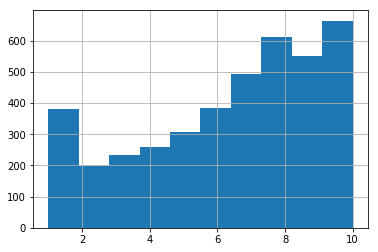

In [122]:
# overall rating dist. 
all_info.review_rating = all_info.review_rating.astype(int)
overall_rating_dist = (np.mean(all_info.review_rating),np.std(all_info.review_rating))
print('mean: ', np.mean(all_info.review_rating),'std: ',np.std(all_info.review_rating))
all_info.review_rating.hist(bins =  10)
plt.show()

mu:  0.008750770711363815 sigma:  0.04786554481869126


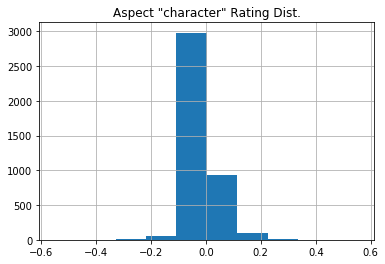

mu:  0.01701118680374357 sigma:  0.04996960838567599


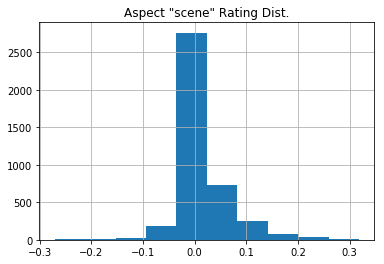

mu:  0.00042058039062421406 sigma:  0.05797885785998569


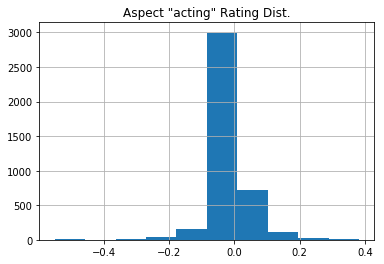

mu:  0.003996507542843496 sigma:  0.03467848940001639


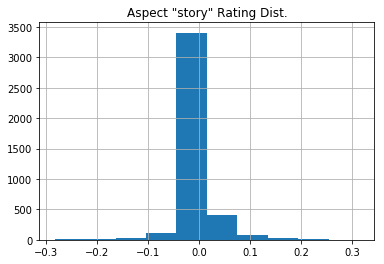

mu:  0.035595213021720806 sigma:  0.06597801798316101


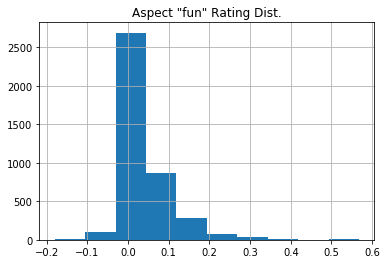

In [120]:
# aspect ratings
aspect_rating_dist = []
for i in range(5):
    aspect_rating_df[i].hist()
    mu = np.nanmean(aspect_rating_df[i])
    sigma = np.nanstd(aspect_rating_df[i])
    aspect_rating_dist.append((mu,sigma))
    print('mu: ',mu,'sigma: ',sigma)
    plt.title('Aspect "{}" Rating Dist.'.format(aspects[i]))
    plt.show()

In [ ]:
# https://xijunlee.github.io/2017/09/09/Dirichlet%E5%88%86%E5%B8%83%E4%B8%8EBeta%E5%88%86%E5%B8%83/

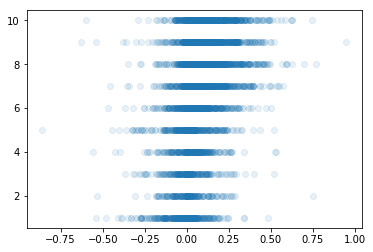

In [131]:
# when there is no aspect weighting (i.e. every aspect weight the same for each reviewer)
# the relationship between sum(aspect scores) and overall scores are:
plt.plot(aspect_rating_df.sum(axis = 1), all_info.review_rating,'o',alpha = 0.1)
plt.show()

In [172]:
# all_info.to_csv('all_info.csv')

In [163]:
# try to build a model for MAP
import pymc3 as pm
n = len(aspect_ratings)  #4085

# mu_list = [item[0] for item in aspect_rating_dist] # from actual data, the average aspect WEIGHTING for each aspect
# cov = np.cov(aspect_ratings.T) # should NOT from aspect rating, but from real data. Collect (estimate) aspect WEIGHTING for all movies

basic_model = pm.Model()
with basic_model:
    # priors for unkonwn model parameters
    alpha = pm.Normal('alpha',mu = 0,sd = 10)
    beta = pm.MvNormal('beta',mu=mu_list, cov=cov, shape=(n,5))
    
    sigma = pm.HalfNormal('sigma',sd = 1)
    
    #expected value of outcome
#     mu = alpha + beta[0]*x1 + beta[1]*x2
    
    #likelihood (sampling distrubtion) of observations
    Y_obs = pm.Normal('Y_obs',mu =overall_rating_dist[0] , sd = overall_rating_dist[1], observed = all_info.review_rating)

In [164]:
map_estimate = pm.find_MAP(model = basic_model)
map_estimate 

/home/yang/anaconda3/lib/python3.6/site-packages/pymc3/tuning/starting.py:61: UserWarning: find_MAP should not be used to initialize the NUTS sampler, simply call pymc3.sample() and it will automatically initialize NUTS in a better way.
  warnings.warn('find_MAP should not be used to initialize the NUTS sampler, simply call pymc3.sample() and it will automatically initialize NUTS in a better way.')
logp = -inf, ||grad|| = 0.63662: 100%|██████████| 3/3 [00:00<00:00, 70.22it/s]


{'alpha': array(0.),
 'beta': array([[0.00875077, 0.01701119, 0.00042058, 0.00399651, 0.03559521],
        [0.00875077, 0.01701119, 0.00042058, 0.00399651, 0.03559521],
        [0.00875077, 0.01701119, 0.00042058, 0.00399651, 0.03559521],
        ...,
        [0.00875077, 0.01701119, 0.00042058, 0.00399651, 0.03559521],
        [0.00875077, 0.01701119, 0.00042058, 0.00399651, 0.03559521],
        [0.00875077, 0.01701119, 0.00042058, 0.00399651, 0.03559521]]),
 'sigma': array(0.29352533),
 'sigma_log__': array(-1.22579135)}

In [167]:
aspect_rating_df.iloc[0,:]

0    0.061286
1    0.000000
2   -0.062943
3    0.000000
4    0.000000
Name: 0, dtype: float64

In [ ]:
aspect_rating_df.iloc[0,:]

In [170]:
b = np.array([0.00875077, 0.01701119, 0.00042058, 0.00399651, 0.03559521])
print((b*aspect_rating_df.iloc[0,:]).sum()+0.29352533)
print(all_info.review_rating[0])

0.294035154421913
1


# END 
==========================================================

In [133]:
from sklearn.linear_model import LinearRegression as LR
from sklearn.model_selection import train_test_split

In [134]:
X_train, X_test, y_train, y_test = train_test_split(aspect_rating_df, all_info.review_rating, test_size = 0.2, random_state = 43)

In [136]:
len(X_train),len(y_train), len(X_test),len(y_test)

(3268, 3268, 817, 817)

In [137]:
lr = LR().fit(X_train, y_train)
lr.coef_, lr.intercept_

(array([ 4.95461801,  6.72747591,  7.46545275, 10.73357529,  5.27370912]),
 6.044442076068732)

0.12598799481523915


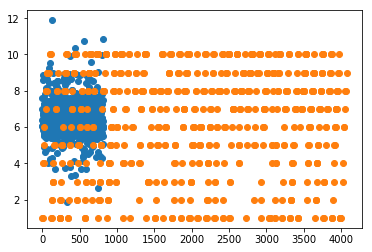

In [144]:
prediction = lr.predict(X_test)
pred_score = lr.score(X_test, y_test)
print(pred_score)
plt.plot(prediction,'o')
plt.plot(y_test,'o')
# plt.plot(prediction, y_test,'o',markersize = 0.2)

<span style="color:red">need overall ratings for all action movie to get the actual dist. Need aspect ratings for all action movies to get the atual dist.</sapn>

# <span style="color:red"> ATTENTION! PREVERVED RESULTS!! DO NOT REMOVE</span>

#### Thoughts about the regression
[Sentiments] <span style="color:red"> sentences with no labels typically have strong sentiments. The user typically describe an overall feeling about the move. Not sure if the sentiments score for those unlabled(and thus not considered anywhere in the analysis) can be used to improve the regression where we try to predict the overall rating of the movie. </span>

In [174]:
seeds[2]

['act', 'perform', 'cast', 'actor']

In [418]:
# take the first review for the first movie as an example
print(1,'              ',2,'     ',3,'        ',4,'    ',5)
print(aspects)
for b in range(len(B[0][0])):
    print(B[0][0][b], ' ',review_segs_l[0][b])
    
get_aspect_rating(Wd_list[0])

1                2       3          4      5
['character', 'scene', 'acting', 'story', 'fun']
Character development is horrible, fast paced and bundled up.   [1, 4]
The villan played by the amazing "Mark Strong" is stylish but as mentioned by another reviewer is forgettable, I wanted this movie to hit in all the right ways but it left me begging for it to end, the 2hr Run time feels more like 3.   [1, 2]
The chemistry of the cast felt unnatural and forced.   [3]
I found myself more annoyed then excited ,the pacing of the film was horrendous and the last act made it seems as though Shazam is dumber then his "siblings" as they learned to utilize their powers in a shorter amount of time.   [1, 3, 4]
DC did better with Aquaman, Shazam meant well it tried to capture a coming of age feel good movie but missed the mark.   [1]
I would consider this film a "wait until it hits Netflix".   [0]
Pass on this movie and watch dumbo o hellboy']   [0]


array([ 0.0181371 ,  0.07490417, -0.06294348, -0.0638    ,  0.        ])

In [420]:
# take the last review for the last movie as an example
print(1,'              ',2,'     ',3,'        ',4,'    ',5)
print(aspects)
for b in range(len(B[-1][-1])):
    print(B[-1][-1][b], ' ',review_segs_l[-1][b])
    
get_aspect_rating(Wd_list[-1])

1                2       3          4      5
['character', 'scene', 'acting', 'story', 'fun']
You know that old expression, "don\'t make mountains out of molehills"?   [0]
Suffice it to say, a vast majority of the harshly negative reviews of The Last Jedi present a whole mountain range of issues where only molehills exist.   [0]
', "Often, when I'm researching whether or not I should see a movie, I rely on user reviews to make that decision.   [0]
Rarely do I put much stock in what the film critics have to say.   [0]
This is the first time I can remember in recent memory that, the critics actually got his one right and the fans didn't at all.   [0]
", 'Having read a ton of negative reviews, I think I could put most of the upset , blatantly negative reviewers into one of four categories; (1) those how cannot see the forest for the trees, and thus get hung up on a few broken and miss the big picture; (2) those who are holding too tightly to the old Extended Universe; and (3) those who ma

array([0.05303333, 0.        , 0.        , 0.        , 0.02117619])

- flat_A = list(itertools.chain.from_iterable(A))
- **len(flat_A)** # there are <span style="color:blue">4085 REVIEWS in total (all movie)</span>
- **flat_flat_A** = list(itertools.chain.from_iterable(flat_A)) <span style="color:blue">there are 52651 setences from all reviews for all movie</span>

- len(flat_C) # there are 52651 setences from all reviews for all movies, the same as flatflatA
- flat_flat_A[0] == A[0][0][0]
- len(A[0]) # there are 113 reviews of movie 1
- len(A[0][0]) # there are seven sentences in first review of movie 1 
- len(C[0])  #There are 972 sentences from all reviews of movie 1